## Libraries

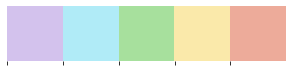

In [1]:
import json
import os
import glob
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import cv2
import seaborn as sns
import missingno as msno 
import altair as alt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Set Color Palettes for the notebook
# colors_nude = ['#e0798c','#65365a','#da8886','#cfc4c4','#dfd7ca']
# colors_nude = ['#FEC5CB', '#FEDC5D', '#A3CFC5', '#B4D4ED', '#F7A7A3']
colors_nude = ['#D3C2ED', '#B0EBF7', '#A7E09D', '#FAE9AA', '#EDAB9A']
sns.palplot(sns.color_palette(colors_nude))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

## Paths

In [6]:
base_path = "./ISIC-Archive/Data_/"
csv_path = os.path.join(base_path, "bigmetadata.csv")

In [7]:
# Auxiliar functions

# Function to read formatted json
def my_read_json(file):
    with open(file, encoding='utf-8', mode='r') as f:
        df = pd.json_normalize(json.load(f))
        return df
# Function to select and remove columns
def selCols(df, inCols, exCols):
    df = df[df.columns[df.columns.str.contains('|'.join(inCols))]]
    df = df.drop(exCols, axis=1, errors='ignore')
    df = df.rename(columns=lambda x: x.rpartition(".")[2])
    return df

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

## Explore

In [10]:
df_target = pd.read_csv(csv_path)
df_target

ID      dcm_name   age          anatomy  \
0      5436e3acbae478396759f0d1  ISIC_0000001  30.0   anterior torso   
1      5436e3acbae478396759f0d3  ISIC_0000002  60.0  upper extremity   
2      5436e3acbae478396759f0d5  ISIC_0000003  30.0  upper extremity   
3      5436e3acbae478396759f0d9  ISIC_0000005  40.0   anterior torso   
4      5436e3acbae478396759f0df  ISIC_0000008  30.0   anterior torso   
...                         ...           ...   ...              ...   
53341                IP_6526534  ISIC_9999134  50.0            torso   
53342                IP_3650745  ISIC_9999320  65.0            torso   
53343                IP_2026598  ISIC_9999515  20.0  lower extremity   
53344                IP_7702038  ISIC_9999666  50.0  lower extremity   
53345                IP_0046310  ISIC_9999806  45.0            torso   

      benign_malignant diagnosis     sex  target  
0               benign     nevus  female       0  
1            malignant  melanoma  female       1  
2               benign     nevus    male       0  
3               benign     nevus  female       0  
4               benign     nevus  female       0  
...                ...       ...     ...     ...  
53341           benign   unknown    male       0  
53342           benign   unknown    male       0  
53343           benign   unknown    male       0  
53344           benign   unknown    male       0  
53345           benign     nevus    male       0  

[53346 rows x 8 columns]

In [11]:
# includeCols = ['_id', 'name', 'pixelsX', 'pixelsY','benign_malignant', 'diagnosis', 'sex', 'age_approx', 'anatom_site_general']
# excludeCols = ['lesion_id', 'patient_id', 'diagnosis_confirm_type']

# df_target = selCols(df_target, includeCols, excludeCols)
# df_target.rename(columns = {'_id':'id', 'name':'image_name', 'age_approx':'age', 'anatom_site_general':'anatomy'}, inplace = True)

# len(df_target.index)
# df_target

### Check duplicates

In [15]:
ids = df_target["dcm_name"]
df_target[ids.isin(ids[ids.duplicated()])].sort_values('dcm_name')

ID      dcm_name   age          anatomy  \
9983   5e8402852a5a4415fe695279  ISIC_0052212  50.0  lower extremity   
20232                IP_2842074  ISIC_0052212  50.0  lower extremity   
16933  5e8402862a5a4415fe69529c  ISIC_0084086  60.0  lower extremity   
20256                IP_4023055  ISIC_0084086  60.0  lower extremity   
16934  5e8403802a5a4415fe6958c3  ISIC_0084270  40.0  lower extremity   
...                         ...           ...   ...              ...   
20227  5e8107ee74440928c0be2971  ISIC_9997614  50.0  upper extremity   
53337                IP_2516168  ISIC_9998682  60.0        head/neck   
20228  5e8f93814ad5f6bd588b16e3  ISIC_9998682  60.0        head/neck   
20229  5e8403bf2a5a4415fe695e83  ISIC_9998937  40.0        head/neck   
53338                IP_3091321  ISIC_9998937  40.0        head/neck   

      benign_malignant diagnosis     sex  target  
9983            benign     nevus  female       0  
20232           benign     nevus  female       0  
16933           benign     nevus    male       0  
20256           benign     nevus    male       0  
16934           benign     nevus    male       0  
...                ...       ...     ...     ...  
20227           benign     nevus  female       0  
53337        malignant  melanoma    male       1  
20228        malignant  melanoma    male       1  
20229           benign     nevus    male       0  
53338           benign     nevus    male       0  

[6594 rows x 8 columns]

In [16]:
# Drop (of any) duplicates restricted NaN of target class and then clean again
df_clean = df_target[~df_target['dcm_name'].duplicated(keep=False) | df_target[['benign_malignant']].notnull().any(axis=1)]
df_clean.drop_duplicates(subset ="dcm_name", keep ='first', inplace = True)

In [18]:
ids = df_target["dcm_name"]
df_clean[ids.isin(ids[ids.duplicated()])].sort_values('dcm_name')

ID      dcm_name   age          anatomy  \
9983   5e8402852a5a4415fe695279  ISIC_0052212  50.0  lower extremity   
16933  5e8402862a5a4415fe69529c  ISIC_0084086  60.0  lower extremity   
16934  5e8403802a5a4415fe6958c3  ISIC_0084270  40.0  lower extremity   
16935  5e84026d2a5a4415fe695041  ISIC_0091996  50.0  lower extremity   
16936  5e8403872a5a4415fe695982  ISIC_0094701  40.0  lower extremity   
...                         ...           ...   ...              ...   
20225  5e8402c02a5a4415fe6957e2  ISIC_9991967  70.0  lower extremity   
20226  5e8403c62a5a4415fe695f33  ISIC_9995691  50.0  upper extremity   
20227  5e8107ee74440928c0be2971  ISIC_9997614  50.0  upper extremity   
20228  5e8f93814ad5f6bd588b16e3  ISIC_9998682  60.0        head/neck   
20229  5e8403bf2a5a4415fe695e83  ISIC_9998937  40.0        head/neck   

      benign_malignant diagnosis     sex  target  
9983            benign     nevus  female       0  
16933           benign     nevus    male       0  
16934           benign     nevus    male       0  
16935           benign     nevus    male       0  
16936           benign     nevus    male       0  
...                ...       ...     ...     ...  
20225           benign     nevus    male       0  
20226           benign     nevus    male       0  
20227           benign     nevus  female       0  
20228        malignant  melanoma    male       1  
20229           benign     nevus    male       0  

[3297 rows x 8 columns]

In [22]:
df_clean

ID      dcm_name   age          anatomy  \
0      5436e3acbae478396759f0d1  ISIC_0000001  30.0   anterior torso   
1      5436e3acbae478396759f0d3  ISIC_0000002  60.0  upper extremity   
2      5436e3acbae478396759f0d5  ISIC_0000003  30.0  upper extremity   
3      5436e3acbae478396759f0d9  ISIC_0000005  40.0   anterior torso   
4      5436e3acbae478396759f0df  ISIC_0000008  30.0   anterior torso   
...                         ...           ...   ...              ...   
53341                IP_6526534  ISIC_9999134  50.0            torso   
53342                IP_3650745  ISIC_9999320  65.0            torso   
53343                IP_2026598  ISIC_9999515  20.0  lower extremity   
53344                IP_7702038  ISIC_9999666  50.0  lower extremity   
53345                IP_0046310  ISIC_9999806  45.0            torso   

      benign_malignant diagnosis     sex  target  
0               benign     nevus  female       0  
1            malignant  melanoma  female       1  
2               benign     nevus    male       0  
3               benign     nevus  female       0  
4               benign     nevus  female       0  
...                ...       ...     ...     ...  
53341           benign   unknown    male       0  
53342           benign   unknown    male       0  
53343           benign   unknown    male       0  
53344           benign   unknown    male       0  
53345           benign     nevus    male       0  

[50049 rows x 8 columns]

## Missing values

In [19]:
df_clean['benign_malignant'].value_counts()

benign       44323
malignant     5726
Name: benign_malignant, dtype: int64

In [20]:
missing_values_table(df_clean)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

In [21]:
df_drop = df_clean.dropna(axis=0, subset=['benign_malignant'])
df_mask = df_drop.loc[(df_drop['benign_malignant'] == 'benign') | (df_drop['benign_malignant'] == 'malignant')]
df_mask['benign_malignant'].value_counts()

benign       44323
malignant     5726
Name: benign_malignant, dtype: int64

In [27]:
bdf2csv_path = os.path.join(base_path, "metadata.csv")
df_mask.to_csv(bdf2csv_path, index = False, header=True)

### Create target class

In [23]:
# df_mask['target'] = pd.Series(np.where(df_mask.benign_malignant.values == 'malignant', 1, 0), df_mask.index)
# df_mask

In [24]:
# missing_values_table(df_mask)

In [25]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

# msno.matrix(df_clean, ax = ax1, color=(207/255, 196/255, 171/255), fontsize=10)
# msno.matrix(df_mask, ax = ax2, color=(218/255, 136/255, 130/255), fontsize=10)


# ax1.set_title('Before Dropping Target Missing Values Map', fontsize = 16)
# ax2.set_title('After Dropping Target Missing Values Map', fontsize = 16);

### SEX variable

Out of 456 NAN values, 339 are benign and 117 malignant.


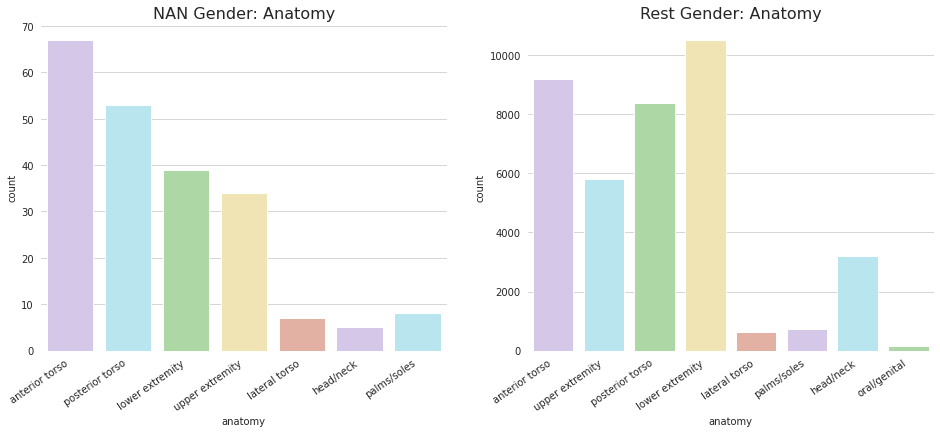

In [22]:
# Data
nan_sex = df_mask[df_mask['sex'].isna() == True]
is_sex = df_mask[df_mask['sex'].isna() == False]

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(nan_sex['anatomy'], ax = ax1, palette=colors_nude)
b = sns.countplot(is_sex['anatomy'], ax = ax2, palette=colors_nude)
ax1.set_title('NAN Gender: Anatomy', fontsize=16)
ax2.set_title('Rest Gender: Anatomy', fontsize=16)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")
sns.despine(left=True, bottom=True);

# Benign/ Malignant check
print('Out of {} NAN values, {} are benign and {} malignant.'.format(df_mask['sex'].isna().sum(),nan_sex['benign_malignant'].value_counts()[0], nan_sex['benign_malignant'].value_counts()[1]))

In [23]:
# Check how many are males and how many females
anatomy = ['lower extremity', 'upper extremity', 'torso']
df_mask[(df_mask['anatomy'].isin(anatomy)) & (df_mask['target'] == 0)]['sex'].value_counts

<bound method IndexOpsMixin.value_counts of 2          male
12       female
27       female
36       female
42       female
          ...  
69430      male
69431    female
69436    female
69445      male
69446      male
Name: sex, Length: 14446, dtype: object>

### AGE variable

Out of 452 NAN values, 341 are benign and 111 malignant.


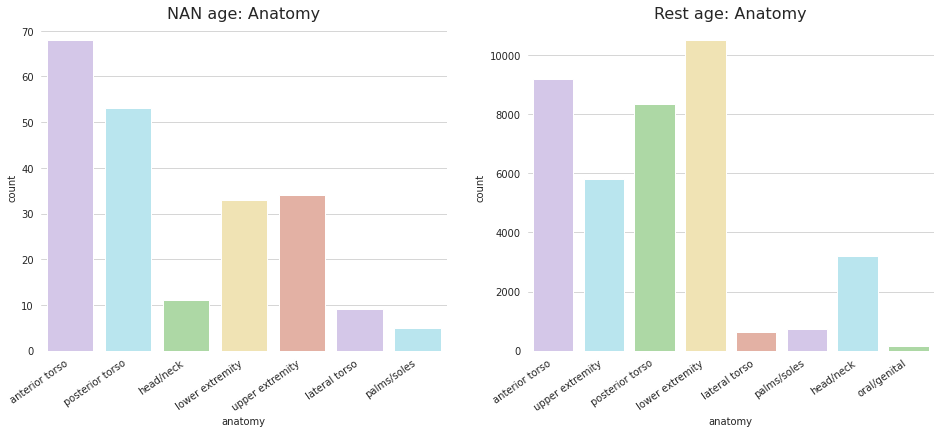

In [24]:
# Data
nan_age = df_mask[df_mask['age'].isna() == True]
is_age = df_mask[df_mask['age'].isna() == False]

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(nan_age['anatomy'], ax = ax1, palette=colors_nude)
b = sns.countplot(is_age['anatomy'], ax = ax2, palette=colors_nude)
ax1.set_title('NAN age: Anatomy', fontsize=16)
ax2.set_title('Rest age: Anatomy', fontsize=16)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")
sns.despine(left=True, bottom=True);

# Benign/ Malignant check
print('Out of {} NAN values, {} are benign and {} malignant.'.format(df_mask['age'].isna().sum(),nan_age['benign_malignant'].value_counts()[0],nan_age['benign_malignant'].value_counts()[1]))

### DIAGNOSIS variable

In [25]:
diagnosis = df_mask.copy()
diagnosis['flag'] = np.where(df_mask['diagnosis'].isna()==True, 'missing', 'not_missing')

# Benign - malignant
ben_mal = diagnosis[diagnosis['flag'] == 'missing']['benign_malignant'].value_counts()
print('From all missing values, {} are benign and {} malignant.'.format(ben_mal[0], ben_mal[1]))

From all missing values, 19008 are benign and 27 malignant.


### ANATOMY variable

From all missing values, 14254 are benign and 280 malignant.


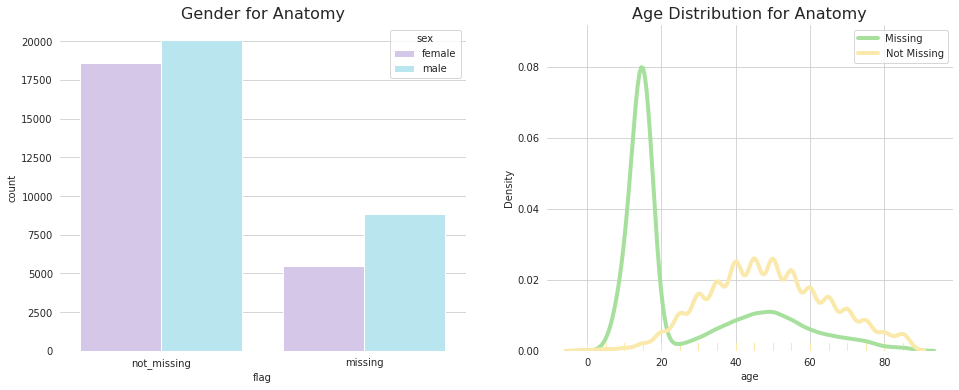

In [26]:
anatomy = df_mask.copy()
anatomy['flag'] = np.where(df_mask['anatomy'].isna()==True, 'missing', 'not_missing')

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.countplot(anatomy['flag'], hue=anatomy['sex'], ax=ax1, palette=colors_nude)

sns.distplot(anatomy[anatomy['flag'] == 'missing']['age'], 
             hist=False, rug=True, label='Missing', ax=ax2, 
             color=colors_nude[2], kde_kws=dict(linewidth=4))
sns.distplot(anatomy[anatomy['flag'] == 'not_missing']['age'], 
             hist=False, rug=True, label='Not Missing', ax=ax2, 
             color=colors_nude[3], kde_kws=dict(linewidth=4))

plt.legend()
ax1.set_title('Gender for Anatomy', fontsize=16)
ax2.set_title('Age Distribution for Anatomy', fontsize=16)
sns.despine(left=True, bottom=True);

# Benign - malignant
ben_mal = anatomy[anatomy['flag'] == 'missing']['benign_malignant'].value_counts()
print('From all missing values, {} are benign and {} malignant.'.format(ben_mal[0], ben_mal[1]))

## Quick EDA

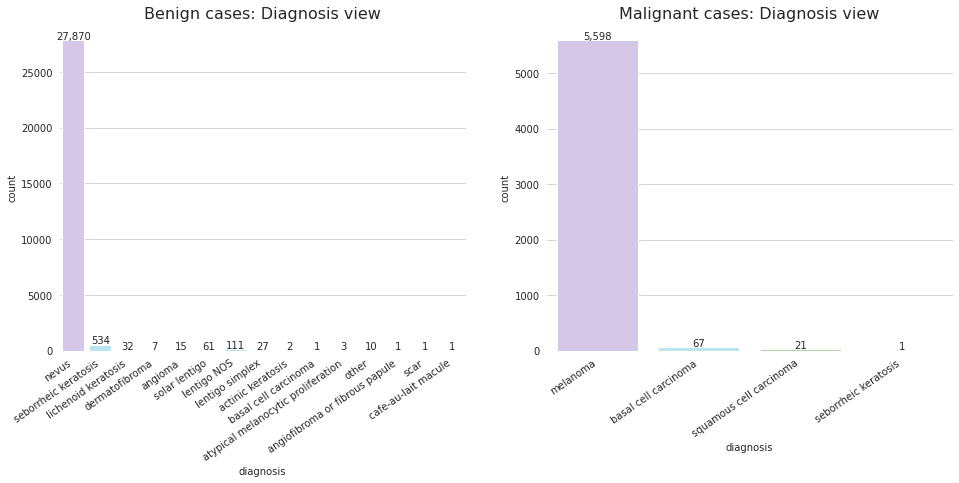

In [27]:
# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(diagnosis[diagnosis['target']==0]['diagnosis'], ax=ax1, palette = colors_nude)
b = sns.countplot(diagnosis[diagnosis['target']==1]['diagnosis'], ax=ax2, palette = colors_nude)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
for p in b.patches:
    b.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
ax1.set_title('Benign cases: Diagnosis view', fontsize=16)
ax2.set_title('Malignant cases: Diagnosis view', fontsize=16)
sns.despine(left=True, bottom=True);

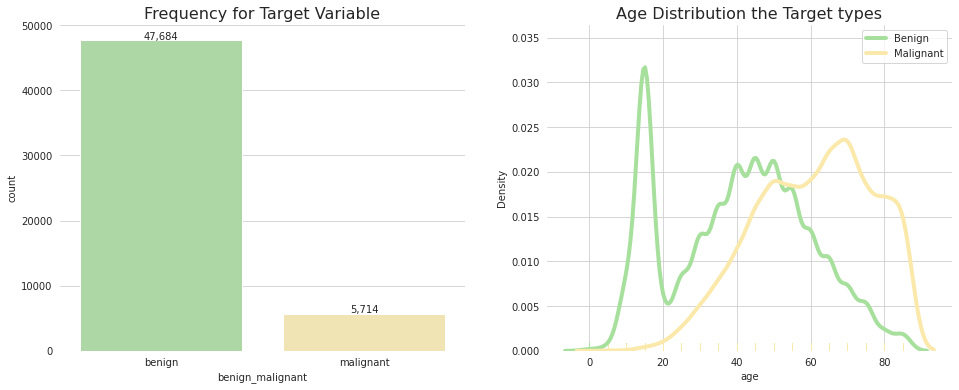

In [28]:
# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(data = df_mask, x = 'benign_malignant', palette=colors_nude[2:4],
                 ax=ax1)
b = sns.distplot(a = df_mask[df_mask['target']==0]['age'], ax=ax2, color=colors_nude[2], 
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Benign')
c = sns.distplot(a = df_mask[df_mask['target']==1]['age'], ax=ax2, color=colors_nude[3], 
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Malignant')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.legend()
ax1.set_title('Frequency for Target Variable', fontsize=16)
ax2.set_title('Age Distribution the Target types', fontsize=16)
sns.despine(left=True, bottom=True);

## Suggestion for addressing imbalance for pytorch.dataloader: ImbalancedDatasetSampler
https://github.com/ufoym/imbalanced-dataset-sampler

In [149]:
import torch
import torch.utils.data
import torchvision


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.train_labels[idx].item()
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:
from torchsampler import ImbalancedDatasetSampler

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    sampler=ImbalancedDatasetSampler(train_dataset),
    batch_size=args.batch_size, 
    **kwargs
)

## Extra clean: drop all bening with any of the other classes with a NaN

In [29]:
B = df_mask['benign_malignant'].value_counts()[0]
M = df_mask['benign_malignant'].value_counts()[1]
print(f'Initial number of row {len(df_mask.index)}, {B} are benign and {M} malignant.')
df_mal = pd.DataFrame(df_mask.benign_malignant.value_counts())
df_mal['name'] = df_mal.index
alt.Chart(df_mal).mark_bar().encode(
    x='name',
    y='benign_malignant',
    tooltip=["name","benign_malignant"]
).interactive()

Initial number of row 53398, 47684 are benign and 5714 malignant.


alt.Chart(...)

In [30]:
df = df_mask.copy()
s1 = df['benign_malignant'] == 'benign'
s2 = df['diagnosis'].isna()==True # This class has the largest number of NaNs in benign class.  
# s3 = df['anatomy'].isna()==True
# s4 = df['sex'].isna() == True
# s5 = df['age'].isna() == True
df.drop(df_mask[(s1) & (s2)].index, inplace=True)

In [31]:
B = df['benign_malignant'].value_counts()[0]
M = df['benign_malignant'].value_counts()[1]
print(f'Initial number of row {len(df.index)}, {B} are benign and {M} malignant.')
df_mal = pd.DataFrame(df.benign_malignant.value_counts())
df_mal['name'] = df_mal.index
alt.Chart(df_mal).mark_bar().encode(
    x='name',
    y='benign_malignant',
    tooltip=["name","benign_malignant"]
).interactive()

Initial number of row 34390, 28676 are benign and 5714 malignant.


alt.Chart(...)

In [62]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 4 columns that have missing values.


Missing Values  % of Total Values
anatomy             14209               41.3
age                   451                1.3
sex                   411                1.2
diagnosis              27                0.1

Text(0.5, 1.0, 'Before Dropping Target Missing Values Map')

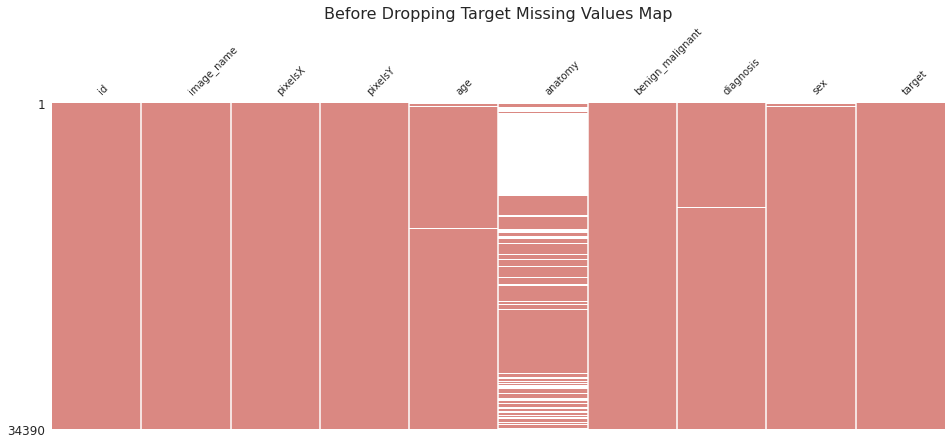

In [61]:
f, ax1 = plt.subplots(1, 1, figsize = (16, 6))
msno.matrix(df, ax = ax1, color=(218/255, 136/255, 130/255), fontsize=10)
ax1.set_title('Before Dropping Target Missing Values Map', fontsize = 16)

In [32]:
df_final = df.copy()

In [33]:
csv_path = os.path.join(base_path, "metadata_clean.csv")

In [40]:
df_final.to_csv(csv_path, index = False, header=True)

## From Kaggle: Train and Test CSV

In [49]:
path_ = '/home/mestecha/Descargas/'

In [50]:
train_df = pd.read_csv(os.path.join(path_, 'train.csv'))
test_df = pd.read_csv(os.path.join(path_, 'test.csv'))

In [51]:
new_names = ['dcm_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

In [52]:
missing_values_table(train_df)

Your selected dataframe has 8 columns.
There are 3 columns that have missing values.


Missing Values  % of Total Values
anatomy             527                1.6
age                  68                0.2
sex                  65                0.2

In [53]:
missing_values_table(test_df)

Your selected dataframe has 5 columns.
There are 1 columns that have missing values.


Missing Values  % of Total Values
anatomy             351                3.2

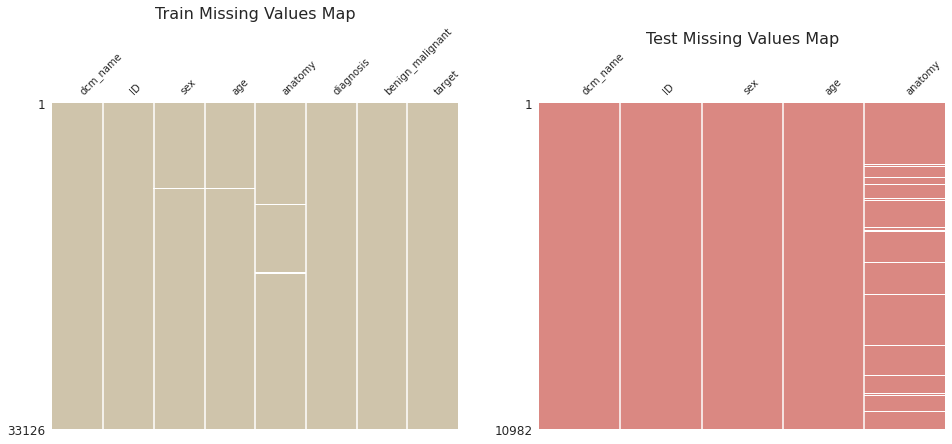

In [54]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

msno.matrix(train_df, ax = ax1, color=(207/255, 196/255, 171/255), fontsize=10)
msno.matrix(test_df, ax = ax2, color=(218/255, 136/255, 130/255), fontsize=10)

ax1.set_title('Train Missing Values Map', fontsize = 16)
ax2.set_title('Test Missing Values Map', fontsize = 16);

In [55]:
# Impute the missing values with male
train_df['sex'].fillna("male", inplace = True)

In [56]:
# Check the mean age
anatomy = ['lower extremity', 'upper extremity', 'torso']
median = train_df[(train_df['anatomy'].isin(anatomy)) & (train_df['target'] == 0) & (train_df['sex'] == 'male')]['age'].median()
print('Median is:', median)

# Impute the missing values with male
train_df['age'].fillna(median, inplace = True) 

Median is: 50.0


In [58]:
# Impute for anatomy
train_df['anatomy'].fillna('torso', inplace = True) 

In [59]:
# Select most frequent anatomy for age 70
value = test_df[test_df['age'] == 70]['anatomy'].value_counts().reset_index()['index'][0]

# Impute the value
test_df['anatomy'].fillna(value, inplace = True) 

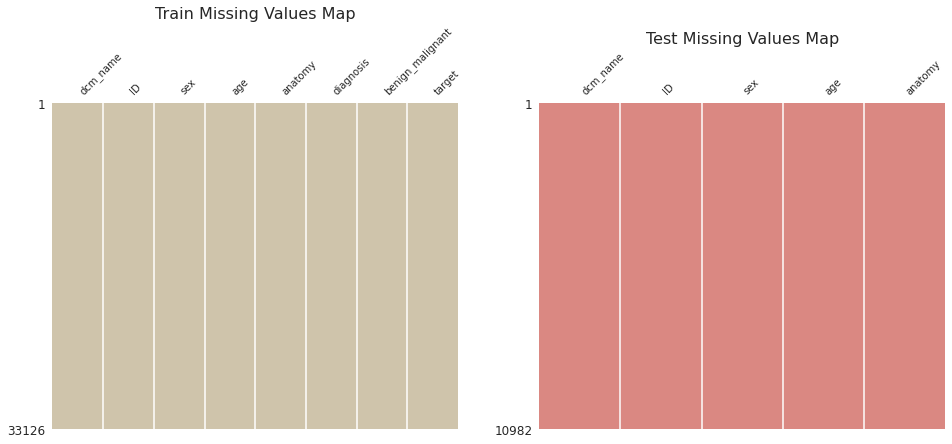

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

msno.matrix(train_df, ax = ax1, color=(207/255, 196/255, 171/255), fontsize=10)
msno.matrix(test_df, ax = ax2, color=(218/255, 136/255, 130/255), fontsize=10)

ax1.set_title('Train Missing Values Map', fontsize = 16)
ax2.set_title('Test Missing Values Map', fontsize = 16);

## Join both dataframes and get the BIGDATA-FRAME

In [95]:
df1 = train_df.copy()
df2 = df_final.copy()
df2.rename(columns = {'id':'ID', 'image_name':'dcm_name', 'age_approx':'age', 'anatom_site_general':'anatomy'}, inplace = True)
df2 = df2.drop(['pixelsX', 'pixelsY'], axis=1, errors='ignore')

In [98]:
bigdata = df2.append(df1, ignore_index=True)

In [99]:
bigdata

ID      dcm_name   age          anatomy  \
0      5436e3acbae478396759f0d1  ISIC_0000001  30.0   anterior torso   
1      5436e3acbae478396759f0d3  ISIC_0000002  60.0  upper extremity   
2      5436e3acbae478396759f0d5  ISIC_0000003  30.0  upper extremity   
3      5436e3acbae478396759f0d9  ISIC_0000005  40.0   anterior torso   
4      5436e3acbae478396759f0df  ISIC_0000008  30.0   anterior torso   
...                         ...           ...   ...              ...   
67511                IP_6526534  ISIC_9999134  50.0            torso   
67512                IP_3650745  ISIC_9999320  65.0            torso   
67513                IP_2026598  ISIC_9999515  20.0  lower extremity   
67514                IP_7702038  ISIC_9999666  50.0  lower extremity   
67515                IP_0046310  ISIC_9999806  45.0            torso   

      benign_malignant diagnosis     sex  target  
0               benign     nevus  female       0  
1            malignant  melanoma  female       1  
2               benign     nevus    male       0  
3               benign     nevus  female       0  
4               benign     nevus  female       0  
...                ...       ...     ...     ...  
67511           benign   unknown    male       0  
67512           benign   unknown    male       0  
67513           benign   unknown    male       0  
67514           benign   unknown    male       0  
67515           benign     nevus    male       0  

[67516 rows x 8 columns]

In [102]:
ids = bigdata["dcm_name"]
bigdata[ids.isin(ids[ids.duplicated()])].sort_values('dcm_name').head(20)

ID      dcm_name   age          anatomy  \
21452  5e8402852a5a4415fe695279  ISIC_0052212  50.0  lower extremity   
34392                IP_2842074  ISIC_0052212  50.0  lower extremity   
34402                IP_2235340  ISIC_0076995  55.0            torso   
28520  5e8403c22a5a4415fe695ed3  ISIC_0076995  55.0              NaN   
28521  5e8402862a5a4415fe69529c  ISIC_0084086  60.0  lower extremity   
34416                IP_4023055  ISIC_0084086  60.0  lower extremity   
28522  5e8403802a5a4415fe6958c3  ISIC_0084270  40.0  lower extremity   
34417                IP_2961528  ISIC_0084270  40.0  lower extremity   
28523  5e8403bf2a5a4415fe695e7f  ISIC_0084395  45.0              NaN   
34418                IP_0175539  ISIC_0084395  45.0            torso   
34422                IP_2825529  ISIC_0086349  55.0            torso   
28524  5e8402872a5a4415fe6952a2  ISIC_0086349  55.0              NaN   
34431                IP_3933152  ISIC_0089569  30.0            torso   
28525  5e84037f2a5a4415fe6958aa  ISIC_0089569  30.0              NaN   
34432                IP_3076695  ISIC_0089738  70.0            torso   
28526  5e8402422a5a4415fe694c6c  ISIC_0089738  70.0              NaN   
34434                IP_4042098  ISIC_0091016  40.0            torso   
28527  5e8403c42a5a4415fe695efb  ISIC_0091016  40.0              NaN   
34436                IP_1273286  ISIC_0091996  50.0  lower extremity   
28528  5e84026d2a5a4415fe695041  ISIC_0091996  50.0  lower extremity   

      benign_malignant diagnosis     sex  target  
21452           benign     nevus  female       0  
34392           benign     nevus  female       0  
34402           benign     nevus  female       0  
28520           benign     nevus  female       0  
28521           benign     nevus    male       0  
34416           benign     nevus    male       0  
28522           benign     nevus    male       0  
34417           benign     nevus    male       0  
28523           benign     nevus  female       0  
34418           benign     nevus  female       0  
34422           benign     nevus  female       0  
28524           benign     nevus  female       0  
34431           benign     nevus  female       0  
28525           benign     nevus  female       0  
34432           benign     nevus  female       0  
28526           benign     nevus  female       0  
34434           benign     nevus    male       0  
28527           benign     nevus    male       0  
34436           benign     nevus    male       0  
28528           benign     nevus    male       0

In [103]:
missing_values_table(bigdata)

Your selected dataframe has 8 columns.
There are 4 columns that have missing values.


Missing Values  % of Total Values
anatomy             14209               21.0
age                   451                0.7
sex                   411                0.6
diagnosis              27                0.0

Text(0.5, 1.0, 'BigDataframe Missing Values Map')

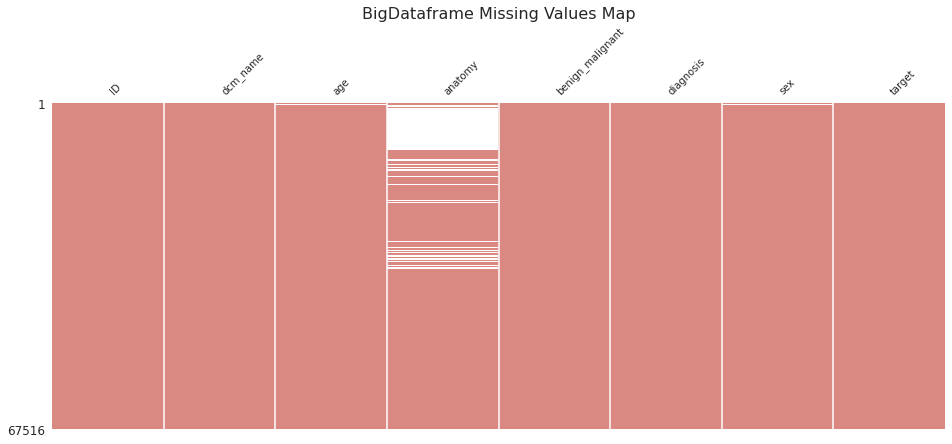

In [104]:
f, ax1 = plt.subplots(1, 1, figsize = (16, 6))
msno.matrix(bigdata, ax = ax1, color=(218/255, 136/255, 130/255), fontsize=10)
ax1.set_title('BigDataframe Missing Values Map', fontsize = 16)

In [106]:
B = bigdata['benign_malignant'].value_counts()[0]
M = bigdata['benign_malignant'].value_counts()[1]
print(f'Initial number of row {len(df.index)}, {B} are benign and {M} malignant.')
df_mal = pd.DataFrame(bigdata.benign_malignant.value_counts())
df_mal['name'] = df_mal.index
alt.Chart(df_mal).mark_bar().encode(
    x='name',
    y='benign_malignant',
    tooltip=["name","benign_malignant"]
).interactive()

Initial number of row 34390, 61218 are benign and 6298 malignant.


alt.Chart(...)

## FALTA ELIMINAR DUPLICADOS Y FINALMENTE LOS 14254 BENIGNOS QUE TIENEN EL CAMPO ANATOMY COMO NAN

In [108]:
bigdata_ = bigdata.copy()
s1 = bigdata_['benign_malignant'] == 'benign'
s3 = bigdata_['anatomy'].isna()==True
bigdata_.drop(bigdata[(s1) & (s3)].index, inplace=True)

In [110]:
B = bigdata_['benign_malignant'].value_counts()[0]
M = bigdata_['benign_malignant'].value_counts()[1]
print(f'Initial number of row {len(bigdata_.index)}, {B} are benign and {M} malignant.')
df_mal = pd.DataFrame(bigdata_.benign_malignant.value_counts())
df_mal['name'] = df_mal.index
alt.Chart(df_mal).mark_bar().encode(
    x='name',
    y='benign_malignant',
    tooltip=["name","benign_malignant"]
).interactive()

Initial number of row 53587, 47289 are benign and 6298 malignant.


alt.Chart(...)

Text(0.5, 1.0, 'BigDataframe Missing Values Map')

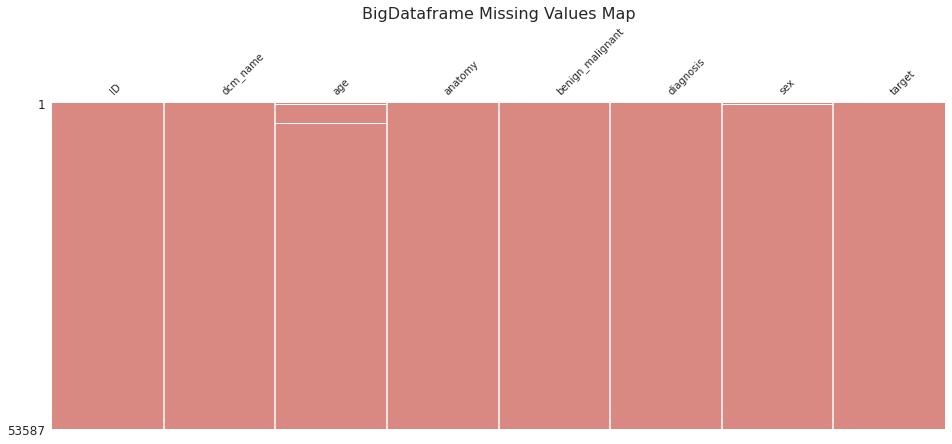

In [112]:
f, ax1 = plt.subplots(1, 1, figsize = (16, 6))
msno.matrix(bigdata_, ax = ax1, color=(218/255, 136/255, 130/255), fontsize=10)
ax1.set_title('BigDataframe Missing Values Map', fontsize = 16)

In [123]:
s1 = bigdata_['benign_malignant'] == 'benign'
s2 = df['sex'].isna() == True
bigdata_.drop(bigdata_[(s1) & (s2)].index, inplace=True)

In [124]:
s1 = bigdata_['benign_malignant'] == 'benign'
s2 = bigdata_['age'].isna() == True
bigdata_.drop(bigdata_[(s1) & (s2)].index, inplace=True)

Text(0.5, 1.0, 'BigDataframe Missing Values Map')

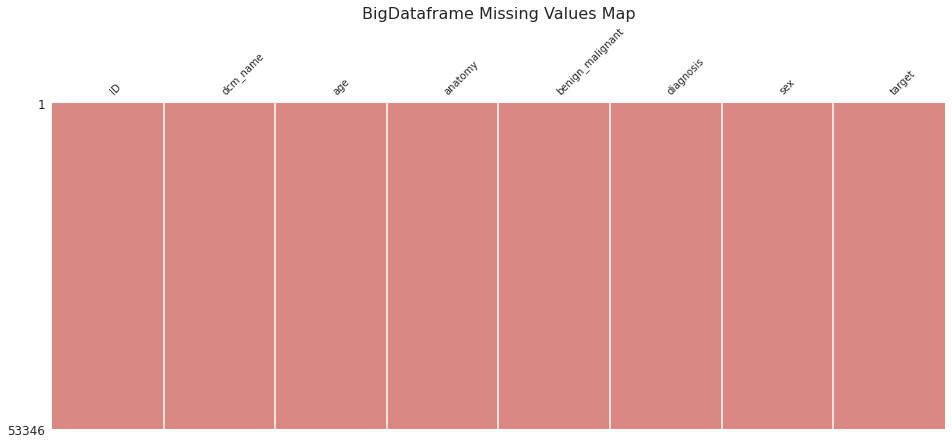

In [125]:
f, ax1 = plt.subplots(1, 1, figsize = (16, 6))
msno.matrix(bigdata_, ax = ax1, color=(218/255, 136/255, 130/255), fontsize=10)
ax1.set_title('BigDataframe Missing Values Map', fontsize = 16)

In [137]:
# Impute the missing values with male
bigdata_['diagnosis'].fillna("melanoma", inplace = True)

In [139]:
# Impute the missing values with male
bigdata_['sex'].fillna("male", inplace = True)

In [142]:
# Select most frequent anatomy for age 70
value = bigdata_[bigdata_['age'] == 70]['anatomy'].value_counts().reset_index()['index'][0]

# Impute the value
bigdata_['anatomy'].fillna(value, inplace = True) 

In [144]:
# Check the mean age
anatomy = ['lower extremity', 'upper extremity', 'torso']
median = bigdata_[(bigdata_['anatomy'].isin(anatomy)) & (bigdata_['target'] == 0) & (bigdata_['sex'] == 'male')]['age'].median()
print('Median is:', median)

# Impute the missing values with male
bigdata_['age'].fillna(median, inplace = True) 

Median is: 50.0


In [155]:
bigdataframe = bigdata_.copy()

In [156]:
missing_values_table(bigdataframe)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

______________________________________________________________________

# Remove duplicates

In [185]:
ids = bigdataframe["dcm_name"]
bigdataframe[ids.isin(ids[ids.duplicated()])].sort_values('dcm_name')

ID      dcm_name   age          anatomy  \
21452  5e8402852a5a4415fe695279  ISIC_0052212  50.0  lower extremity   
34392                IP_2842074  ISIC_0052212  50.0  lower extremity   
28521  5e8402862a5a4415fe69529c  ISIC_0084086  60.0  lower extremity   
34416                IP_4023055  ISIC_0084086  60.0  lower extremity   
28522  5e8403802a5a4415fe6958c3  ISIC_0084270  40.0  lower extremity   
...                         ...           ...   ...              ...   
34386  5e8107ee74440928c0be2971  ISIC_9997614  50.0  upper extremity   
67507                IP_2516168  ISIC_9998682  60.0        head/neck   
34387  5e8f93814ad5f6bd588b16e3  ISIC_9998682  60.0        head/neck   
34388  5e8403bf2a5a4415fe695e83  ISIC_9998937  40.0        head/neck   
67508                IP_3091321  ISIC_9998937  40.0        head/neck   

      benign_malignant diagnosis     sex  target  
21452           benign     nevus  female       0  
34392           benign     nevus  female       0  
28521           benign     nevus    male       0  
34416           benign     nevus    male       0  
28522           benign     nevus    male       0  
...                ...       ...     ...     ...  
34386           benign     nevus  female       0  
67507        malignant  melanoma    male       1  
34387        malignant  melanoma    male       1  
34388           benign     nevus    male       0  
67508           benign     nevus    male       0  

[6594 rows x 8 columns]

In [186]:
# Drop (of any) duplicates restricted NaN of target class and then clean again
bdf2csv = bigdataframe[~bigdataframe['dcm_name'].duplicated(keep='first')]
bdf2csv.drop_duplicates(subset ="dcm_name", keep ='first', inplace = True)

In [187]:
ids = bdf2csv["dcm_name"]
bdf2csv[ids.isin(ids[ids.duplicated()])].sort_values('dcm_name')

Empty DataFrame
Columns: [ID, dcm_name, age, anatomy, benign_malignant, diagnosis, sex, target]
Index: []

In [188]:
B = bdf2csv['benign_malignant'].value_counts()[0]
M = bdf2csv['benign_malignant'].value_counts()[1]
print(f'Initial number of row {len(bdf2csv.index)}, {B} are benign and {M} malignant.')
df_mal = pd.DataFrame(bdf2csv.benign_malignant.value_counts())
df_mal['name'] = df_mal.index
alt.Chart(df_mal).mark_bar().encode(
    x='name',
    y='benign_malignant',
    tooltip=["name","benign_malignant"]
).interactive()

Initial number of row 50049, 44323 are benign and 5726 malignant.


alt.Chart(...)

# Save BigDataframe

In [26]:
bdf2csv_path = os.path.join(base_path, "metadata.csv")
bdf2csv.to_csv(bdf2csv_path, index = False, header=True)

NameError: name 'bdf2csv' is not defined

_______

## Copy imges JPEG to path

In [29]:
images = bdf2csv['dcm_name'].tolist()
# matches = set(images)

NameError: name 'bdf2csv' is not defined

In [273]:
root = '/media/mestecha/Samsung_T5/SAGAN/ISIC-Archive/Data_/Mix/Images/'
destination = '/media/mestecha/Samsung_T5/SAGAN/ISIC-Archive/Data/Images/'

In [274]:
from os import listdir
from os.path import isfile, join

fullfiles = []
for path, subdirs, files in os.walk(root):
    for name in files:
        fullfiles.append(os.path.join(path, name))

In [275]:
len(set(fullfiles))

104630

In [28]:
len(images)

NameError: name 'images' is not defined

In [276]:
import os,shutil

for i in range(len(fullfiles)):
    if os.path.basename(os.path.splitext(fullfiles[i])[0]) in images:
        if os.path.isfile(fullfiles[i]) :
            print(f'[Copying] File {os.path.basename(fullfiles[i])}')
            shutil.copy(fullfiles[i], destination)
            total += 1 
        else:
            print(f'[Error] File does not exist {os.path.basename(fullfiles[i])}')
print(f'Total number of files copied: {total}')
        

[Copying] File ISIC_0000004.jpeg
[Copying] File ISIC_0000003.jpeg
[Copying] File ISIC_0000002.jpeg
[Copying] File ISIC_0000000.jpeg
[Copying] File ISIC_0000005.jpeg
[Copying] File ISIC_0000006.jpeg
[Copying] File ISIC_0000012.jpeg
[Copying] File ISIC_0000001.jpeg
[Copying] File ISIC_0000013.jpeg
[Copying] File ISIC_0000010.jpeg
[Copying] File ISIC_0000009.jpeg
[Copying] File ISIC_0000015.jpeg
[Copying] File ISIC_0000008.jpeg
[Copying] File ISIC_0000007.jpeg
[Copying] File ISIC_0000011.jpeg
[Copying] File ISIC_0000014.jpeg
[Copying] File ISIC_0000016.jpeg
[Copying] File ISIC_0000017.jpeg
[Copying] File ISIC_0000018.jpeg
[Copying] File ISIC_0000022.jpeg
[Copying] File ISIC_0000021.jpeg
[Copying] File ISIC_0000019.jpeg
[Copying] File ISIC_0000025.jpeg
[Copying] File ISIC_0000023.jpeg
[Copying] File ISIC_0000024.jpeg
[Copying] File ISIC_0000020.jpeg
[Copying] File ISIC_0000026.jpeg
[Copying] File ISIC_0000028.jpeg
[Copying] File ISIC_0000030.jpeg
[Copying] File ISIC_0000029.jpeg
[Copying] 

[Copying] File ISIC_0000398.jpeg
[Copying] File ISIC_0000399.jpeg
[Copying] File ISIC_0000400.jpeg
[Copying] File ISIC_0000402.jpeg
[Copying] File ISIC_0000401.jpeg
[Copying] File ISIC_0000404.jpeg
[Copying] File ISIC_0000405.jpeg
[Copying] File ISIC_0000406.jpeg
[Copying] File ISIC_0000410.jpeg
[Copying] File ISIC_0000412.jpeg
[Copying] File ISIC_0000411.jpeg
[Copying] File ISIC_0000414.jpeg
[Copying] File ISIC_0000413.jpeg
[Copying] File ISIC_0000415.jpeg
[Copying] File ISIC_0000417.jpeg
[Copying] File ISIC_0000420.jpeg
[Copying] File ISIC_0000428.jpeg
[Copying] File ISIC_0000429.jpeg
[Copying] File ISIC_0000432.jpeg
[Copying] File ISIC_0000434.jpeg
[Copying] File ISIC_0000438.jpeg
[Copying] File ISIC_0000440.jpeg
[Copying] File ISIC_0000441.jpeg
[Copying] File ISIC_0000444.jpeg
[Copying] File ISIC_0000445.jpeg
[Copying] File ISIC_0000446.jpeg
[Copying] File ISIC_0000450.jpeg
[Copying] File ISIC_0000459.jpeg
[Copying] File ISIC_0000462.jpeg
[Copying] File ISIC_0000463.jpeg
[Copying] 

[Copying] File ISIC_0010014.jpeg
[Copying] File ISIC_0010016.jpeg
[Copying] File ISIC_0010015.jpeg
[Copying] File ISIC_0010018.jpeg
[Copying] File ISIC_0010017.jpeg
[Copying] File ISIC_0010019.jpeg
[Copying] File ISIC_0010020.jpeg
[Copying] File ISIC_0010021.jpeg
[Copying] File ISIC_0010022.jpeg
[Copying] File ISIC_0010024.jpeg
[Copying] File ISIC_0010023.jpeg
[Copying] File ISIC_0010026.jpeg
[Copying] File ISIC_0010025.jpeg
[Copying] File ISIC_0010029.jpeg
[Copying] File ISIC_0010028.jpeg
[Copying] File ISIC_0010031.jpeg
[Copying] File ISIC_0010030.jpeg
[Copying] File ISIC_0010032.jpeg
[Copying] File ISIC_0010034.jpeg
[Copying] File ISIC_0010033.jpeg
[Copying] File ISIC_0010036.jpeg
[Copying] File ISIC_0010037.jpeg
[Copying] File ISIC_0010035.jpeg
[Copying] File ISIC_0010039.jpeg
[Copying] File ISIC_0010038.jpeg
[Copying] File ISIC_0010040.jpeg
[Copying] File ISIC_0010041.jpeg
[Copying] File ISIC_0010042.jpeg
[Copying] File ISIC_0010043.jpeg
[Copying] File ISIC_0010045.jpeg
[Copying] 

[Copying] File ISIC_0010292.jpeg
[Copying] File ISIC_0010291.jpeg
[Copying] File ISIC_0010288.jpeg
[Copying] File ISIC_0010286.jpeg
[Copying] File ISIC_0010293.jpeg
[Copying] File ISIC_0010296.jpeg
[Copying] File ISIC_0010295.jpeg
[Copying] File ISIC_0010294.jpeg
[Copying] File ISIC_0010297.jpeg
[Copying] File ISIC_0010298.jpeg
[Copying] File ISIC_0010300.jpeg
[Copying] File ISIC_0010299.jpeg
[Copying] File ISIC_0010302.jpeg
[Copying] File ISIC_0010301.jpeg
[Copying] File ISIC_0010310.jpeg
[Copying] File ISIC_0010306.jpeg
[Copying] File ISIC_0010311.jpeg
[Copying] File ISIC_0010308.jpeg
[Copying] File ISIC_0010303.jpeg
[Copying] File ISIC_0010304.jpeg
[Copying] File ISIC_0010313.jpeg
[Copying] File ISIC_0010305.jpeg
[Copying] File ISIC_0010312.jpeg
[Copying] File ISIC_0010314.jpeg
[Copying] File ISIC_0010316.jpeg
[Copying] File ISIC_0010315.jpeg
[Copying] File ISIC_0010318.jpeg
[Copying] File ISIC_0010317.jpeg
[Copying] File ISIC_0010319.jpeg
[Copying] File ISIC_0010321.jpeg
[Copying] 

[Copying] File ISIC_0010581.jpeg
[Copying] File ISIC_0010586.jpeg
[Copying] File ISIC_0010587.jpeg
[Copying] File ISIC_0010589.jpeg
[Copying] File ISIC_0010588.jpeg
[Copying] File ISIC_0010590.jpeg
[Copying] File ISIC_0010591.jpeg
[Copying] File ISIC_0010592.jpeg
[Copying] File ISIC_0010593.jpeg
[Copying] File ISIC_0010594.jpeg
[Copying] File ISIC_0010595.jpeg
[Copying] File ISIC_0010598.jpeg
[Copying] File ISIC_0010599.jpeg
[Copying] File ISIC_0010600.jpeg
[Copying] File ISIC_0010596.jpeg
[Copying] File ISIC_0010597.jpeg
[Copying] File ISIC_0010601.jpeg
[Copying] File ISIC_0010602.jpeg
[Copying] File ISIC_0010603.jpeg
[Copying] File ISIC_0010604.jpeg
[Copying] File ISIC_0010606.jpeg
[Copying] File ISIC_0010605.jpeg
[Copying] File ISIC_0010607.jpeg
[Copying] File ISIC_0010608.jpeg
[Copying] File ISIC_0010610.jpeg
[Copying] File ISIC_0010609.jpeg
[Copying] File ISIC_0010612.jpeg
[Copying] File ISIC_0010613.jpeg
[Copying] File ISIC_0010614.jpeg
[Copying] File ISIC_0010611.jpeg
[Copying] 

[Copying] File ISIC_0010944.jpeg
[Copying] File ISIC_0010947.jpeg
[Copying] File ISIC_0010945.jpeg
[Copying] File ISIC_0010949.jpeg
[Copying] File ISIC_0010950.jpeg
[Copying] File ISIC_0010948.jpeg
[Copying] File ISIC_0010951.jpeg
[Copying] File ISIC_0010952.jpeg
[Copying] File ISIC_0010954.jpeg
[Copying] File ISIC_0010953.jpeg
[Copying] File ISIC_0010955.jpeg
[Copying] File ISIC_0010957.jpeg
[Copying] File ISIC_0010956.jpeg
[Copying] File ISIC_0010958.jpeg
[Copying] File ISIC_0010960.jpeg
[Copying] File ISIC_0010959.jpeg
[Copying] File ISIC_0010963.jpeg
[Copying] File ISIC_0010961.jpeg
[Copying] File ISIC_0010962.jpeg
[Copying] File ISIC_0010965.jpeg
[Copying] File ISIC_0010964.jpeg
[Copying] File ISIC_0010966.jpeg
[Copying] File ISIC_0010968.jpeg
[Copying] File ISIC_0010970.jpeg
[Copying] File ISIC_0010969.jpeg
[Copying] File ISIC_0010971.jpeg
[Copying] File ISIC_0010972.jpeg
[Copying] File ISIC_0010973.jpeg
[Copying] File ISIC_0010974.jpeg
[Copying] File ISIC_0010975.jpeg
[Copying] 

[Copying] File ISIC_0011230.jpeg
[Copying] File ISIC_0011226.jpeg
[Copying] File ISIC_0011229.jpeg
[Copying] File ISIC_0011231.jpeg
[Copying] File ISIC_0011232.jpeg
[Copying] File ISIC_0011233.jpeg
[Copying] File ISIC_0011235.jpeg
[Copying] File ISIC_0011234.jpeg
[Copying] File ISIC_0011236.jpeg
[Copying] File ISIC_0011237.jpeg
[Copying] File ISIC_0011239.jpeg
[Copying] File ISIC_0011240.jpeg
[Copying] File ISIC_0011238.jpeg
[Copying] File ISIC_0011243.jpeg
[Copying] File ISIC_0011241.jpeg
[Copying] File ISIC_0011242.jpeg
[Copying] File ISIC_0011244.jpeg
[Copying] File ISIC_0011245.jpeg
[Copying] File ISIC_0011246.jpeg
[Copying] File ISIC_0011248.jpeg
[Copying] File ISIC_0011247.jpeg
[Copying] File ISIC_0011250.jpeg
[Copying] File ISIC_0011249.jpeg
[Copying] File ISIC_0011251.jpeg
[Copying] File ISIC_0011252.jpeg
[Copying] File ISIC_0011253.jpeg
[Copying] File ISIC_0011255.jpeg
[Copying] File ISIC_0011256.jpeg
[Copying] File ISIC_0011254.jpeg
[Copying] File ISIC_0011257.jpeg
[Copying] 

[Copying] File ISIC_0011518.jpeg
[Copying] File ISIC_0011519.jpeg
[Copying] File ISIC_0011520.jpeg
[Copying] File ISIC_0011521.jpeg
[Copying] File ISIC_0011522.jpeg
[Copying] File ISIC_0011524.jpeg
[Copying] File ISIC_0011526.jpeg
[Copying] File ISIC_0011529.jpeg
[Copying] File ISIC_0011527.jpeg
[Copying] File ISIC_0011528.jpeg
[Copying] File ISIC_0011530.jpeg
[Copying] File ISIC_0011531.jpeg
[Copying] File ISIC_0011532.jpeg
[Copying] File ISIC_0011534.jpeg
[Copying] File ISIC_0011535.jpeg
[Copying] File ISIC_0011536.jpeg
[Copying] File ISIC_0011537.jpeg
[Copying] File ISIC_0011538.jpeg
[Copying] File ISIC_0011541.jpeg
[Copying] File ISIC_0011544.jpeg
[Copying] File ISIC_0011545.jpeg
[Copying] File ISIC_0011546.jpeg
[Copying] File ISIC_0011553.jpeg
[Copying] File ISIC_0011555.jpeg
[Copying] File ISIC_0011558.jpeg
[Copying] File ISIC_0011559.jpeg
[Copying] File ISIC_0011554.jpeg
[Copying] File ISIC_0011560.jpeg
[Copying] File ISIC_0011561.jpeg
[Copying] File ISIC_0011562.jpeg
[Copying] 

[Copying] File ISIC_0011838.jpeg
[Copying] File ISIC_0011841.jpeg
[Copying] File ISIC_0011842.jpeg
[Copying] File ISIC_0011843.jpeg
[Copying] File ISIC_0011845.jpeg
[Copying] File ISIC_0011846.jpeg
[Copying] File ISIC_0011848.jpeg
[Copying] File ISIC_0011852.jpeg
[Copying] File ISIC_0011853.jpeg
[Copying] File ISIC_0011854.jpeg
[Copying] File ISIC_0011855.jpeg
[Copying] File ISIC_0011857.jpeg
[Copying] File ISIC_0011858.jpeg
[Copying] File ISIC_0011862.jpeg
[Copying] File ISIC_0011863.jpeg
[Copying] File ISIC_0011864.jpeg
[Copying] File ISIC_0011865.jpeg
[Copying] File ISIC_0011866.jpeg
[Copying] File ISIC_0011867.jpeg
[Copying] File ISIC_0011868.jpeg
[Copying] File ISIC_0011869.jpeg
[Copying] File ISIC_0011870.jpeg
[Copying] File ISIC_0011872.jpeg
[Copying] File ISIC_0011873.jpeg
[Copying] File ISIC_0011874.jpeg
[Copying] File ISIC_0011875.jpeg
[Copying] File ISIC_0011877.jpeg
[Copying] File ISIC_0011876.jpeg
[Copying] File ISIC_0011878.jpeg
[Copying] File ISIC_0011879.jpeg
[Copying] 

[Copying] File ISIC_0012772.jpeg
[Copying] File ISIC_0012787.jpeg
[Copying] File ISIC_0012786.jpeg
[Copying] File ISIC_0012788.jpeg
[Copying] File ISIC_0012789.jpeg
[Copying] File ISIC_0012790.jpeg
[Copying] File ISIC_0012792.jpeg
[Copying] File ISIC_0012793.jpeg
[Copying] File ISIC_0012800.jpeg
[Copying] File ISIC_0012803.jpeg
[Copying] File ISIC_0012810.jpeg
[Copying] File ISIC_0012811.jpeg
[Copying] File ISIC_0012813.jpeg
[Copying] File ISIC_0012814.jpeg
[Copying] File ISIC_0012823.jpeg
[Copying] File ISIC_0012826.jpeg
[Copying] File ISIC_0012806.jpeg
[Copying] File ISIC_0012828.jpeg
[Copying] File ISIC_0012827.jpeg
[Copying] File ISIC_0012837.jpeg
[Copying] File ISIC_0012804.jpeg
[Copying] File ISIC_0012844.jpeg
[Copying] File ISIC_0012840.jpeg
[Copying] File ISIC_0012835.jpeg
[Copying] File ISIC_0012845.jpeg
[Copying] File ISIC_0012848.jpeg
[Copying] File ISIC_0012836.jpeg
[Copying] File ISIC_0012851.jpeg
[Copying] File ISIC_0012852.jpeg
[Copying] File ISIC_0012854.jpeg
[Copying] 

[Copying] File ISIC_0013364.jpeg
[Copying] File ISIC_0013371.jpeg
[Copying] File ISIC_0013365.jpeg
[Copying] File ISIC_0013369.jpeg
[Copying] File ISIC_0013374.jpeg
[Copying] File ISIC_0013378.jpeg
[Copying] File ISIC_0013383.jpeg
[Copying] File ISIC_0013385.jpeg
[Copying] File ISIC_0013390.jpeg
[Copying] File ISIC_0013395.jpeg
[Copying] File ISIC_0013393.jpeg
[Copying] File ISIC_0013394.jpeg
[Copying] File ISIC_0013399.jpeg
[Copying] File ISIC_0013400.jpeg
[Copying] File ISIC_0013403.jpeg
[Copying] File ISIC_0013405.jpeg
[Copying] File ISIC_0013409.jpeg
[Copying] File ISIC_0013410.jpeg
[Copying] File ISIC_0013411.jpeg
[Copying] File ISIC_0013414.jpeg
[Copying] File ISIC_0013416.jpeg
[Copying] File ISIC_0013417.jpeg
[Copying] File ISIC_0013421.jpeg
[Copying] File ISIC_0013423.jpeg
[Copying] File ISIC_0013424.jpeg
[Copying] File ISIC_0013425.jpeg
[Copying] File ISIC_0013427.jpeg
[Copying] File ISIC_0013429.jpeg
[Copying] File ISIC_0013430.jpeg
[Copying] File ISIC_0013432.jpeg
[Copying] 

[Copying] File ISIC_0013969.jpeg
[Copying] File ISIC_0013967.jpeg
[Copying] File ISIC_0013970.jpeg
[Copying] File ISIC_0013971.jpeg
[Copying] File ISIC_0013972.jpeg
[Copying] File ISIC_0013975.jpeg
[Copying] File ISIC_0013977.jpeg
[Copying] File ISIC_0013980.jpeg
[Copying] File ISIC_0013981.jpeg
[Copying] File ISIC_0013982.jpeg
[Copying] File ISIC_0013983.jpeg
[Copying] File ISIC_0013984.jpeg
[Copying] File ISIC_0013986.jpeg
[Copying] File ISIC_0013987.jpeg
[Copying] File ISIC_0013988.jpeg
[Copying] File ISIC_0013995.jpeg
[Copying] File ISIC_0013996.jpeg
[Copying] File ISIC_0013997.jpeg
[Copying] File ISIC_0013998.jpeg
[Copying] File ISIC_0014001.jpeg
[Copying] File ISIC_0014004.jpeg
[Copying] File ISIC_0014006.jpeg
[Copying] File ISIC_0014013.jpeg
[Copying] File ISIC_0014026.jpeg
[Copying] File ISIC_0014027.jpeg
[Copying] File ISIC_0014029.jpeg
[Copying] File ISIC_0014031.jpeg
[Copying] File ISIC_0014028.jpeg
[Copying] File ISIC_0014037.jpeg
[Copying] File ISIC_0014038.jpeg
[Copying] 

[Copying] File ISIC_0014684.jpeg
[Copying] File ISIC_0014685.jpeg
[Copying] File ISIC_0014687.jpeg
[Copying] File ISIC_0014688.jpeg
[Copying] File ISIC_0014692.jpeg
[Copying] File ISIC_0014693.jpeg
[Copying] File ISIC_0014694.jpeg
[Copying] File ISIC_0014695.jpeg
[Copying] File ISIC_0014696.jpeg
[Copying] File ISIC_0014697.jpeg
[Copying] File ISIC_0014699.jpeg
[Copying] File ISIC_0014702.jpeg
[Copying] File ISIC_0014703.jpeg
[Copying] File ISIC_0014711.jpeg
[Copying] File ISIC_0014713.jpeg
[Copying] File ISIC_0014715.jpeg
[Copying] File ISIC_0014716.jpeg
[Copying] File ISIC_0014720.jpeg
[Copying] File ISIC_0014722.jpeg
[Copying] File ISIC_0014723.jpeg
[Copying] File ISIC_0014724.jpeg
[Copying] File ISIC_0014725.jpeg
[Copying] File ISIC_0014726.jpeg
[Copying] File ISIC_0014727.jpeg
[Copying] File ISIC_0014729.jpeg
[Copying] File ISIC_0014730.jpeg
[Copying] File ISIC_0014731.jpeg
[Copying] File ISIC_0014735.jpeg
[Copying] File ISIC_0014740.jpeg
[Copying] File ISIC_0014743.jpeg
[Copying] 

[Copying] File ISIC_0015218.jpeg
[Copying] File ISIC_0015219.jpeg
[Copying] File ISIC_0015223.jpeg
[Copying] File ISIC_0015224.jpeg
[Copying] File ISIC_0015229.jpeg
[Copying] File ISIC_0015232.jpeg
[Copying] File ISIC_0015233.jpeg
[Copying] File ISIC_0015241.jpeg
[Copying] File ISIC_0015243.jpeg
[Copying] File ISIC_0015244.jpeg
[Copying] File ISIC_0015245.jpeg
[Copying] File ISIC_0015250.jpeg
[Copying] File ISIC_0015251.jpeg
[Copying] File ISIC_0015254.jpeg
[Copying] File ISIC_0015255.jpeg
[Copying] File ISIC_0015256.jpeg
[Copying] File ISIC_0015260.jpeg
[Copying] File ISIC_0015264.jpeg
[Copying] File ISIC_0015270.jpeg
[Copying] File ISIC_0015273.jpeg
[Copying] File ISIC_0015283.jpeg
[Copying] File ISIC_0015284.jpeg
[Copying] File ISIC_0015291.jpeg
[Copying] File ISIC_0015293.jpeg
[Copying] File ISIC_0015295.jpeg
[Copying] File ISIC_0015309.jpeg
[Copying] File ISIC_0015311.jpeg
[Copying] File ISIC_0015310.jpeg
[Copying] File ISIC_0015313.jpeg
[Copying] File ISIC_0015331.jpeg
[Copying] 

[Copying] File ISIC_0024507.jpeg
[Copying] File ISIC_0024503.jpeg
[Copying] File ISIC_0024512.jpeg
[Copying] File ISIC_0024510.jpeg
[Copying] File ISIC_0024513.jpeg
[Copying] File ISIC_0024514.jpeg
[Copying] File ISIC_0024516.jpeg
[Copying] File ISIC_0024519.jpeg
[Copying] File ISIC_0024524.jpeg
[Copying] File ISIC_0024525.jpeg
[Copying] File ISIC_0024526.jpeg
[Copying] File ISIC_0024528.jpeg
[Copying] File ISIC_0024533.jpeg
[Copying] File ISIC_0024534.jpeg
[Copying] File ISIC_0024535.jpeg
[Copying] File ISIC_0024536.jpeg
[Copying] File ISIC_0024518.jpeg
[Copying] File ISIC_0024537.jpeg
[Copying] File ISIC_0024541.jpeg
[Copying] File ISIC_0024542.jpeg
[Copying] File ISIC_0024543.jpeg
[Copying] File ISIC_0024544.jpeg
[Copying] File ISIC_0024545.jpeg
[Copying] File ISIC_0024546.jpeg
[Copying] File ISIC_0024529.jpeg
[Copying] File ISIC_0024551.jpeg
[Copying] File ISIC_0024552.jpeg
[Copying] File ISIC_0024532.jpeg
[Copying] File ISIC_0024554.jpeg
[Copying] File ISIC_0024530.jpeg
[Copying] 

[Copying] File ISIC_0024945.jpeg
[Copying] File ISIC_0024951.jpeg
[Copying] File ISIC_0024950.jpeg
[Copying] File ISIC_0024952.jpeg
[Copying] File ISIC_0024954.jpeg
[Copying] File ISIC_0024955.jpeg
[Copying] File ISIC_0024958.jpeg
[Copying] File ISIC_0024957.jpeg
[Copying] File ISIC_0024959.jpeg
[Copying] File ISIC_0024961.jpeg
[Copying] File ISIC_0024962.jpeg
[Copying] File ISIC_0024963.jpeg
[Copying] File ISIC_0024964.jpeg
[Copying] File ISIC_0024966.jpeg
[Copying] File ISIC_0024967.jpeg
[Copying] File ISIC_0024968.jpeg
[Copying] File ISIC_0024969.jpeg
[Copying] File ISIC_0024972.jpeg
[Copying] File ISIC_0024978.jpeg
[Copying] File ISIC_0024979.jpeg
[Copying] File ISIC_0024980.jpeg
[Copying] File ISIC_0024983.jpeg
[Copying] File ISIC_0024988.jpeg
[Copying] File ISIC_0024987.jpeg
[Copying] File ISIC_0024986.jpeg
[Copying] File ISIC_0024992.jpeg
[Copying] File ISIC_0024989.jpeg
[Copying] File ISIC_0024991.jpeg
[Copying] File ISIC_0024995.jpeg
[Copying] File ISIC_0024996.jpeg
[Copying] 

[Copying] File ISIC_0025393.jpeg
[Copying] File ISIC_0025394.jpeg
[Copying] File ISIC_0025395.jpeg
[Copying] File ISIC_0025396.jpeg
[Copying] File ISIC_0025397.jpeg
[Copying] File ISIC_0025401.jpeg
[Copying] File ISIC_0025400.jpeg
[Copying] File ISIC_0025402.jpeg
[Copying] File ISIC_0025404.jpeg
[Copying] File ISIC_0025405.jpeg
[Copying] File ISIC_0025408.jpeg
[Copying] File ISIC_0025409.jpeg
[Copying] File ISIC_0025410.jpeg
[Copying] File ISIC_0025412.jpeg
[Copying] File ISIC_0025413.jpeg
[Copying] File ISIC_0025414.jpeg
[Copying] File ISIC_0025415.jpeg
[Copying] File ISIC_0025418.jpeg
[Copying] File ISIC_0025420.jpeg
[Copying] File ISIC_0025422.jpeg
[Copying] File ISIC_0025421.jpeg
[Copying] File ISIC_0025423.jpeg
[Copying] File ISIC_0025424.jpeg
[Copying] File ISIC_0025428.jpeg
[Copying] File ISIC_0025429.jpeg
[Copying] File ISIC_0025435.jpeg
[Copying] File ISIC_0025437.jpeg
[Copying] File ISIC_0025436.jpeg
[Copying] File ISIC_0025439.jpeg
[Copying] File ISIC_0025438.jpeg
[Copying] 

[Copying] File ISIC_0025821.jpeg
[Copying] File ISIC_0025823.jpeg
[Copying] File ISIC_0025822.jpeg
[Copying] File ISIC_0025827.jpeg
[Copying] File ISIC_0025828.jpeg
[Copying] File ISIC_0025829.jpeg
[Copying] File ISIC_0025832.jpeg
[Copying] File ISIC_0025834.jpeg
[Copying] File ISIC_0025836.jpeg
[Copying] File ISIC_0025835.jpeg
[Copying] File ISIC_0025839.jpeg
[Copying] File ISIC_0025840.jpeg
[Copying] File ISIC_0025841.jpeg
[Copying] File ISIC_0025845.jpeg
[Copying] File ISIC_0025846.jpeg
[Copying] File ISIC_0025847.jpeg
[Copying] File ISIC_0025848.jpeg
[Copying] File ISIC_0025849.jpeg
[Copying] File ISIC_0025850.jpeg
[Copying] File ISIC_0025852.jpeg
[Copying] File ISIC_0025855.jpeg
[Copying] File ISIC_0025854.jpeg
[Copying] File ISIC_0025858.jpeg
[Copying] File ISIC_0025857.jpeg
[Copying] File ISIC_0025859.jpeg
[Copying] File ISIC_0025862.jpeg
[Copying] File ISIC_0025861.jpeg
[Copying] File ISIC_0025860.jpeg
[Copying] File ISIC_0025863.jpeg
[Copying] File ISIC_0025864.jpeg
[Copying] 

[Copying] File ISIC_0026257.jpeg
[Copying] File ISIC_0026258.jpeg
[Copying] File ISIC_0026261.jpeg
[Copying] File ISIC_0026260.jpeg
[Copying] File ISIC_0026264.jpeg
[Copying] File ISIC_0026266.jpeg
[Copying] File ISIC_0026268.jpeg
[Copying] File ISIC_0026269.jpeg
[Copying] File ISIC_0026270.jpeg
[Copying] File ISIC_0026271.jpeg
[Copying] File ISIC_0026272.jpeg
[Copying] File ISIC_0026279.jpeg
[Copying] File ISIC_0026281.jpeg
[Copying] File ISIC_0026284.jpeg
[Copying] File ISIC_0026285.jpeg
[Copying] File ISIC_0026287.jpeg
[Copying] File ISIC_0026293.jpeg
[Copying] File ISIC_0026296.jpeg
[Copying] File ISIC_0026295.jpeg
[Copying] File ISIC_0026297.jpeg
[Copying] File ISIC_0026299.jpeg
[Copying] File ISIC_0026300.jpeg
[Copying] File ISIC_0026304.jpeg
[Copying] File ISIC_0026303.jpeg
[Copying] File ISIC_0026306.jpeg
[Copying] File ISIC_0026305.jpeg
[Copying] File ISIC_0026307.jpeg
[Copying] File ISIC_0026309.jpeg
[Copying] File ISIC_0026308.jpeg
[Copying] File ISIC_0026310.jpeg
[Copying] 

[Copying] File ISIC_0026723.jpeg
[Copying] File ISIC_0026724.jpeg
[Copying] File ISIC_0026725.jpeg
[Copying] File ISIC_0026726.jpeg
[Copying] File ISIC_0026732.jpeg
[Copying] File ISIC_0026734.jpeg
[Copying] File ISIC_0026730.jpeg
[Copying] File ISIC_0026731.jpeg
[Copying] File ISIC_0026735.jpeg
[Copying] File ISIC_0026736.jpeg
[Copying] File ISIC_0026741.jpeg
[Copying] File ISIC_0026738.jpeg
[Copying] File ISIC_0026743.jpeg
[Copying] File ISIC_0026742.jpeg
[Copying] File ISIC_0026662.jpeg
[Copying] File ISIC_0026746.jpeg
[Copying] File ISIC_0026745.jpeg
[Copying] File ISIC_0026747.jpeg
[Copying] File ISIC_0026748.jpeg
[Copying] File ISIC_0026749.jpeg
[Copying] File ISIC_0026753.jpeg
[Copying] File ISIC_0026752.jpeg
[Copying] File ISIC_0026751.jpeg
[Copying] File ISIC_0026755.jpeg
[Copying] File ISIC_0026754.jpeg
[Copying] File ISIC_0026757.jpeg
[Copying] File ISIC_0026758.jpeg
[Copying] File ISIC_0026759.jpeg
[Copying] File ISIC_0026761.jpeg
[Copying] File ISIC_0026764.jpeg
[Copying] 

[Copying] File ISIC_0027109.jpeg
[Copying] File ISIC_0027112.jpeg
[Copying] File ISIC_0027111.jpeg
[Copying] File ISIC_0027114.jpeg
[Copying] File ISIC_0027113.jpeg
[Copying] File ISIC_0027119.jpeg
[Copying] File ISIC_0027121.jpeg
[Copying] File ISIC_0027122.jpeg
[Copying] File ISIC_0027123.jpeg
[Copying] File ISIC_0027124.jpeg
[Copying] File ISIC_0027125.jpeg
[Copying] File ISIC_0027127.jpeg
[Copying] File ISIC_0027126.jpeg
[Copying] File ISIC_0027131.jpeg
[Copying] File ISIC_0027132.jpeg
[Copying] File ISIC_0027130.jpeg
[Copying] File ISIC_0027133.jpeg
[Copying] File ISIC_0027137.jpeg
[Copying] File ISIC_0027140.jpeg
[Copying] File ISIC_0027143.jpeg
[Copying] File ISIC_0027145.jpeg
[Copying] File ISIC_0027144.jpeg
[Copying] File ISIC_0027147.jpeg
[Copying] File ISIC_0027148.jpeg
[Copying] File ISIC_0027149.jpeg
[Copying] File ISIC_0027150.jpeg
[Copying] File ISIC_0027153.jpeg
[Copying] File ISIC_0027155.jpeg
[Copying] File ISIC_0027158.jpeg
[Copying] File ISIC_0027160.jpeg
[Copying] 

[Copying] File ISIC_0027543.jpeg
[Copying] File ISIC_0027548.jpeg
[Copying] File ISIC_0027549.jpeg
[Copying] File ISIC_0027464.jpeg
[Copying] File ISIC_0027552.jpeg
[Copying] File ISIC_0027551.jpeg
[Copying] File ISIC_0027553.jpeg
[Copying] File ISIC_0027554.jpeg
[Copying] File ISIC_0027555.jpeg
[Copying] File ISIC_0027558.jpeg
[Copying] File ISIC_0027560.jpeg
[Copying] File ISIC_0027561.jpeg
[Copying] File ISIC_0027566.jpeg
[Copying] File ISIC_0027568.jpeg
[Copying] File ISIC_0027567.jpeg
[Copying] File ISIC_0027569.jpeg
[Copying] File ISIC_0027571.jpeg
[Copying] File ISIC_0027572.jpeg
[Copying] File ISIC_0027573.jpeg
[Copying] File ISIC_0027574.jpeg
[Copying] File ISIC_0027576.jpeg
[Copying] File ISIC_0027575.jpeg
[Copying] File ISIC_0027578.jpeg
[Copying] File ISIC_0027579.jpeg
[Copying] File ISIC_0027581.jpeg
[Copying] File ISIC_0027587.jpeg
[Copying] File ISIC_0027585.jpeg
[Copying] File ISIC_0027590.jpeg
[Copying] File ISIC_0027589.jpeg
[Copying] File ISIC_0027591.jpeg
[Copying] 

[Copying] File ISIC_0027956.jpeg
[Copying] File ISIC_0027959.jpeg
[Copying] File ISIC_0027961.jpeg
[Copying] File ISIC_0027962.jpeg
[Copying] File ISIC_0027965.jpeg
[Copying] File ISIC_0027963.jpeg
[Copying] File ISIC_0027964.jpeg
[Copying] File ISIC_0027968.jpeg
[Copying] File ISIC_0027974.jpeg
[Copying] File ISIC_0027971.jpeg
[Copying] File ISIC_0027972.jpeg
[Copying] File ISIC_0027970.jpeg
[Copying] File ISIC_0027975.jpeg
[Copying] File ISIC_0027977.jpeg
[Copying] File ISIC_0027978.jpeg
[Copying] File ISIC_0027979.jpeg
[Copying] File ISIC_0027981.jpeg
[Copying] File ISIC_0027980.jpeg
[Copying] File ISIC_0027985.jpeg
[Copying] File ISIC_0027984.jpeg
[Copying] File ISIC_0027987.jpeg
[Copying] File ISIC_0027988.jpeg
[Copying] File ISIC_0027993.jpeg
[Copying] File ISIC_0027995.jpeg
[Copying] File ISIC_0027997.jpeg
[Copying] File ISIC_0028001.jpeg
[Copying] File ISIC_0028000.jpeg
[Copying] File ISIC_0027999.jpeg
[Copying] File ISIC_0028002.jpeg
[Copying] File ISIC_0028003.jpeg
[Copying] 

[Copying] File ISIC_0028360.jpeg
[Copying] File ISIC_0028361.jpeg
[Copying] File ISIC_0028362.jpeg
[Copying] File ISIC_0028363.jpeg
[Copying] File ISIC_0028364.jpeg
[Copying] File ISIC_0028365.jpeg
[Copying] File ISIC_0028366.jpeg
[Copying] File ISIC_0028367.jpeg
[Copying] File ISIC_0028368.jpeg
[Copying] File ISIC_0028369.jpeg
[Copying] File ISIC_0028371.jpeg
[Copying] File ISIC_0028373.jpeg
[Copying] File ISIC_0028374.jpeg
[Copying] File ISIC_0028377.jpeg
[Copying] File ISIC_0028378.jpeg
[Copying] File ISIC_0028379.jpeg
[Copying] File ISIC_0028380.jpeg
[Copying] File ISIC_0028382.jpeg
[Copying] File ISIC_0028383.jpeg
[Copying] File ISIC_0028385.jpeg
[Copying] File ISIC_0028384.jpeg
[Copying] File ISIC_0028387.jpeg
[Copying] File ISIC_0028390.jpeg
[Copying] File ISIC_0028391.jpeg
[Copying] File ISIC_0028397.jpeg
[Copying] File ISIC_0028399.jpeg
[Copying] File ISIC_0028398.jpeg
[Copying] File ISIC_0028400.jpeg
[Copying] File ISIC_0028402.jpeg
[Copying] File ISIC_0028403.jpeg
[Copying] 

[Copying] File ISIC_0028755.jpeg
[Copying] File ISIC_0028756.jpeg
[Copying] File ISIC_0028757.jpeg
[Copying] File ISIC_0028760.jpeg
[Copying] File ISIC_0028758.jpeg
[Copying] File ISIC_0028762.jpeg
[Copying] File ISIC_0028761.jpeg
[Copying] File ISIC_0028764.jpeg
[Copying] File ISIC_0028768.jpeg
[Copying] File ISIC_0028767.jpeg
[Copying] File ISIC_0028769.jpeg
[Copying] File ISIC_0028770.jpeg
[Copying] File ISIC_0028772.jpeg
[Copying] File ISIC_0028773.jpeg
[Copying] File ISIC_0028776.jpeg
[Copying] File ISIC_0028777.jpeg
[Copying] File ISIC_0028779.jpeg
[Copying] File ISIC_0028778.jpeg
[Copying] File ISIC_0028780.jpeg
[Copying] File ISIC_0028782.jpeg
[Copying] File ISIC_0028781.jpeg
[Copying] File ISIC_0028785.jpeg
[Copying] File ISIC_0028787.jpeg
[Copying] File ISIC_0028783.jpeg
[Copying] File ISIC_0028791.jpeg
[Copying] File ISIC_0028794.jpeg
[Copying] File ISIC_0028793.jpeg
[Copying] File ISIC_0028796.jpeg
[Copying] File ISIC_0028798.jpeg
[Copying] File ISIC_0028799.jpeg
[Copying] 

[Copying] File ISIC_0029186.jpeg
[Copying] File ISIC_0029188.jpeg
[Copying] File ISIC_0029190.jpeg
[Copying] File ISIC_0029191.jpeg
[Copying] File ISIC_0029194.jpeg
[Copying] File ISIC_0029196.jpeg
[Copying] File ISIC_0029199.jpeg
[Copying] File ISIC_0029200.jpeg
[Copying] File ISIC_0029203.jpeg
[Copying] File ISIC_0029205.jpeg
[Copying] File ISIC_0029208.jpeg
[Copying] File ISIC_0029209.jpeg
[Copying] File ISIC_0029211.jpeg
[Copying] File ISIC_0029212.jpeg
[Copying] File ISIC_0029214.jpeg
[Copying] File ISIC_0029215.jpeg
[Copying] File ISIC_0029216.jpeg
[Copying] File ISIC_0029218.jpeg
[Copying] File ISIC_0029219.jpeg
[Copying] File ISIC_0029223.jpeg
[Copying] File ISIC_0029224.jpeg
[Copying] File ISIC_0029221.jpeg
[Copying] File ISIC_0029222.jpeg
[Copying] File ISIC_0029226.jpeg
[Copying] File ISIC_0029228.jpeg
[Copying] File ISIC_0029229.jpeg
[Copying] File ISIC_0029231.jpeg
[Copying] File ISIC_0029234.jpeg
[Copying] File ISIC_0029236.jpeg
[Copying] File ISIC_0029237.jpeg
[Copying] 

[Copying] File ISIC_0029640.jpeg
[Copying] File ISIC_0029641.jpeg
[Copying] File ISIC_0029642.jpeg
[Copying] File ISIC_0029643.jpeg
[Copying] File ISIC_0029645.jpeg
[Copying] File ISIC_0029646.jpeg
[Copying] File ISIC_0029648.jpeg
[Copying] File ISIC_0029651.jpeg
[Copying] File ISIC_0029650.jpeg
[Copying] File ISIC_0029649.jpeg
[Copying] File ISIC_0029653.jpeg
[Copying] File ISIC_0029652.jpeg
[Copying] File ISIC_0029657.jpeg
[Copying] File ISIC_0029656.jpeg
[Copying] File ISIC_0029658.jpeg
[Copying] File ISIC_0029660.jpeg
[Copying] File ISIC_0029661.jpeg
[Copying] File ISIC_0029662.jpeg
[Copying] File ISIC_0029664.jpeg
[Copying] File ISIC_0029666.jpeg
[Copying] File ISIC_0029665.jpeg
[Copying] File ISIC_0029667.jpeg
[Copying] File ISIC_0029668.jpeg
[Copying] File ISIC_0029670.jpeg
[Copying] File ISIC_0029671.jpeg
[Copying] File ISIC_0029673.jpeg
[Copying] File ISIC_0029675.jpeg
[Copying] File ISIC_0029599.jpeg
[Copying] File ISIC_0029679.jpeg
[Copying] File ISIC_0029688.jpeg
[Copying] 

[Copying] File ISIC_0030054.jpeg
[Copying] File ISIC_0030057.jpeg
[Copying] File ISIC_0030058.jpeg
[Copying] File ISIC_0030059.jpeg
[Copying] File ISIC_0030060.jpeg
[Copying] File ISIC_0030061.jpeg
[Copying] File ISIC_0030062.jpeg
[Copying] File ISIC_0030063.jpeg
[Copying] File ISIC_0030064.jpeg
[Copying] File ISIC_0030066.jpeg
[Copying] File ISIC_0030071.jpeg
[Copying] File ISIC_0030069.jpeg
[Copying] File ISIC_0030072.jpeg
[Copying] File ISIC_0030074.jpeg
[Copying] File ISIC_0030075.jpeg
[Copying] File ISIC_0030077.jpeg
[Copying] File ISIC_0030078.jpeg
[Copying] File ISIC_0030080.jpeg
[Copying] File ISIC_0030079.jpeg
[Copying] File ISIC_0030082.jpeg
[Copying] File ISIC_0030083.jpeg
[Copying] File ISIC_0030084.jpeg
[Copying] File ISIC_0030085.jpeg
[Copying] File ISIC_0030086.jpeg
[Copying] File ISIC_0030087.jpeg
[Copying] File ISIC_0030089.jpeg
[Copying] File ISIC_0030091.jpeg
[Copying] File ISIC_0030097.jpeg
[Copying] File ISIC_0030098.jpeg
[Copying] File ISIC_0030099.jpeg
[Copying] 

[Copying] File ISIC_0030464.jpeg
[Copying] File ISIC_0030467.jpeg
[Copying] File ISIC_0030469.jpeg
[Copying] File ISIC_0030470.jpeg
[Copying] File ISIC_0030471.jpeg
[Copying] File ISIC_0030466.jpeg
[Copying] File ISIC_0030474.jpeg
[Copying] File ISIC_0030475.jpeg
[Copying] File ISIC_0030477.jpeg
[Copying] File ISIC_0030478.jpeg
[Copying] File ISIC_0030473.jpeg
[Copying] File ISIC_0030483.jpeg
[Copying] File ISIC_0030481.jpeg
[Copying] File ISIC_0030479.jpeg
[Copying] File ISIC_0030480.jpeg
[Copying] File ISIC_0030485.jpeg
[Copying] File ISIC_0030486.jpeg
[Copying] File ISIC_0030490.jpeg
[Copying] File ISIC_0030489.jpeg
[Copying] File ISIC_0030492.jpeg
[Copying] File ISIC_0030493.jpeg
[Copying] File ISIC_0030494.jpeg
[Copying] File ISIC_0030495.jpeg
[Copying] File ISIC_0030496.jpeg
[Copying] File ISIC_0030498.jpeg
[Copying] File ISIC_0030497.jpeg
[Copying] File ISIC_0030499.jpeg
[Copying] File ISIC_0030500.jpeg
[Copying] File ISIC_0030501.jpeg
[Copying] File ISIC_0030502.jpeg
[Copying] 

[Copying] File ISIC_0030880.jpeg
[Copying] File ISIC_0030879.jpeg
[Copying] File ISIC_0030881.jpeg
[Copying] File ISIC_0030883.jpeg
[Copying] File ISIC_0030884.jpeg
[Copying] File ISIC_0030888.jpeg
[Copying] File ISIC_0030890.jpeg
[Copying] File ISIC_0030892.jpeg
[Copying] File ISIC_0030809.jpeg
[Copying] File ISIC_0030894.jpeg
[Copying] File ISIC_0030895.jpeg
[Copying] File ISIC_0030896.jpeg
[Copying] File ISIC_0030898.jpeg
[Copying] File ISIC_0030899.jpeg
[Copying] File ISIC_0030900.jpeg
[Copying] File ISIC_0030901.jpeg
[Copying] File ISIC_0030904.jpeg
[Copying] File ISIC_0030905.jpeg
[Copying] File ISIC_0030906.jpeg
[Copying] File ISIC_0030907.jpeg
[Copying] File ISIC_0030908.jpeg
[Copying] File ISIC_0030909.jpeg
[Copying] File ISIC_0030910.jpeg
[Copying] File ISIC_0030912.jpeg
[Copying] File ISIC_0030913.jpeg
[Copying] File ISIC_0030914.jpeg
[Copying] File ISIC_0030921.jpeg
[Copying] File ISIC_0030919.jpeg
[Copying] File ISIC_0030918.jpeg
[Copying] File ISIC_0030920.jpeg
[Copying] 

[Copying] File ISIC_0031290.jpeg
[Copying] File ISIC_0031291.jpeg
[Copying] File ISIC_0031293.jpeg
[Copying] File ISIC_0031295.jpeg
[Copying] File ISIC_0031296.jpeg
[Copying] File ISIC_0031297.jpeg
[Copying] File ISIC_0031299.jpeg
[Copying] File ISIC_0031300.jpeg
[Copying] File ISIC_0031301.jpeg
[Copying] File ISIC_0031302.jpeg
[Copying] File ISIC_0031305.jpeg
[Copying] File ISIC_0031303.jpeg
[Copying] File ISIC_0031304.jpeg
[Copying] File ISIC_0031306.jpeg
[Copying] File ISIC_0031308.jpeg
[Copying] File ISIC_0031307.jpeg
[Copying] File ISIC_0031310.jpeg
[Copying] File ISIC_0031311.jpeg
[Copying] File ISIC_0031313.jpeg
[Copying] File ISIC_0031312.jpeg
[Copying] File ISIC_0031314.jpeg
[Copying] File ISIC_0031317.jpeg
[Copying] File ISIC_0031315.jpeg
[Copying] File ISIC_0031316.jpeg
[Copying] File ISIC_0031319.jpeg
[Copying] File ISIC_0031320.jpeg
[Copying] File ISIC_0031322.jpeg
[Copying] File ISIC_0031323.jpeg
[Copying] File ISIC_0031327.jpeg
[Copying] File ISIC_0031328.jpeg
[Copying] 

[Copying] File ISIC_0031731.jpeg
[Copying] File ISIC_0031732.jpeg
[Copying] File ISIC_0031733.jpeg
[Copying] File ISIC_0031734.jpeg
[Copying] File ISIC_0031736.jpeg
[Copying] File ISIC_0031741.jpeg
[Copying] File ISIC_0031740.jpeg
[Copying] File ISIC_0031742.jpeg
[Copying] File ISIC_0031745.jpeg
[Copying] File ISIC_0031746.jpeg
[Copying] File ISIC_0031748.jpeg
[Copying] File ISIC_0031750.jpeg
[Copying] File ISIC_0031751.jpeg
[Copying] File ISIC_0031752.jpeg
[Copying] File ISIC_0031754.jpeg
[Copying] File ISIC_0031755.jpeg
[Copying] File ISIC_0031757.jpeg
[Copying] File ISIC_0031756.jpeg
[Copying] File ISIC_0031709.jpeg
[Copying] File ISIC_0031760.jpeg
[Copying] File ISIC_0031758.jpeg
[Copying] File ISIC_0031763.jpeg
[Copying] File ISIC_0031764.jpeg
[Copying] File ISIC_0031765.jpeg
[Copying] File ISIC_0031767.jpeg
[Copying] File ISIC_0031769.jpeg
[Copying] File ISIC_0031768.jpeg
[Copying] File ISIC_0031772.jpeg
[Copying] File ISIC_0031771.jpeg
[Copying] File ISIC_0031773.jpeg
[Copying] 

[Copying] File ISIC_0032144.jpeg
[Copying] File ISIC_0032145.jpeg
[Copying] File ISIC_0032148.jpeg
[Copying] File ISIC_0032147.jpeg
[Copying] File ISIC_0032149.jpeg
[Copying] File ISIC_0032150.jpeg
[Copying] File ISIC_0032151.jpeg
[Copying] File ISIC_0032152.jpeg
[Copying] File ISIC_0032153.jpeg
[Copying] File ISIC_0032157.jpeg
[Copying] File ISIC_0032158.jpeg
[Copying] File ISIC_0032160.jpeg
[Copying] File ISIC_0032161.jpeg
[Copying] File ISIC_0032162.jpeg
[Copying] File ISIC_0032163.jpeg
[Copying] File ISIC_0032165.jpeg
[Copying] File ISIC_0032167.jpeg
[Copying] File ISIC_0032169.jpeg
[Copying] File ISIC_0032172.jpeg
[Copying] File ISIC_0032171.jpeg
[Copying] File ISIC_0032175.jpeg
[Copying] File ISIC_0032177.jpeg
[Copying] File ISIC_0032180.jpeg
[Copying] File ISIC_0032182.jpeg
[Copying] File ISIC_0032183.jpeg
[Copying] File ISIC_0032184.jpeg
[Copying] File ISIC_0032186.jpeg
[Copying] File ISIC_0032188.jpeg
[Copying] File ISIC_0032187.jpeg
[Copying] File ISIC_0032192.jpeg
[Copying] 

[Copying] File ISIC_0032584.jpeg
[Copying] File ISIC_0032586.jpeg
[Copying] File ISIC_0032585.jpeg
[Copying] File ISIC_0032587.jpeg
[Copying] File ISIC_0032590.jpeg
[Copying] File ISIC_0032592.jpeg
[Copying] File ISIC_0032594.jpeg
[Copying] File ISIC_0032595.jpeg
[Copying] File ISIC_0032596.jpeg
[Copying] File ISIC_0032597.jpeg
[Copying] File ISIC_0032598.jpeg
[Copying] File ISIC_0032601.jpeg
[Copying] File ISIC_0032600.jpeg
[Copying] File ISIC_0032602.jpeg
[Copying] File ISIC_0032603.jpeg
[Copying] File ISIC_0032604.jpeg
[Copying] File ISIC_0032605.jpeg
[Copying] File ISIC_0032608.jpeg
[Copying] File ISIC_0032607.jpeg
[Copying] File ISIC_0032609.jpeg
[Copying] File ISIC_0032610.jpeg
[Copying] File ISIC_0032612.jpeg
[Copying] File ISIC_0032615.jpeg
[Copying] File ISIC_0032616.jpeg
[Copying] File ISIC_0032617.jpeg
[Copying] File ISIC_0032619.jpeg
[Copying] File ISIC_0032620.jpeg
[Copying] File ISIC_0032621.jpeg
[Copying] File ISIC_0032622.jpeg
[Copying] File ISIC_0032623.jpeg
[Copying] 

[Copying] File ISIC_0032981.jpeg
[Copying] File ISIC_0032984.jpeg
[Copying] File ISIC_0032985.jpeg
[Copying] File ISIC_0032986.jpeg
[Copying] File ISIC_0032987.jpeg
[Copying] File ISIC_0032988.jpeg
[Copying] File ISIC_0032989.jpeg
[Copying] File ISIC_0032990.jpeg
[Copying] File ISIC_0032993.jpeg
[Copying] File ISIC_0032992.jpeg
[Copying] File ISIC_0032994.jpeg
[Copying] File ISIC_0032995.jpeg
[Copying] File ISIC_0032998.jpeg
[Copying] File ISIC_0032999.jpeg
[Copying] File ISIC_0033002.jpeg
[Copying] File ISIC_0033003.jpeg
[Copying] File ISIC_0033006.jpeg
[Copying] File ISIC_0033004.jpeg
[Copying] File ISIC_0033007.jpeg
[Copying] File ISIC_0033008.jpeg
[Copying] File ISIC_0033010.jpeg
[Copying] File ISIC_0033015.jpeg
[Copying] File ISIC_0033016.jpeg
[Copying] File ISIC_0033013.jpeg
[Copying] File ISIC_0033014.jpeg
[Copying] File ISIC_0033017.jpeg
[Copying] File ISIC_0033018.jpeg
[Copying] File ISIC_0033021.jpeg
[Copying] File ISIC_0033023.jpeg
[Copying] File ISIC_0033024.jpeg
[Copying] 

[Copying] File ISIC_0033344.jpeg
[Copying] File ISIC_0033346.jpeg
[Copying] File ISIC_0033345.jpeg
[Copying] File ISIC_0033347.jpeg
[Copying] File ISIC_0033348.jpeg
[Copying] File ISIC_0033351.jpeg
[Copying] File ISIC_0033350.jpeg
[Copying] File ISIC_0033352.jpeg
[Copying] File ISIC_0033356.jpeg
[Copying] File ISIC_0033355.jpeg
[Copying] File ISIC_0033357.jpeg
[Copying] File ISIC_0033359.jpeg
[Copying] File ISIC_0033360.jpeg
[Copying] File ISIC_0033362.jpeg
[Copying] File ISIC_0033363.jpeg
[Copying] File ISIC_0033364.jpeg
[Copying] File ISIC_0033365.jpeg
[Copying] File ISIC_0033368.jpeg
[Copying] File ISIC_0033367.jpeg
[Copying] File ISIC_0033370.jpeg
[Copying] File ISIC_0033373.jpeg
[Copying] File ISIC_0033376.jpeg
[Copying] File ISIC_0033377.jpeg
[Copying] File ISIC_0033380.jpeg
[Copying] File ISIC_0033384.jpeg
[Copying] File ISIC_0033386.jpeg
[Copying] File ISIC_0033385.jpeg
[Copying] File ISIC_0033387.jpeg
[Copying] File ISIC_0033390.jpeg
[Copying] File ISIC_0033392.jpeg
[Copying] 

[Copying] File ISIC_0033737.jpeg
[Copying] File ISIC_0033738.jpeg
[Copying] File ISIC_0033742.jpeg
[Copying] File ISIC_0033743.jpeg
[Copying] File ISIC_0033745.jpeg
[Copying] File ISIC_0033746.jpeg
[Copying] File ISIC_0033752.jpeg
[Copying] File ISIC_0033753.jpeg
[Copying] File ISIC_0033754.jpeg
[Copying] File ISIC_0033756.jpeg
[Copying] File ISIC_0033755.jpeg
[Copying] File ISIC_0033757.jpeg
[Copying] File ISIC_0033759.jpeg
[Copying] File ISIC_0033760.jpeg
[Copying] File ISIC_0033764.jpeg
[Copying] File ISIC_0033766.jpeg
[Copying] File ISIC_0033767.jpeg
[Copying] File ISIC_0033768.jpeg
[Copying] File ISIC_0033769.jpeg
[Copying] File ISIC_0033771.jpeg
[Copying] File ISIC_0033773.jpeg
[Copying] File ISIC_0033774.jpeg
[Copying] File ISIC_0033777.jpeg
[Copying] File ISIC_0033779.jpeg
[Copying] File ISIC_0033781.jpeg
[Copying] File ISIC_0033786.jpeg
[Copying] File ISIC_0033787.jpeg
[Copying] File ISIC_0033789.jpeg
[Copying] File ISIC_0033788.jpeg
[Copying] File ISIC_0033792.jpeg
[Copying] 

[Copying] File ISIC_0034112.jpeg
[Copying] File ISIC_0034117.jpeg
[Copying] File ISIC_0034118.jpeg
[Copying] File ISIC_0034120.jpeg
[Copying] File ISIC_0034121.jpeg
[Copying] File ISIC_0034122.jpeg
[Copying] File ISIC_0034124.jpeg
[Copying] File ISIC_0034127.jpeg
[Copying] File ISIC_0034132.jpeg
[Copying] File ISIC_0034133.jpeg
[Copying] File ISIC_0034131.jpeg
[Copying] File ISIC_0034134.jpeg
[Copying] File ISIC_0034136.jpeg
[Copying] File ISIC_0034139.jpeg
[Copying] File ISIC_0034137.jpeg
[Copying] File ISIC_0034138.jpeg
[Copying] File ISIC_0034140.jpeg
[Copying] File ISIC_0034141.jpeg
[Copying] File ISIC_0034144.jpeg
[Copying] File ISIC_0034145.jpeg
[Copying] File ISIC_0034146.jpeg
[Copying] File ISIC_0034149.jpeg
[Copying] File ISIC_0034148.jpeg
[Copying] File ISIC_0034150.jpeg
[Copying] File ISIC_0034152.jpeg
[Copying] File ISIC_0034153.jpeg
[Copying] File ISIC_0034156.jpeg
[Copying] File ISIC_0034157.jpeg
[Copying] File ISIC_0034158.jpeg
[Copying] File ISIC_0034159.jpeg
[Copying] 

[Copying] File ISIC_0053784.jpeg
[Copying] File ISIC_0053783.jpeg
[Copying] File ISIC_0053786.jpeg
[Copying] File ISIC_0053790.jpeg
[Copying] File ISIC_0053788.jpeg
[Copying] File ISIC_0053791.jpeg
[Copying] File ISIC_0053796.jpeg
[Copying] File ISIC_0053797.jpeg
[Copying] File ISIC_0053800.jpeg
[Copying] File ISIC_0053801.jpeg
[Copying] File ISIC_0053803.jpeg
[Copying] File ISIC_0053807.jpeg
[Copying] File ISIC_0053804.jpeg
[Copying] File ISIC_0053811.jpeg
[Copying] File ISIC_0053810.jpeg
[Copying] File ISIC_0053812.jpeg
[Copying] File ISIC_0053814.jpeg
[Copying] File ISIC_0053816.jpeg
[Copying] File ISIC_0053821.jpeg
[Copying] File ISIC_0053824.jpeg
[Copying] File ISIC_0053827.jpeg
[Copying] File ISIC_0053828.jpeg
[Copying] File ISIC_0053833.jpeg
[Copying] File ISIC_0053831.jpeg
[Copying] File ISIC_0053838.jpeg
[Copying] File ISIC_0053839.jpeg
[Copying] File ISIC_0053841.jpeg
[Copying] File ISIC_0053842.jpeg
[Copying] File ISIC_0053845.jpeg
[Copying] File ISIC_0053843.jpeg
[Copying] 

[Copying] File ISIC_0054520.jpeg
[Copying] File ISIC_0054523.jpeg
[Copying] File ISIC_0054525.jpeg
[Copying] File ISIC_0054528.jpeg
[Copying] File ISIC_0054527.jpeg
[Copying] File ISIC_0054536.jpeg
[Copying] File ISIC_0054537.jpeg
[Copying] File ISIC_0054538.jpeg
[Copying] File ISIC_0054541.jpeg
[Copying] File ISIC_0054544.jpeg
[Copying] File ISIC_0054545.jpeg
[Copying] File ISIC_0054554.jpeg
[Copying] File ISIC_0054557.jpeg
[Copying] File ISIC_0054558.jpeg
[Copying] File ISIC_0054559.jpeg
[Copying] File ISIC_0054562.jpeg
[Copying] File ISIC_0054565.jpeg
[Copying] File ISIC_0054568.jpeg
[Copying] File ISIC_0054572.jpeg
[Copying] File ISIC_0054570.jpeg
[Copying] File ISIC_0054573.jpeg
[Copying] File ISIC_0054576.jpeg
[Copying] File ISIC_0054581.jpeg
[Copying] File ISIC_0054582.jpeg
[Copying] File ISIC_0054587.jpeg
[Copying] File ISIC_0054588.jpeg
[Copying] File ISIC_0054586.jpeg
[Copying] File ISIC_0054591.jpeg
[Copying] File ISIC_0054596.jpeg
[Copying] File ISIC_0054597.jpeg
[Copying] 

[Copying] File ISIC_0055253.jpeg
[Copying] File ISIC_0055264.jpeg
[Copying] File ISIC_0055263.jpeg
[Copying] File ISIC_0055265.jpeg
[Copying] File ISIC_0055269.jpeg
[Copying] File ISIC_0055254.jpeg
[Copying] File ISIC_0055276.jpeg
[Copying] File ISIC_0055277.jpeg
[Copying] File ISIC_0055278.jpeg
[Copying] File ISIC_0055279.jpeg
[Copying] File ISIC_0055282.jpeg
[Copying] File ISIC_0055283.jpeg
[Copying] File ISIC_0055287.jpeg
[Copying] File ISIC_0055285.jpeg
[Copying] File ISIC_0055289.jpeg
[Copying] File ISIC_0055290.jpeg
[Copying] File ISIC_0055293.jpeg
[Copying] File ISIC_0055294.jpeg
[Copying] File ISIC_0055295.jpeg
[Copying] File ISIC_0055296.jpeg
[Copying] File ISIC_0055297.jpeg
[Copying] File ISIC_0055299.jpeg
[Copying] File ISIC_0055301.jpeg
[Copying] File ISIC_0055307.jpeg
[Copying] File ISIC_0055305.jpeg
[Copying] File ISIC_0055309.jpeg
[Copying] File ISIC_0055310.jpeg
[Copying] File ISIC_0055311.jpeg
[Copying] File ISIC_0055314.jpeg
[Copying] File ISIC_0055315.jpeg
[Copying] 

[Copying] File ISIC_0055937.jpeg
[Copying] File ISIC_0055938.jpeg
[Copying] File ISIC_0055939.jpeg
[Copying] File ISIC_0055941.jpeg
[Copying] File ISIC_0055945.jpeg
[Copying] File ISIC_0055947.jpeg
[Copying] File ISIC_0055949.jpeg
[Copying] File ISIC_0055954.jpeg
[Copying] File ISIC_0055960.jpeg
[Copying] File ISIC_0055966.jpeg
[Copying] File ISIC_0055976.jpeg
[Copying] File ISIC_0055981.jpeg
[Copying] File ISIC_0055983.jpeg
[Copying] File ISIC_0055984.jpeg
[Copying] File ISIC_0055970.jpeg
[Copying] File ISIC_0055994.jpeg
[Copying] File ISIC_0055995.jpeg
[Copying] File ISIC_0055987.jpeg
[Copying] File ISIC_0055996.jpeg
[Copying] File ISIC_0056000.jpeg
[Copying] File ISIC_0056008.jpeg
[Copying] File ISIC_0056009.jpeg
[Copying] File ISIC_0056012.jpeg
[Copying] File ISIC_0056017.jpeg
[Copying] File ISIC_0056019.jpeg
[Copying] File ISIC_0056022.jpeg
[Copying] File ISIC_0056026.jpeg
[Copying] File ISIC_0056031.jpeg
[Copying] File ISIC_0056036.jpeg
[Copying] File ISIC_0056038.jpeg
[Copying] 

[Copying] File ISIC_0056692.jpeg
[Copying] File ISIC_0056694.jpeg
[Copying] File ISIC_0056697.jpeg
[Copying] File ISIC_0056698.jpeg
[Copying] File ISIC_0056705.jpeg
[Copying] File ISIC_0056706.jpeg
[Copying] File ISIC_0056708.jpeg
[Copying] File ISIC_0056710.jpeg
[Copying] File ISIC_0056712.jpeg
[Copying] File ISIC_0056717.jpeg
[Copying] File ISIC_0056720.jpeg
[Copying] File ISIC_0056723.jpeg
[Copying] File ISIC_0056721.jpeg
[Copying] File ISIC_0056725.jpeg
[Copying] File ISIC_0056726.jpeg
[Copying] File ISIC_0056728.jpeg
[Copying] File ISIC_0056729.jpeg
[Copying] File ISIC_0056733.jpeg
[Copying] File ISIC_0056736.jpeg
[Copying] File ISIC_0056738.jpeg
[Copying] File ISIC_0056739.jpeg
[Copying] File ISIC_0056740.jpeg
[Copying] File ISIC_0056743.jpeg
[Copying] File ISIC_0056749.jpeg
[Copying] File ISIC_0056750.jpeg
[Copying] File ISIC_0056752.jpeg
[Copying] File ISIC_0056751.jpeg
[Copying] File ISIC_0056765.jpeg
[Copying] File ISIC_0056772.jpeg
[Copying] File ISIC_0056778.jpeg
[Copying] 

[Copying] File ISIC_0057420.jpeg
[Copying] File ISIC_0057429.jpeg
[Copying] File ISIC_0057433.jpeg
[Copying] File ISIC_0057434.jpeg
[Copying] File ISIC_0057436.jpeg
[Copying] File ISIC_0057441.jpeg
[Copying] File ISIC_0057440.jpeg
[Copying] File ISIC_0057444.jpeg
[Copying] File ISIC_0057443.jpeg
[Copying] File ISIC_0057450.jpeg
[Copying] File ISIC_0057451.jpeg
[Copying] File ISIC_0057454.jpeg
[Copying] File ISIC_0057457.jpeg
[Copying] File ISIC_0057459.jpeg
[Copying] File ISIC_0057462.jpeg
[Copying] File ISIC_0057464.jpeg
[Copying] File ISIC_0057481.jpeg
[Copying] File ISIC_0057480.jpeg
[Copying] File ISIC_0057475.jpeg
[Copying] File ISIC_0057482.jpeg
[Copying] File ISIC_0057484.jpeg
[Copying] File ISIC_0057487.jpeg
[Copying] File ISIC_0057489.jpeg
[Copying] File ISIC_0057495.jpeg
[Copying] File ISIC_0057496.jpeg
[Copying] File ISIC_0057498.jpeg
[Copying] File ISIC_0057501.jpeg
[Copying] File ISIC_0057506.jpeg
[Copying] File ISIC_0057512.jpeg
[Copying] File ISIC_0057513.jpeg
[Copying] 

[Copying] File ISIC_0058164.jpeg
[Copying] File ISIC_0058165.jpeg
[Copying] File ISIC_0058166.jpeg
[Copying] File ISIC_0058168.jpeg
[Copying] File ISIC_0058171.jpeg
[Copying] File ISIC_0058173.jpeg
[Copying] File ISIC_0058174.jpeg
[Copying] File ISIC_0058176.jpeg
[Copying] File ISIC_0058177.jpeg
[Copying] File ISIC_0058180.jpeg
[Copying] File ISIC_0058184.jpeg
[Copying] File ISIC_0058183.jpeg
[Copying] File ISIC_0058186.jpeg
[Copying] File ISIC_0058187.jpeg
[Copying] File ISIC_0058191.jpeg
[Copying] File ISIC_0058196.jpeg
[Copying] File ISIC_0058197.jpeg
[Copying] File ISIC_0058198.jpeg
[Copying] File ISIC_0058199.jpeg
[Copying] File ISIC_0058206.jpeg
[Copying] File ISIC_0058208.jpeg
[Copying] File ISIC_0058210.jpeg
[Copying] File ISIC_0058215.jpeg
[Copying] File ISIC_0058218.jpeg
[Copying] File ISIC_0058221.jpeg
[Copying] File ISIC_0058224.jpeg
[Copying] File ISIC_0058228.jpeg
[Copying] File ISIC_0058231.jpeg
[Copying] File ISIC_0058233.jpeg
[Copying] File ISIC_0058236.jpeg
[Copying] 

[Copying] File ISIC_0058909.jpeg
[Copying] File ISIC_0058910.jpeg
[Copying] File ISIC_0058913.jpeg
[Copying] File ISIC_0058914.jpeg
[Copying] File ISIC_0058922.jpeg
[Copying] File ISIC_0058923.jpeg
[Copying] File ISIC_0058926.jpeg
[Copying] File ISIC_0058930.jpeg
[Copying] File ISIC_0058935.jpeg
[Copying] File ISIC_0058946.jpeg
[Copying] File ISIC_0058947.jpeg
[Copying] File ISIC_0058950.jpeg
[Copying] File ISIC_0058954.jpeg
[Copying] File ISIC_0058952.jpeg
[Copying] File ISIC_0058956.jpeg
[Copying] File ISIC_0058957.jpeg
[Copying] File ISIC_0058959.jpeg
[Copying] File ISIC_0058965.jpeg
[Copying] File ISIC_0058976.jpeg
[Copying] File ISIC_0058980.jpeg
[Copying] File ISIC_0058982.jpeg
[Copying] File ISIC_0058993.jpeg
[Copying] File ISIC_0058999.jpeg
[Copying] File ISIC_0058998.jpeg
[Copying] File ISIC_0059000.jpeg
[Copying] File ISIC_0059001.jpeg
[Copying] File ISIC_0059005.jpeg
[Copying] File ISIC_0059010.jpeg
[Copying] File ISIC_0059008.jpeg
[Copying] File ISIC_0059018.jpeg
[Copying] 

[Copying] File ISIC_0059631.jpeg
[Copying] File ISIC_0059628.jpeg
[Copying] File ISIC_0059632.jpeg
[Copying] File ISIC_0059635.jpeg
[Copying] File ISIC_0059639.jpeg
[Copying] File ISIC_0059643.jpeg
[Copying] File ISIC_0059648.jpeg
[Copying] File ISIC_0059649.jpeg
[Copying] File ISIC_0059654.jpeg
[Copying] File ISIC_0059659.jpeg
[Copying] File ISIC_0059668.jpeg
[Copying] File ISIC_0059661.jpeg
[Copying] File ISIC_0059669.jpeg
[Copying] File ISIC_0059671.jpeg
[Copying] File ISIC_0059674.jpeg
[Copying] File ISIC_0059679.jpeg
[Copying] File ISIC_0059681.jpeg
[Copying] File ISIC_0059684.jpeg
[Copying] File ISIC_0059685.jpeg
[Copying] File ISIC_0059686.jpeg
[Copying] File ISIC_0059691.jpeg
[Copying] File ISIC_0059694.jpeg
[Copying] File ISIC_0059696.jpeg
[Copying] File ISIC_0059697.jpeg
[Copying] File ISIC_0059699.jpeg
[Copying] File ISIC_0059701.jpeg
[Copying] File ISIC_0059703.jpeg
[Copying] File ISIC_0059705.jpeg
[Copying] File ISIC_0059704.jpeg
[Copying] File ISIC_0059707.jpeg
[Copying] 

[Copying] File ISIC_0060360.jpeg
[Copying] File ISIC_0060371.jpeg
[Copying] File ISIC_0060374.jpeg
[Copying] File ISIC_0060375.jpeg
[Copying] File ISIC_0060376.jpeg
[Copying] File ISIC_0060377.jpeg
[Copying] File ISIC_0060378.jpeg
[Copying] File ISIC_0060380.jpeg
[Copying] File ISIC_0060386.jpeg
[Copying] File ISIC_0060388.jpeg
[Copying] File ISIC_0060390.jpeg
[Copying] File ISIC_0060393.jpeg
[Copying] File ISIC_0060397.jpeg
[Copying] File ISIC_0060399.jpeg
[Copying] File ISIC_0060403.jpeg
[Copying] File ISIC_0060402.jpeg
[Copying] File ISIC_0060406.jpeg
[Copying] File ISIC_0060407.jpeg
[Copying] File ISIC_0060419.jpeg
[Copying] File ISIC_0060427.jpeg
[Copying] File ISIC_0060435.jpeg
[Copying] File ISIC_0060431.jpeg
[Copying] File ISIC_0060441.jpeg
[Copying] File ISIC_0060443.jpeg
[Copying] File ISIC_0060446.jpeg
[Copying] File ISIC_0060452.jpeg
[Copying] File ISIC_0060448.jpeg
[Copying] File ISIC_0060447.jpeg
[Copying] File ISIC_0060451.jpeg
[Copying] File ISIC_0060454.jpeg
[Copying] 

[Copying] File ISIC_0061111.jpeg
[Copying] File ISIC_0061112.jpeg
[Copying] File ISIC_0061115.jpeg
[Copying] File ISIC_0061117.jpeg
[Copying] File ISIC_0061125.jpeg
[Copying] File ISIC_0061126.jpeg
[Copying] File ISIC_0061131.jpeg
[Copying] File ISIC_0061127.jpeg
[Copying] File ISIC_0061133.jpeg
[Copying] File ISIC_0061134.jpeg
[Copying] File ISIC_0061137.jpeg
[Copying] File ISIC_0061139.jpeg
[Copying] File ISIC_0061141.jpeg
[Copying] File ISIC_0061147.jpeg
[Copying] File ISIC_0061152.jpeg
[Copying] File ISIC_0061158.jpeg
[Copying] File ISIC_0061159.jpeg
[Copying] File ISIC_0061163.jpeg
[Copying] File ISIC_0061165.jpeg
[Copying] File ISIC_0061164.jpeg
[Copying] File ISIC_0061169.jpeg
[Copying] File ISIC_0061079.jpeg
[Copying] File ISIC_0061179.jpeg
[Copying] File ISIC_0061180.jpeg
[Copying] File ISIC_0061183.jpeg
[Copying] File ISIC_0061184.jpeg
[Copying] File ISIC_0061182.jpeg
[Copying] File ISIC_0061188.jpeg
[Copying] File ISIC_0061189.jpeg
[Copying] File ISIC_0061194.jpeg
[Copying] 

[Copying] File ISIC_0061858.jpeg
[Copying] File ISIC_0061853.jpeg
[Copying] File ISIC_0061859.jpeg
[Copying] File ISIC_0061860.jpeg
[Copying] File ISIC_0061868.jpeg
[Copying] File ISIC_0061870.jpeg
[Copying] File ISIC_0061872.jpeg
[Copying] File ISIC_0061873.jpeg
[Copying] File ISIC_0061791.jpeg
[Copying] File ISIC_0061875.jpeg
[Copying] File ISIC_0061884.jpeg
[Copying] File ISIC_0061880.jpeg
[Copying] File ISIC_0061885.jpeg
[Copying] File ISIC_0061894.jpeg
[Copying] File ISIC_0061900.jpeg
[Copying] File ISIC_0061903.jpeg
[Copying] File ISIC_0061905.jpeg
[Copying] File ISIC_0061913.jpeg
[Copying] File ISIC_0061915.jpeg
[Copying] File ISIC_0061911.jpeg
[Copying] File ISIC_0061918.jpeg
[Copying] File ISIC_0061921.jpeg
[Copying] File ISIC_0061922.jpeg
[Copying] File ISIC_0061926.jpeg
[Copying] File ISIC_0061928.jpeg
[Copying] File ISIC_0061929.jpeg
[Copying] File ISIC_0061932.jpeg
[Copying] File ISIC_0061936.jpeg
[Copying] File ISIC_0061941.jpeg
[Copying] File ISIC_0061943.jpeg
[Copying] 

[Copying] File ISIC_0062517.jpeg
[Copying] File ISIC_0062524.jpeg
[Copying] File ISIC_0062523.jpeg
[Copying] File ISIC_0062525.jpeg
[Copying] File ISIC_0062526.jpeg
[Copying] File ISIC_0062530.jpeg
[Copying] File ISIC_0062531.jpeg
[Copying] File ISIC_0062534.jpeg
[Copying] File ISIC_0062535.jpeg
[Copying] File ISIC_0062537.jpeg
[Copying] File ISIC_0062538.jpeg
[Copying] File ISIC_0062543.jpeg
[Copying] File ISIC_0062540.jpeg
[Copying] File ISIC_0062546.jpeg
[Copying] File ISIC_0062547.jpeg
[Copying] File ISIC_0062548.jpeg
[Copying] File ISIC_0062557.jpeg
[Copying] File ISIC_0062575.jpeg
[Copying] File ISIC_0062536.jpeg
[Copying] File ISIC_0062576.jpeg
[Copying] File ISIC_0062577.jpeg
[Copying] File ISIC_0062578.jpeg
[Copying] File ISIC_0062579.jpeg
[Copying] File ISIC_0062589.jpeg
[Copying] File ISIC_0062591.jpeg
[Copying] File ISIC_0062596.jpeg
[Copying] File ISIC_0062597.jpeg
[Copying] File ISIC_0062599.jpeg
[Copying] File ISIC_0062602.jpeg
[Copying] File ISIC_0062603.jpeg
[Copying] 

[Copying] File ISIC_0063245.jpeg
[Copying] File ISIC_0063251.jpeg
[Copying] File ISIC_0063252.jpeg
[Copying] File ISIC_0063258.jpeg
[Copying] File ISIC_0063262.jpeg
[Copying] File ISIC_0063264.jpeg
[Copying] File ISIC_0063266.jpeg
[Copying] File ISIC_0063267.jpeg
[Copying] File ISIC_0063268.jpeg
[Copying] File ISIC_0063271.jpeg
[Copying] File ISIC_0063281.jpeg
[Copying] File ISIC_0063282.jpeg
[Copying] File ISIC_0063289.jpeg
[Copying] File ISIC_0063294.jpeg
[Copying] File ISIC_0063295.jpeg
[Copying] File ISIC_0063300.jpeg
[Copying] File ISIC_0063299.jpeg
[Copying] File ISIC_0063309.jpeg
[Copying] File ISIC_0063302.jpeg
[Copying] File ISIC_0063312.jpeg
[Copying] File ISIC_0063313.jpeg
[Copying] File ISIC_0063314.jpeg
[Copying] File ISIC_0063316.jpeg
[Copying] File ISIC_0063318.jpeg
[Copying] File ISIC_0063319.jpeg
[Copying] File ISIC_0063321.jpeg
[Copying] File ISIC_0063324.jpeg
[Copying] File ISIC_0063326.jpeg
[Copying] File ISIC_0063327.jpeg
[Copying] File ISIC_0063337.jpeg
[Copying] 

[Copying] File ISIC_0064008.jpeg
[Copying] File ISIC_0064010.jpeg
[Copying] File ISIC_0064011.jpeg
[Copying] File ISIC_0064009.jpeg
[Copying] File ISIC_0064012.jpeg
[Copying] File ISIC_0064014.jpeg
[Copying] File ISIC_0064020.jpeg
[Copying] File ISIC_0064023.jpeg
[Copying] File ISIC_0064026.jpeg
[Copying] File ISIC_0064028.jpeg
[Copying] File ISIC_0064031.jpeg
[Copying] File ISIC_0063957.jpeg
[Copying] File ISIC_0064033.jpeg
[Copying] File ISIC_0064034.jpeg
[Copying] File ISIC_0064036.jpeg
[Copying] File ISIC_0064039.jpeg
[Copying] File ISIC_0064042.jpeg
[Copying] File ISIC_0064048.jpeg
[Copying] File ISIC_0064052.jpeg
[Copying] File ISIC_0064044.jpeg
[Copying] File ISIC_0064060.jpeg
[Copying] File ISIC_0064058.jpeg
[Copying] File ISIC_0064062.jpeg
[Copying] File ISIC_0064066.jpeg
[Copying] File ISIC_0064069.jpeg
[Copying] File ISIC_0064071.jpeg
[Copying] File ISIC_0064072.jpeg
[Copying] File ISIC_0064073.jpeg
[Copying] File ISIC_0064080.jpeg
[Copying] File ISIC_0064079.jpeg
[Copying] 

[Copying] File ISIC_0064721.jpeg
[Copying] File ISIC_0064728.jpeg
[Copying] File ISIC_0064733.jpeg
[Copying] File ISIC_0064738.jpeg
[Copying] File ISIC_0064742.jpeg
[Copying] File ISIC_0064752.jpeg
[Copying] File ISIC_0064763.jpeg
[Copying] File ISIC_0064767.jpeg
[Copying] File ISIC_0064768.jpeg
[Copying] File ISIC_0064781.jpeg
[Copying] File ISIC_0064782.jpeg
[Copying] File ISIC_0064772.jpeg
[Copying] File ISIC_0064771.jpeg
[Copying] File ISIC_0064773.jpeg
[Copying] File ISIC_0064783.jpeg
[Copying] File ISIC_0064784.jpeg
[Copying] File ISIC_0064785.jpeg
[Copying] File ISIC_0064759.jpeg
[Copying] File ISIC_0064761.jpeg
[Copying] File ISIC_0064791.jpeg
[Copying] File ISIC_0064794.jpeg
[Copying] File ISIC_0064795.jpeg
[Copying] File ISIC_0064800.jpeg
[Copying] File ISIC_0064799.jpeg
[Copying] File ISIC_0064798.jpeg
[Copying] File ISIC_0064802.jpeg
[Copying] File ISIC_0064804.jpeg
[Copying] File ISIC_0064803.jpeg
[Copying] File ISIC_0064806.jpeg
[Copying] File ISIC_0064808.jpeg
[Copying] 

[Copying] File ISIC_0065461.jpeg
[Copying] File ISIC_0065457.jpeg
[Copying] File ISIC_0065463.jpeg
[Copying] File ISIC_0065467.jpeg
[Copying] File ISIC_0065465.jpeg
[Copying] File ISIC_0065468.jpeg
[Copying] File ISIC_0065469.jpeg
[Copying] File ISIC_0065448.jpeg
[Copying] File ISIC_0065449.jpeg
[Copying] File ISIC_0065441.jpeg
[Copying] File ISIC_0065471.jpeg
[Copying] File ISIC_0065473.jpeg
[Copying] File ISIC_0065477.jpeg
[Copying] File ISIC_0065480.jpeg
[Copying] File ISIC_0065493.jpeg
[Copying] File ISIC_0065486.jpeg
[Copying] File ISIC_0065501.jpeg
[Copying] File ISIC_0065505.jpeg
[Copying] File ISIC_0065506.jpeg
[Copying] File ISIC_0065509.jpeg
[Copying] File ISIC_0065510.jpeg
[Copying] File ISIC_0065513.jpeg
[Copying] File ISIC_0065517.jpeg
[Copying] File ISIC_0065523.jpeg
[Copying] File ISIC_0065521.jpeg
[Copying] File ISIC_0065518.jpeg
[Copying] File ISIC_0065528.jpeg
[Copying] File ISIC_0065525.jpeg
[Copying] File ISIC_0065529.jpeg
[Copying] File ISIC_0065532.jpeg
[Copying] 

[Copying] File ISIC_0066240.jpeg
[Copying] File ISIC_0066242.jpeg
[Copying] File ISIC_0066247.jpeg
[Copying] File ISIC_0066251.jpeg
[Copying] File ISIC_0066252.jpeg
[Copying] File ISIC_0066255.jpeg
[Copying] File ISIC_0066254.jpeg
[Copying] File ISIC_0066261.jpeg
[Copying] File ISIC_0066262.jpeg
[Copying] File ISIC_0066270.jpeg
[Copying] File ISIC_0066277.jpeg
[Copying] File ISIC_0066279.jpeg
[Copying] File ISIC_0066283.jpeg
[Copying] File ISIC_0066285.jpeg
[Copying] File ISIC_0066289.jpeg
[Copying] File ISIC_0066294.jpeg
[Copying] File ISIC_0066295.jpeg
[Copying] File ISIC_0066299.jpeg
[Copying] File ISIC_0066300.jpeg
[Copying] File ISIC_0066308.jpeg
[Copying] File ISIC_0066312.jpeg
[Copying] File ISIC_0066314.jpeg
[Copying] File ISIC_0066319.jpeg
[Copying] File ISIC_0066320.jpeg
[Copying] File ISIC_0066325.jpeg
[Copying] File ISIC_0066321.jpeg
[Copying] File ISIC_0066326.jpeg
[Copying] File ISIC_0066327.jpeg
[Copying] File ISIC_0066328.jpeg
[Copying] File ISIC_0066330.jpeg
[Copying] 

[Copying] File ISIC_0067011.jpeg
[Copying] File ISIC_0067008.jpeg
[Copying] File ISIC_0067012.jpeg
[Copying] File ISIC_0067015.jpeg
[Copying] File ISIC_0067017.jpeg
[Copying] File ISIC_0067024.jpeg
[Copying] File ISIC_0067026.jpeg
[Copying] File ISIC_0067027.jpeg
[Copying] File ISIC_0067030.jpeg
[Copying] File ISIC_0067031.jpeg
[Copying] File ISIC_0067036.jpeg
[Copying] File ISIC_0067037.jpeg
[Copying] File ISIC_0067040.jpeg
[Copying] File ISIC_0067041.jpeg
[Copying] File ISIC_0067045.jpeg
[Copying] File ISIC_0067043.jpeg
[Copying] File ISIC_0067048.jpeg
[Copying] File ISIC_0067054.jpeg
[Copying] File ISIC_0067058.jpeg
[Copying] File ISIC_0067067.jpeg
[Copying] File ISIC_0067071.jpeg
[Copying] File ISIC_0067074.jpeg
[Copying] File ISIC_0067077.jpeg
[Copying] File ISIC_0067086.jpeg
[Copying] File ISIC_0067094.jpeg
[Copying] File ISIC_0067097.jpeg
[Copying] File ISIC_0067102.jpeg
[Copying] File ISIC_0067108.jpeg
[Copying] File ISIC_0067109.jpeg
[Copying] File ISIC_0067114.jpeg
[Copying] 

[Copying] File ISIC_0067723.jpeg
[Copying] File ISIC_0067727.jpeg
[Copying] File ISIC_0067729.jpeg
[Copying] File ISIC_0067733.jpeg
[Copying] File ISIC_0067735.jpeg
[Copying] File ISIC_0067738.jpeg
[Copying] File ISIC_0067741.jpeg
[Copying] File ISIC_0067747.jpeg
[Copying] File ISIC_0067745.jpeg
[Copying] File ISIC_0067743.jpeg
[Copying] File ISIC_0067750.jpeg
[Copying] File ISIC_0067751.jpeg
[Copying] File ISIC_0067752.jpeg
[Copying] File ISIC_0067756.jpeg
[Copying] File ISIC_0067757.jpeg
[Copying] File ISIC_0067758.jpeg
[Copying] File ISIC_0067760.jpeg
[Copying] File ISIC_0067763.jpeg
[Copying] File ISIC_0067767.jpeg
[Copying] File ISIC_0067773.jpeg
[Copying] File ISIC_0067771.jpeg
[Copying] File ISIC_0067775.jpeg
[Copying] File ISIC_0067776.jpeg
[Copying] File ISIC_0067789.jpeg
[Copying] File ISIC_0067790.jpeg
[Copying] File ISIC_0067794.jpeg
[Copying] File ISIC_0067796.jpeg
[Copying] File ISIC_0067797.jpeg
[Copying] File ISIC_0067798.jpeg
[Copying] File ISIC_0067801.jpeg
[Copying] 

[Copying] File ISIC_0068408.jpeg
[Copying] File ISIC_0068414.jpeg
[Copying] File ISIC_0068416.jpeg
[Copying] File ISIC_0068413.jpeg
[Copying] File ISIC_0068420.jpeg
[Copying] File ISIC_0068423.jpeg
[Copying] File ISIC_0068425.jpeg
[Copying] File ISIC_0068427.jpeg
[Copying] File ISIC_0068429.jpeg
[Copying] File ISIC_0068432.jpeg
[Copying] File ISIC_0068434.jpeg
[Copying] File ISIC_0068438.jpeg
[Copying] File ISIC_0068439.jpeg
[Copying] File ISIC_0068440.jpeg
[Copying] File ISIC_0068445.jpeg
[Copying] File ISIC_0068447.jpeg
[Copying] File ISIC_0068448.jpeg
[Copying] File ISIC_0068453.jpeg
[Copying] File ISIC_0068454.jpeg
[Copying] File ISIC_0068457.jpeg
[Copying] File ISIC_0068456.jpeg
[Copying] File ISIC_0068458.jpeg
[Copying] File ISIC_0068460.jpeg
[Copying] File ISIC_0068462.jpeg
[Copying] File ISIC_0068466.jpeg
[Copying] File ISIC_0068471.jpeg
[Copying] File ISIC_0068470.jpeg
[Copying] File ISIC_0068473.jpeg
[Copying] File ISIC_0068475.jpeg
[Copying] File ISIC_0068477.jpeg
[Copying] 

[Copying] File ISIC_0069093.jpeg
[Copying] File ISIC_0069097.jpeg
[Copying] File ISIC_0069095.jpeg
[Copying] File ISIC_0069098.jpeg
[Copying] File ISIC_0069100.jpeg
[Copying] File ISIC_0069101.jpeg
[Copying] File ISIC_0069105.jpeg
[Copying] File ISIC_0069106.jpeg
[Copying] File ISIC_0069110.jpeg
[Copying] File ISIC_0069112.jpeg
[Copying] File ISIC_0069115.jpeg
[Copying] File ISIC_0069119.jpeg
[Copying] File ISIC_0069121.jpeg
[Copying] File ISIC_0069124.jpeg
[Copying] File ISIC_0069126.jpeg
[Copying] File ISIC_0069127.jpeg
[Copying] File ISIC_0069134.jpeg
[Copying] File ISIC_0069136.jpeg
[Copying] File ISIC_0069137.jpeg
[Copying] File ISIC_0069141.jpeg
[Copying] File ISIC_0069142.jpeg
[Copying] File ISIC_0069143.jpeg
[Copying] File ISIC_0069148.jpeg
[Copying] File ISIC_0069150.jpeg
[Copying] File ISIC_0069154.jpeg
[Copying] File ISIC_0069157.jpeg
[Copying] File ISIC_0069160.jpeg
[Copying] File ISIC_0069167.jpeg
[Copying] File ISIC_0069174.jpeg
[Copying] File ISIC_0069175.jpeg
[Copying] 

[Copying] File ISIC_0069830.jpeg
[Copying] File ISIC_0069832.jpeg
[Copying] File ISIC_0069837.jpeg
[Copying] File ISIC_0069838.jpeg
[Copying] File ISIC_0069839.jpeg
[Copying] File ISIC_0069844.jpeg
[Copying] File ISIC_0069847.jpeg
[Copying] File ISIC_0069842.jpeg
[Copying] File ISIC_0069851.jpeg
[Copying] File ISIC_0069854.jpeg
[Copying] File ISIC_0069857.jpeg
[Copying] File ISIC_0069858.jpeg
[Copying] File ISIC_0069859.jpeg
[Copying] File ISIC_0069862.jpeg
[Copying] File ISIC_0069864.jpeg
[Copying] File ISIC_0069865.jpeg
[Copying] File ISIC_0069867.jpeg
[Copying] File ISIC_0069871.jpeg
[Copying] File ISIC_0069873.jpeg
[Copying] File ISIC_0069881.jpeg
[Copying] File ISIC_0069882.jpeg
[Copying] File ISIC_0069889.jpeg
[Copying] File ISIC_0069891.jpeg
[Copying] File ISIC_0069896.jpeg
[Copying] File ISIC_0069901.jpeg
[Copying] File ISIC_0069903.jpeg
[Copying] File ISIC_0069905.jpeg
[Copying] File ISIC_0069908.jpeg
[Copying] File ISIC_0069911.jpeg
[Copying] File ISIC_0069918.jpeg
[Copying] 

[Copying] File ISIC_0070614.jpeg
[Copying] File ISIC_0070617.jpeg
[Copying] File ISIC_0070623.jpeg
[Copying] File ISIC_0070624.jpeg
[Copying] File ISIC_0070626.jpeg
[Copying] File ISIC_0070629.jpeg
[Copying] File ISIC_0070631.jpeg
[Copying] File ISIC_0070633.jpeg
[Copying] File ISIC_0070635.jpeg
[Copying] File ISIC_0070637.jpeg
[Copying] File ISIC_0070638.jpeg
[Copying] File ISIC_0070640.jpeg
[Copying] File ISIC_0070651.jpeg
[Copying] File ISIC_0070654.jpeg
[Copying] File ISIC_0070657.jpeg
[Copying] File ISIC_0070659.jpeg
[Copying] File ISIC_0070662.jpeg
[Copying] File ISIC_0070666.jpeg
[Copying] File ISIC_0070676.jpeg
[Copying] File ISIC_0070678.jpeg
[Copying] File ISIC_0070679.jpeg
[Copying] File ISIC_0070685.jpeg
[Copying] File ISIC_0070689.jpeg
[Copying] File ISIC_0070692.jpeg
[Copying] File ISIC_0070694.jpeg
[Copying] File ISIC_0070696.jpeg
[Copying] File ISIC_0070698.jpeg
[Copying] File ISIC_0070699.jpeg
[Copying] File ISIC_0070705.jpeg
[Copying] File ISIC_0070707.jpeg
[Copying] 

[Copying] File ISIC_0071389.jpeg
[Copying] File ISIC_0071391.jpeg
[Copying] File ISIC_0071392.jpeg
[Copying] File ISIC_0071401.jpeg
[Copying] File ISIC_0071406.jpeg
[Copying] File ISIC_0071403.jpeg
[Copying] File ISIC_0071407.jpeg
[Copying] File ISIC_0071408.jpeg
[Copying] File ISIC_0071410.jpeg
[Copying] File ISIC_0071415.jpeg
[Copying] File ISIC_0071430.jpeg
[Copying] File ISIC_0071431.jpeg
[Copying] File ISIC_0071432.jpeg
[Copying] File ISIC_0071434.jpeg
[Copying] File ISIC_0071436.jpeg
[Copying] File ISIC_0071437.jpeg
[Copying] File ISIC_0071353.jpeg
[Copying] File ISIC_0071455.jpeg
[Copying] File ISIC_0071454.jpeg
[Copying] File ISIC_0071457.jpeg
[Copying] File ISIC_0071458.jpeg
[Copying] File ISIC_0071460.jpeg
[Copying] File ISIC_0071468.jpeg
[Copying] File ISIC_0071467.jpeg
[Copying] File ISIC_0071464.jpeg
[Copying] File ISIC_0071470.jpeg
[Copying] File ISIC_0071471.jpeg
[Copying] File ISIC_0071474.jpeg
[Copying] File ISIC_0071479.jpeg
[Copying] File ISIC_0071481.jpeg
[Copying] 

[Copying] File ISIC_0072103.jpeg
[Copying] File ISIC_0072106.jpeg
[Copying] File ISIC_0072111.jpeg
[Copying] File ISIC_0072109.jpeg
[Copying] File ISIC_0072094.jpeg
[Copying] File ISIC_0072115.jpeg
[Copying] File ISIC_0072116.jpeg
[Copying] File ISIC_0072120.jpeg
[Copying] File ISIC_0072121.jpeg
[Copying] File ISIC_0072123.jpeg
[Copying] File ISIC_0072125.jpeg
[Copying] File ISIC_0072102.jpeg
[Copying] File ISIC_0072101.jpeg
[Copying] File ISIC_0072133.jpeg
[Copying] File ISIC_0072136.jpeg
[Copying] File ISIC_0072143.jpeg
[Copying] File ISIC_0072147.jpeg
[Copying] File ISIC_0072151.jpeg
[Copying] File ISIC_0072157.jpeg
[Copying] File ISIC_0072159.jpeg
[Copying] File ISIC_0072164.jpeg
[Copying] File ISIC_0072165.jpeg
[Copying] File ISIC_0072167.jpeg
[Copying] File ISIC_0072168.jpeg
[Copying] File ISIC_0072170.jpeg
[Copying] File ISIC_0072171.jpeg
[Copying] File ISIC_0072173.jpeg
[Copying] File ISIC_0072174.jpeg
[Copying] File ISIC_0072185.jpeg
[Copying] File ISIC_0072194.jpeg
[Copying] 

[Copying] File ISIC_0072827.jpeg
[Copying] File ISIC_0072828.jpeg
[Copying] File ISIC_0072836.jpeg
[Copying] File ISIC_0072837.jpeg
[Copying] File ISIC_0072838.jpeg
[Copying] File ISIC_0072841.jpeg
[Copying] File ISIC_0072843.jpeg
[Copying] File ISIC_0072844.jpeg
[Copying] File ISIC_0072846.jpeg
[Copying] File ISIC_0072850.jpeg
[Copying] File ISIC_0072848.jpeg
[Copying] File ISIC_0072855.jpeg
[Copying] File ISIC_0072860.jpeg
[Copying] File ISIC_0072868.jpeg
[Copying] File ISIC_0072870.jpeg
[Copying] File ISIC_0072872.jpeg
[Copying] File ISIC_0072865.jpeg
[Copying] File ISIC_0072866.jpeg
[Copying] File ISIC_0072874.jpeg
[Copying] File ISIC_0072876.jpeg
[Copying] File ISIC_0072878.jpeg
[Copying] File ISIC_0072858.jpeg
[Copying] File ISIC_0072881.jpeg
[Copying] File ISIC_0072887.jpeg
[Copying] File ISIC_0072882.jpeg
[Copying] File ISIC_0072889.jpeg
[Copying] File ISIC_0072892.jpeg
[Copying] File ISIC_0072893.jpeg
[Copying] File ISIC_0072894.jpeg
[Copying] File ISIC_0072896.jpeg
[Copying] 

[Copying] File ISIC_0159996.jpeg
[Copying] File ISIC_0160270.jpeg
[Copying] File ISIC_0160340.jpeg
[Copying] File ISIC_0160455.jpeg
[Copying] File ISIC_0160831.jpeg
[Copying] File ISIC_0161840.jpeg
[Copying] File ISIC_0162627.jpeg
[Copying] File ISIC_0162967.jpeg
[Copying] File ISIC_0162708.jpeg
[Copying] File ISIC_0163110.jpeg
[Copying] File ISIC_0163639.jpeg
[Copying] File ISIC_0163463.jpeg
[Copying] File ISIC_0163765.jpeg
[Copying] File ISIC_0163767.jpeg
[Copying] File ISIC_0163812.jpeg
[Copying] File ISIC_0164145.jpeg
[Copying] File ISIC_0164297.jpeg
[Copying] File ISIC_0164329.jpeg
[Copying] File ISIC_0164512.jpeg
[Copying] File ISIC_0164388.jpeg
[Copying] File ISIC_0164603.jpeg
[Copying] File ISIC_0164809.jpeg
[Copying] File ISIC_0165449.jpeg
[Copying] File ISIC_0165273.jpeg
[Copying] File ISIC_0165903.jpeg
[Copying] File ISIC_0165945.jpeg
[Copying] File ISIC_0166059.jpeg
[Copying] File ISIC_0166935.jpeg
[Copying] File ISIC_0166202.jpeg
[Copying] File ISIC_0166988.jpeg
[Copying] 

[Copying] File ISIC_0230332.jpeg
[Copying] File ISIC_0230564.jpeg
[Copying] File ISIC_0231167.jpeg
[Copying] File ISIC_0230516.jpeg
[Copying] File ISIC_0231465.jpeg
[Copying] File ISIC_0231745.jpeg
[Copying] File ISIC_0231828.jpeg
[Copying] File ISIC_0232274.jpeg
[Copying] File ISIC_0232101.jpeg
[Copying] File ISIC_0232767.jpeg
[Copying] File ISIC_0232963.jpeg
[Copying] File ISIC_0232785.jpeg
[Copying] File ISIC_0234038.jpeg
[Copying] File ISIC_0233487.jpeg
[Copying] File ISIC_0234049.jpeg
[Copying] File ISIC_0234096.jpeg
[Copying] File ISIC_0234140.jpeg
[Copying] File ISIC_0234146.jpeg
[Copying] File ISIC_0234248.jpeg
[Copying] File ISIC_0234894.jpeg
[Copying] File ISIC_0235728.jpeg
[Copying] File ISIC_0236237.jpeg
[Copying] File ISIC_0236261.jpeg
[Copying] File ISIC_0236510.jpeg
[Copying] File ISIC_0236531.jpeg
[Copying] File ISIC_0236778.jpeg
[Copying] File ISIC_0236739.jpeg
[Copying] File ISIC_0237636.jpeg
[Copying] File ISIC_0237514.jpeg
[Copying] File ISIC_0237721.jpeg
[Copying] 

[Copying] File ISIC_0295178.jpeg
[Copying] File ISIC_0295323.jpeg
[Copying] File ISIC_0295507.jpeg
[Copying] File ISIC_0295820.jpeg
[Copying] File ISIC_0296109.jpeg
[Copying] File ISIC_0296580.jpeg
[Copying] File ISIC_0296785.jpeg
[Copying] File ISIC_0297032.jpeg
[Copying] File ISIC_0297186.jpeg
[Copying] File ISIC_0297558.jpeg
[Copying] File ISIC_0297595.jpeg
[Copying] File ISIC_0297795.jpeg
[Copying] File ISIC_0298093.jpeg
[Copying] File ISIC_0298274.jpeg
[Copying] File ISIC_0299504.jpeg
[Copying] File ISIC_0299242.jpeg
[Copying] File ISIC_0299520.jpeg
[Copying] File ISIC_0299741.jpeg
[Copying] File ISIC_0300915.jpeg
[Copying] File ISIC_0301404.jpeg
[Copying] File ISIC_0301191.jpeg
[Copying] File ISIC_0302103.jpeg
[Copying] File ISIC_0302441.jpeg
[Copying] File ISIC_0302804.jpeg
[Copying] File ISIC_0303196.jpeg
[Copying] File ISIC_0303421.jpeg
[Copying] File ISIC_0304019.jpeg
[Copying] File ISIC_0301568.jpeg
[Copying] File ISIC_0304649.jpeg
[Copying] File ISIC_0304703.jpeg
[Copying] 

[Copying] File ISIC_0372376.jpeg
[Copying] File ISIC_0372456.jpeg
[Copying] File ISIC_0372902.jpeg
[Copying] File ISIC_0374029.jpeg
[Copying] File ISIC_0373585.jpeg
[Copying] File ISIC_0374231.jpeg
[Copying] File ISIC_0374954.jpeg
[Copying] File ISIC_0374710.jpeg
[Copying] File ISIC_0375068.jpeg
[Copying] File ISIC_0375073.jpeg
[Copying] File ISIC_0375775.jpeg
[Copying] File ISIC_0377184.jpeg
[Copying] File ISIC_0376301.jpeg
[Copying] File ISIC_0377213.jpeg
[Copying] File ISIC_0377420.jpeg
[Copying] File ISIC_0377965.jpeg
[Copying] File ISIC_0378118.jpeg
[Copying] File ISIC_0378169.jpeg
[Copying] File ISIC_0378714.jpeg
[Copying] File ISIC_0378399.jpeg
[Copying] File ISIC_0379551.jpeg
[Copying] File ISIC_0379624.jpeg
[Copying] File ISIC_0379863.jpeg
[Copying] File ISIC_0379931.jpeg
[Copying] File ISIC_0380545.jpeg
[Copying] File ISIC_0380622.jpeg
[Copying] File ISIC_0379979.jpeg
[Copying] File ISIC_0380779.jpeg
[Copying] File ISIC_0381051.jpeg
[Copying] File ISIC_0380954.jpeg
[Copying] 

[Copying] File ISIC_0447631.jpeg
[Copying] File ISIC_0448016.jpeg
[Copying] File ISIC_0448050.jpeg
[Copying] File ISIC_0448195.jpeg
[Copying] File ISIC_0448485.jpeg
[Copying] File ISIC_0448964.jpeg
[Copying] File ISIC_0449405.jpeg
[Copying] File ISIC_0449983.jpeg
[Copying] File ISIC_0450108.jpeg
[Copying] File ISIC_0450142.jpeg
[Copying] File ISIC_0450295.jpeg
[Copying] File ISIC_0452356.jpeg
[Copying] File ISIC_0451095.jpeg
[Copying] File ISIC_0450401.jpeg
[Copying] File ISIC_0452388.jpeg
[Copying] File ISIC_0452459.jpeg
[Copying] File ISIC_0452656.jpeg
[Copying] File ISIC_0452379.jpeg
[Copying] File ISIC_0453714.jpeg
[Copying] File ISIC_0454594.jpeg
[Copying] File ISIC_0455262.jpeg
[Copying] File ISIC_0455456.jpeg
[Copying] File ISIC_0455625.jpeg
[Copying] File ISIC_0455687.jpeg
[Copying] File ISIC_0455743.jpeg
[Copying] File ISIC_0455800.jpeg
[Copying] File ISIC_0456090.jpeg
[Copying] File ISIC_0456901.jpeg
[Copying] File ISIC_0456905.jpeg
[Copying] File ISIC_0457030.jpeg
[Copying] 

[Copying] File ISIC_0524863.jpeg
[Copying] File ISIC_0525318.jpeg
[Copying] File ISIC_0525376.jpeg
[Copying] File ISIC_0525554.jpeg
[Copying] File ISIC_0525687.jpeg
[Copying] File ISIC_0526291.jpeg
[Copying] File ISIC_0526705.jpeg
[Copying] File ISIC_0526861.jpeg
[Copying] File ISIC_0526904.jpeg
[Copying] File ISIC_0526973.jpeg
[Copying] File ISIC_0527088.jpeg
[Copying] File ISIC_0527166.jpeg
[Copying] File ISIC_0527170.jpeg
[Copying] File ISIC_0527350.jpeg
[Copying] File ISIC_0527593.jpeg
[Copying] File ISIC_0527870.jpeg
[Copying] File ISIC_0528044.jpeg
[Copying] File ISIC_0528380.jpeg
[Copying] File ISIC_0528495.jpeg
[Copying] File ISIC_0528791.jpeg
[Copying] File ISIC_0529262.jpeg
[Copying] File ISIC_0529486.jpeg
[Copying] File ISIC_0529518.jpeg
[Copying] File ISIC_0529784.jpeg
[Copying] File ISIC_0530054.jpeg
[Copying] File ISIC_0530355.jpeg
[Copying] File ISIC_0531490.jpeg
[Copying] File ISIC_0532824.jpeg
[Copying] File ISIC_0533122.jpeg
[Copying] File ISIC_0533498.jpeg
[Copying] 

[Copying] File ISIC_0601107.jpeg
[Copying] File ISIC_0601576.jpeg
[Copying] File ISIC_0602494.jpeg
[Copying] File ISIC_0602529.jpeg
[Copying] File ISIC_0602889.jpeg
[Copying] File ISIC_0602697.jpeg
[Copying] File ISIC_0602723.jpeg
[Copying] File ISIC_0603439.jpeg
[Copying] File ISIC_0603689.jpeg
[Copying] File ISIC_0603777.jpeg
[Copying] File ISIC_0603993.jpeg
[Copying] File ISIC_0604062.jpeg
[Copying] File ISIC_0604088.jpeg
[Copying] File ISIC_0604532.jpeg
[Copying] File ISIC_0604752.jpeg
[Copying] File ISIC_0605145.jpeg
[Copying] File ISIC_0605128.jpeg
[Copying] File ISIC_0605180.jpeg
[Copying] File ISIC_0605205.jpeg
[Copying] File ISIC_0606583.jpeg
[Copying] File ISIC_0606437.jpeg
[Copying] File ISIC_0607205.jpeg
[Copying] File ISIC_0607324.jpeg
[Copying] File ISIC_0607852.jpeg
[Copying] File ISIC_0607836.jpeg
[Copying] File ISIC_0608613.jpeg
[Copying] File ISIC_0608454.jpeg
[Copying] File ISIC_0608625.jpeg
[Copying] File ISIC_0609800.jpeg
[Copying] File ISIC_0609067.jpeg
[Copying] 

[Copying] File ISIC_0672304.jpeg
[Copying] File ISIC_0674629.jpeg
[Copying] File ISIC_0674472.jpeg
[Copying] File ISIC_0674644.jpeg
[Copying] File ISIC_0674662.jpeg
[Copying] File ISIC_0674717.jpeg
[Copying] File ISIC_0674746.jpeg
[Copying] File ISIC_0675028.jpeg
[Copying] File ISIC_0675512.jpeg
[Copying] File ISIC_0675767.jpeg
[Copying] File ISIC_0675785.jpeg
[Copying] File ISIC_0675972.jpeg
[Copying] File ISIC_0676126.jpeg
[Copying] File ISIC_0677159.jpeg
[Copying] File ISIC_0677230.jpeg
[Copying] File ISIC_0678121.jpeg
[Copying] File ISIC_0678543.jpeg
[Copying] File ISIC_0678299.jpeg
[Copying] File ISIC_0678569.jpeg
[Copying] File ISIC_0678196.jpeg
[Copying] File ISIC_0678649.jpeg
[Copying] File ISIC_0678758.jpeg
[Copying] File ISIC_0679155.jpeg
[Copying] File ISIC_0679359.jpeg
[Copying] File ISIC_0678913.jpeg
[Copying] File ISIC_0679494.jpeg
[Copying] File ISIC_0679553.jpeg
[Copying] File ISIC_0679781.jpeg
[Copying] File ISIC_0679972.jpeg
[Copying] File ISIC_0680023.jpeg
[Copying] 

[Copying] File ISIC_0751582.jpeg
[Copying] File ISIC_0751846.jpeg
[Copying] File ISIC_0752546.jpeg
[Copying] File ISIC_0752831.jpeg
[Copying] File ISIC_0753250.jpeg
[Copying] File ISIC_0753112.jpeg
[Copying] File ISIC_0753080.jpeg
[Copying] File ISIC_0753336.jpeg
[Copying] File ISIC_0753491.jpeg
[Copying] File ISIC_0753656.jpeg
[Copying] File ISIC_0753765.jpeg
[Copying] File ISIC_0753802.jpeg
[Copying] File ISIC_0754049.jpeg
[Copying] File ISIC_0754233.jpeg
[Copying] File ISIC_0754156.jpeg
[Copying] File ISIC_0754555.jpeg
[Copying] File ISIC_0754561.jpeg
[Copying] File ISIC_0754658.jpeg
[Copying] File ISIC_0754586.jpeg
[Copying] File ISIC_0754749.jpeg
[Copying] File ISIC_0754789.jpeg
[Copying] File ISIC_0755331.jpeg
[Copying] File ISIC_0755477.jpeg
[Copying] File ISIC_0755565.jpeg
[Copying] File ISIC_0755778.jpeg
[Copying] File ISIC_0756080.jpeg
[Copying] File ISIC_0757401.jpeg
[Copying] File ISIC_0757147.jpeg
[Copying] File ISIC_0757532.jpeg
[Copying] File ISIC_0757818.jpeg
[Copying] 

[Copying] File ISIC_0821520.jpeg
[Copying] File ISIC_0821645.jpeg
[Copying] File ISIC_0822116.jpeg
[Copying] File ISIC_0822238.jpeg
[Copying] File ISIC_0822656.jpeg
[Copying] File ISIC_0822842.jpeg
[Copying] File ISIC_0824361.jpeg
[Copying] File ISIC_0824821.jpeg
[Copying] File ISIC_0825026.jpeg
[Copying] File ISIC_0825113.jpeg
[Copying] File ISIC_0825763.jpeg
[Copying] File ISIC_0826213.jpeg
[Copying] File ISIC_0826710.jpeg
[Copying] File ISIC_0826813.jpeg
[Copying] File ISIC_0826834.jpeg
[Copying] File ISIC_0826847.jpeg
[Copying] File ISIC_0826998.jpeg
[Copying] File ISIC_0827099.jpeg
[Copying] File ISIC_0827854.jpeg
[Copying] File ISIC_0828069.jpeg
[Copying] File ISIC_0828120.jpeg
[Copying] File ISIC_0828310.jpeg
[Copying] File ISIC_0828475.jpeg
[Copying] File ISIC_0828916.jpeg
[Copying] File ISIC_0829303.jpeg
[Copying] File ISIC_0829433.jpeg
[Copying] File ISIC_0829904.jpeg
[Copying] File ISIC_0829565.jpeg
[Copying] File ISIC_0829995.jpeg
[Copying] File ISIC_0830131.jpeg
[Copying] 

[Copying] File ISIC_0900216.jpeg
[Copying] File ISIC_0900587.jpeg
[Copying] File ISIC_0901012.jpeg
[Copying] File ISIC_0901213.jpeg
[Copying] File ISIC_0901403.jpeg
[Copying] File ISIC_0901864.jpeg
[Copying] File ISIC_0901472.jpeg
[Copying] File ISIC_0902830.jpeg
[Copying] File ISIC_0903020.jpeg
[Copying] File ISIC_0903175.jpeg
[Copying] File ISIC_0903330.jpeg
[Copying] File ISIC_0903548.jpeg
[Copying] File ISIC_0903595.jpeg
[Copying] File ISIC_0904214.jpeg
[Copying] File ISIC_0904712.jpeg
[Copying] File ISIC_0903608.jpeg
[Copying] File ISIC_0905000.jpeg
[Copying] File ISIC_0905455.jpeg
[Copying] File ISIC_0905652.jpeg
[Copying] File ISIC_0906053.jpeg
[Copying] File ISIC_0906076.jpeg
[Copying] File ISIC_0906465.jpeg
[Copying] File ISIC_0906613.jpeg
[Copying] File ISIC_0906639.jpeg
[Copying] File ISIC_0906999.jpeg
[Copying] File ISIC_0907214.jpeg
[Copying] File ISIC_0907518.jpeg
[Copying] File ISIC_0908367.jpeg
[Copying] File ISIC_0908431.jpeg
[Copying] File ISIC_0908662.jpeg
[Copying] 

[Copying] File ISIC_0975874.jpeg
[Copying] File ISIC_0976232.jpeg
[Copying] File ISIC_0976659.jpeg
[Copying] File ISIC_0977333.jpeg
[Copying] File ISIC_0977861.jpeg
[Copying] File ISIC_0978194.jpeg
[Copying] File ISIC_0978259.jpeg
[Copying] File ISIC_0977596.jpeg
[Copying] File ISIC_0978386.jpeg
[Copying] File ISIC_0978977.jpeg
[Copying] File ISIC_0978548.jpeg
[Copying] File ISIC_0980012.jpeg
[Copying] File ISIC_0979974.jpeg
[Copying] File ISIC_0979454.jpeg
[Copying] File ISIC_0980513.jpeg
[Copying] File ISIC_0981639.jpeg
[Copying] File ISIC_0981657.jpeg
[Copying] File ISIC_0981661.jpeg
[Copying] File ISIC_0981775.jpeg
[Copying] File ISIC_0981883.jpeg
[Copying] File ISIC_0982046.jpeg
[Copying] File ISIC_0982543.jpeg
[Copying] File ISIC_0982757.jpeg
[Copying] File ISIC_0982855.jpeg
[Copying] File ISIC_0982984.jpeg
[Copying] File ISIC_0983294.jpeg
[Copying] File ISIC_0981462.jpeg
[Copying] File ISIC_0983360.jpeg
[Copying] File ISIC_0983447.jpeg
[Copying] File ISIC_0985052.jpeg
[Copying] 

[Copying] File ISIC_1054883.jpeg
[Copying] File ISIC_1056183.jpeg
[Copying] File ISIC_1056788.jpeg
[Copying] File ISIC_1056868.jpeg
[Copying] File ISIC_1057521.jpeg
[Copying] File ISIC_1057607.jpeg
[Copying] File ISIC_1058326.jpeg
[Copying] File ISIC_1057817.jpeg
[Copying] File ISIC_1059054.jpeg
[Copying] File ISIC_1059525.jpeg
[Copying] File ISIC_1059147.jpeg
[Copying] File ISIC_1060006.jpeg
[Copying] File ISIC_1060161.jpeg
[Copying] File ISIC_1060448.jpeg
[Copying] File ISIC_1060932.jpeg
[Copying] File ISIC_1061363.jpeg
[Copying] File ISIC_1062359.jpeg
[Copying] File ISIC_1063407.jpeg
[Copying] File ISIC_1066052.jpeg
[Copying] File ISIC_1066801.jpeg
[Copying] File ISIC_1065110.jpeg
[Copying] File ISIC_1066973.jpeg
[Copying] File ISIC_1067251.jpeg
[Copying] File ISIC_1067390.jpeg
[Copying] File ISIC_1067806.jpeg
[Copying] File ISIC_1065160.jpeg
[Copying] File ISIC_1065699.jpeg
[Copying] File ISIC_1067985.jpeg
[Copying] File ISIC_1068489.jpeg
[Copying] File ISIC_1068686.jpeg
[Copying] 

[Copying] File ISIC_1139248.jpeg
[Copying] File ISIC_1140182.jpeg
[Copying] File ISIC_1140410.jpeg
[Copying] File ISIC_1140610.jpeg
[Copying] File ISIC_1140717.jpeg
[Copying] File ISIC_1141622.jpeg
[Copying] File ISIC_1141666.jpeg
[Copying] File ISIC_1142158.jpeg
[Copying] File ISIC_1142764.jpeg
[Copying] File ISIC_1142933.jpeg
[Copying] File ISIC_1142962.jpeg
[Copying] File ISIC_1143268.jpeg
[Copying] File ISIC_1143655.jpeg
[Copying] File ISIC_1144024.jpeg
[Copying] File ISIC_1144466.jpeg
[Copying] File ISIC_1144286.jpeg
[Copying] File ISIC_1144769.jpeg
[Copying] File ISIC_1145290.jpeg
[Copying] File ISIC_1145442.jpeg
[Copying] File ISIC_1145562.jpeg
[Copying] File ISIC_1145706.jpeg
[Copying] File ISIC_1145799.jpeg
[Copying] File ISIC_1145963.jpeg
[Copying] File ISIC_1146341.jpeg
[Copying] File ISIC_1147681.jpeg
[Copying] File ISIC_1147442.jpeg
[Copying] File ISIC_1147733.jpeg
[Copying] File ISIC_1147795.jpeg
[Copying] File ISIC_1147965.jpeg
[Copying] File ISIC_1148874.jpeg
[Copying] 

[Copying] File ISIC_1210011.jpeg
[Copying] File ISIC_1210620.jpeg
[Copying] File ISIC_1210565.jpeg
[Copying] File ISIC_1210893.jpeg
[Copying] File ISIC_1211024.jpeg
[Copying] File ISIC_1211506.jpeg
[Copying] File ISIC_1212555.jpeg
[Copying] File ISIC_1212587.jpeg
[Copying] File ISIC_1213303.jpeg
[Copying] File ISIC_1213493.jpeg
[Copying] File ISIC_1215482.jpeg
[Copying] File ISIC_1215640.jpeg
[Copying] File ISIC_1216201.jpeg
[Copying] File ISIC_1216139.jpeg
[Copying] File ISIC_1216381.jpeg
[Copying] File ISIC_1216698.jpeg
[Copying] File ISIC_1217314.jpeg
[Copying] File ISIC_1216822.jpeg
[Copying] File ISIC_1217717.jpeg
[Copying] File ISIC_1218358.jpeg
[Copying] File ISIC_1218931.jpeg
[Copying] File ISIC_1219154.jpeg
[Copying] File ISIC_1219783.jpeg
[Copying] File ISIC_1219427.jpeg
[Copying] File ISIC_1220154.jpeg
[Copying] File ISIC_1220029.jpeg
[Copying] File ISIC_1219894.jpeg
[Copying] File ISIC_1221361.jpeg
[Copying] File ISIC_1221691.jpeg
[Copying] File ISIC_1222771.jpeg
[Copying] 

[Copying] File ISIC_1289608.jpeg
[Copying] File ISIC_1289942.jpeg
[Copying] File ISIC_1290184.jpeg
[Copying] File ISIC_1290295.jpeg
[Copying] File ISIC_1290465.jpeg
[Copying] File ISIC_1290366.jpeg
[Copying] File ISIC_1290677.jpeg
[Copying] File ISIC_1290821.jpeg
[Copying] File ISIC_1290920.jpeg
[Copying] File ISIC_1292006.jpeg
[Copying] File ISIC_1292165.jpeg
[Copying] File ISIC_1292357.jpeg
[Copying] File ISIC_1292607.jpeg
[Copying] File ISIC_1292799.jpeg
[Copying] File ISIC_1293199.jpeg
[Copying] File ISIC_1293403.jpeg
[Copying] File ISIC_1293743.jpeg
[Copying] File ISIC_1293501.jpeg
[Copying] File ISIC_1294049.jpeg
[Copying] File ISIC_1294456.jpeg
[Copying] File ISIC_1296141.jpeg
[Copying] File ISIC_1296073.jpeg
[Copying] File ISIC_1296490.jpeg
[Copying] File ISIC_1296663.jpeg
[Copying] File ISIC_1296817.jpeg
[Copying] File ISIC_1297965.jpeg
[Copying] File ISIC_1298092.jpeg
[Copying] File ISIC_1298253.jpeg
[Copying] File ISIC_1298356.jpeg
[Copying] File ISIC_1299388.jpeg
[Copying] 

[Copying] File ISIC_1364368.jpeg
[Copying] File ISIC_1364848.jpeg
[Copying] File ISIC_1365061.jpeg
[Copying] File ISIC_1364977.jpeg
[Copying] File ISIC_1365434.jpeg
[Copying] File ISIC_1365628.jpeg
[Copying] File ISIC_1366715.jpeg
[Copying] File ISIC_1366765.jpeg
[Copying] File ISIC_1366993.jpeg
[Copying] File ISIC_1367080.jpeg
[Copying] File ISIC_1367357.jpeg
[Copying] File ISIC_1367387.jpeg
[Copying] File ISIC_1367610.jpeg
[Copying] File ISIC_1368217.jpeg
[Copying] File ISIC_1368313.jpeg
[Copying] File ISIC_1368336.jpeg
[Copying] File ISIC_1368367.jpeg
[Copying] File ISIC_1368549.jpeg
[Copying] File ISIC_1369273.jpeg
[Copying] File ISIC_1369310.jpeg
[Copying] File ISIC_1370034.jpeg
[Copying] File ISIC_1369967.jpeg
[Copying] File ISIC_1370142.jpeg
[Copying] File ISIC_1370277.jpeg
[Copying] File ISIC_1371195.jpeg
[Copying] File ISIC_1371223.jpeg
[Copying] File ISIC_1372003.jpeg
[Copying] File ISIC_1372318.jpeg
[Copying] File ISIC_1373468.jpeg
[Copying] File ISIC_1373573.jpeg
[Copying] 

[Copying] File ISIC_1444154.jpeg
[Copying] File ISIC_1440033.jpeg
[Copying] File ISIC_1444214.jpeg
[Copying] File ISIC_1440985.jpeg
[Copying] File ISIC_1444573.jpeg
[Copying] File ISIC_1441211.jpeg
[Copying] File ISIC_1444918.jpeg
[Copying] File ISIC_1444924.jpeg
[Copying] File ISIC_1445277.jpeg
[Copying] File ISIC_1445790.jpeg
[Copying] File ISIC_1445957.jpeg
[Copying] File ISIC_1446344.jpeg
[Copying] File ISIC_1447118.jpeg
[Copying] File ISIC_1447330.jpeg
[Copying] File ISIC_1447559.jpeg
[Copying] File ISIC_1448526.jpeg
[Copying] File ISIC_1448835.jpeg
[Copying] File ISIC_1448992.jpeg
[Copying] File ISIC_1449910.jpeg
[Copying] File ISIC_1449915.jpeg
[Copying] File ISIC_1450186.jpeg
[Copying] File ISIC_1450003.jpeg
[Copying] File ISIC_1450273.jpeg
[Copying] File ISIC_1450315.jpeg
[Copying] File ISIC_1450474.jpeg
[Copying] File ISIC_1450548.jpeg
[Copying] File ISIC_1450745.jpeg
[Copying] File ISIC_1451530.jpeg
[Copying] File ISIC_1451092.jpeg
[Copying] File ISIC_1451330.jpeg
[Copying] 

[Copying] File ISIC_1510504.jpeg
[Copying] File ISIC_1511109.jpeg
[Copying] File ISIC_1510984.jpeg
[Copying] File ISIC_1511227.jpeg
[Copying] File ISIC_1511536.jpeg
[Copying] File ISIC_1511613.jpeg
[Copying] File ISIC_1511661.jpeg
[Copying] File ISIC_1511913.jpeg
[Copying] File ISIC_1513596.jpeg
[Copying] File ISIC_1513720.jpeg
[Copying] File ISIC_1514098.jpeg
[Copying] File ISIC_1514102.jpeg
[Copying] File ISIC_1514117.jpeg
[Copying] File ISIC_1514228.jpeg
[Copying] File ISIC_1514364.jpeg
[Copying] File ISIC_1514401.jpeg
[Copying] File ISIC_1514642.jpeg
[Copying] File ISIC_1514920.jpeg
[Copying] File ISIC_1515363.jpeg
[Copying] File ISIC_1515410.jpeg
[Copying] File ISIC_1515413.jpeg
[Copying] File ISIC_1515543.jpeg
[Copying] File ISIC_1515947.jpeg
[Copying] File ISIC_1517730.jpeg
[Copying] File ISIC_1517999.jpeg
[Copying] File ISIC_1518461.jpeg
[Copying] File ISIC_1518280.jpeg
[Copying] File ISIC_1518678.jpeg
[Copying] File ISIC_1519000.jpeg
[Copying] File ISIC_1519429.jpeg
[Copying] 

[Copying] File ISIC_1588382.jpeg
[Copying] File ISIC_1589136.jpeg
[Copying] File ISIC_1590725.jpeg
[Copying] File ISIC_1590814.jpeg
[Copying] File ISIC_1590829.jpeg
[Copying] File ISIC_1590877.jpeg
[Copying] File ISIC_1591010.jpeg
[Copying] File ISIC_1591911.jpeg
[Copying] File ISIC_1591931.jpeg
[Copying] File ISIC_1592517.jpeg
[Copying] File ISIC_1592715.jpeg
[Copying] File ISIC_1593175.jpeg
[Copying] File ISIC_1592874.jpeg
[Copying] File ISIC_1593260.jpeg
[Copying] File ISIC_1593431.jpeg
[Copying] File ISIC_1593638.jpeg
[Copying] File ISIC_1594110.jpeg
[Copying] File ISIC_1594422.jpeg
[Copying] File ISIC_1594415.jpeg
[Copying] File ISIC_1594456.jpeg
[Copying] File ISIC_1595103.jpeg
[Copying] File ISIC_1595325.jpeg
[Copying] File ISIC_1595157.jpeg
[Copying] File ISIC_1595496.jpeg
[Copying] File ISIC_1595658.jpeg
[Copying] File ISIC_1596297.jpeg
[Copying] File ISIC_1595760.jpeg
[Copying] File ISIC_1596868.jpeg
[Copying] File ISIC_1589997.jpeg
[Copying] File ISIC_1597414.jpeg
[Copying] 

[Copying] File ISIC_1657434.jpeg
[Copying] File ISIC_1657475.jpeg
[Copying] File ISIC_1658623.jpeg
[Copying] File ISIC_1658065.jpeg
[Copying] File ISIC_1658780.jpeg
[Copying] File ISIC_1658978.jpeg
[Copying] File ISIC_1659261.jpeg
[Copying] File ISIC_1659054.jpeg
[Copying] File ISIC_1659460.jpeg
[Copying] File ISIC_1659656.jpeg
[Copying] File ISIC_1660279.jpeg
[Copying] File ISIC_1660143.jpeg
[Copying] File ISIC_1659777.jpeg
[Copying] File ISIC_1660316.jpeg
[Copying] File ISIC_1660381.jpeg
[Copying] File ISIC_1660495.jpeg
[Copying] File ISIC_1660565.jpeg
[Copying] File ISIC_1661324.jpeg
[Copying] File ISIC_1661411.jpeg
[Copying] File ISIC_1661837.jpeg
[Copying] File ISIC_1662344.jpeg
[Copying] File ISIC_1662872.jpeg
[Copying] File ISIC_1663002.jpeg
[Copying] File ISIC_1663144.jpeg
[Copying] File ISIC_1664345.jpeg
[Copying] File ISIC_1664381.jpeg
[Copying] File ISIC_1664534.jpeg
[Copying] File ISIC_1664845.jpeg
[Copying] File ISIC_1665118.jpeg
[Copying] File ISIC_1665153.jpeg
[Copying] 

[Copying] File ISIC_1733239.jpeg
[Copying] File ISIC_1733714.jpeg
[Copying] File ISIC_1733995.jpeg
[Copying] File ISIC_1733794.jpeg
[Copying] File ISIC_1734817.jpeg
[Copying] File ISIC_1735703.jpeg
[Copying] File ISIC_1735204.jpeg
[Copying] File ISIC_1735950.jpeg
[Copying] File ISIC_1736706.jpeg
[Copying] File ISIC_1736735.jpeg
[Copying] File ISIC_1736914.jpeg
[Copying] File ISIC_1737247.jpeg
[Copying] File ISIC_1737276.jpeg
[Copying] File ISIC_1738117.jpeg
[Copying] File ISIC_1737600.jpeg
[Copying] File ISIC_1738296.jpeg
[Copying] File ISIC_1738297.jpeg
[Copying] File ISIC_1738348.jpeg
[Copying] File ISIC_1738649.jpeg
[Copying] File ISIC_1738738.jpeg
[Copying] File ISIC_1739667.jpeg
[Copying] File ISIC_1739120.jpeg
[Copying] File ISIC_1739659.jpeg
[Copying] File ISIC_1739748.jpeg
[Copying] File ISIC_1739742.jpeg
[Copying] File ISIC_1740379.jpeg
[Copying] File ISIC_1739800.jpeg
[Copying] File ISIC_1740186.jpeg
[Copying] File ISIC_1740430.jpeg
[Copying] File ISIC_1740912.jpeg
[Copying] 

[Copying] File ISIC_1810790.jpeg
[Copying] File ISIC_1811256.jpeg
[Copying] File ISIC_1811190.jpeg
[Copying] File ISIC_1811909.jpeg
[Copying] File ISIC_1812944.jpeg
[Copying] File ISIC_1812252.jpeg
[Copying] File ISIC_1813164.jpeg
[Copying] File ISIC_1813445.jpeg
[Copying] File ISIC_1813240.jpeg
[Copying] File ISIC_1815136.jpeg
[Copying] File ISIC_1813911.jpeg
[Copying] File ISIC_1815282.jpeg
[Copying] File ISIC_1815346.jpeg
[Copying] File ISIC_1815593.jpeg
[Copying] File ISIC_1816026.jpeg
[Copying] File ISIC_1817714.jpeg
[Copying] File ISIC_1818071.jpeg
[Copying] File ISIC_1818845.jpeg
[Copying] File ISIC_1818920.jpeg
[Copying] File ISIC_1819071.jpeg
[Copying] File ISIC_1819177.jpeg
[Copying] File ISIC_1819358.jpeg
[Copying] File ISIC_1819289.jpeg
[Copying] File ISIC_1819531.jpeg
[Copying] File ISIC_1819763.jpeg
[Copying] File ISIC_1820193.jpeg
[Copying] File ISIC_1820389.jpeg
[Copying] File ISIC_1821113.jpeg
[Copying] File ISIC_1821825.jpeg
[Copying] File ISIC_1821821.jpeg
[Copying] 

[Copying] File ISIC_1887768.jpeg
[Copying] File ISIC_1888148.jpeg
[Copying] File ISIC_1888185.jpeg
[Copying] File ISIC_1888961.jpeg
[Copying] File ISIC_1888761.jpeg
[Copying] File ISIC_1888865.jpeg
[Copying] File ISIC_1890263.jpeg
[Copying] File ISIC_1890558.jpeg
[Copying] File ISIC_1890460.jpeg
[Copying] File ISIC_1890831.jpeg
[Copying] File ISIC_1891091.jpeg
[Copying] File ISIC_1891419.jpeg
[Copying] File ISIC_1891515.jpeg
[Copying] File ISIC_1891539.jpeg
[Copying] File ISIC_1891677.jpeg
[Copying] File ISIC_1892011.jpeg
[Copying] File ISIC_1892350.jpeg
[Copying] File ISIC_1892887.jpeg
[Copying] File ISIC_1894133.jpeg
[Copying] File ISIC_1894141.jpeg
[Copying] File ISIC_1894573.jpeg
[Copying] File ISIC_1894087.jpeg
[Copying] File ISIC_1894639.jpeg
[Copying] File ISIC_1893232.jpeg
[Copying] File ISIC_1894324.jpeg
[Copying] File ISIC_1894676.jpeg
[Copying] File ISIC_1894741.jpeg
[Copying] File ISIC_1896191.jpeg
[Copying] File ISIC_1894782.jpeg
[Copying] File ISIC_1894918.jpeg
[Copying] 

[Copying] File ISIC_1961412.jpeg
[Copying] File ISIC_1962061.jpeg
[Copying] File ISIC_1962482.jpeg
[Copying] File ISIC_1962639.jpeg
[Copying] File ISIC_1962845.jpeg
[Copying] File ISIC_1963008.jpeg
[Copying] File ISIC_1963919.jpeg
[Copying] File ISIC_1964157.jpeg
[Copying] File ISIC_1964243.jpeg
[Copying] File ISIC_1964624.jpeg
[Copying] File ISIC_1964334.jpeg
[Copying] File ISIC_1964765.jpeg
[Copying] File ISIC_1965344.jpeg
[Copying] File ISIC_1965598.jpeg
[Copying] File ISIC_1965814.jpeg
[Copying] File ISIC_1966014.jpeg
[Copying] File ISIC_1966916.jpeg
[Copying] File ISIC_1967171.jpeg
[Copying] File ISIC_1967178.jpeg
[Copying] File ISIC_1968421.jpeg
[Copying] File ISIC_1967651.jpeg
[Copying] File ISIC_1968499.jpeg
[Copying] File ISIC_1968712.jpeg
[Copying] File ISIC_1969066.jpeg
[Copying] File ISIC_1969322.jpeg
[Copying] File ISIC_1969199.jpeg
[Copying] File ISIC_1970368.jpeg
[Copying] File ISIC_1970027.jpeg
[Copying] File ISIC_1970738.jpeg
[Copying] File ISIC_1971370.jpeg
[Copying] 

[Copying] File ISIC_2035097.jpeg
[Copying] File ISIC_2034687.jpeg
[Copying] File ISIC_2036043.jpeg
[Copying] File ISIC_2036233.jpeg
[Copying] File ISIC_2036058.jpeg
[Copying] File ISIC_2035134.jpeg
[Copying] File ISIC_2036093.jpeg
[Copying] File ISIC_2036426.jpeg
[Copying] File ISIC_2037182.jpeg
[Copying] File ISIC_2037202.jpeg
[Copying] File ISIC_2037324.jpeg
[Copying] File ISIC_2037328.jpeg
[Copying] File ISIC_2038024.jpeg
[Copying] File ISIC_2038298.jpeg
[Copying] File ISIC_2038480.jpeg
[Copying] File ISIC_2039259.jpeg
[Copying] File ISIC_2038794.jpeg
[Copying] File ISIC_2039579.jpeg
[Copying] File ISIC_2040268.jpeg
[Copying] File ISIC_2040393.jpeg
[Copying] File ISIC_2040614.jpeg
[Copying] File ISIC_2040812.jpeg
[Copying] File ISIC_2041109.jpeg
[Copying] File ISIC_2041385.jpeg
[Copying] File ISIC_2041726.jpeg
[Copying] File ISIC_2042750.jpeg
[Copying] File ISIC_2042797.jpeg
[Copying] File ISIC_2042483.jpeg
[Copying] File ISIC_2042953.jpeg
[Copying] File ISIC_2043431.jpeg
[Copying] 

[Copying] File ISIC_2114240.jpeg
[Copying] File ISIC_2114522.jpeg
[Copying] File ISIC_2114564.jpeg
[Copying] File ISIC_2115136.jpeg
[Copying] File ISIC_2115449.jpeg
[Copying] File ISIC_2115645.jpeg
[Copying] File ISIC_2115921.jpeg
[Copying] File ISIC_2115937.jpeg
[Copying] File ISIC_2116331.jpeg
[Copying] File ISIC_2117210.jpeg
[Copying] File ISIC_2117372.jpeg
[Copying] File ISIC_2118143.jpeg
[Copying] File ISIC_2118473.jpeg
[Copying] File ISIC_2119008.jpeg
[Copying] File ISIC_2119201.jpeg
[Copying] File ISIC_2119925.jpeg
[Copying] File ISIC_2120371.jpeg
[Copying] File ISIC_2120508.jpeg
[Copying] File ISIC_2120547.jpeg
[Copying] File ISIC_2121292.jpeg
[Copying] File ISIC_2121383.jpeg
[Copying] File ISIC_2121616.jpeg
[Copying] File ISIC_2122087.jpeg
[Copying] File ISIC_2122488.jpeg
[Copying] File ISIC_2122585.jpeg
[Copying] File ISIC_2122918.jpeg
[Copying] File ISIC_2123159.jpeg
[Copying] File ISIC_2123488.jpeg
[Copying] File ISIC_2123513.jpeg
[Copying] File ISIC_2124213.jpeg
[Copying] 

[Copying] File ISIC_2189426.jpeg
[Copying] File ISIC_2188566.jpeg
[Copying] File ISIC_2189699.jpeg
[Copying] File ISIC_2190479.jpeg
[Copying] File ISIC_2190217.jpeg
[Copying] File ISIC_2190821.jpeg
[Copying] File ISIC_2190816.jpeg
[Copying] File ISIC_2191434.jpeg
[Copying] File ISIC_2191738.jpeg
[Copying] File ISIC_2191924.jpeg
[Copying] File ISIC_2192666.jpeg
[Copying] File ISIC_2193223.jpeg
[Copying] File ISIC_2192973.jpeg
[Copying] File ISIC_2193727.jpeg
[Copying] File ISIC_2194141.jpeg
[Copying] File ISIC_2193761.jpeg
[Copying] File ISIC_2194762.jpeg
[Copying] File ISIC_2194936.jpeg
[Copying] File ISIC_2194940.jpeg
[Copying] File ISIC_2194968.jpeg
[Copying] File ISIC_2195070.jpeg
[Copying] File ISIC_2195125.jpeg
[Copying] File ISIC_2196127.jpeg
[Copying] File ISIC_2195832.jpeg
[Copying] File ISIC_2196147.jpeg
[Copying] File ISIC_2196918.jpeg
[Copying] File ISIC_2197346.jpeg
[Copying] File ISIC_2197398.jpeg
[Copying] File ISIC_2197722.jpeg
[Copying] File ISIC_2198030.jpeg
[Copying] 

[Copying] File ISIC_2273366.jpeg
[Copying] File ISIC_2273343.jpeg
[Copying] File ISIC_2272218.jpeg
[Copying] File ISIC_2273490.jpeg
[Copying] File ISIC_2273556.jpeg
[Copying] File ISIC_2274568.jpeg
[Copying] File ISIC_2273860.jpeg
[Copying] File ISIC_2275181.jpeg
[Copying] File ISIC_2274871.jpeg
[Copying] File ISIC_2275597.jpeg
[Copying] File ISIC_2275624.jpeg
[Copying] File ISIC_2275821.jpeg
[Copying] File ISIC_2275909.jpeg
[Copying] File ISIC_2276141.jpeg
[Copying] File ISIC_2276317.jpeg
[Copying] File ISIC_2277599.jpeg
[Copying] File ISIC_2276409.jpeg
[Copying] File ISIC_2277876.jpeg
[Copying] File ISIC_2278042.jpeg
[Copying] File ISIC_2278564.jpeg
[Copying] File ISIC_2278331.jpeg
[Copying] File ISIC_2279329.jpeg
[Copying] File ISIC_2279449.jpeg
[Copying] File ISIC_2279679.jpeg
[Copying] File ISIC_2280076.jpeg
[Copying] File ISIC_2279765.jpeg
[Copying] File ISIC_2280085.jpeg
[Copying] File ISIC_2280429.jpeg
[Copying] File ISIC_2281048.jpeg
[Copying] File ISIC_2281160.jpeg
[Copying] 

[Copying] File ISIC_2348481.jpeg
[Copying] File ISIC_2349743.jpeg
[Copying] File ISIC_2349843.jpeg
[Copying] File ISIC_2349994.jpeg
[Copying] File ISIC_2350747.jpeg
[Copying] File ISIC_2351018.jpeg
[Copying] File ISIC_2351242.jpeg
[Copying] File ISIC_2351776.jpeg
[Copying] File ISIC_2351999.jpeg
[Copying] File ISIC_2352598.jpeg
[Copying] File ISIC_2353030.jpeg
[Copying] File ISIC_2353289.jpeg
[Copying] File ISIC_2354070.jpeg
[Copying] File ISIC_2353735.jpeg
[Copying] File ISIC_2354133.jpeg
[Copying] File ISIC_2354258.jpeg
[Copying] File ISIC_2354682.jpeg
[Copying] File ISIC_2355452.jpeg
[Copying] File ISIC_2355374.jpeg
[Copying] File ISIC_2355218.jpeg
[Copying] File ISIC_2355662.jpeg
[Copying] File ISIC_2355832.jpeg
[Copying] File ISIC_2355513.jpeg
[Copying] File ISIC_2355860.jpeg
[Copying] File ISIC_2355972.jpeg
[Copying] File ISIC_2356539.jpeg
[Copying] File ISIC_2356091.jpeg
[Copying] File ISIC_2356841.jpeg
[Copying] File ISIC_2357010.jpeg
[Copying] File ISIC_2357307.jpeg
[Copying] 

[Copying] File ISIC_2418954.jpeg
[Copying] File ISIC_2419448.jpeg
[Copying] File ISIC_2419593.jpeg
[Copying] File ISIC_2419564.jpeg
[Copying] File ISIC_2419615.jpeg
[Copying] File ISIC_2420042.jpeg
[Copying] File ISIC_2420067.jpeg
[Copying] File ISIC_2421486.jpeg
[Copying] File ISIC_2421521.jpeg
[Copying] File ISIC_2422589.jpeg
[Copying] File ISIC_2421696.jpeg
[Copying] File ISIC_2425013.jpeg
[Copying] File ISIC_2426893.jpeg
[Copying] File ISIC_2426937.jpeg
[Copying] File ISIC_2427035.jpeg
[Copying] File ISIC_2423382.jpeg
[Copying] File ISIC_2427137.jpeg
[Copying] File ISIC_2423162.jpeg
[Copying] File ISIC_2428377.jpeg
[Copying] File ISIC_2423677.jpeg
[Copying] File ISIC_2428478.jpeg
[Copying] File ISIC_2428554.jpeg
[Copying] File ISIC_2428698.jpeg
[Copying] File ISIC_2428829.jpeg
[Copying] File ISIC_2423735.jpeg
[Copying] File ISIC_2424673.jpeg
[Copying] File ISIC_2424791.jpeg
[Copying] File ISIC_2424347.jpeg
[Copying] File ISIC_2429070.jpeg
[Copying] File ISIC_2429330.jpeg
[Copying] 

[Copying] File ISIC_2497814.jpeg
[Copying] File ISIC_2498215.jpeg
[Copying] File ISIC_2499417.jpeg
[Copying] File ISIC_2499559.jpeg
[Copying] File ISIC_2499678.jpeg
[Copying] File ISIC_2500008.jpeg
[Copying] File ISIC_2500087.jpeg
[Copying] File ISIC_2500254.jpeg
[Copying] File ISIC_2500637.jpeg
[Copying] File ISIC_2500433.jpeg
[Copying] File ISIC_2501496.jpeg
[Copying] File ISIC_2502335.jpeg
[Copying] File ISIC_2502377.jpeg
[Copying] File ISIC_2502405.jpeg
[Copying] File ISIC_2502558.jpeg
[Copying] File ISIC_2502584.jpeg
[Copying] File ISIC_2502855.jpeg
[Copying] File ISIC_2504207.jpeg
[Copying] File ISIC_2503386.jpeg
[Copying] File ISIC_2503789.jpeg
[Copying] File ISIC_2505144.jpeg
[Copying] File ISIC_2505880.jpeg
[Copying] File ISIC_2504659.jpeg
[Copying] File ISIC_2506200.jpeg
[Copying] File ISIC_2507096.jpeg
[Copying] File ISIC_2507944.jpeg
[Copying] File ISIC_2508032.jpeg
[Copying] File ISIC_2507845.jpeg
[Copying] File ISIC_2508759.jpeg
[Copying] File ISIC_2508901.jpeg
[Copying] 

[Copying] File ISIC_2583592.jpeg
[Copying] File ISIC_2582497.jpeg
[Copying] File ISIC_2584165.jpeg
[Copying] File ISIC_2583900.jpeg
[Copying] File ISIC_2584872.jpeg
[Copying] File ISIC_2584999.jpeg
[Copying] File ISIC_2584939.jpeg
[Copying] File ISIC_2585066.jpeg
[Copying] File ISIC_2585839.jpeg
[Copying] File ISIC_2586049.jpeg
[Copying] File ISIC_2586487.jpeg
[Copying] File ISIC_2586708.jpeg
[Copying] File ISIC_2586805.jpeg
[Copying] File ISIC_2586859.jpeg
[Copying] File ISIC_2586937.jpeg
[Copying] File ISIC_2587465.jpeg
[Copying] File ISIC_2587535.jpeg
[Copying] File ISIC_2586968.jpeg
[Copying] File ISIC_2587671.jpeg
[Copying] File ISIC_2587002.jpeg
[Copying] File ISIC_2587913.jpeg
[Copying] File ISIC_2587955.jpeg
[Copying] File ISIC_2588140.jpeg
[Copying] File ISIC_2588167.jpeg
[Copying] File ISIC_2586269.jpeg
[Copying] File ISIC_2586109.jpeg
[Copying] File ISIC_2588529.jpeg
[Copying] File ISIC_2588802.jpeg
[Copying] File ISIC_2589000.jpeg
[Copying] File ISIC_2589452.jpeg
[Copying] 

[Copying] File ISIC_2660641.jpeg
[Copying] File ISIC_2660796.jpeg
[Copying] File ISIC_2661598.jpeg
[Copying] File ISIC_2661646.jpeg
[Copying] File ISIC_2662187.jpeg
[Copying] File ISIC_2662644.jpeg
[Copying] File ISIC_2662834.jpeg
[Copying] File ISIC_2663010.jpeg
[Copying] File ISIC_2664946.jpeg
[Copying] File ISIC_2664973.jpeg
[Copying] File ISIC_2665039.jpeg
[Copying] File ISIC_2665263.jpeg
[Copying] File ISIC_2665269.jpeg
[Copying] File ISIC_2665447.jpeg
[Copying] File ISIC_2665487.jpeg
[Copying] File ISIC_2665652.jpeg
[Copying] File ISIC_2665498.jpeg
[Copying] File ISIC_2666491.jpeg
[Copying] File ISIC_2666632.jpeg
[Copying] File ISIC_2667784.jpeg
[Copying] File ISIC_2667748.jpeg
[Copying] File ISIC_2667199.jpeg
[Copying] File ISIC_2668481.jpeg
[Copying] File ISIC_2667921.jpeg
[Copying] File ISIC_2667803.jpeg
[Copying] File ISIC_2668653.jpeg
[Copying] File ISIC_2668705.jpeg
[Copying] File ISIC_2669526.jpeg
[Copying] File ISIC_2669835.jpeg
[Copying] File ISIC_2670475.jpeg
[Copying] 

[Copying] File ISIC_2735672.jpeg
[Copying] File ISIC_2735720.jpeg
[Copying] File ISIC_2735754.jpeg
[Copying] File ISIC_2735846.jpeg
[Copying] File ISIC_2736340.jpeg
[Copying] File ISIC_2736540.jpeg
[Copying] File ISIC_2736625.jpeg
[Copying] File ISIC_2736880.jpeg
[Copying] File ISIC_2736793.jpeg
[Copying] File ISIC_2737372.jpeg
[Copying] File ISIC_2738454.jpeg
[Copying] File ISIC_2738992.jpeg
[Copying] File ISIC_2738630.jpeg
[Copying] File ISIC_2739018.jpeg
[Copying] File ISIC_2739124.jpeg
[Copying] File ISIC_2739481.jpeg
[Copying] File ISIC_2739547.jpeg
[Copying] File ISIC_2739449.jpeg
[Copying] File ISIC_2739702.jpeg
[Copying] File ISIC_2740756.jpeg
[Copying] File ISIC_2740815.jpeg
[Copying] File ISIC_2741564.jpeg
[Copying] File ISIC_2741583.jpeg
[Copying] File ISIC_2741857.jpeg
[Copying] File ISIC_2741716.jpeg
[Copying] File ISIC_2741962.jpeg
[Copying] File ISIC_2741984.jpeg
[Copying] File ISIC_2741998.jpeg
[Copying] File ISIC_2742256.jpeg
[Copying] File ISIC_2742503.jpeg
[Copying] 

[Copying] File ISIC_2803212.jpeg
[Copying] File ISIC_2803587.jpeg
[Copying] File ISIC_2803733.jpeg
[Copying] File ISIC_2804023.jpeg
[Copying] File ISIC_2804019.jpeg
[Copying] File ISIC_2804780.jpeg
[Copying] File ISIC_2804864.jpeg
[Copying] File ISIC_2804902.jpeg
[Copying] File ISIC_2805443.jpeg
[Copying] File ISIC_2805573.jpeg
[Copying] File ISIC_2805634.jpeg
[Copying] File ISIC_2806424.jpeg
[Copying] File ISIC_2807121.jpeg
[Copying] File ISIC_2807162.jpeg
[Copying] File ISIC_2807429.jpeg
[Copying] File ISIC_2808187.jpeg
[Copying] File ISIC_2808280.jpeg
[Copying] File ISIC_2808323.jpeg
[Copying] File ISIC_2808424.jpeg
[Copying] File ISIC_2809019.jpeg
[Copying] File ISIC_2808622.jpeg
[Copying] File ISIC_2809103.jpeg
[Copying] File ISIC_2809880.jpeg
[Copying] File ISIC_2810793.jpeg
[Copying] File ISIC_2810451.jpeg
[Copying] File ISIC_2811080.jpeg
[Copying] File ISIC_2811348.jpeg
[Copying] File ISIC_2811433.jpeg
[Copying] File ISIC_2811564.jpeg
[Copying] File ISIC_2811847.jpeg
[Copying] 

[Copying] File ISIC_2882462.jpeg
[Copying] File ISIC_2884405.jpeg
[Copying] File ISIC_2885265.jpeg
[Copying] File ISIC_2885086.jpeg
[Copying] File ISIC_2885968.jpeg
[Copying] File ISIC_2885796.jpeg
[Copying] File ISIC_2887668.jpeg
[Copying] File ISIC_2887033.jpeg
[Copying] File ISIC_2887355.jpeg
[Copying] File ISIC_2887897.jpeg
[Copying] File ISIC_2887690.jpeg
[Copying] File ISIC_2888272.jpeg
[Copying] File ISIC_2888638.jpeg
[Copying] File ISIC_2888815.jpeg
[Copying] File ISIC_2889208.jpeg
[Copying] File ISIC_2889385.jpeg
[Copying] File ISIC_2889562.jpeg
[Copying] File ISIC_2889981.jpeg
[Copying] File ISIC_2889670.jpeg
[Copying] File ISIC_2891694.jpeg
[Copying] File ISIC_2891788.jpeg
[Copying] File ISIC_2891834.jpeg
[Copying] File ISIC_2891869.jpeg
[Copying] File ISIC_2892593.jpeg
[Copying] File ISIC_2892384.jpeg
[Copying] File ISIC_2892382.jpeg
[Copying] File ISIC_2892069.jpeg
[Copying] File ISIC_2893340.jpeg
[Copying] File ISIC_2893823.jpeg
[Copying] File ISIC_2893496.jpeg
[Copying] 

[Copying] File ISIC_2960377.jpeg
[Copying] File ISIC_2960995.jpeg
[Copying] File ISIC_2961141.jpeg
[Copying] File ISIC_2961666.jpeg
[Copying] File ISIC_2962034.jpeg
[Copying] File ISIC_2962719.jpeg
[Copying] File ISIC_2962731.jpeg
[Copying] File ISIC_2962753.jpeg
[Copying] File ISIC_2962946.jpeg
[Copying] File ISIC_2963027.jpeg
[Copying] File ISIC_2963146.jpeg
[Copying] File ISIC_2963172.jpeg
[Copying] File ISIC_2963464.jpeg
[Copying] File ISIC_2963478.jpeg
[Copying] File ISIC_2964397.jpeg
[Copying] File ISIC_2964496.jpeg
[Copying] File ISIC_2967024.jpeg
[Copying] File ISIC_2966043.jpeg
[Copying] File ISIC_2966047.jpeg
[Copying] File ISIC_2967140.jpeg
[Copying] File ISIC_2968243.jpeg
[Copying] File ISIC_2968272.jpeg
[Copying] File ISIC_2968542.jpeg
[Copying] File ISIC_2968532.jpeg
[Copying] File ISIC_2968668.jpeg
[Copying] File ISIC_2969055.jpeg
[Copying] File ISIC_2968871.jpeg
[Copying] File ISIC_2969101.jpeg
[Copying] File ISIC_2969250.jpeg
[Copying] File ISIC_2969301.jpeg
[Copying] 

[Copying] File ISIC_3033120.jpeg
[Copying] File ISIC_3033290.jpeg
[Copying] File ISIC_3033977.jpeg
[Copying] File ISIC_3034292.jpeg
[Copying] File ISIC_3034390.jpeg
[Copying] File ISIC_3034921.jpeg
[Copying] File ISIC_3034548.jpeg
[Copying] File ISIC_3034987.jpeg
[Copying] File ISIC_3035379.jpeg
[Copying] File ISIC_3035461.jpeg
[Copying] File ISIC_3037138.jpeg
[Copying] File ISIC_3037638.jpeg
[Copying] File ISIC_3037890.jpeg
[Copying] File ISIC_3037952.jpeg
[Copying] File ISIC_3038869.jpeg
[Copying] File ISIC_3038950.jpeg
[Copying] File ISIC_3039519.jpeg
[Copying] File ISIC_3039707.jpeg
[Copying] File ISIC_3039880.jpeg
[Copying] File ISIC_3040088.jpeg
[Copying] File ISIC_3040383.jpeg
[Copying] File ISIC_3042182.jpeg
[Copying] File ISIC_3042091.jpeg
[Copying] File ISIC_3042558.jpeg
[Copying] File ISIC_3042633.jpeg
[Copying] File ISIC_3042818.jpeg
[Copying] File ISIC_3043105.jpeg
[Copying] File ISIC_3043346.jpeg
[Copying] File ISIC_3043219.jpeg
[Copying] File ISIC_3043475.jpeg
[Copying] 

[Copying] File ISIC_3115419.jpeg
[Copying] File ISIC_3115568.jpeg
[Copying] File ISIC_3116507.jpeg
[Copying] File ISIC_3116288.jpeg
[Copying] File ISIC_3116777.jpeg
[Copying] File ISIC_3117368.jpeg
[Copying] File ISIC_3117505.jpeg
[Copying] File ISIC_3117585.jpeg
[Copying] File ISIC_3117977.jpeg
[Copying] File ISIC_3117632.jpeg
[Copying] File ISIC_3118230.jpeg
[Copying] File ISIC_3118435.jpeg
[Copying] File ISIC_3118576.jpeg
[Copying] File ISIC_3118628.jpeg
[Copying] File ISIC_3118787.jpeg
[Copying] File ISIC_3120592.jpeg
[Copying] File ISIC_3119175.jpeg
[Copying] File ISIC_3120665.jpeg
[Copying] File ISIC_3121451.jpeg
[Copying] File ISIC_3121501.jpeg
[Copying] File ISIC_3122329.jpeg
[Copying] File ISIC_3121787.jpeg
[Copying] File ISIC_3123099.jpeg
[Copying] File ISIC_3123377.jpeg
[Copying] File ISIC_3123711.jpeg
[Copying] File ISIC_3123718.jpeg
[Copying] File ISIC_3124044.jpeg
[Copying] File ISIC_3123835.jpeg
[Copying] File ISIC_3124612.jpeg
[Copying] File ISIC_3125030.jpeg
[Copying] 

[Copying] File ISIC_3193768.jpeg
[Copying] File ISIC_3193358.jpeg
[Copying] File ISIC_3193988.jpeg
[Copying] File ISIC_3193774.jpeg
[Copying] File ISIC_3194171.jpeg
[Copying] File ISIC_3194670.jpeg
[Copying] File ISIC_3194895.jpeg
[Copying] File ISIC_3195037.jpeg
[Copying] File ISIC_3195720.jpeg
[Copying] File ISIC_3196630.jpeg
[Copying] File ISIC_3197069.jpeg
[Copying] File ISIC_3197616.jpeg
[Copying] File ISIC_3197712.jpeg
[Copying] File ISIC_3198071.jpeg
[Copying] File ISIC_3198078.jpeg
[Copying] File ISIC_3198111.jpeg
[Copying] File ISIC_3198225.jpeg
[Copying] File ISIC_3198731.jpeg
[Copying] File ISIC_3199719.jpeg
[Copying] File ISIC_3200264.jpeg
[Copying] File ISIC_3199821.jpeg
[Copying] File ISIC_3201891.jpeg
[Copying] File ISIC_3201945.jpeg
[Copying] File ISIC_3202083.jpeg
[Copying] File ISIC_3202094.jpeg
[Copying] File ISIC_3202829.jpeg
[Copying] File ISIC_3202724.jpeg
[Copying] File ISIC_3204481.jpeg
[Copying] File ISIC_3204621.jpeg
[Copying] File ISIC_3204983.jpeg
[Copying] 

[Copying] File ISIC_3262383.jpeg
[Copying] File ISIC_3262171.jpeg
[Copying] File ISIC_3262904.jpeg
[Copying] File ISIC_3264096.jpeg
[Copying] File ISIC_3263757.jpeg
[Copying] File ISIC_3264367.jpeg
[Copying] File ISIC_3264124.jpeg
[Copying] File ISIC_3264605.jpeg
[Copying] File ISIC_3264992.jpeg
[Copying] File ISIC_3265470.jpeg
[Copying] File ISIC_3265701.jpeg
[Copying] File ISIC_3265748.jpeg
[Copying] File ISIC_3266797.jpeg
[Copying] File ISIC_3265884.jpeg
[Copying] File ISIC_3267036.jpeg
[Copying] File ISIC_3265976.jpeg
[Copying] File ISIC_3267259.jpeg
[Copying] File ISIC_3267196.jpeg
[Copying] File ISIC_3267817.jpeg
[Copying] File ISIC_3267312.jpeg
[Copying] File ISIC_3267929.jpeg
[Copying] File ISIC_3269018.jpeg
[Copying] File ISIC_3269241.jpeg
[Copying] File ISIC_3269408.jpeg
[Copying] File ISIC_3269863.jpeg
[Copying] File ISIC_3270209.jpeg
[Copying] File ISIC_3269490.jpeg
[Copying] File ISIC_3269939.jpeg
[Copying] File ISIC_3270588.jpeg
[Copying] File ISIC_3270742.jpeg
[Copying] 

[Copying] File ISIC_3341278.jpeg
[Copying] File ISIC_3339798.jpeg
[Copying] File ISIC_3340346.jpeg
[Copying] File ISIC_3341455.jpeg
[Copying] File ISIC_3340180.jpeg
[Copying] File ISIC_3341710.jpeg
[Copying] File ISIC_3341501.jpeg
[Copying] File ISIC_3341811.jpeg
[Copying] File ISIC_3341994.jpeg
[Copying] File ISIC_3342067.jpeg
[Copying] File ISIC_3342276.jpeg
[Copying] File ISIC_3341471.jpeg
[Copying] File ISIC_3342474.jpeg
[Copying] File ISIC_3342553.jpeg
[Copying] File ISIC_3343475.jpeg
[Copying] File ISIC_3343476.jpeg
[Copying] File ISIC_3343918.jpeg
[Copying] File ISIC_3343729.jpeg
[Copying] File ISIC_3344329.jpeg
[Copying] File ISIC_3345065.jpeg
[Copying] File ISIC_3345230.jpeg
[Copying] File ISIC_3345944.jpeg
[Copying] File ISIC_3346045.jpeg
[Copying] File ISIC_3347715.jpeg
[Copying] File ISIC_3347362.jpeg
[Copying] File ISIC_3348086.jpeg
[Copying] File ISIC_3348306.jpeg
[Copying] File ISIC_3349007.jpeg
[Copying] File ISIC_3349562.jpeg
[Copying] File ISIC_3349107.jpeg
[Copying] 

[Copying] File ISIC_3413036.jpeg
[Copying] File ISIC_3413657.jpeg
[Copying] File ISIC_3413138.jpeg
[Copying] File ISIC_3413403.jpeg
[Copying] File ISIC_3414811.jpeg
[Copying] File ISIC_3415401.jpeg
[Copying] File ISIC_3415223.jpeg
[Copying] File ISIC_3415967.jpeg
[Copying] File ISIC_3415902.jpeg
[Copying] File ISIC_3416107.jpeg
[Copying] File ISIC_3416130.jpeg
[Copying] File ISIC_3416324.jpeg
[Copying] File ISIC_3417029.jpeg
[Copying] File ISIC_3417128.jpeg
[Copying] File ISIC_3417180.jpeg
[Copying] File ISIC_3417390.jpeg
[Copying] File ISIC_3417268.jpeg
[Copying] File ISIC_3418079.jpeg
[Copying] File ISIC_3417724.jpeg
[Copying] File ISIC_3417396.jpeg
[Copying] File ISIC_3418153.jpeg
[Copying] File ISIC_3418245.jpeg
[Copying] File ISIC_3418447.jpeg
[Copying] File ISIC_3418068.jpeg
[Copying] File ISIC_3419245.jpeg
[Copying] File ISIC_3418978.jpeg
[Copying] File ISIC_3419626.jpeg
[Copying] File ISIC_3419264.jpeg
[Copying] File ISIC_3420087.jpeg
[Copying] File ISIC_3420207.jpeg
[Copying] 

[Copying] File ISIC_3485709.jpeg
[Copying] File ISIC_3485981.jpeg
[Copying] File ISIC_3486458.jpeg
[Copying] File ISIC_3486604.jpeg
[Copying] File ISIC_3486658.jpeg
[Copying] File ISIC_3486683.jpeg
[Copying] File ISIC_3487019.jpeg
[Copying] File ISIC_3488556.jpeg
[Copying] File ISIC_3488784.jpeg
[Copying] File ISIC_3487418.jpeg
[Copying] File ISIC_3487151.jpeg
[Copying] File ISIC_3488268.jpeg
[Copying] File ISIC_3487632.jpeg
[Copying] File ISIC_3489630.jpeg
[Copying] File ISIC_3490073.jpeg
[Copying] File ISIC_3490088.jpeg
[Copying] File ISIC_3490323.jpeg
[Copying] File ISIC_3490353.jpeg
[Copying] File ISIC_3490640.jpeg
[Copying] File ISIC_3490992.jpeg
[Copying] File ISIC_3491877.jpeg
[Copying] File ISIC_3492490.jpeg
[Copying] File ISIC_3492670.jpeg
[Copying] File ISIC_3493166.jpeg
[Copying] File ISIC_3493050.jpeg
[Copying] File ISIC_3492970.jpeg
[Copying] File ISIC_3493618.jpeg
[Copying] File ISIC_3494567.jpeg
[Copying] File ISIC_3494219.jpeg
[Copying] File ISIC_3493866.jpeg
[Copying] 

[Copying] File ISIC_3564897.jpeg
[Copying] File ISIC_3565508.jpeg
[Copying] File ISIC_3565787.jpeg
[Copying] File ISIC_3566046.jpeg
[Copying] File ISIC_3566243.jpeg
[Copying] File ISIC_3566897.jpeg
[Copying] File ISIC_3566993.jpeg
[Copying] File ISIC_3567352.jpeg
[Copying] File ISIC_3567524.jpeg
[Copying] File ISIC_3567385.jpeg
[Copying] File ISIC_3568218.jpeg
[Copying] File ISIC_3568064.jpeg
[Copying] File ISIC_3568801.jpeg
[Copying] File ISIC_3569965.jpeg
[Copying] File ISIC_3569794.jpeg
[Copying] File ISIC_3570209.jpeg
[Copying] File ISIC_3571523.jpeg
[Copying] File ISIC_3571614.jpeg
[Copying] File ISIC_3572165.jpeg
[Copying] File ISIC_3571746.jpeg
[Copying] File ISIC_3571989.jpeg
[Copying] File ISIC_3572458.jpeg
[Copying] File ISIC_3573742.jpeg
[Copying] File ISIC_3573323.jpeg
[Copying] File ISIC_3573763.jpeg
[Copying] File ISIC_3573969.jpeg
[Copying] File ISIC_3574196.jpeg
[Copying] File ISIC_3575305.jpeg
[Copying] File ISIC_3574873.jpeg
[Copying] File ISIC_3575814.jpeg
[Copying] 

[Copying] File ISIC_3640675.jpeg
[Copying] File ISIC_3640690.jpeg
[Copying] File ISIC_3641625.jpeg
[Copying] File ISIC_3641730.jpeg
[Copying] File ISIC_3642043.jpeg
[Copying] File ISIC_3642011.jpeg
[Copying] File ISIC_3642241.jpeg
[Copying] File ISIC_3643689.jpeg
[Copying] File ISIC_3642399.jpeg
[Copying] File ISIC_3643756.jpeg
[Copying] File ISIC_3644314.jpeg
[Copying] File ISIC_3643861.jpeg
[Copying] File ISIC_3644672.jpeg
[Copying] File ISIC_3645139.jpeg
[Copying] File ISIC_3645165.jpeg
[Copying] File ISIC_3645653.jpeg
[Copying] File ISIC_3645670.jpeg
[Copying] File ISIC_3645277.jpeg
[Copying] File ISIC_3645705.jpeg
[Copying] File ISIC_3646425.jpeg
[Copying] File ISIC_3646643.jpeg
[Copying] File ISIC_3646670.jpeg
[Copying] File ISIC_3646802.jpeg
[Copying] File ISIC_3648532.jpeg
[Copying] File ISIC_3648961.jpeg
[Copying] File ISIC_3648167.jpeg
[Copying] File ISIC_3649113.jpeg
[Copying] File ISIC_3649363.jpeg
[Copying] File ISIC_3649632.jpeg
[Copying] File ISIC_3649766.jpeg
[Copying] 

[Copying] File ISIC_3717102.jpeg
[Copying] File ISIC_3717183.jpeg
[Copying] File ISIC_3717769.jpeg
[Copying] File ISIC_3717977.jpeg
[Copying] File ISIC_3717983.jpeg
[Copying] File ISIC_3718021.jpeg
[Copying] File ISIC_3718027.jpeg
[Copying] File ISIC_3718422.jpeg
[Copying] File ISIC_3718717.jpeg
[Copying] File ISIC_3720096.jpeg
[Copying] File ISIC_3720748.jpeg
[Copying] File ISIC_3720117.jpeg
[Copying] File ISIC_3721142.jpeg
[Copying] File ISIC_3721121.jpeg
[Copying] File ISIC_3721357.jpeg
[Copying] File ISIC_3721503.jpeg
[Copying] File ISIC_3721600.jpeg
[Copying] File ISIC_3722195.jpeg
[Copying] File ISIC_3721718.jpeg
[Copying] File ISIC_3722411.jpeg
[Copying] File ISIC_3722850.jpeg
[Copying] File ISIC_3723065.jpeg
[Copying] File ISIC_3724089.jpeg
[Copying] File ISIC_3724400.jpeg
[Copying] File ISIC_3724491.jpeg
[Copying] File ISIC_3725269.jpeg
[Copying] File ISIC_3725295.jpeg
[Copying] File ISIC_3726005.jpeg
[Copying] File ISIC_3726355.jpeg
[Copying] File ISIC_3726512.jpeg
[Copying] 

[Copying] File ISIC_3790692.jpeg
[Copying] File ISIC_3791228.jpeg
[Copying] File ISIC_3791309.jpeg
[Copying] File ISIC_3791435.jpeg
[Copying] File ISIC_3792196.jpeg
[Copying] File ISIC_3792450.jpeg
[Copying] File ISIC_3793261.jpeg
[Copying] File ISIC_3793709.jpeg
[Copying] File ISIC_3793957.jpeg
[Copying] File ISIC_3794186.jpeg
[Copying] File ISIC_3796594.jpeg
[Copying] File ISIC_3795397.jpeg
[Copying] File ISIC_3797073.jpeg
[Copying] File ISIC_3797095.jpeg
[Copying] File ISIC_3797573.jpeg
[Copying] File ISIC_3797428.jpeg
[Copying] File ISIC_3797677.jpeg
[Copying] File ISIC_3799267.jpeg
[Copying] File ISIC_3799343.jpeg
[Copying] File ISIC_3799559.jpeg
[Copying] File ISIC_3799847.jpeg
[Copying] File ISIC_3800077.jpeg
[Copying] File ISIC_3800373.jpeg
[Copying] File ISIC_3800438.jpeg
[Copying] File ISIC_3800435.jpeg
[Copying] File ISIC_3800541.jpeg
[Copying] File ISIC_3800470.jpeg
[Copying] File ISIC_3800974.jpeg
[Copying] File ISIC_3800941.jpeg
[Copying] File ISIC_3802134.jpeg
[Copying] 

[Copying] File ISIC_3875267.jpeg
[Copying] File ISIC_3875566.jpeg
[Copying] File ISIC_3875681.jpeg
[Copying] File ISIC_3875612.jpeg
[Copying] File ISIC_3875647.jpeg
[Copying] File ISIC_3876629.jpeg
[Copying] File ISIC_3877413.jpeg
[Copying] File ISIC_3876274.jpeg
[Copying] File ISIC_3877427.jpeg
[Copying] File ISIC_3877643.jpeg
[Copying] File ISIC_3877974.jpeg
[Copying] File ISIC_3877727.jpeg
[Copying] File ISIC_3878174.jpeg
[Copying] File ISIC_3877981.jpeg
[Copying] File ISIC_3878178.jpeg
[Copying] File ISIC_3878213.jpeg
[Copying] File ISIC_3879233.jpeg
[Copying] File ISIC_3879564.jpeg
[Copying] File ISIC_3880028.jpeg
[Copying] File ISIC_3880316.jpeg
[Copying] File ISIC_3880324.jpeg
[Copying] File ISIC_3880459.jpeg
[Copying] File ISIC_3881573.jpeg
[Copying] File ISIC_3880938.jpeg
[Copying] File ISIC_3881897.jpeg
[Copying] File ISIC_3882247.jpeg
[Copying] File ISIC_3882159.jpeg
[Copying] File ISIC_3882251.jpeg
[Copying] File ISIC_3882359.jpeg
[Copying] File ISIC_3882374.jpeg
[Copying] 

[Copying] File ISIC_3951028.jpeg
[Copying] File ISIC_3951677.jpeg
[Copying] File ISIC_3950408.jpeg
[Copying] File ISIC_3948906.jpeg
[Copying] File ISIC_3952070.jpeg
[Copying] File ISIC_3952030.jpeg
[Copying] File ISIC_3952513.jpeg
[Copying] File ISIC_3951907.jpeg
[Copying] File ISIC_3951960.jpeg
[Copying] File ISIC_3952660.jpeg
[Copying] File ISIC_3952694.jpeg
[Copying] File ISIC_3952709.jpeg
[Copying] File ISIC_3950474.jpeg
[Copying] File ISIC_3955379.jpeg
[Copying] File ISIC_3950753.jpeg
[Copying] File ISIC_3953975.jpeg
[Copying] File ISIC_3956335.jpeg
[Copying] File ISIC_3956051.jpeg
[Copying] File ISIC_3956570.jpeg
[Copying] File ISIC_3955302.jpeg
[Copying] File ISIC_3954292.jpeg
[Copying] File ISIC_3956750.jpeg
[Copying] File ISIC_3955539.jpeg
[Copying] File ISIC_3956848.jpeg
[Copying] File ISIC_3956937.jpeg
[Copying] File ISIC_3953857.jpeg
[Copying] File ISIC_3957077.jpeg
[Copying] File ISIC_3957034.jpeg
[Copying] File ISIC_3957270.jpeg
[Copying] File ISIC_3957830.jpeg
[Copying] 

[Copying] File ISIC_4024141.jpeg
[Copying] File ISIC_4024333.jpeg
[Copying] File ISIC_4024269.jpeg
[Copying] File ISIC_4024380.jpeg
[Copying] File ISIC_4024481.jpeg
[Copying] File ISIC_4024808.jpeg
[Copying] File ISIC_4024692.jpeg
[Copying] File ISIC_4024877.jpeg
[Copying] File ISIC_4025800.jpeg
[Copying] File ISIC_4024691.jpeg
[Copying] File ISIC_4025918.jpeg
[Copying] File ISIC_4026019.jpeg
[Copying] File ISIC_4026093.jpeg
[Copying] File ISIC_4026943.jpeg
[Copying] File ISIC_4026996.jpeg
[Copying] File ISIC_4026808.jpeg
[Copying] File ISIC_4027717.jpeg
[Copying] File ISIC_4025001.jpeg
[Copying] File ISIC_4025576.jpeg
[Copying] File ISIC_4027816.jpeg
[Copying] File ISIC_4027455.jpeg
[Copying] File ISIC_4026569.jpeg
[Copying] File ISIC_4026540.jpeg
[Copying] File ISIC_4026806.jpeg
[Copying] File ISIC_4029055.jpeg
[Copying] File ISIC_4028402.jpeg
[Copying] File ISIC_4030363.jpeg
[Copying] File ISIC_4030935.jpeg
[Copying] File ISIC_4030996.jpeg
[Copying] File ISIC_4031143.jpeg
[Copying] 

[Copying] File ISIC_4094907.jpeg
[Copying] File ISIC_4094925.jpeg
[Copying] File ISIC_4095559.jpeg
[Copying] File ISIC_4096200.jpeg
[Copying] File ISIC_4095882.jpeg
[Copying] File ISIC_4096292.jpeg
[Copying] File ISIC_4096361.jpeg
[Copying] File ISIC_4093484.jpeg
[Copying] File ISIC_4096462.jpeg
[Copying] File ISIC_4096832.jpeg
[Copying] File ISIC_4097143.jpeg
[Copying] File ISIC_4098233.jpeg
[Copying] File ISIC_4097632.jpeg
[Copying] File ISIC_4098925.jpeg
[Copying] File ISIC_4099287.jpeg
[Copying] File ISIC_4099750.jpeg
[Copying] File ISIC_4099428.jpeg
[Copying] File ISIC_4100400.jpeg
[Copying] File ISIC_4100532.jpeg
[Copying] File ISIC_4099058.jpeg
[Copying] File ISIC_4099950.jpeg
[Copying] File ISIC_4101237.jpeg
[Copying] File ISIC_4101415.jpeg
[Copying] File ISIC_4101596.jpeg
[Copying] File ISIC_4102250.jpeg
[Copying] File ISIC_4100695.jpeg
[Copying] File ISIC_4100970.jpeg
[Copying] File ISIC_4102922.jpeg
[Copying] File ISIC_4102979.jpeg
[Copying] File ISIC_4103653.jpeg
[Copying] 

[Copying] File ISIC_4167654.jpeg
[Copying] File ISIC_4167610.jpeg
[Copying] File ISIC_4167726.jpeg
[Copying] File ISIC_4168757.jpeg
[Copying] File ISIC_4169117.jpeg
[Copying] File ISIC_4169481.jpeg
[Copying] File ISIC_4170498.jpeg
[Copying] File ISIC_4170698.jpeg
[Copying] File ISIC_4171787.jpeg
[Copying] File ISIC_4172423.jpeg
[Copying] File ISIC_4172470.jpeg
[Copying] File ISIC_4172804.jpeg
[Copying] File ISIC_4172686.jpeg
[Copying] File ISIC_4173783.jpeg
[Copying] File ISIC_4174013.jpeg
[Copying] File ISIC_4174378.jpeg
[Copying] File ISIC_4174479.jpeg
[Copying] File ISIC_4174592.jpeg
[Copying] File ISIC_4174614.jpeg
[Copying] File ISIC_4175400.jpeg
[Copying] File ISIC_4174983.jpeg
[Copying] File ISIC_4175439.jpeg
[Copying] File ISIC_4176259.jpeg
[Copying] File ISIC_4176335.jpeg
[Copying] File ISIC_4176448.jpeg
[Copying] File ISIC_4176366.jpeg
[Copying] File ISIC_4176809.jpeg
[Copying] File ISIC_4176815.jpeg
[Copying] File ISIC_4177043.jpeg
[Copying] File ISIC_4177415.jpeg
[Copying] 

[Copying] File ISIC_4248187.jpeg
[Copying] File ISIC_4248273.jpeg
[Copying] File ISIC_4248447.jpeg
[Copying] File ISIC_4248524.jpeg
[Copying] File ISIC_4248858.jpeg
[Copying] File ISIC_4248784.jpeg
[Copying] File ISIC_4249243.jpeg
[Copying] File ISIC_4250465.jpeg
[Copying] File ISIC_4249893.jpeg
[Copying] File ISIC_4251081.jpeg
[Copying] File ISIC_4251930.jpeg
[Copying] File ISIC_4252268.jpeg
[Copying] File ISIC_4252285.jpeg
[Copying] File ISIC_4252502.jpeg
[Copying] File ISIC_4252547.jpeg
[Copying] File ISIC_4252887.jpeg
[Copying] File ISIC_4253346.jpeg
[Copying] File ISIC_4253348.jpeg
[Copying] File ISIC_4253581.jpeg
[Copying] File ISIC_4253563.jpeg
[Copying] File ISIC_4253846.jpeg
[Copying] File ISIC_4254237.jpeg
[Copying] File ISIC_4253935.jpeg
[Copying] File ISIC_4254524.jpeg
[Copying] File ISIC_4254687.jpeg
[Copying] File ISIC_4254744.jpeg
[Copying] File ISIC_4254745.jpeg
[Copying] File ISIC_4254754.jpeg
[Copying] File ISIC_4254809.jpeg
[Copying] File ISIC_4255013.jpeg
[Copying] 

[Copying] File ISIC_4325452.jpeg
[Copying] File ISIC_4326053.jpeg
[Copying] File ISIC_4326159.jpeg
[Copying] File ISIC_4326917.jpeg
[Copying] File ISIC_4327046.jpeg
[Copying] File ISIC_4327071.jpeg
[Copying] File ISIC_4327247.jpeg
[Copying] File ISIC_4327358.jpeg
[Copying] File ISIC_4327535.jpeg
[Copying] File ISIC_4327394.jpeg
[Copying] File ISIC_4327406.jpeg
[Copying] File ISIC_4327560.jpeg
[Copying] File ISIC_4327726.jpeg
[Copying] File ISIC_4328501.jpeg
[Copying] File ISIC_4327760.jpeg
[Copying] File ISIC_4328580.jpeg
[Copying] File ISIC_4328662.jpeg
[Copying] File ISIC_4329544.jpeg
[Copying] File ISIC_4329176.jpeg
[Copying] File ISIC_4329876.jpeg
[Copying] File ISIC_4329598.jpeg
[Copying] File ISIC_4330005.jpeg
[Copying] File ISIC_4330074.jpeg
[Copying] File ISIC_4330267.jpeg
[Copying] File ISIC_4330291.jpeg
[Copying] File ISIC_4330796.jpeg
[Copying] File ISIC_4331174.jpeg
[Copying] File ISIC_4331395.jpeg
[Copying] File ISIC_4331481.jpeg
[Copying] File ISIC_4331936.jpeg
[Copying] 

[Copying] File ISIC_4396406.jpeg
[Copying] File ISIC_4396553.jpeg
[Copying] File ISIC_4396411.jpeg
[Copying] File ISIC_4396799.jpeg
[Copying] File ISIC_4397068.jpeg
[Copying] File ISIC_4397087.jpeg
[Copying] File ISIC_4397205.jpeg
[Copying] File ISIC_4397755.jpeg
[Copying] File ISIC_4398011.jpeg
[Copying] File ISIC_4397871.jpeg
[Copying] File ISIC_4398957.jpeg
[Copying] File ISIC_4399411.jpeg
[Copying] File ISIC_4399740.jpeg
[Copying] File ISIC_4399771.jpeg
[Copying] File ISIC_4399814.jpeg
[Copying] File ISIC_4399858.jpeg
[Copying] File ISIC_4400140.jpeg
[Copying] File ISIC_4400186.jpeg
[Copying] File ISIC_4400397.jpeg
[Copying] File ISIC_4400664.jpeg
[Copying] File ISIC_4401014.jpeg
[Copying] File ISIC_4401524.jpeg
[Copying] File ISIC_4402731.jpeg
[Copying] File ISIC_4403411.jpeg
[Copying] File ISIC_4404036.jpeg
[Copying] File ISIC_4404649.jpeg
[Copying] File ISIC_4404772.jpeg
[Copying] File ISIC_4405883.jpeg
[Copying] File ISIC_4404893.jpeg
[Copying] File ISIC_4405986.jpeg
[Copying] 

[Copying] File ISIC_4475297.jpeg
[Copying] File ISIC_4475657.jpeg
[Copying] File ISIC_4477003.jpeg
[Copying] File ISIC_4476854.jpeg
[Copying] File ISIC_4477167.jpeg
[Copying] File ISIC_4477448.jpeg
[Copying] File ISIC_4477481.jpeg
[Copying] File ISIC_4477599.jpeg
[Copying] File ISIC_4477650.jpeg
[Copying] File ISIC_4477916.jpeg
[Copying] File ISIC_4478231.jpeg
[Copying] File ISIC_4478276.jpeg
[Copying] File ISIC_4478326.jpeg
[Copying] File ISIC_4478337.jpeg
[Copying] File ISIC_4478364.jpeg
[Copying] File ISIC_4479651.jpeg
[Copying] File ISIC_4479844.jpeg
[Copying] File ISIC_4480504.jpeg
[Copying] File ISIC_4481320.jpeg
[Copying] File ISIC_4481362.jpeg
[Copying] File ISIC_4481065.jpeg
[Copying] File ISIC_4482569.jpeg
[Copying] File ISIC_4481684.jpeg
[Copying] File ISIC_4482522.jpeg
[Copying] File ISIC_4482610.jpeg
[Copying] File ISIC_4482928.jpeg
[Copying] File ISIC_4483070.jpeg
[Copying] File ISIC_4483719.jpeg
[Copying] File ISIC_4484431.jpeg
[Copying] File ISIC_4484889.jpeg
[Copying] 

[Copying] File ISIC_4546136.jpeg
[Copying] File ISIC_4545751.jpeg
[Copying] File ISIC_4545717.jpeg
[Copying] File ISIC_4547141.jpeg
[Copying] File ISIC_4547148.jpeg
[Copying] File ISIC_4547675.jpeg
[Copying] File ISIC_4547333.jpeg
[Copying] File ISIC_4548346.jpeg
[Copying] File ISIC_4547887.jpeg
[Copying] File ISIC_4548356.jpeg
[Copying] File ISIC_4548483.jpeg
[Copying] File ISIC_4548632.jpeg
[Copying] File ISIC_4548947.jpeg
[Copying] File ISIC_4548990.jpeg
[Copying] File ISIC_4548995.jpeg
[Copying] File ISIC_4549059.jpeg
[Copying] File ISIC_4550082.jpeg
[Copying] File ISIC_4551082.jpeg
[Copying] File ISIC_4549530.jpeg
[Copying] File ISIC_4550251.jpeg
[Copying] File ISIC_4551517.jpeg
[Copying] File ISIC_4551907.jpeg
[Copying] File ISIC_4552035.jpeg
[Copying] File ISIC_4552090.jpeg
[Copying] File ISIC_4552230.jpeg
[Copying] File ISIC_4552843.jpeg
[Copying] File ISIC_4553571.jpeg
[Copying] File ISIC_4553633.jpeg
[Copying] File ISIC_4553760.jpeg
[Copying] File ISIC_4553390.jpeg
[Copying] 

[Copying] File ISIC_4624611.jpeg
[Copying] File ISIC_4624753.jpeg
[Copying] File ISIC_4624973.jpeg
[Copying] File ISIC_4626159.jpeg
[Copying] File ISIC_4627335.jpeg
[Copying] File ISIC_4626633.jpeg
[Copying] File ISIC_4627348.jpeg
[Copying] File ISIC_4628573.jpeg
[Copying] File ISIC_4628654.jpeg
[Copying] File ISIC_4629184.jpeg
[Copying] File ISIC_4629472.jpeg
[Copying] File ISIC_4629476.jpeg
[Copying] File ISIC_4630067.jpeg
[Copying] File ISIC_4630228.jpeg
[Copying] File ISIC_4630926.jpeg
[Copying] File ISIC_4631367.jpeg
[Copying] File ISIC_4631509.jpeg
[Copying] File ISIC_4631711.jpeg
[Copying] File ISIC_4631698.jpeg
[Copying] File ISIC_4631910.jpeg
[Copying] File ISIC_4632020.jpeg
[Copying] File ISIC_4632059.jpeg
[Copying] File ISIC_4632947.jpeg
[Copying] File ISIC_4632986.jpeg
[Copying] File ISIC_4633003.jpeg
[Copying] File ISIC_4633551.jpeg
[Copying] File ISIC_4634128.jpeg
[Copying] File ISIC_4634378.jpeg
[Copying] File ISIC_4634464.jpeg
[Copying] File ISIC_4634800.jpeg
[Copying] 

[Copying] File ISIC_4698457.jpeg
[Copying] File ISIC_4698828.jpeg
[Copying] File ISIC_4699066.jpeg
[Copying] File ISIC_4699072.jpeg
[Copying] File ISIC_4699787.jpeg
[Copying] File ISIC_4699833.jpeg
[Copying] File ISIC_4699989.jpeg
[Copying] File ISIC_4700144.jpeg
[Copying] File ISIC_4700532.jpeg
[Copying] File ISIC_4700970.jpeg
[Copying] File ISIC_4700975.jpeg
[Copying] File ISIC_4701063.jpeg
[Copying] File ISIC_4701157.jpeg
[Copying] File ISIC_4701619.jpeg
[Copying] File ISIC_4701900.jpeg
[Copying] File ISIC_4701889.jpeg
[Copying] File ISIC_4701231.jpeg
[Copying] File ISIC_4702027.jpeg
[Copying] File ISIC_4702522.jpeg
[Copying] File ISIC_4702258.jpeg
[Copying] File ISIC_4702872.jpeg
[Copying] File ISIC_4702716.jpeg
[Copying] File ISIC_4702809.jpeg
[Copying] File ISIC_4702892.jpeg
[Copying] File ISIC_4703171.jpeg
[Copying] File ISIC_4704470.jpeg
[Copying] File ISIC_4704578.jpeg
[Copying] File ISIC_4705307.jpeg
[Copying] File ISIC_4705662.jpeg
[Copying] File ISIC_4705128.jpeg
[Copying] 

[Copying] File ISIC_4768512.jpeg
[Copying] File ISIC_4768668.jpeg
[Copying] File ISIC_4770073.jpeg
[Copying] File ISIC_4769266.jpeg
[Copying] File ISIC_4768702.jpeg
[Copying] File ISIC_4770452.jpeg
[Copying] File ISIC_4770938.jpeg
[Copying] File ISIC_4770696.jpeg
[Copying] File ISIC_4771668.jpeg
[Copying] File ISIC_4771769.jpeg
[Copying] File ISIC_4771064.jpeg
[Copying] File ISIC_4772294.jpeg
[Copying] File ISIC_4772008.jpeg
[Copying] File ISIC_4773019.jpeg
[Copying] File ISIC_4773560.jpeg
[Copying] File ISIC_4774143.jpeg
[Copying] File ISIC_4773675.jpeg
[Copying] File ISIC_4775964.jpeg
[Copying] File ISIC_4775838.jpeg
[Copying] File ISIC_4775907.jpeg
[Copying] File ISIC_4776213.jpeg
[Copying] File ISIC_4776770.jpeg
[Copying] File ISIC_4777536.jpeg
[Copying] File ISIC_4777949.jpeg
[Copying] File ISIC_4778171.jpeg
[Copying] File ISIC_4780541.jpeg
[Copying] File ISIC_4781140.jpeg
[Copying] File ISIC_4780793.jpeg
[Copying] File ISIC_4778262.jpeg
[Copying] File ISIC_4781927.jpeg
[Copying] 

[Copying] File ISIC_4853745.jpeg
[Copying] File ISIC_4853597.jpeg
[Copying] File ISIC_4853790.jpeg
[Copying] File ISIC_4854794.jpeg
[Copying] File ISIC_4854091.jpeg
[Copying] File ISIC_4855054.jpeg
[Copying] File ISIC_4855628.jpeg
[Copying] File ISIC_4855878.jpeg
[Copying] File ISIC_4856299.jpeg
[Copying] File ISIC_4856118.jpeg
[Copying] File ISIC_4856236.jpeg
[Copying] File ISIC_4856527.jpeg
[Copying] File ISIC_4856651.jpeg
[Copying] File ISIC_4856892.jpeg
[Copying] File ISIC_4856908.jpeg
[Copying] File ISIC_4856654.jpeg
[Copying] File ISIC_4856536.jpeg
[Copying] File ISIC_4857535.jpeg
[Copying] File ISIC_4857586.jpeg
[Copying] File ISIC_4857711.jpeg
[Copying] File ISIC_4857744.jpeg
[Copying] File ISIC_4857994.jpeg
[Copying] File ISIC_4857770.jpeg
[Copying] File ISIC_4858099.jpeg
[Copying] File ISIC_4858439.jpeg
[Copying] File ISIC_4858896.jpeg
[Copying] File ISIC_4863236.jpeg
[Copying] File ISIC_4861267.jpeg
[Copying] File ISIC_4862507.jpeg
[Copying] File ISIC_4859456.jpeg
[Copying] 

[Copying] File ISIC_4930108.jpeg
[Copying] File ISIC_4930558.jpeg
[Copying] File ISIC_4930632.jpeg
[Copying] File ISIC_4930937.jpeg
[Copying] File ISIC_4931777.jpeg
[Copying] File ISIC_4932000.jpeg
[Copying] File ISIC_4930672.jpeg
[Copying] File ISIC_4932763.jpeg
[Copying] File ISIC_4932844.jpeg
[Copying] File ISIC_4932813.jpeg
[Copying] File ISIC_4933119.jpeg
[Copying] File ISIC_4933150.jpeg
[Copying] File ISIC_4933230.jpeg
[Copying] File ISIC_4933332.jpeg
[Copying] File ISIC_4933604.jpeg
[Copying] File ISIC_4933735.jpeg
[Copying] File ISIC_4934323.jpeg
[Copying] File ISIC_4935711.jpeg
[Copying] File ISIC_4936610.jpeg
[Copying] File ISIC_4936662.jpeg
[Copying] File ISIC_4936702.jpeg
[Copying] File ISIC_4937316.jpeg
[Copying] File ISIC_4937725.jpeg
[Copying] File ISIC_4938165.jpeg
[Copying] File ISIC_4938188.jpeg
[Copying] File ISIC_4938376.jpeg
[Copying] File ISIC_4938388.jpeg
[Copying] File ISIC_4938638.jpeg
[Copying] File ISIC_4939321.jpeg
[Copying] File ISIC_4938994.jpeg
[Copying] 

[Copying] File ISIC_5005961.jpeg
[Copying] File ISIC_5006020.jpeg
[Copying] File ISIC_5006118.jpeg
[Copying] File ISIC_5006135.jpeg
[Copying] File ISIC_5006434.jpeg
[Copying] File ISIC_5006877.jpeg
[Copying] File ISIC_5006891.jpeg
[Copying] File ISIC_5008399.jpeg
[Copying] File ISIC_5008272.jpeg
[Copying] File ISIC_5008478.jpeg
[Copying] File ISIC_5008602.jpeg
[Copying] File ISIC_5009085.jpeg
[Copying] File ISIC_5009935.jpeg
[Copying] File ISIC_5009980.jpeg
[Copying] File ISIC_5010197.jpeg
[Copying] File ISIC_5011331.jpeg
[Copying] File ISIC_5011222.jpeg
[Copying] File ISIC_5011531.jpeg
[Copying] File ISIC_5011583.jpeg
[Copying] File ISIC_5012067.jpeg
[Copying] File ISIC_5013376.jpeg
[Copying] File ISIC_5013558.jpeg
[Copying] File ISIC_5013346.jpeg
[Copying] File ISIC_5012435.jpeg
[Copying] File ISIC_5013602.jpeg
[Copying] File ISIC_5014345.jpeg
[Copying] File ISIC_5014425.jpeg
[Copying] File ISIC_5014516.jpeg
[Copying] File ISIC_5015081.jpeg
[Copying] File ISIC_5015378.jpeg
[Copying] 

[Copying] File ISIC_5084175.jpeg
[Copying] File ISIC_5084360.jpeg
[Copying] File ISIC_5084661.jpeg
[Copying] File ISIC_5084654.jpeg
[Copying] File ISIC_5084682.jpeg
[Copying] File ISIC_5084796.jpeg
[Copying] File ISIC_5086219.jpeg
[Copying] File ISIC_5086254.jpeg
[Copying] File ISIC_5086349.jpeg
[Copying] File ISIC_5086403.jpeg
[Copying] File ISIC_5086676.jpeg
[Copying] File ISIC_5086709.jpeg
[Copying] File ISIC_5087331.jpeg
[Copying] File ISIC_5087395.jpeg
[Copying] File ISIC_5089423.jpeg
[Copying] File ISIC_5088967.jpeg
[Copying] File ISIC_5087951.jpeg
[Copying] File ISIC_5090400.jpeg
[Copying] File ISIC_5090146.jpeg
[Copying] File ISIC_5090724.jpeg
[Copying] File ISIC_5091090.jpeg
[Copying] File ISIC_5090739.jpeg
[Copying] File ISIC_5091521.jpeg
[Copying] File ISIC_5091712.jpeg
[Copying] File ISIC_5091815.jpeg
[Copying] File ISIC_5091950.jpeg
[Copying] File ISIC_5092424.jpeg
[Copying] File ISIC_5092484.jpeg
[Copying] File ISIC_5092834.jpeg
[Copying] File ISIC_5093070.jpeg
[Copying] 

[Copying] File ISIC_5157055.jpeg
[Copying] File ISIC_5157775.jpeg
[Copying] File ISIC_5157799.jpeg
[Copying] File ISIC_5157962.jpeg
[Copying] File ISIC_5158305.jpeg
[Copying] File ISIC_5158597.jpeg
[Copying] File ISIC_5159043.jpeg
[Copying] File ISIC_5158910.jpeg
[Copying] File ISIC_5159400.jpeg
[Copying] File ISIC_5159517.jpeg
[Copying] File ISIC_5161114.jpeg
[Copying] File ISIC_5159557.jpeg
[Copying] File ISIC_5162216.jpeg
[Copying] File ISIC_5162699.jpeg
[Copying] File ISIC_5162875.jpeg
[Copying] File ISIC_5162861.jpeg
[Copying] File ISIC_5163183.jpeg
[Copying] File ISIC_5163257.jpeg
[Copying] File ISIC_5163523.jpeg
[Copying] File ISIC_5163807.jpeg
[Copying] File ISIC_5163976.jpeg
[Copying] File ISIC_5164045.jpeg
[Copying] File ISIC_5164059.jpeg
[Copying] File ISIC_5164319.jpeg
[Copying] File ISIC_5164416.jpeg
[Copying] File ISIC_5165183.jpeg
[Copying] File ISIC_5165286.jpeg
[Copying] File ISIC_5165522.jpeg
[Copying] File ISIC_5165544.jpeg
[Copying] File ISIC_5165620.jpeg
[Copying] 

[Copying] File ISIC_5226441.jpeg
[Copying] File ISIC_5226353.jpeg
[Copying] File ISIC_5226371.jpeg
[Copying] File ISIC_5227635.jpeg
[Copying] File ISIC_5227075.jpeg
[Copying] File ISIC_5228997.jpeg
[Copying] File ISIC_5229218.jpeg
[Copying] File ISIC_5229249.jpeg
[Copying] File ISIC_5229861.jpeg
[Copying] File ISIC_5230345.jpeg
[Copying] File ISIC_5230282.jpeg
[Copying] File ISIC_5230385.jpeg
[Copying] File ISIC_5230371.jpeg
[Copying] File ISIC_5230497.jpeg
[Copying] File ISIC_5232632.jpeg
[Copying] File ISIC_5233226.jpeg
[Copying] File ISIC_5231145.jpeg
[Copying] File ISIC_5230975.jpeg
[Copying] File ISIC_5233406.jpeg
[Copying] File ISIC_5233994.jpeg
[Copying] File ISIC_5233769.jpeg
[Copying] File ISIC_5233643.jpeg
[Copying] File ISIC_5233978.jpeg
[Copying] File ISIC_5234605.jpeg
[Copying] File ISIC_5234835.jpeg
[Copying] File ISIC_5231616.jpeg
[Copying] File ISIC_5231959.jpeg
[Copying] File ISIC_5234914.jpeg
[Copying] File ISIC_5231991.jpeg
[Copying] File ISIC_5235200.jpeg
[Copying] 

[Copying] File ISIC_5307070.jpeg
[Copying] File ISIC_5307086.jpeg
[Copying] File ISIC_5307210.jpeg
[Copying] File ISIC_5307900.jpeg
[Copying] File ISIC_5307523.jpeg
[Copying] File ISIC_5308066.jpeg
[Copying] File ISIC_5309101.jpeg
[Copying] File ISIC_5309300.jpeg
[Copying] File ISIC_5309561.jpeg
[Copying] File ISIC_5309726.jpeg
[Copying] File ISIC_5309572.jpeg
[Copying] File ISIC_5309814.jpeg
[Copying] File ISIC_5309993.jpeg
[Copying] File ISIC_5310011.jpeg
[Copying] File ISIC_5310294.jpeg
[Copying] File ISIC_5310880.jpeg
[Copying] File ISIC_5310630.jpeg
[Copying] File ISIC_5311458.jpeg
[Copying] File ISIC_5308859.jpeg
[Copying] File ISIC_5311666.jpeg
[Copying] File ISIC_5312003.jpeg
[Copying] File ISIC_5312584.jpeg
[Copying] File ISIC_5312710.jpeg
[Copying] File ISIC_5312691.jpeg
[Copying] File ISIC_5312834.jpeg
[Copying] File ISIC_5313574.jpeg
[Copying] File ISIC_5313563.jpeg
[Copying] File ISIC_5311982.jpeg
[Copying] File ISIC_5313579.jpeg
[Copying] File ISIC_5314191.jpeg
[Copying] 

[Copying] File ISIC_5377148.jpeg
[Copying] File ISIC_5377693.jpeg
[Copying] File ISIC_5377237.jpeg
[Copying] File ISIC_5377819.jpeg
[Copying] File ISIC_5377943.jpeg
[Copying] File ISIC_5377977.jpeg
[Copying] File ISIC_5378152.jpeg
[Copying] File ISIC_5378379.jpeg
[Copying] File ISIC_5378363.jpeg
[Copying] File ISIC_5379122.jpeg
[Copying] File ISIC_5379272.jpeg
[Copying] File ISIC_5379786.jpeg
[Copying] File ISIC_5380145.jpeg
[Copying] File ISIC_5380326.jpeg
[Copying] File ISIC_5380827.jpeg
[Copying] File ISIC_5381033.jpeg
[Copying] File ISIC_5381502.jpeg
[Copying] File ISIC_5380914.jpeg
[Copying] File ISIC_5381545.jpeg
[Copying] File ISIC_5381712.jpeg
[Copying] File ISIC_5382189.jpeg
[Copying] File ISIC_5382385.jpeg
[Copying] File ISIC_5382691.jpeg
[Copying] File ISIC_5383064.jpeg
[Copying] File ISIC_5383252.jpeg
[Copying] File ISIC_5383356.jpeg
[Copying] File ISIC_5383549.jpeg
[Copying] File ISIC_5384059.jpeg
[Copying] File ISIC_5383791.jpeg
[Copying] File ISIC_5384663.jpeg
[Copying] 

[Copying] File ISIC_5446515.jpeg
[Copying] File ISIC_5446470.jpeg
[Copying] File ISIC_5446957.jpeg
[Copying] File ISIC_5446987.jpeg
[Copying] File ISIC_5447103.jpeg
[Copying] File ISIC_5448850.jpeg
[Copying] File ISIC_5449507.jpeg
[Copying] File ISIC_5449597.jpeg
[Copying] File ISIC_5449822.jpeg
[Copying] File ISIC_5449908.jpeg
[Copying] File ISIC_5451336.jpeg
[Copying] File ISIC_5450503.jpeg
[Copying] File ISIC_5451400.jpeg
[Copying] File ISIC_5451433.jpeg
[Copying] File ISIC_5452119.jpeg
[Copying] File ISIC_5453231.jpeg
[Copying] File ISIC_5452648.jpeg
[Copying] File ISIC_5453032.jpeg
[Copying] File ISIC_5454983.jpeg
[Copying] File ISIC_5454321.jpeg
[Copying] File ISIC_5454766.jpeg
[Copying] File ISIC_5455157.jpeg
[Copying] File ISIC_5455568.jpeg
[Copying] File ISIC_5457246.jpeg
[Copying] File ISIC_5457229.jpeg
[Copying] File ISIC_5457442.jpeg
[Copying] File ISIC_5457625.jpeg
[Copying] File ISIC_5457705.jpeg
[Copying] File ISIC_5457826.jpeg
[Copying] File ISIC_5457889.jpeg
[Copying] 

[Copying] File ISIC_5524400.jpeg
[Copying] File ISIC_5524402.jpeg
[Copying] File ISIC_5524682.jpeg
[Copying] File ISIC_5525765.jpeg
[Copying] File ISIC_5524986.jpeg
[Copying] File ISIC_5525877.jpeg
[Copying] File ISIC_5525952.jpeg
[Copying] File ISIC_5526088.jpeg
[Copying] File ISIC_5526118.jpeg
[Copying] File ISIC_5526279.jpeg
[Copying] File ISIC_5526369.jpeg
[Copying] File ISIC_5526478.jpeg
[Copying] File ISIC_5526503.jpeg
[Copying] File ISIC_5526879.jpeg
[Copying] File ISIC_5527224.jpeg
[Copying] File ISIC_5527447.jpeg
[Copying] File ISIC_5527572.jpeg
[Copying] File ISIC_5528563.jpeg
[Copying] File ISIC_5528990.jpeg
[Copying] File ISIC_5529201.jpeg
[Copying] File ISIC_5529924.jpeg
[Copying] File ISIC_5530131.jpeg
[Copying] File ISIC_5530598.jpeg
[Copying] File ISIC_5530702.jpeg
[Copying] File ISIC_5531796.jpeg
[Copying] File ISIC_5530685.jpeg
[Copying] File ISIC_5531886.jpeg
[Copying] File ISIC_5531935.jpeg
[Copying] File ISIC_5532680.jpeg
[Copying] File ISIC_5532861.jpeg
[Copying] 

[Copying] File ISIC_5591622.jpeg
[Copying] File ISIC_5592257.jpeg
[Copying] File ISIC_5592192.jpeg
[Copying] File ISIC_5592561.jpeg
[Copying] File ISIC_5592633.jpeg
[Copying] File ISIC_5592669.jpeg
[Copying] File ISIC_5592799.jpeg
[Copying] File ISIC_5592951.jpeg
[Copying] File ISIC_5592956.jpeg
[Copying] File ISIC_5593286.jpeg
[Copying] File ISIC_5593556.jpeg
[Copying] File ISIC_5594342.jpeg
[Copying] File ISIC_5594546.jpeg
[Copying] File ISIC_5594879.jpeg
[Copying] File ISIC_5595054.jpeg
[Copying] File ISIC_5595160.jpeg
[Copying] File ISIC_5596405.jpeg
[Copying] File ISIC_5597282.jpeg
[Copying] File ISIC_5597530.jpeg
[Copying] File ISIC_5598741.jpeg
[Copying] File ISIC_5597726.jpeg
[Copying] File ISIC_5598766.jpeg
[Copying] File ISIC_5598875.jpeg
[Copying] File ISIC_5599120.jpeg
[Copying] File ISIC_5599298.jpeg
[Copying] File ISIC_5599801.jpeg
[Copying] File ISIC_5599941.jpeg
[Copying] File ISIC_5600160.jpeg
[Copying] File ISIC_5600105.jpeg
[Copying] File ISIC_5600499.jpeg
[Copying] 

[Copying] File ISIC_5655181.jpeg
[Copying] File ISIC_5656921.jpeg
[Copying] File ISIC_5657199.jpeg
[Copying] File ISIC_5657291.jpeg
[Copying] File ISIC_5657310.jpeg
[Copying] File ISIC_5657484.jpeg
[Copying] File ISIC_5657535.jpeg
[Copying] File ISIC_5657661.jpeg
[Copying] File ISIC_5658162.jpeg
[Copying] File ISIC_5658900.jpeg
[Copying] File ISIC_5659077.jpeg
[Copying] File ISIC_5659240.jpeg
[Copying] File ISIC_5659295.jpeg
[Copying] File ISIC_5659502.jpeg
[Copying] File ISIC_5659638.jpeg
[Copying] File ISIC_5659728.jpeg
[Copying] File ISIC_5660197.jpeg
[Copying] File ISIC_5660360.jpeg
[Copying] File ISIC_5660472.jpeg
[Copying] File ISIC_5660325.jpeg
[Copying] File ISIC_5661100.jpeg
[Copying] File ISIC_5661368.jpeg
[Copying] File ISIC_5661725.jpeg
[Copying] File ISIC_5662175.jpeg
[Copying] File ISIC_5662381.jpeg
[Copying] File ISIC_5663032.jpeg
[Copying] File ISIC_5663111.jpeg
[Copying] File ISIC_5663164.jpeg
[Copying] File ISIC_5663367.jpeg
[Copying] File ISIC_5664001.jpeg
[Copying] 

[Copying] File ISIC_5732730.jpeg
[Copying] File ISIC_5732980.jpeg
[Copying] File ISIC_5733557.jpeg
[Copying] File ISIC_5733748.jpeg
[Copying] File ISIC_5734294.jpeg
[Copying] File ISIC_5734326.jpeg
[Copying] File ISIC_5734620.jpeg
[Copying] File ISIC_5734840.jpeg
[Copying] File ISIC_5734866.jpeg
[Copying] File ISIC_5735592.jpeg
[Copying] File ISIC_5736023.jpeg
[Copying] File ISIC_5734915.jpeg
[Copying] File ISIC_5736126.jpeg
[Copying] File ISIC_5736292.jpeg
[Copying] File ISIC_5736346.jpeg
[Copying] File ISIC_5736624.jpeg
[Copying] File ISIC_5736529.jpeg
[Copying] File ISIC_5736595.jpeg
[Copying] File ISIC_5736844.jpeg
[Copying] File ISIC_5736966.jpeg
[Copying] File ISIC_5736979.jpeg
[Copying] File ISIC_5737191.jpeg
[Copying] File ISIC_5737704.jpeg
[Copying] File ISIC_5737759.jpeg
[Copying] File ISIC_5738103.jpeg
[Copying] File ISIC_5738369.jpeg
[Copying] File ISIC_5738372.jpeg
[Copying] File ISIC_5738587.jpeg
[Copying] File ISIC_5739096.jpeg
[Copying] File ISIC_5738661.jpeg
[Copying] 

[Copying] File ISIC_5803620.jpeg
[Copying] File ISIC_5804606.jpeg
[Copying] File ISIC_5805364.jpeg
[Copying] File ISIC_5806831.jpeg
[Copying] File ISIC_5807112.jpeg
[Copying] File ISIC_5807597.jpeg
[Copying] File ISIC_5807608.jpeg
[Copying] File ISIC_5807682.jpeg
[Copying] File ISIC_5809019.jpeg
[Copying] File ISIC_5808758.jpeg
[Copying] File ISIC_5809221.jpeg
[Copying] File ISIC_5809628.jpeg
[Copying] File ISIC_5809781.jpeg
[Copying] File ISIC_5810196.jpeg
[Copying] File ISIC_5810232.jpeg
[Copying] File ISIC_5810306.jpeg
[Copying] File ISIC_5810736.jpeg
[Copying] File ISIC_5811424.jpeg
[Copying] File ISIC_5811561.jpeg
[Copying] File ISIC_5812330.jpeg
[Copying] File ISIC_5812008.jpeg
[Copying] File ISIC_5813338.jpeg
[Copying] File ISIC_5813408.jpeg
[Copying] File ISIC_5812931.jpeg
[Copying] File ISIC_5813427.jpeg
[Copying] File ISIC_5814177.jpeg
[Copying] File ISIC_5814641.jpeg
[Copying] File ISIC_5814678.jpeg
[Copying] File ISIC_5813642.jpeg
[Copying] File ISIC_5814903.jpeg
[Copying] 

[Copying] File ISIC_5887795.jpeg
[Copying] File ISIC_5888212.jpeg
[Copying] File ISIC_5887816.jpeg
[Copying] File ISIC_5888460.jpeg
[Copying] File ISIC_5888672.jpeg
[Copying] File ISIC_5888971.jpeg
[Copying] File ISIC_5889054.jpeg
[Copying] File ISIC_5889165.jpeg
[Copying] File ISIC_5889146.jpeg
[Copying] File ISIC_5889246.jpeg
[Copying] File ISIC_5890896.jpeg
[Copying] File ISIC_5889790.jpeg
[Copying] File ISIC_5891099.jpeg
[Copying] File ISIC_5891242.jpeg
[Copying] File ISIC_5891278.jpeg
[Copying] File ISIC_5891461.jpeg
[Copying] File ISIC_5891866.jpeg
[Copying] File ISIC_5891384.jpeg
[Copying] File ISIC_5891736.jpeg
[Copying] File ISIC_5892142.jpeg
[Copying] File ISIC_5892680.jpeg
[Copying] File ISIC_5892920.jpeg
[Copying] File ISIC_5893001.jpeg
[Copying] File ISIC_5893544.jpeg
[Copying] File ISIC_5894728.jpeg
[Copying] File ISIC_5894246.jpeg
[Copying] File ISIC_5894764.jpeg
[Copying] File ISIC_5895571.jpeg
[Copying] File ISIC_5894867.jpeg
[Copying] File ISIC_5895572.jpeg
[Copying] 

[Copying] File ISIC_5964240.jpeg
[Copying] File ISIC_5964381.jpeg
[Copying] File ISIC_5964467.jpeg
[Copying] File ISIC_5964622.jpeg
[Copying] File ISIC_5965968.jpeg
[Copying] File ISIC_5964676.jpeg
[Copying] File ISIC_5966190.jpeg
[Copying] File ISIC_5964547.jpeg
[Copying] File ISIC_5966519.jpeg
[Copying] File ISIC_5967053.jpeg
[Copying] File ISIC_5967250.jpeg
[Copying] File ISIC_5967783.jpeg
[Copying] File ISIC_5968606.jpeg
[Copying] File ISIC_5968205.jpeg
[Copying] File ISIC_5968854.jpeg
[Copying] File ISIC_5969236.jpeg
[Copying] File ISIC_5968883.jpeg
[Copying] File ISIC_5969449.jpeg
[Copying] File ISIC_5969724.jpeg
[Copying] File ISIC_5969837.jpeg
[Copying] File ISIC_5970560.jpeg
[Copying] File ISIC_5970180.jpeg
[Copying] File ISIC_5970659.jpeg
[Copying] File ISIC_5970460.jpeg
[Copying] File ISIC_5970338.jpeg
[Copying] File ISIC_5971574.jpeg
[Copying] File ISIC_5971697.jpeg
[Copying] File ISIC_5971591.jpeg
[Copying] File ISIC_5971915.jpeg
[Copying] File ISIC_5972136.jpeg
[Copying] 

[Copying] File ISIC_6042293.jpeg
[Copying] File ISIC_6043051.jpeg
[Copying] File ISIC_6044518.jpeg
[Copying] File ISIC_6045131.jpeg
[Copying] File ISIC_6045560.jpeg
[Copying] File ISIC_6045298.jpeg
[Copying] File ISIC_6045832.jpeg
[Copying] File ISIC_6045709.jpeg
[Copying] File ISIC_6046224.jpeg
[Copying] File ISIC_6046442.jpeg
[Copying] File ISIC_6047043.jpeg
[Copying] File ISIC_6047070.jpeg
[Copying] File ISIC_6047197.jpeg
[Copying] File ISIC_6048088.jpeg
[Copying] File ISIC_6048309.jpeg
[Copying] File ISIC_6049052.jpeg
[Copying] File ISIC_6049227.jpeg
[Copying] File ISIC_6049499.jpeg
[Copying] File ISIC_6050281.jpeg
[Copying] File ISIC_6050515.jpeg
[Copying] File ISIC_6050597.jpeg
[Copying] File ISIC_6050971.jpeg
[Copying] File ISIC_6051431.jpeg
[Copying] File ISIC_6051598.jpeg
[Copying] File ISIC_6051605.jpeg
[Copying] File ISIC_6051951.jpeg
[Copying] File ISIC_6052437.jpeg
[Copying] File ISIC_6052702.jpeg
[Copying] File ISIC_6052995.jpeg
[Copying] File ISIC_6052860.jpeg
[Copying] 

[Copying] File ISIC_6126598.jpeg
[Copying] File ISIC_6126554.jpeg
[Copying] File ISIC_6126620.jpeg
[Copying] File ISIC_6126623.jpeg
[Copying] File ISIC_6126775.jpeg
[Copying] File ISIC_6127074.jpeg
[Copying] File ISIC_6127167.jpeg
[Copying] File ISIC_6127480.jpeg
[Copying] File ISIC_6127495.jpeg
[Copying] File ISIC_6129538.jpeg
[Copying] File ISIC_6128108.jpeg
[Copying] File ISIC_6129219.jpeg
[Copying] File ISIC_6130498.jpeg
[Copying] File ISIC_6131501.jpeg
[Copying] File ISIC_6131286.jpeg
[Copying] File ISIC_6131393.jpeg
[Copying] File ISIC_6132442.jpeg
[Copying] File ISIC_6132976.jpeg
[Copying] File ISIC_6132725.jpeg
[Copying] File ISIC_6133201.jpeg
[Copying] File ISIC_6133377.jpeg
[Copying] File ISIC_6133466.jpeg
[Copying] File ISIC_6133780.jpeg
[Copying] File ISIC_6133988.jpeg
[Copying] File ISIC_6134767.jpeg
[Copying] File ISIC_6134226.jpeg
[Copying] File ISIC_6134930.jpeg
[Copying] File ISIC_6133418.jpeg
[Copying] File ISIC_6135403.jpeg
[Copying] File ISIC_6135602.jpeg
[Copying] 

[Copying] File ISIC_6208775.jpeg
[Copying] File ISIC_6208899.jpeg
[Copying] File ISIC_6209322.jpeg
[Copying] File ISIC_6208944.jpeg
[Copying] File ISIC_6208919.jpeg
[Copying] File ISIC_6209119.jpeg
[Copying] File ISIC_6209336.jpeg
[Copying] File ISIC_6210024.jpeg
[Copying] File ISIC_6210226.jpeg
[Copying] File ISIC_6201338.jpeg
[Copying] File ISIC_6210500.jpeg
[Copying] File ISIC_6211297.jpeg
[Copying] File ISIC_6210962.jpeg
[Copying] File ISIC_6211483.jpeg
[Copying] File ISIC_6211633.jpeg
[Copying] File ISIC_6211801.jpeg
[Copying] File ISIC_6212809.jpeg
[Copying] File ISIC_6212920.jpeg
[Copying] File ISIC_6216261.jpeg
[Copying] File ISIC_6216283.jpeg
[Copying] File ISIC_6216671.jpeg
[Copying] File ISIC_6215646.jpeg
[Copying] File ISIC_6217288.jpeg
[Copying] File ISIC_6215631.jpeg
[Copying] File ISIC_6217135.jpeg
[Copying] File ISIC_6213445.jpeg
[Copying] File ISIC_6217831.jpeg
[Copying] File ISIC_6217184.jpeg
[Copying] File ISIC_6218727.jpeg
[Copying] File ISIC_6219458.jpeg
[Copying] 

[Copying] File ISIC_6283893.jpeg
[Copying] File ISIC_6284012.jpeg
[Copying] File ISIC_6284704.jpeg
[Copying] File ISIC_6284623.jpeg
[Copying] File ISIC_6284722.jpeg
[Copying] File ISIC_6284930.jpeg
[Copying] File ISIC_6285076.jpeg
[Copying] File ISIC_6285376.jpeg
[Copying] File ISIC_6285925.jpeg
[Copying] File ISIC_6285908.jpeg
[Copying] File ISIC_6286876.jpeg
[Copying] File ISIC_6286014.jpeg
[Copying] File ISIC_6287039.jpeg
[Copying] File ISIC_6287575.jpeg
[Copying] File ISIC_6287600.jpeg
[Copying] File ISIC_6287803.jpeg
[Copying] File ISIC_6288337.jpeg
[Copying] File ISIC_6288696.jpeg
[Copying] File ISIC_6288718.jpeg
[Copying] File ISIC_6289346.jpeg
[Copying] File ISIC_6289590.jpeg
[Copying] File ISIC_6289619.jpeg
[Copying] File ISIC_6289684.jpeg
[Copying] File ISIC_6290159.jpeg
[Copying] File ISIC_6289835.jpeg
[Copying] File ISIC_6289765.jpeg
[Copying] File ISIC_6290437.jpeg
[Copying] File ISIC_6290709.jpeg
[Copying] File ISIC_6291051.jpeg
[Copying] File ISIC_6292209.jpeg
[Copying] 

[Copying] File ISIC_6351271.jpeg
[Copying] File ISIC_6352174.jpeg
[Copying] File ISIC_6352401.jpeg
[Copying] File ISIC_6352565.jpeg
[Copying] File ISIC_6352726.jpeg
[Copying] File ISIC_6352730.jpeg
[Copying] File ISIC_6352858.jpeg
[Copying] File ISIC_6352963.jpeg
[Copying] File ISIC_6352994.jpeg
[Copying] File ISIC_6352997.jpeg
[Copying] File ISIC_6353219.jpeg
[Copying] File ISIC_6353336.jpeg
[Copying] File ISIC_6353527.jpeg
[Copying] File ISIC_6353530.jpeg
[Copying] File ISIC_6354194.jpeg
[Copying] File ISIC_6354541.jpeg
[Copying] File ISIC_6354666.jpeg
[Copying] File ISIC_6355245.jpeg
[Copying] File ISIC_6355353.jpeg
[Copying] File ISIC_6356803.jpeg
[Copying] File ISIC_6356522.jpeg
[Copying] File ISIC_6356861.jpeg
[Copying] File ISIC_6357263.jpeg
[Copying] File ISIC_6357644.jpeg
[Copying] File ISIC_6358752.jpeg
[Copying] File ISIC_6358849.jpeg
[Copying] File ISIC_6358864.jpeg
[Copying] File ISIC_6358106.jpeg
[Copying] File ISIC_6362735.jpeg
[Copying] File ISIC_6358383.jpeg
[Copying] 

[Copying] File ISIC_6424652.jpeg
[Copying] File ISIC_6424987.jpeg
[Copying] File ISIC_6425531.jpeg
[Copying] File ISIC_6425608.jpeg
[Copying] File ISIC_6425807.jpeg
[Copying] File ISIC_6426083.jpeg
[Copying] File ISIC_6425888.jpeg
[Copying] File ISIC_6425979.jpeg
[Copying] File ISIC_6427046.jpeg
[Copying] File ISIC_6427086.jpeg
[Copying] File ISIC_6427157.jpeg
[Copying] File ISIC_6427761.jpeg
[Copying] File ISIC_6428020.jpeg
[Copying] File ISIC_6428021.jpeg
[Copying] File ISIC_6428488.jpeg
[Copying] File ISIC_6430052.jpeg
[Copying] File ISIC_6430088.jpeg
[Copying] File ISIC_6430323.jpeg
[Copying] File ISIC_6430210.jpeg
[Copying] File ISIC_6407136.jpeg
[Copying] File ISIC_6431697.jpeg
[Copying] File ISIC_6431475.jpeg
[Copying] File ISIC_6432089.jpeg
[Copying] File ISIC_6432413.jpeg
[Copying] File ISIC_6432672.jpeg
[Copying] File ISIC_6432495.jpeg
[Copying] File ISIC_6433037.jpeg
[Copying] File ISIC_6433084.jpeg
[Copying] File ISIC_6433108.jpeg
[Copying] File ISIC_6433284.jpeg
[Copying] 

[Copying] File ISIC_6497801.jpeg
[Copying] File ISIC_6497508.jpeg
[Copying] File ISIC_6498256.jpeg
[Copying] File ISIC_6498269.jpeg
[Copying] File ISIC_6498634.jpeg
[Copying] File ISIC_6498670.jpeg
[Copying] File ISIC_6498790.jpeg
[Copying] File ISIC_6499613.jpeg
[Copying] File ISIC_6498675.jpeg
[Copying] File ISIC_6499329.jpeg
[Copying] File ISIC_6499712.jpeg
[Copying] File ISIC_6500342.jpeg
[Copying] File ISIC_6500602.jpeg
[Copying] File ISIC_6500094.jpeg
[Copying] File ISIC_6500700.jpeg
[Copying] File ISIC_6501973.jpeg
[Copying] File ISIC_6501071.jpeg
[Copying] File ISIC_6500740.jpeg
[Copying] File ISIC_6502168.jpeg
[Copying] File ISIC_6502288.jpeg
[Copying] File ISIC_6502825.jpeg
[Copying] File ISIC_6502491.jpeg
[Copying] File ISIC_6502887.jpeg
[Copying] File ISIC_6503730.jpeg
[Copying] File ISIC_6503619.jpeg
[Copying] File ISIC_6503962.jpeg
[Copying] File ISIC_6505551.jpeg
[Copying] File ISIC_6506429.jpeg
[Copying] File ISIC_6504118.jpeg
[Copying] File ISIC_6507179.jpeg
[Copying] 

[Copying] File ISIC_6567382.jpeg
[Copying] File ISIC_6567645.jpeg
[Copying] File ISIC_6567889.jpeg
[Copying] File ISIC_6568233.jpeg
[Copying] File ISIC_6568236.jpeg
[Copying] File ISIC_6568247.jpeg
[Copying] File ISIC_6569060.jpeg
[Copying] File ISIC_6569298.jpeg
[Copying] File ISIC_6569301.jpeg
[Copying] File ISIC_6569414.jpeg
[Copying] File ISIC_6570097.jpeg
[Copying] File ISIC_6570166.jpeg
[Copying] File ISIC_6570291.jpeg
[Copying] File ISIC_6570611.jpeg
[Copying] File ISIC_6571026.jpeg
[Copying] File ISIC_6571305.jpeg
[Copying] File ISIC_6571335.jpeg
[Copying] File ISIC_6571459.jpeg
[Copying] File ISIC_6572147.jpeg
[Copying] File ISIC_6571597.jpeg
[Copying] File ISIC_6572463.jpeg
[Copying] File ISIC_6572571.jpeg
[Copying] File ISIC_6572646.jpeg
[Copying] File ISIC_6573514.jpeg
[Copying] File ISIC_6573518.jpeg
[Copying] File ISIC_6573731.jpeg
[Copying] File ISIC_6573739.jpeg
[Copying] File ISIC_6574042.jpeg
[Copying] File ISIC_6574365.jpeg
[Copying] File ISIC_6574446.jpeg
[Copying] 

[Copying] File ISIC_6635931.jpeg
[Copying] File ISIC_6636275.jpeg
[Copying] File ISIC_6636720.jpeg
[Copying] File ISIC_6637323.jpeg
[Copying] File ISIC_6637542.jpeg
[Copying] File ISIC_6637633.jpeg
[Copying] File ISIC_6638065.jpeg
[Copying] File ISIC_6637946.jpeg
[Copying] File ISIC_6638499.jpeg
[Copying] File ISIC_6638869.jpeg
[Copying] File ISIC_6638892.jpeg
[Copying] File ISIC_6639111.jpeg
[Copying] File ISIC_6639094.jpeg
[Copying] File ISIC_6640227.jpeg
[Copying] File ISIC_6639525.jpeg
[Copying] File ISIC_6639985.jpeg
[Copying] File ISIC_6640686.jpeg
[Copying] File ISIC_6640753.jpeg
[Copying] File ISIC_6641007.jpeg
[Copying] File ISIC_6640981.jpeg
[Copying] File ISIC_6641336.jpeg
[Copying] File ISIC_6641378.jpeg
[Copying] File ISIC_6641543.jpeg
[Copying] File ISIC_6642886.jpeg
[Copying] File ISIC_6642608.jpeg
[Copying] File ISIC_6644265.jpeg
[Copying] File ISIC_6645644.jpeg
[Copying] File ISIC_6642819.jpeg
[Copying] File ISIC_6645710.jpeg
[Copying] File ISIC_6646289.jpeg
[Copying] 

[Copying] File ISIC_6714006.jpeg
[Copying] File ISIC_6714082.jpeg
[Copying] File ISIC_6714018.jpeg
[Copying] File ISIC_6714248.jpeg
[Copying] File ISIC_6715003.jpeg
[Copying] File ISIC_6715731.jpeg
[Copying] File ISIC_6715805.jpeg
[Copying] File ISIC_6715897.jpeg
[Copying] File ISIC_6716036.jpeg
[Copying] File ISIC_6717114.jpeg
[Copying] File ISIC_6717322.jpeg
[Copying] File ISIC_6717452.jpeg
[Copying] File ISIC_6717727.jpeg
[Copying] File ISIC_6718077.jpeg
[Copying] File ISIC_6718307.jpeg
[Copying] File ISIC_6718737.jpeg
[Copying] File ISIC_6718969.jpeg
[Copying] File ISIC_6719226.jpeg
[Copying] File ISIC_6720670.jpeg
[Copying] File ISIC_6721280.jpeg
[Copying] File ISIC_6721919.jpeg
[Copying] File ISIC_6721304.jpeg
[Copying] File ISIC_6721869.jpeg
[Copying] File ISIC_6722005.jpeg
[Copying] File ISIC_6722586.jpeg
[Copying] File ISIC_6722934.jpeg
[Copying] File ISIC_6722603.jpeg
[Copying] File ISIC_6722945.jpeg
[Copying] File ISIC_6723749.jpeg
[Copying] File ISIC_6723937.jpeg
[Copying] 

[Copying] File ISIC_6793721.jpeg
[Copying] File ISIC_6793830.jpeg
[Copying] File ISIC_6793983.jpeg
[Copying] File ISIC_6794321.jpeg
[Copying] File ISIC_6794899.jpeg
[Copying] File ISIC_6795622.jpeg
[Copying] File ISIC_6795009.jpeg
[Copying] File ISIC_6795790.jpeg
[Copying] File ISIC_6798380.jpeg
[Copying] File ISIC_6795902.jpeg
[Copying] File ISIC_6798517.jpeg
[Copying] File ISIC_6798880.jpeg
[Copying] File ISIC_6799255.jpeg
[Copying] File ISIC_6799627.jpeg
[Copying] File ISIC_6799842.jpeg
[Copying] File ISIC_6800044.jpeg
[Copying] File ISIC_6800115.jpeg
[Copying] File ISIC_6800834.jpeg
[Copying] File ISIC_6801549.jpeg
[Copying] File ISIC_6801680.jpeg
[Copying] File ISIC_6801892.jpeg
[Copying] File ISIC_6801988.jpeg
[Copying] File ISIC_6802355.jpeg
[Copying] File ISIC_6803432.jpeg
[Copying] File ISIC_6804299.jpeg
[Copying] File ISIC_6804665.jpeg
[Copying] File ISIC_6804655.jpeg
[Copying] File ISIC_6804899.jpeg
[Copying] File ISIC_6805451.jpeg
[Copying] File ISIC_6806124.jpeg
[Copying] 

[Copying] File ISIC_6882480.jpeg
[Copying] File ISIC_6882582.jpeg
[Copying] File ISIC_6882841.jpeg
[Copying] File ISIC_6882733.jpeg
[Copying] File ISIC_6885016.jpeg
[Copying] File ISIC_6884378.jpeg
[Copying] File ISIC_6885717.jpeg
[Copying] File ISIC_6886237.jpeg
[Copying] File ISIC_6886728.jpeg
[Copying] File ISIC_6888012.jpeg
[Copying] File ISIC_6888090.jpeg
[Copying] File ISIC_6888142.jpeg
[Copying] File ISIC_6888402.jpeg
[Copying] File ISIC_6888353.jpeg
[Copying] File ISIC_6888864.jpeg
[Copying] File ISIC_6888906.jpeg
[Copying] File ISIC_6890540.jpeg
[Copying] File ISIC_6889965.jpeg
[Copying] File ISIC_6890421.jpeg
[Copying] File ISIC_6890820.jpeg
[Copying] File ISIC_6891226.jpeg
[Copying] File ISIC_6892058.jpeg
[Copying] File ISIC_6892199.jpeg
[Copying] File ISIC_6892485.jpeg
[Copying] File ISIC_6892561.jpeg
[Copying] File ISIC_6893147.jpeg
[Copying] File ISIC_6893398.jpeg
[Copying] File ISIC_6893552.jpeg
[Copying] File ISIC_6894346.jpeg
[Copying] File ISIC_6895016.jpeg
[Copying] 

[Copying] File ISIC_6968683.jpeg
[Copying] File ISIC_6968835.jpeg
[Copying] File ISIC_6968803.jpeg
[Copying] File ISIC_6968933.jpeg
[Copying] File ISIC_6968972.jpeg
[Copying] File ISIC_6969393.jpeg
[Copying] File ISIC_6968982.jpeg
[Copying] File ISIC_6969219.jpeg
[Copying] File ISIC_6970271.jpeg
[Copying] File ISIC_6970181.jpeg
[Copying] File ISIC_6970590.jpeg
[Copying] File ISIC_6970607.jpeg
[Copying] File ISIC_6970727.jpeg
[Copying] File ISIC_6971343.jpeg
[Copying] File ISIC_6971473.jpeg
[Copying] File ISIC_6971579.jpeg
[Copying] File ISIC_6971606.jpeg
[Copying] File ISIC_6971970.jpeg
[Copying] File ISIC_6971830.jpeg
[Copying] File ISIC_6973257.jpeg
[Copying] File ISIC_6973425.jpeg
[Copying] File ISIC_6973807.jpeg
[Copying] File ISIC_6974005.jpeg
[Copying] File ISIC_6973830.jpeg
[Copying] File ISIC_6974250.jpeg
[Copying] File ISIC_6974286.jpeg
[Copying] File ISIC_6974497.jpeg
[Copying] File ISIC_6974432.jpeg
[Copying] File ISIC_6974830.jpeg
[Copying] File ISIC_6974605.jpeg
[Copying] 

[Copying] File ISIC_7049334.jpeg
[Copying] File ISIC_7049442.jpeg
[Copying] File ISIC_7050122.jpeg
[Copying] File ISIC_7050200.jpeg
[Copying] File ISIC_7050575.jpeg
[Copying] File ISIC_7050328.jpeg
[Copying] File ISIC_7050843.jpeg
[Copying] File ISIC_7050773.jpeg
[Copying] File ISIC_7051167.jpeg
[Copying] File ISIC_7051800.jpeg
[Copying] File ISIC_7052038.jpeg
[Copying] File ISIC_7052158.jpeg
[Copying] File ISIC_7052503.jpeg
[Copying] File ISIC_7052752.jpeg
[Copying] File ISIC_7052658.jpeg
[Copying] File ISIC_7053159.jpeg
[Copying] File ISIC_7053767.jpeg
[Copying] File ISIC_7054053.jpeg
[Copying] File ISIC_7053271.jpeg
[Copying] File ISIC_7054108.jpeg
[Copying] File ISIC_7054632.jpeg
[Copying] File ISIC_7054883.jpeg
[Copying] File ISIC_7054738.jpeg
[Copying] File ISIC_7054957.jpeg
[Copying] File ISIC_7055266.jpeg
[Copying] File ISIC_7055743.jpeg
[Copying] File ISIC_7056131.jpeg
[Copying] File ISIC_7056748.jpeg
[Copying] File ISIC_7056620.jpeg
[Copying] File ISIC_7056760.jpeg
[Copying] 

[Copying] File ISIC_7124623.jpeg
[Copying] File ISIC_7124766.jpeg
[Copying] File ISIC_7125015.jpeg
[Copying] File ISIC_7125023.jpeg
[Copying] File ISIC_7125485.jpeg
[Copying] File ISIC_7125512.jpeg
[Copying] File ISIC_7122402.jpeg
[Copying] File ISIC_7125703.jpeg
[Copying] File ISIC_7125610.jpeg
[Copying] File ISIC_7125870.jpeg
[Copying] File ISIC_7125924.jpeg
[Copying] File ISIC_7126877.jpeg
[Copying] File ISIC_7126274.jpeg
[Copying] File ISIC_7127269.jpeg
[Copying] File ISIC_7127760.jpeg
[Copying] File ISIC_7128007.jpeg
[Copying] File ISIC_7128233.jpeg
[Copying] File ISIC_7128535.jpeg
[Copying] File ISIC_7128674.jpeg
[Copying] File ISIC_7128811.jpeg
[Copying] File ISIC_7129085.jpeg
[Copying] File ISIC_7129083.jpeg
[Copying] File ISIC_7129134.jpeg
[Copying] File ISIC_7129509.jpeg
[Copying] File ISIC_7129666.jpeg
[Copying] File ISIC_7128019.jpeg
[Copying] File ISIC_7129740.jpeg
[Copying] File ISIC_7129901.jpeg
[Copying] File ISIC_7130059.jpeg
[Copying] File ISIC_7130094.jpeg
[Copying] 

[Copying] File ISIC_7190175.jpeg
[Copying] File ISIC_7189864.jpeg
[Copying] File ISIC_7190243.jpeg
[Copying] File ISIC_7190624.jpeg
[Copying] File ISIC_7192100.jpeg
[Copying] File ISIC_7192157.jpeg
[Copying] File ISIC_7192331.jpeg
[Copying] File ISIC_7193173.jpeg
[Copying] File ISIC_7193375.jpeg
[Copying] File ISIC_7193807.jpeg
[Copying] File ISIC_7194569.jpeg
[Copying] File ISIC_7194471.jpeg
[Copying] File ISIC_7194377.jpeg
[Copying] File ISIC_7194695.jpeg
[Copying] File ISIC_7195168.jpeg
[Copying] File ISIC_7195242.jpeg
[Copying] File ISIC_7195659.jpeg
[Copying] File ISIC_7195645.jpeg
[Copying] File ISIC_7196094.jpeg
[Copying] File ISIC_7196609.jpeg
[Copying] File ISIC_7196249.jpeg
[Copying] File ISIC_7198004.jpeg
[Copying] File ISIC_7197601.jpeg
[Copying] File ISIC_7198243.jpeg
[Copying] File ISIC_7198492.jpeg
[Copying] File ISIC_7198887.jpeg
[Copying] File ISIC_7199089.jpeg
[Copying] File ISIC_7200497.jpeg
[Copying] File ISIC_7199167.jpeg
[Copying] File ISIC_7200719.jpeg
[Copying] 

[Copying] File ISIC_7271156.jpeg
[Copying] File ISIC_7271599.jpeg
[Copying] File ISIC_7271718.jpeg
[Copying] File ISIC_7272509.jpeg
[Copying] File ISIC_7270233.jpeg
[Copying] File ISIC_7270858.jpeg
[Copying] File ISIC_7272602.jpeg
[Copying] File ISIC_7273803.jpeg
[Copying] File ISIC_7273838.jpeg
[Copying] File ISIC_7273849.jpeg
[Copying] File ISIC_7273853.jpeg
[Copying] File ISIC_7274080.jpeg
[Copying] File ISIC_7274397.jpeg
[Copying] File ISIC_7274757.jpeg
[Copying] File ISIC_7276146.jpeg
[Copying] File ISIC_7275674.jpeg
[Copying] File ISIC_7277310.jpeg
[Copying] File ISIC_7276864.jpeg
[Copying] File ISIC_7278553.jpeg
[Copying] File ISIC_7278742.jpeg
[Copying] File ISIC_7278821.jpeg
[Copying] File ISIC_7278885.jpeg
[Copying] File ISIC_7279060.jpeg
[Copying] File ISIC_7279098.jpeg
[Copying] File ISIC_7280099.jpeg
[Copying] File ISIC_7279273.jpeg
[Copying] File ISIC_7280561.jpeg
[Copying] File ISIC_7280886.jpeg
[Copying] File ISIC_7281014.jpeg
[Copying] File ISIC_7280815.jpeg
[Copying] 

[Copying] File ISIC_7344540.jpeg
[Copying] File ISIC_7345367.jpeg
[Copying] File ISIC_7345709.jpeg
[Copying] File ISIC_7346228.jpeg
[Copying] File ISIC_7346224.jpeg
[Copying] File ISIC_7348343.jpeg
[Copying] File ISIC_7348651.jpeg
[Copying] File ISIC_7349329.jpeg
[Copying] File ISIC_7349772.jpeg
[Copying] File ISIC_7349615.jpeg
[Copying] File ISIC_7351007.jpeg
[Copying] File ISIC_7351614.jpeg
[Copying] File ISIC_7351443.jpeg
[Copying] File ISIC_7350351.jpeg
[Copying] File ISIC_7350199.jpeg
[Copying] File ISIC_7351958.jpeg
[Copying] File ISIC_7351939.jpeg
[Copying] File ISIC_7352124.jpeg
[Copying] File ISIC_7346739.jpeg
[Copying] File ISIC_7351996.jpeg
[Copying] File ISIC_7352175.jpeg
[Copying] File ISIC_7352489.jpeg
[Copying] File ISIC_7352625.jpeg
[Copying] File ISIC_7352886.jpeg
[Copying] File ISIC_7353070.jpeg
[Copying] File ISIC_7353024.jpeg
[Copying] File ISIC_7353097.jpeg
[Copying] File ISIC_7353400.jpeg
[Copying] File ISIC_7353425.jpeg
[Copying] File ISIC_7353761.jpeg
[Copying] 

[Copying] File ISIC_7418720.jpeg
[Copying] File ISIC_7418756.jpeg
[Copying] File ISIC_7418760.jpeg
[Copying] File ISIC_7418932.jpeg
[Copying] File ISIC_7419268.jpeg
[Copying] File ISIC_7419281.jpeg
[Copying] File ISIC_7420182.jpeg
[Copying] File ISIC_7420761.jpeg
[Copying] File ISIC_7421214.jpeg
[Copying] File ISIC_7421719.jpeg
[Copying] File ISIC_7422026.jpeg
[Copying] File ISIC_7421856.jpeg
[Copying] File ISIC_7422781.jpeg
[Copying] File ISIC_7423852.jpeg
[Copying] File ISIC_7423788.jpeg
[Copying] File ISIC_7424079.jpeg
[Copying] File ISIC_7424256.jpeg
[Copying] File ISIC_7424320.jpeg
[Copying] File ISIC_7424388.jpeg
[Copying] File ISIC_7424382.jpeg
[Copying] File ISIC_7424792.jpeg
[Copying] File ISIC_7424750.jpeg
[Copying] File ISIC_7426904.jpeg
[Copying] File ISIC_7426927.jpeg
[Copying] File ISIC_7428248.jpeg
[Copying] File ISIC_7429524.jpeg
[Copying] File ISIC_7429127.jpeg
[Copying] File ISIC_7429736.jpeg
[Copying] File ISIC_7430054.jpeg
[Copying] File ISIC_7429745.jpeg
[Copying] 

[Copying] File ISIC_7496511.jpeg
[Copying] File ISIC_7496898.jpeg
[Copying] File ISIC_7497699.jpeg
[Copying] File ISIC_7498132.jpeg
[Copying] File ISIC_7498410.jpeg
[Copying] File ISIC_7498716.jpeg
[Copying] File ISIC_7499769.jpeg
[Copying] File ISIC_7500238.jpeg
[Copying] File ISIC_7500338.jpeg
[Copying] File ISIC_7500420.jpeg
[Copying] File ISIC_7500665.jpeg
[Copying] File ISIC_7501061.jpeg
[Copying] File ISIC_7501268.jpeg
[Copying] File ISIC_7501928.jpeg
[Copying] File ISIC_7502551.jpeg
[Copying] File ISIC_7503521.jpeg
[Copying] File ISIC_7503950.jpeg
[Copying] File ISIC_7504276.jpeg
[Copying] File ISIC_7504553.jpeg
[Copying] File ISIC_7505254.jpeg
[Copying] File ISIC_7504741.jpeg
[Copying] File ISIC_7505533.jpeg
[Copying] File ISIC_7505369.jpeg
[Copying] File ISIC_7505557.jpeg
[Copying] File ISIC_7505633.jpeg
[Copying] File ISIC_7505675.jpeg
[Copying] File ISIC_7505863.jpeg
[Copying] File ISIC_7506288.jpeg
[Copying] File ISIC_7506623.jpeg
[Copying] File ISIC_7507065.jpeg
[Copying] 

[Copying] File ISIC_7573727.jpeg
[Copying] File ISIC_7574041.jpeg
[Copying] File ISIC_7573559.jpeg
[Copying] File ISIC_7574405.jpeg
[Copying] File ISIC_7574629.jpeg
[Copying] File ISIC_7574666.jpeg
[Copying] File ISIC_7574876.jpeg
[Copying] File ISIC_7575131.jpeg
[Copying] File ISIC_7575246.jpeg
[Copying] File ISIC_7575644.jpeg
[Copying] File ISIC_7575815.jpeg
[Copying] File ISIC_7576478.jpeg
[Copying] File ISIC_7575857.jpeg
[Copying] File ISIC_7577395.jpeg
[Copying] File ISIC_7576735.jpeg
[Copying] File ISIC_7576652.jpeg
[Copying] File ISIC_7577197.jpeg
[Copying] File ISIC_7577778.jpeg
[Copying] File ISIC_7578042.jpeg
[Copying] File ISIC_7578212.jpeg
[Copying] File ISIC_7578777.jpeg
[Copying] File ISIC_7578547.jpeg
[Copying] File ISIC_7579316.jpeg
[Copying] File ISIC_7579536.jpeg
[Copying] File ISIC_7580016.jpeg
[Copying] File ISIC_7580408.jpeg
[Copying] File ISIC_7580756.jpeg
[Copying] File ISIC_7581199.jpeg
[Copying] File ISIC_7581388.jpeg
[Copying] File ISIC_7582315.jpeg
[Copying] 

[Copying] File ISIC_7649074.jpeg
[Copying] File ISIC_7649260.jpeg
[Copying] File ISIC_7649708.jpeg
[Copying] File ISIC_7649562.jpeg
[Copying] File ISIC_7649781.jpeg
[Copying] File ISIC_7649986.jpeg
[Copying] File ISIC_7650155.jpeg
[Copying] File ISIC_7650064.jpeg
[Copying] File ISIC_7650216.jpeg
[Copying] File ISIC_7650369.jpeg
[Copying] File ISIC_7651944.jpeg
[Copying] File ISIC_7654071.jpeg
[Copying] File ISIC_7652087.jpeg
[Copying] File ISIC_7652731.jpeg
[Copying] File ISIC_7653121.jpeg
[Copying] File ISIC_7652615.jpeg
[Copying] File ISIC_7654085.jpeg
[Copying] File ISIC_7654211.jpeg
[Copying] File ISIC_7654562.jpeg
[Copying] File ISIC_7653664.jpeg
[Copying] File ISIC_7654580.jpeg
[Copying] File ISIC_7655189.jpeg
[Copying] File ISIC_7655488.jpeg
[Copying] File ISIC_7650711.jpeg
[Copying] File ISIC_7656935.jpeg
[Copying] File ISIC_7657155.jpeg
[Copying] File ISIC_7657291.jpeg
[Copying] File ISIC_7658133.jpeg
[Copying] File ISIC_7658533.jpeg
[Copying] File ISIC_7658268.jpeg
[Copying] 

[Copying] File ISIC_7725471.jpeg
[Copying] File ISIC_7724959.jpeg
[Copying] File ISIC_7725634.jpeg
[Copying] File ISIC_7725628.jpeg
[Copying] File ISIC_7725651.jpeg
[Copying] File ISIC_7725994.jpeg
[Copying] File ISIC_7725971.jpeg
[Copying] File ISIC_7727830.jpeg
[Copying] File ISIC_7726675.jpeg
[Copying] File ISIC_7727347.jpeg
[Copying] File ISIC_7727908.jpeg
[Copying] File ISIC_7727974.jpeg
[Copying] File ISIC_7727960.jpeg
[Copying] File ISIC_7728263.jpeg
[Copying] File ISIC_7729249.jpeg
[Copying] File ISIC_7728520.jpeg
[Copying] File ISIC_7729169.jpeg
[Copying] File ISIC_7729357.jpeg
[Copying] File ISIC_7729573.jpeg
[Copying] File ISIC_7729596.jpeg
[Copying] File ISIC_7729970.jpeg
[Copying] File ISIC_7730443.jpeg
[Copying] File ISIC_7731108.jpeg
[Copying] File ISIC_7730937.jpeg
[Copying] File ISIC_7731445.jpeg
[Copying] File ISIC_7731447.jpeg
[Copying] File ISIC_7731786.jpeg
[Copying] File ISIC_7733258.jpeg
[Copying] File ISIC_7732765.jpeg
[Copying] File ISIC_7734359.jpeg
[Copying] 

[Copying] File ISIC_7800750.jpeg
[Copying] File ISIC_7801961.jpeg
[Copying] File ISIC_7801815.jpeg
[Copying] File ISIC_7801560.jpeg
[Copying] File ISIC_7801289.jpeg
[Copying] File ISIC_7802213.jpeg
[Copying] File ISIC_7802344.jpeg
[Copying] File ISIC_7803114.jpeg
[Copying] File ISIC_7803010.jpeg
[Copying] File ISIC_7803118.jpeg
[Copying] File ISIC_7803163.jpeg
[Copying] File ISIC_7803253.jpeg
[Copying] File ISIC_7803302.jpeg
[Copying] File ISIC_7803290.jpeg
[Copying] File ISIC_7803426.jpeg
[Copying] File ISIC_7803496.jpeg
[Copying] File ISIC_7803633.jpeg
[Copying] File ISIC_7803948.jpeg
[Copying] File ISIC_7804919.jpeg
[Copying] File ISIC_7804844.jpeg
[Copying] File ISIC_7805559.jpeg
[Copying] File ISIC_7805607.jpeg
[Copying] File ISIC_7805885.jpeg
[Copying] File ISIC_7806040.jpeg
[Copying] File ISIC_7806065.jpeg
[Copying] File ISIC_7806381.jpeg
[Copying] File ISIC_7806637.jpeg
[Copying] File ISIC_7806612.jpeg
[Copying] File ISIC_7806765.jpeg
[Copying] File ISIC_7806776.jpeg
[Copying] 

[Copying] File ISIC_7876793.jpeg
[Copying] File ISIC_7877034.jpeg
[Copying] File ISIC_7877488.jpeg
[Copying] File ISIC_7880046.jpeg
[Copying] File ISIC_7879597.jpeg
[Copying] File ISIC_7880636.jpeg
[Copying] File ISIC_7880705.jpeg
[Copying] File ISIC_7880706.jpeg
[Copying] File ISIC_7880793.jpeg
[Copying] File ISIC_7880984.jpeg
[Copying] File ISIC_7882022.jpeg
[Copying] File ISIC_7881017.jpeg
[Copying] File ISIC_7881514.jpeg
[Copying] File ISIC_7882053.jpeg
[Copying] File ISIC_7882178.jpeg
[Copying] File ISIC_7882247.jpeg
[Copying] File ISIC_7883540.jpeg
[Copying] File ISIC_7885010.jpeg
[Copying] File ISIC_7885502.jpeg
[Copying] File ISIC_7885946.jpeg
[Copying] File ISIC_7885531.jpeg
[Copying] File ISIC_7885845.jpeg
[Copying] File ISIC_7886188.jpeg
[Copying] File ISIC_7886280.jpeg
[Copying] File ISIC_7886534.jpeg
[Copying] File ISIC_7887321.jpeg
[Copying] File ISIC_7888236.jpeg
[Copying] File ISIC_7888517.jpeg
[Copying] File ISIC_7888672.jpeg
[Copying] File ISIC_7888704.jpeg
[Copying] 

[Copying] File ISIC_7954325.jpeg
[Copying] File ISIC_7955360.jpeg
[Copying] File ISIC_7956417.jpeg
[Copying] File ISIC_7956925.jpeg
[Copying] File ISIC_7957630.jpeg
[Copying] File ISIC_7958439.jpeg
[Copying] File ISIC_7958943.jpeg
[Copying] File ISIC_7959103.jpeg
[Copying] File ISIC_7959202.jpeg
[Copying] File ISIC_7959322.jpeg
[Copying] File ISIC_7959386.jpeg
[Copying] File ISIC_7959339.jpeg
[Copying] File ISIC_7959669.jpeg
[Copying] File ISIC_7959841.jpeg
[Copying] File ISIC_7960172.jpeg
[Copying] File ISIC_7960869.jpeg
[Copying] File ISIC_7960841.jpeg
[Copying] File ISIC_7960321.jpeg
[Copying] File ISIC_7960892.jpeg
[Copying] File ISIC_7960251.jpeg
[Copying] File ISIC_7960920.jpeg
[Copying] File ISIC_7960953.jpeg
[Copying] File ISIC_7961365.jpeg
[Copying] File ISIC_7961568.jpeg
[Copying] File ISIC_7961677.jpeg
[Copying] File ISIC_7961805.jpeg
[Copying] File ISIC_7962380.jpeg
[Copying] File ISIC_7963326.jpeg
[Copying] File ISIC_7963451.jpeg
[Copying] File ISIC_7963713.jpeg
[Copying] 

[Copying] File ISIC_8024841.jpeg
[Copying] File ISIC_8024647.jpeg
[Copying] File ISIC_8024980.jpeg
[Copying] File ISIC_8025011.jpeg
[Copying] File ISIC_8025243.jpeg
[Copying] File ISIC_8025644.jpeg
[Copying] File ISIC_8025852.jpeg
[Copying] File ISIC_8026249.jpeg
[Copying] File ISIC_8026600.jpeg
[Copying] File ISIC_8026339.jpeg
[Copying] File ISIC_8026750.jpeg
[Copying] File ISIC_8027372.jpeg
[Copying] File ISIC_8026814.jpeg
[Copying] File ISIC_8027012.jpeg
[Copying] File ISIC_8027491.jpeg
[Copying] File ISIC_8027899.jpeg
[Copying] File ISIC_8028126.jpeg
[Copying] File ISIC_8028333.jpeg
[Copying] File ISIC_8028631.jpeg
[Copying] File ISIC_8028682.jpeg
[Copying] File ISIC_8029120.jpeg
[Copying] File ISIC_8029358.jpeg
[Copying] File ISIC_8029450.jpeg
[Copying] File ISIC_8029653.jpeg
[Copying] File ISIC_8029613.jpeg
[Copying] File ISIC_8029954.jpeg
[Copying] File ISIC_8030063.jpeg
[Copying] File ISIC_8030519.jpeg
[Copying] File ISIC_8030752.jpeg
[Copying] File ISIC_8030884.jpeg
[Copying] 

[Copying] File ISIC_8098267.jpeg
[Copying] File ISIC_8097600.jpeg
[Copying] File ISIC_8097610.jpeg
[Copying] File ISIC_8097808.jpeg
[Copying] File ISIC_8098274.jpeg
[Copying] File ISIC_8098803.jpeg
[Copying] File ISIC_8098872.jpeg
[Copying] File ISIC_8099354.jpeg
[Copying] File ISIC_8099296.jpeg
[Copying] File ISIC_8099381.jpeg
[Copying] File ISIC_8099453.jpeg
[Copying] File ISIC_8100185.jpeg
[Copying] File ISIC_8101117.jpeg
[Copying] File ISIC_8101146.jpeg
[Copying] File ISIC_8101493.jpeg
[Copying] File ISIC_8101720.jpeg
[Copying] File ISIC_8102676.jpeg
[Copying] File ISIC_8102580.jpeg
[Copying] File ISIC_8104064.jpeg
[Copying] File ISIC_8105020.jpeg
[Copying] File ISIC_8105053.jpeg
[Copying] File ISIC_8105845.jpeg
[Copying] File ISIC_8105853.jpeg
[Copying] File ISIC_8106576.jpeg
[Copying] File ISIC_8106591.jpeg
[Copying] File ISIC_8106899.jpeg
[Copying] File ISIC_8107131.jpeg
[Copying] File ISIC_8107787.jpeg
[Copying] File ISIC_8107990.jpeg
[Copying] File ISIC_8108008.jpeg
[Copying] 

[Copying] File ISIC_8170665.jpeg
[Copying] File ISIC_8170849.jpeg
[Copying] File ISIC_8170883.jpeg
[Copying] File ISIC_8172170.jpeg
[Copying] File ISIC_8171932.jpeg
[Copying] File ISIC_8172411.jpeg
[Copying] File ISIC_8172419.jpeg
[Copying] File ISIC_8172525.jpeg
[Copying] File ISIC_8172795.jpeg
[Copying] File ISIC_8173405.jpeg
[Copying] File ISIC_8173531.jpeg
[Copying] File ISIC_8174136.jpeg
[Copying] File ISIC_8174488.jpeg
[Copying] File ISIC_8174647.jpeg
[Copying] File ISIC_8174881.jpeg
[Copying] File ISIC_8174925.jpeg
[Copying] File ISIC_8174951.jpeg
[Copying] File ISIC_8174968.jpeg
[Copying] File ISIC_8174981.jpeg
[Copying] File ISIC_8175453.jpeg
[Copying] File ISIC_8175136.jpeg
[Copying] File ISIC_8175483.jpeg
[Copying] File ISIC_8175524.jpeg
[Copying] File ISIC_8175514.jpeg
[Copying] File ISIC_8175937.jpeg
[Copying] File ISIC_8176449.jpeg
[Copying] File ISIC_8177108.jpeg
[Copying] File ISIC_8177391.jpeg
[Copying] File ISIC_8178160.jpeg
[Copying] File ISIC_8178689.jpeg
[Copying] 

[Copying] File ISIC_8243893.jpeg
[Copying] File ISIC_8244063.jpeg
[Copying] File ISIC_8244001.jpeg
[Copying] File ISIC_8244699.jpeg
[Copying] File ISIC_8244743.jpeg
[Copying] File ISIC_8245047.jpeg
[Copying] File ISIC_8244932.jpeg
[Copying] File ISIC_8246523.jpeg
[Copying] File ISIC_8246244.jpeg
[Copying] File ISIC_8246858.jpeg
[Copying] File ISIC_8247088.jpeg
[Copying] File ISIC_8246948.jpeg
[Copying] File ISIC_8247202.jpeg
[Copying] File ISIC_8247499.jpeg
[Copying] File ISIC_8247761.jpeg
[Copying] File ISIC_8247802.jpeg
[Copying] File ISIC_8247847.jpeg
[Copying] File ISIC_8248092.jpeg
[Copying] File ISIC_8248109.jpeg
[Copying] File ISIC_8248207.jpeg
[Copying] File ISIC_8248353.jpeg
[Copying] File ISIC_8248696.jpeg
[Copying] File ISIC_8248707.jpeg
[Copying] File ISIC_8248922.jpeg
[Copying] File ISIC_8248941.jpeg
[Copying] File ISIC_8249427.jpeg
[Copying] File ISIC_8249095.jpeg
[Copying] File ISIC_8249565.jpeg
[Copying] File ISIC_8249743.jpeg
[Copying] File ISIC_8249766.jpeg
[Copying] 

[Copying] File ISIC_8317513.jpeg
[Copying] File ISIC_8318077.jpeg
[Copying] File ISIC_8317558.jpeg
[Copying] File ISIC_8318262.jpeg
[Copying] File ISIC_8318336.jpeg
[Copying] File ISIC_8319058.jpeg
[Copying] File ISIC_8319512.jpeg
[Copying] File ISIC_8319586.jpeg
[Copying] File ISIC_8319768.jpeg
[Copying] File ISIC_8320443.jpeg
[Copying] File ISIC_8319711.jpeg
[Copying] File ISIC_8320640.jpeg
[Copying] File ISIC_8321316.jpeg
[Copying] File ISIC_8321148.jpeg
[Copying] File ISIC_8321678.jpeg
[Copying] File ISIC_8321722.jpeg
[Copying] File ISIC_8322005.jpeg
[Copying] File ISIC_8322239.jpeg
[Copying] File ISIC_8322372.jpeg
[Copying] File ISIC_8323234.jpeg
[Copying] File ISIC_8323829.jpeg
[Copying] File ISIC_8323997.jpeg
[Copying] File ISIC_8324364.jpeg
[Copying] File ISIC_8324271.jpeg
[Copying] File ISIC_8324205.jpeg
[Copying] File ISIC_8324603.jpeg
[Copying] File ISIC_8324371.jpeg
[Copying] File ISIC_8324533.jpeg
[Copying] File ISIC_8324681.jpeg
[Copying] File ISIC_8324787.jpeg
[Copying] 

[Copying] File ISIC_8388593.jpeg
[Copying] File ISIC_8388810.jpeg
[Copying] File ISIC_8389361.jpeg
[Copying] File ISIC_8389650.jpeg
[Copying] File ISIC_8389839.jpeg
[Copying] File ISIC_8390111.jpeg
[Copying] File ISIC_8390629.jpeg
[Copying] File ISIC_8391394.jpeg
[Copying] File ISIC_8390671.jpeg
[Copying] File ISIC_8391622.jpeg
[Copying] File ISIC_8392065.jpeg
[Copying] File ISIC_8392088.jpeg
[Copying] File ISIC_8392761.jpeg
[Copying] File ISIC_8393181.jpeg
[Copying] File ISIC_8393310.jpeg
[Copying] File ISIC_8394030.jpeg
[Copying] File ISIC_8394937.jpeg
[Copying] File ISIC_8394715.jpeg
[Copying] File ISIC_8395493.jpeg
[Copying] File ISIC_8395542.jpeg
[Copying] File ISIC_8395701.jpeg
[Copying] File ISIC_8395902.jpeg
[Copying] File ISIC_8396474.jpeg
[Copying] File ISIC_8397011.jpeg
[Copying] File ISIC_8397077.jpeg
[Copying] File ISIC_8397088.jpeg
[Copying] File ISIC_8397097.jpeg
[Copying] File ISIC_8397275.jpeg
[Copying] File ISIC_8397278.jpeg
[Copying] File ISIC_8397285.jpeg
[Copying] 

[Copying] File ISIC_8465152.jpeg
[Copying] File ISIC_8465531.jpeg
[Copying] File ISIC_8466025.jpeg
[Copying] File ISIC_8466131.jpeg
[Copying] File ISIC_8466737.jpeg
[Copying] File ISIC_8466745.jpeg
[Copying] File ISIC_8466805.jpeg
[Copying] File ISIC_8467665.jpeg
[Copying] File ISIC_8467955.jpeg
[Copying] File ISIC_8467834.jpeg
[Copying] File ISIC_8468037.jpeg
[Copying] File ISIC_8468512.jpeg
[Copying] File ISIC_8468778.jpeg
[Copying] File ISIC_8468957.jpeg
[Copying] File ISIC_8469351.jpeg
[Copying] File ISIC_8469584.jpeg
[Copying] File ISIC_8469062.jpeg
[Copying] File ISIC_8469355.jpeg
[Copying] File ISIC_8469765.jpeg
[Copying] File ISIC_8469807.jpeg
[Copying] File ISIC_8470235.jpeg
[Copying] File ISIC_8470398.jpeg
[Copying] File ISIC_8471137.jpeg
[Copying] File ISIC_8472246.jpeg
[Copying] File ISIC_8472364.jpeg
[Copying] File ISIC_8472701.jpeg
[Copying] File ISIC_8472396.jpeg
[Copying] File ISIC_8473985.jpeg
[Copying] File ISIC_8474432.jpeg
[Copying] File ISIC_8474660.jpeg
[Copying] 

[Copying] File ISIC_8544119.jpeg
[Copying] File ISIC_8544236.jpeg
[Copying] File ISIC_8544496.jpeg
[Copying] File ISIC_8545097.jpeg
[Copying] File ISIC_8545141.jpeg
[Copying] File ISIC_8545182.jpeg
[Copying] File ISIC_8545201.jpeg
[Copying] File ISIC_8545949.jpeg
[Copying] File ISIC_8546049.jpeg
[Copying] File ISIC_8546213.jpeg
[Copying] File ISIC_8546323.jpeg
[Copying] File ISIC_8546378.jpeg
[Copying] File ISIC_8546599.jpeg
[Copying] File ISIC_8547536.jpeg
[Copying] File ISIC_8547714.jpeg
[Copying] File ISIC_8549063.jpeg
[Copying] File ISIC_8548394.jpeg
[Copying] File ISIC_8549526.jpeg
[Copying] File ISIC_8549193.jpeg
[Copying] File ISIC_8549696.jpeg
[Copying] File ISIC_8549988.jpeg
[Copying] File ISIC_8550170.jpeg
[Copying] File ISIC_8550301.jpeg
[Copying] File ISIC_8551124.jpeg
[Copying] File ISIC_8551284.jpeg
[Copying] File ISIC_8551262.jpeg
[Copying] File ISIC_8551617.jpeg
[Copying] File ISIC_8551624.jpeg
[Copying] File ISIC_8552300.jpeg
[Copying] File ISIC_8552365.jpeg
[Copying] 

[Copying] File ISIC_8620514.jpeg
[Copying] File ISIC_8621002.jpeg
[Copying] File ISIC_8621568.jpeg
[Copying] File ISIC_8621723.jpeg
[Copying] File ISIC_8621810.jpeg
[Copying] File ISIC_8622070.jpeg
[Copying] File ISIC_8622204.jpeg
[Copying] File ISIC_8622365.jpeg
[Copying] File ISIC_8622941.jpeg
[Copying] File ISIC_8623233.jpeg
[Copying] File ISIC_8623287.jpeg
[Copying] File ISIC_8623291.jpeg
[Copying] File ISIC_8623419.jpeg
[Copying] File ISIC_8623743.jpeg
[Copying] File ISIC_8624123.jpeg
[Copying] File ISIC_8624063.jpeg
[Copying] File ISIC_8624230.jpeg
[Copying] File ISIC_8624186.jpeg
[Copying] File ISIC_8626005.jpeg
[Copying] File ISIC_8624783.jpeg
[Copying] File ISIC_8626042.jpeg
[Copying] File ISIC_8626627.jpeg
[Copying] File ISIC_8626787.jpeg
[Copying] File ISIC_8626909.jpeg
[Copying] File ISIC_8626941.jpeg
[Copying] File ISIC_8626997.jpeg
[Copying] File ISIC_8627293.jpeg
[Copying] File ISIC_8628166.jpeg
[Copying] File ISIC_8628207.jpeg
[Copying] File ISIC_8628639.jpeg
[Copying] 

[Copying] File ISIC_8690825.jpeg
[Copying] File ISIC_8691163.jpeg
[Copying] File ISIC_8691327.jpeg
[Copying] File ISIC_8691891.jpeg
[Copying] File ISIC_8692006.jpeg
[Copying] File ISIC_8692064.jpeg
[Copying] File ISIC_8692155.jpeg
[Copying] File ISIC_8692218.jpeg
[Copying] File ISIC_8692556.jpeg
[Copying] File ISIC_8692572.jpeg
[Copying] File ISIC_8692950.jpeg
[Copying] File ISIC_8692634.jpeg
[Copying] File ISIC_8693823.jpeg
[Copying] File ISIC_8693856.jpeg
[Copying] File ISIC_8694181.jpeg
[Copying] File ISIC_8693637.jpeg
[Copying] File ISIC_8694800.jpeg
[Copying] File ISIC_8694888.jpeg
[Copying] File ISIC_8695109.jpeg
[Copying] File ISIC_8695278.jpeg
[Copying] File ISIC_8695317.jpeg
[Copying] File ISIC_8696075.jpeg
[Copying] File ISIC_8696503.jpeg
[Copying] File ISIC_8696711.jpeg
[Copying] File ISIC_8698452.jpeg
[Copying] File ISIC_8697426.jpeg
[Copying] File ISIC_8698578.jpeg
[Copying] File ISIC_8697410.jpeg
[Copying] File ISIC_8699105.jpeg
[Copying] File ISIC_8699205.jpeg
[Copying] 

[Copying] File ISIC_8769415.jpeg
[Copying] File ISIC_8770180.jpeg
[Copying] File ISIC_8770401.jpeg
[Copying] File ISIC_8771426.jpeg
[Copying] File ISIC_8772177.jpeg
[Copying] File ISIC_8772062.jpeg
[Copying] File ISIC_8772865.jpeg
[Copying] File ISIC_8772124.jpeg
[Copying] File ISIC_8771892.jpeg
[Copying] File ISIC_8772241.jpeg
[Copying] File ISIC_8772377.jpeg
[Copying] File ISIC_8772811.jpeg
[Copying] File ISIC_8773478.jpeg
[Copying] File ISIC_8773568.jpeg
[Copying] File ISIC_8773685.jpeg
[Copying] File ISIC_8773962.jpeg
[Copying] File ISIC_8774086.jpeg
[Copying] File ISIC_8774326.jpeg
[Copying] File ISIC_8774880.jpeg
[Copying] File ISIC_8775181.jpeg
[Copying] File ISIC_8775575.jpeg
[Copying] File ISIC_8775014.jpeg
[Copying] File ISIC_8776363.jpeg
[Copying] File ISIC_8776630.jpeg
[Copying] File ISIC_8775674.jpeg
[Copying] File ISIC_8776646.jpeg
[Copying] File ISIC_8776661.jpeg
[Copying] File ISIC_8776686.jpeg
[Copying] File ISIC_8776941.jpeg
[Copying] File ISIC_8777622.jpeg
[Copying] 

[Copying] File ISIC_8841738.jpeg
[Copying] File ISIC_8841886.jpeg
[Copying] File ISIC_8842203.jpeg
[Copying] File ISIC_8842295.jpeg
[Copying] File ISIC_8843592.jpeg
[Copying] File ISIC_8842646.jpeg
[Copying] File ISIC_8843217.jpeg
[Copying] File ISIC_8842868.jpeg
[Copying] File ISIC_8843899.jpeg
[Copying] File ISIC_8843901.jpeg
[Copying] File ISIC_8843949.jpeg
[Copying] File ISIC_8844233.jpeg
[Copying] File ISIC_8845339.jpeg
[Copying] File ISIC_8844946.jpeg
[Copying] File ISIC_8844725.jpeg
[Copying] File ISIC_8845891.jpeg
[Copying] File ISIC_8846065.jpeg
[Copying] File ISIC_8846695.jpeg
[Copying] File ISIC_8846215.jpeg
[Copying] File ISIC_8846654.jpeg
[Copying] File ISIC_8846959.jpeg
[Copying] File ISIC_8846817.jpeg
[Copying] File ISIC_8847050.jpeg
[Copying] File ISIC_8848134.jpeg
[Copying] File ISIC_8847321.jpeg
[Copying] File ISIC_8847503.jpeg
[Copying] File ISIC_8847638.jpeg
[Copying] File ISIC_8848327.jpeg
[Copying] File ISIC_8848761.jpeg
[Copying] File ISIC_8849004.jpeg
[Copying] 

[Copying] File ISIC_8913166.jpeg
[Copying] File ISIC_8914322.jpeg
[Copying] File ISIC_8914792.jpeg
[Copying] File ISIC_8914978.jpeg
[Copying] File ISIC_8916024.jpeg
[Copying] File ISIC_8916136.jpeg
[Copying] File ISIC_8916370.jpeg
[Copying] File ISIC_8916730.jpeg
[Copying] File ISIC_8917078.jpeg
[Copying] File ISIC_8917625.jpeg
[Copying] File ISIC_8917755.jpeg
[Copying] File ISIC_8918259.jpeg
[Copying] File ISIC_8917822.jpeg
[Copying] File ISIC_8917899.jpeg
[Copying] File ISIC_8918703.jpeg
[Copying] File ISIC_8918770.jpeg
[Copying] File ISIC_8920064.jpeg
[Copying] File ISIC_8920203.jpeg
[Copying] File ISIC_8918981.jpeg
[Copying] File ISIC_8920739.jpeg
[Copying] File ISIC_8921092.jpeg
[Copying] File ISIC_8921327.jpeg
[Copying] File ISIC_8921647.jpeg
[Copying] File ISIC_8922355.jpeg
[Copying] File ISIC_8922893.jpeg
[Copying] File ISIC_8923299.jpeg
[Copying] File ISIC_8923393.jpeg
[Copying] File ISIC_8923673.jpeg
[Copying] File ISIC_8924426.jpeg
[Copying] File ISIC_8924292.jpeg
[Copying] 

[Copying] File ISIC_8992166.jpeg
[Copying] File ISIC_8992332.jpeg
[Copying] File ISIC_8992673.jpeg
[Copying] File ISIC_8992925.jpeg
[Copying] File ISIC_8993221.jpeg
[Copying] File ISIC_8993666.jpeg
[Copying] File ISIC_8993802.jpeg
[Copying] File ISIC_8993803.jpeg
[Copying] File ISIC_8994153.jpeg
[Copying] File ISIC_8994812.jpeg
[Copying] File ISIC_8995044.jpeg
[Copying] File ISIC_8995356.jpeg
[Copying] File ISIC_8995223.jpeg
[Copying] File ISIC_8996654.jpeg
[Copying] File ISIC_8996798.jpeg
[Copying] File ISIC_8996855.jpeg
[Copying] File ISIC_8996902.jpeg
[Copying] File ISIC_8997109.jpeg
[Copying] File ISIC_8997544.jpeg
[Copying] File ISIC_8997983.jpeg
[Copying] File ISIC_8998017.jpeg
[Copying] File ISIC_8998190.jpeg
[Copying] File ISIC_8998299.jpeg
[Copying] File ISIC_8998431.jpeg
[Copying] File ISIC_9000030.jpeg
[Copying] File ISIC_9000202.jpeg
[Copying] File ISIC_9000226.jpeg
[Copying] File ISIC_9000234.jpeg
[Copying] File ISIC_9000446.jpeg
[Copying] File ISIC_9000824.jpeg
[Copying] 

[Copying] File ISIC_9066489.jpeg
[Copying] File ISIC_9066883.jpeg
[Copying] File ISIC_9067800.jpeg
[Copying] File ISIC_9068053.jpeg
[Copying] File ISIC_9067033.jpeg
[Copying] File ISIC_9067007.jpeg
[Copying] File ISIC_9068039.jpeg
[Copying] File ISIC_9068100.jpeg
[Copying] File ISIC_9069133.jpeg
[Copying] File ISIC_9069449.jpeg
[Copying] File ISIC_9069537.jpeg
[Copying] File ISIC_9069800.jpeg
[Copying] File ISIC_9069620.jpeg
[Copying] File ISIC_9070851.jpeg
[Copying] File ISIC_9070995.jpeg
[Copying] File ISIC_9070899.jpeg
[Copying] File ISIC_9072034.jpeg
[Copying] File ISIC_9071511.jpeg
[Copying] File ISIC_9071804.jpeg
[Copying] File ISIC_9071884.jpeg
[Copying] File ISIC_9071758.jpeg
[Copying] File ISIC_9072167.jpeg
[Copying] File ISIC_9072309.jpeg
[Copying] File ISIC_9073150.jpeg
[Copying] File ISIC_9072567.jpeg
[Copying] File ISIC_9073230.jpeg
[Copying] File ISIC_9073486.jpeg
[Copying] File ISIC_9074247.jpeg
[Copying] File ISIC_9074406.jpeg
[Copying] File ISIC_9074833.jpeg
[Copying] 

[Copying] File ISIC_9136413.jpeg
[Copying] File ISIC_9136423.jpeg
[Copying] File ISIC_9136435.jpeg
[Copying] File ISIC_9136827.jpeg
[Copying] File ISIC_9137573.jpeg
[Copying] File ISIC_9137180.jpeg
[Copying] File ISIC_9137479.jpeg
[Copying] File ISIC_9137586.jpeg
[Copying] File ISIC_9138481.jpeg
[Copying] File ISIC_9138647.jpeg
[Copying] File ISIC_9139086.jpeg
[Copying] File ISIC_9140119.jpeg
[Copying] File ISIC_9140498.jpeg
[Copying] File ISIC_9140677.jpeg
[Copying] File ISIC_9140779.jpeg
[Copying] File ISIC_9140871.jpeg
[Copying] File ISIC_9141038.jpeg
[Copying] File ISIC_9141065.jpeg
[Copying] File ISIC_9141282.jpeg
[Copying] File ISIC_9141379.jpeg
[Copying] File ISIC_9134566.jpeg
[Copying] File ISIC_9141613.jpeg
[Copying] File ISIC_9141416.jpeg
[Copying] File ISIC_9141792.jpeg
[Copying] File ISIC_9141954.jpeg
[Copying] File ISIC_9142818.jpeg
[Copying] File ISIC_9142919.jpeg
[Copying] File ISIC_9143744.jpeg
[Copying] File ISIC_9143077.jpeg
[Copying] File ISIC_9143795.jpeg
[Copying] 

[Copying] File ISIC_9211222.jpeg
[Copying] File ISIC_9211620.jpeg
[Copying] File ISIC_9211950.jpeg
[Copying] File ISIC_9211989.jpeg
[Copying] File ISIC_9212054.jpeg
[Copying] File ISIC_9213738.jpeg
[Copying] File ISIC_9214448.jpeg
[Copying] File ISIC_9214601.jpeg
[Copying] File ISIC_9214172.jpeg
[Copying] File ISIC_9215836.jpeg
[Copying] File ISIC_9214709.jpeg
[Copying] File ISIC_9216458.jpeg
[Copying] File ISIC_9216956.jpeg
[Copying] File ISIC_9216970.jpeg
[Copying] File ISIC_9216989.jpeg
[Copying] File ISIC_9217340.jpeg
[Copying] File ISIC_9217838.jpeg
[Copying] File ISIC_9217405.jpeg
[Copying] File ISIC_9217917.jpeg
[Copying] File ISIC_9218984.jpeg
[Copying] File ISIC_9218360.jpeg
[Copying] File ISIC_9219421.jpeg
[Copying] File ISIC_9219633.jpeg
[Copying] File ISIC_9219692.jpeg
[Copying] File ISIC_9219980.jpeg
[Copying] File ISIC_9221435.jpeg
[Copying] File ISIC_9221004.jpeg
[Copying] File ISIC_9221190.jpeg
[Copying] File ISIC_9222483.jpeg
[Copying] File ISIC_9222136.jpeg
[Copying] 

[Copying] File ISIC_9290785.jpeg
[Copying] File ISIC_9290968.jpeg
[Copying] File ISIC_9291222.jpeg
[Copying] File ISIC_9291233.jpeg
[Copying] File ISIC_9291926.jpeg
[Copying] File ISIC_9292220.jpeg
[Copying] File ISIC_9293571.jpeg
[Copying] File ISIC_9293491.jpeg
[Copying] File ISIC_9293624.jpeg
[Copying] File ISIC_9294318.jpeg
[Copying] File ISIC_9293970.jpeg
[Copying] File ISIC_9294326.jpeg
[Copying] File ISIC_9294593.jpeg
[Copying] File ISIC_9294799.jpeg
[Copying] File ISIC_9294980.jpeg
[Copying] File ISIC_9295135.jpeg
[Copying] File ISIC_9295519.jpeg
[Copying] File ISIC_9296862.jpeg
[Copying] File ISIC_9297472.jpeg
[Copying] File ISIC_9297537.jpeg
[Copying] File ISIC_9297585.jpeg
[Copying] File ISIC_9299197.jpeg
[Copying] File ISIC_9299483.jpeg
[Copying] File ISIC_9296537.jpeg
[Copying] File ISIC_9297251.jpeg
[Copying] File ISIC_9298083.jpeg
[Copying] File ISIC_9298545.jpeg
[Copying] File ISIC_9295267.jpeg
[Copying] File ISIC_9295349.jpeg
[Copying] File ISIC_9299721.jpeg
[Copying] 

[Copying] File ISIC_9361625.jpeg
[Copying] File ISIC_9362960.jpeg
[Copying] File ISIC_9362964.jpeg
[Copying] File ISIC_9363106.jpeg
[Copying] File ISIC_9363222.jpeg
[Copying] File ISIC_9363319.jpeg
[Copying] File ISIC_9364535.jpeg
[Copying] File ISIC_9363564.jpeg
[Copying] File ISIC_9364585.jpeg
[Copying] File ISIC_9364350.jpeg
[Copying] File ISIC_9364643.jpeg
[Copying] File ISIC_9364690.jpeg
[Copying] File ISIC_9364740.jpeg
[Copying] File ISIC_9364994.jpeg
[Copying] File ISIC_9365475.jpeg
[Copying] File ISIC_9364879.jpeg
[Copying] File ISIC_9365486.jpeg
[Copying] File ISIC_9366185.jpeg
[Copying] File ISIC_9366210.jpeg
[Copying] File ISIC_9366620.jpeg
[Copying] File ISIC_9366737.jpeg
[Copying] File ISIC_9366873.jpeg
[Copying] File ISIC_9367353.jpeg
[Copying] File ISIC_9367445.jpeg
[Copying] File ISIC_9367522.jpeg
[Copying] File ISIC_9367832.jpeg
[Copying] File ISIC_9368089.jpeg
[Copying] File ISIC_9368534.jpeg
[Copying] File ISIC_9368315.jpeg
[Copying] File ISIC_9369222.jpeg
[Copying] 

[Copying] File ISIC_9442260.jpeg
[Copying] File ISIC_9442095.jpeg
[Copying] File ISIC_9442319.jpeg
[Copying] File ISIC_9442715.jpeg
[Copying] File ISIC_9443041.jpeg
[Copying] File ISIC_9443383.jpeg
[Copying] File ISIC_9443820.jpeg
[Copying] File ISIC_9443855.jpeg
[Copying] File ISIC_9443898.jpeg
[Copying] File ISIC_9443910.jpeg
[Copying] File ISIC_9444090.jpeg
[Copying] File ISIC_9444359.jpeg
[Copying] File ISIC_9445053.jpeg
[Copying] File ISIC_9444493.jpeg
[Copying] File ISIC_9445196.jpeg
[Copying] File ISIC_9445441.jpeg
[Copying] File ISIC_9445745.jpeg
[Copying] File ISIC_9445806.jpeg
[Copying] File ISIC_9447286.jpeg
[Copying] File ISIC_9447874.jpeg
[Copying] File ISIC_9448128.jpeg
[Copying] File ISIC_9448271.jpeg
[Copying] File ISIC_9448281.jpeg
[Copying] File ISIC_9448599.jpeg
[Copying] File ISIC_9448629.jpeg
[Copying] File ISIC_9448690.jpeg
[Copying] File ISIC_9449064.jpeg
[Copying] File ISIC_9449365.jpeg
[Copying] File ISIC_9449388.jpeg
[Copying] File ISIC_9449442.jpeg
[Copying] 

[Copying] File ISIC_9514330.jpeg
[Copying] File ISIC_9514450.jpeg
[Copying] File ISIC_9515030.jpeg
[Copying] File ISIC_9514708.jpeg
[Copying] File ISIC_9515144.jpeg
[Copying] File ISIC_9515321.jpeg
[Copying] File ISIC_9515811.jpeg
[Copying] File ISIC_9516140.jpeg
[Copying] File ISIC_9516170.jpeg
[Copying] File ISIC_9516221.jpeg
[Copying] File ISIC_9516313.jpeg
[Copying] File ISIC_9516457.jpeg
[Copying] File ISIC_9517456.jpeg
[Copying] File ISIC_9517489.jpeg
[Copying] File ISIC_9517752.jpeg
[Copying] File ISIC_9518115.jpeg
[Copying] File ISIC_9518180.jpeg
[Copying] File ISIC_9519892.jpeg
[Copying] File ISIC_9519906.jpeg
[Copying] File ISIC_9520037.jpeg
[Copying] File ISIC_9520758.jpeg
[Copying] File ISIC_9521089.jpeg
[Copying] File ISIC_9521537.jpeg
[Copying] File ISIC_9521776.jpeg
[Copying] File ISIC_9521898.jpeg
[Copying] File ISIC_9522255.jpeg
[Copying] File ISIC_9522489.jpeg
[Copying] File ISIC_9522628.jpeg
[Copying] File ISIC_9524180.jpeg
[Copying] File ISIC_9524576.jpeg
[Copying] 

[Copying] File ISIC_9595201.jpeg
[Copying] File ISIC_9594280.jpeg
[Copying] File ISIC_9594967.jpeg
[Copying] File ISIC_9595171.jpeg
[Copying] File ISIC_9595362.jpeg
[Copying] File ISIC_9595560.jpeg
[Copying] File ISIC_9595835.jpeg
[Copying] File ISIC_9595988.jpeg
[Copying] File ISIC_9596059.jpeg
[Copying] File ISIC_9596146.jpeg
[Copying] File ISIC_9596531.jpeg
[Copying] File ISIC_9596617.jpeg
[Copying] File ISIC_9596685.jpeg
[Copying] File ISIC_9596721.jpeg
[Copying] File ISIC_9596955.jpeg
[Copying] File ISIC_9596837.jpeg
[Copying] File ISIC_9597139.jpeg
[Copying] File ISIC_9597731.jpeg
[Copying] File ISIC_9597728.jpeg
[Copying] File ISIC_9597903.jpeg
[Copying] File ISIC_9598426.jpeg
[Copying] File ISIC_9598453.jpeg
[Copying] File ISIC_9598638.jpeg
[Copying] File ISIC_9599187.jpeg
[Copying] File ISIC_9599476.jpeg
[Copying] File ISIC_9599678.jpeg
[Copying] File ISIC_9600205.jpeg
[Copying] File ISIC_9600586.jpeg
[Copying] File ISIC_9601054.jpeg
[Copying] File ISIC_9601859.jpeg
[Copying] 

[Copying] File ISIC_9667836.jpeg
[Copying] File ISIC_9667908.jpeg
[Copying] File ISIC_9668211.jpeg
[Copying] File ISIC_9668332.jpeg
[Copying] File ISIC_9668514.jpeg
[Copying] File ISIC_9668646.jpeg
[Copying] File ISIC_9669177.jpeg
[Copying] File ISIC_9669808.jpeg
[Copying] File ISIC_9669830.jpeg
[Copying] File ISIC_9669876.jpeg
[Copying] File ISIC_9670029.jpeg
[Copying] File ISIC_9669954.jpeg
[Copying] File ISIC_9670242.jpeg
[Copying] File ISIC_9670400.jpeg
[Copying] File ISIC_9670716.jpeg
[Copying] File ISIC_9671143.jpeg
[Copying] File ISIC_9671443.jpeg
[Copying] File ISIC_9671900.jpeg
[Copying] File ISIC_9672236.jpeg
[Copying] File ISIC_9672376.jpeg
[Copying] File ISIC_9672482.jpeg
[Copying] File ISIC_9672574.jpeg
[Copying] File ISIC_9672719.jpeg
[Copying] File ISIC_9672879.jpeg
[Copying] File ISIC_9672734.jpeg
[Copying] File ISIC_9673791.jpeg
[Copying] File ISIC_9673053.jpeg
[Copying] File ISIC_9674173.jpeg
[Copying] File ISIC_9675057.jpeg
[Copying] File ISIC_9675304.jpeg
[Copying] 

[Copying] File ISIC_9743548.jpeg
[Copying] File ISIC_9743100.jpeg
[Copying] File ISIC_9743573.jpeg
[Copying] File ISIC_9743638.jpeg
[Copying] File ISIC_9744054.jpeg
[Copying] File ISIC_9744206.jpeg
[Copying] File ISIC_9744723.jpeg
[Copying] File ISIC_9744087.jpeg
[Copying] File ISIC_9745283.jpeg
[Copying] File ISIC_9745038.jpeg
[Copying] File ISIC_9745492.jpeg
[Copying] File ISIC_9745562.jpeg
[Copying] File ISIC_9745634.jpeg
[Copying] File ISIC_9746861.jpeg
[Copying] File ISIC_9747194.jpeg
[Copying] File ISIC_9747234.jpeg
[Copying] File ISIC_9747249.jpeg
[Copying] File ISIC_9745942.jpeg
[Copying] File ISIC_9746246.jpeg
[Copying] File ISIC_9747321.jpeg
[Copying] File ISIC_9747704.jpeg
[Copying] File ISIC_9746806.jpeg
[Copying] File ISIC_9748173.jpeg
[Copying] File ISIC_9748543.jpeg
[Copying] File ISIC_9748845.jpeg
[Copying] File ISIC_9749009.jpeg
[Copying] File ISIC_9749056.jpeg
[Copying] File ISIC_9744755.jpeg
[Copying] File ISIC_9749030.jpeg
[Copying] File ISIC_9749362.jpeg
[Copying] 

[Copying] File ISIC_9815806.jpeg
[Copying] File ISIC_9816121.jpeg
[Copying] File ISIC_9816203.jpeg
[Copying] File ISIC_9816307.jpeg
[Copying] File ISIC_9816359.jpeg
[Copying] File ISIC_9816846.jpeg
[Copying] File ISIC_9817000.jpeg
[Copying] File ISIC_9817574.jpeg
[Copying] File ISIC_9818299.jpeg
[Copying] File ISIC_9818733.jpeg
[Copying] File ISIC_9819192.jpeg
[Copying] File ISIC_9819223.jpeg
[Copying] File ISIC_9820907.jpeg
[Copying] File ISIC_9820817.jpeg
[Copying] File ISIC_9820256.jpeg
[Copying] File ISIC_9820910.jpeg
[Copying] File ISIC_9821001.jpeg
[Copying] File ISIC_9821002.jpeg
[Copying] File ISIC_9821398.jpeg
[Copying] File ISIC_9821220.jpeg
[Copying] File ISIC_9821756.jpeg
[Copying] File ISIC_9821826.jpeg
[Copying] File ISIC_9822251.jpeg
[Copying] File ISIC_9822350.jpeg
[Copying] File ISIC_9822725.jpeg
[Copying] File ISIC_9822801.jpeg
[Copying] File ISIC_9823162.jpeg
[Copying] File ISIC_9823318.jpeg
[Copying] File ISIC_9823606.jpeg
[Copying] File ISIC_9823873.jpeg
[Copying] 

[Copying] File ISIC_9888186.jpeg
[Copying] File ISIC_9887341.jpeg
[Copying] File ISIC_9888203.jpeg
[Copying] File ISIC_9888213.jpeg
[Copying] File ISIC_9888521.jpeg
[Copying] File ISIC_9889001.jpeg
[Copying] File ISIC_9888931.jpeg
[Copying] File ISIC_9889052.jpeg
[Copying] File ISIC_9889201.jpeg
[Copying] File ISIC_9889373.jpeg
[Copying] File ISIC_9889470.jpeg
[Copying] File ISIC_9889475.jpeg
[Copying] File ISIC_9890873.jpeg
[Copying] File ISIC_9889687.jpeg
[Copying] File ISIC_9891119.jpeg
[Copying] File ISIC_9891314.jpeg
[Copying] File ISIC_9891484.jpeg
[Copying] File ISIC_9891650.jpeg
[Copying] File ISIC_9892318.jpeg
[Copying] File ISIC_9892275.jpeg
[Copying] File ISIC_9892601.jpeg
[Copying] File ISIC_9891774.jpeg
[Copying] File ISIC_9892668.jpeg
[Copying] File ISIC_9892997.jpeg
[Copying] File ISIC_9893264.jpeg
[Copying] File ISIC_9893310.jpeg
[Copying] File ISIC_9893686.jpeg
[Copying] File ISIC_9893641.jpeg
[Copying] File ISIC_9893698.jpeg
[Copying] File ISIC_9894283.jpeg
[Copying] 

[Copying] File ISIC_9965556.jpeg
[Copying] File ISIC_9965843.jpeg
[Copying] File ISIC_9967383.jpeg
[Copying] File ISIC_9966978.jpeg
[Copying] File ISIC_9966185.jpeg
[Copying] File ISIC_9966425.jpeg
[Copying] File ISIC_9967671.jpeg
[Copying] File ISIC_9967715.jpeg
[Copying] File ISIC_9968564.jpeg
[Copying] File ISIC_9968669.jpeg
[Copying] File ISIC_9969263.jpeg
[Copying] File ISIC_9969907.jpeg
[Copying] File ISIC_9969993.jpeg
[Copying] File ISIC_9970004.jpeg
[Copying] File ISIC_9971202.jpeg
[Copying] File ISIC_9971896.jpeg
[Copying] File ISIC_9971473.jpeg
[Copying] File ISIC_9971280.jpeg
[Copying] File ISIC_9973015.jpeg
[Copying] File ISIC_9972518.jpeg
[Copying] File ISIC_9972557.jpeg
[Copying] File ISIC_9973089.jpeg
[Copying] File ISIC_9973322.jpeg
[Copying] File ISIC_9973459.jpeg
[Copying] File ISIC_9973526.jpeg
[Copying] File ISIC_9973894.jpeg
[Copying] File ISIC_9974166.jpeg
[Copying] File ISIC_9974299.jpeg
[Copying] File ISIC_9974613.jpeg
[Copying] File ISIC_9975037.jpeg
[Copying] 

[Copying] File ISIC_8854277.jpg
[Copying] File ISIC_8855102.jpg
[Copying] File ISIC_8855269.jpg
[Copying] File ISIC_8855790.jpg
[Copying] File ISIC_8855901.jpg
[Copying] File ISIC_8856029.jpg
[Copying] File ISIC_8856151.jpg
[Copying] File ISIC_8856727.jpg
[Copying] File ISIC_8856781.jpg
[Copying] File ISIC_8857492.jpg
[Copying] File ISIC_8858597.jpg
[Copying] File ISIC_8858877.jpg
[Copying] File ISIC_8858919.jpg
[Copying] File ISIC_8859207.jpg
[Copying] File ISIC_8859274.jpg
[Copying] File ISIC_8859388.jpg
[Copying] File ISIC_8859475.jpg
[Copying] File ISIC_8860429.jpg
[Copying] File ISIC_8860929.jpg
[Copying] File ISIC_8861681.jpg
[Copying] File ISIC_8862107.jpg
[Copying] File ISIC_8862118.jpg
[Copying] File ISIC_8862157.jpg
[Copying] File ISIC_8862290.jpg
[Copying] File ISIC_8862455.jpg
[Copying] File ISIC_8862701.jpg
[Copying] File ISIC_8862858.jpg
[Copying] File ISIC_8862911.jpg
[Copying] File ISIC_8862967.jpg
[Copying] File ISIC_8863198.jpg
[Copying] File ISIC_8863678.jpg
[Copying

[Copying] File ISIC_8937753.jpg
[Copying] File ISIC_8938282.jpg
[Copying] File ISIC_8938570.jpg
[Copying] File ISIC_8938615.jpg
[Copying] File ISIC_8938681.jpg
[Copying] File ISIC_8938776.jpg
[Copying] File ISIC_8938785.jpg
[Copying] File ISIC_8940418.jpg
[Copying] File ISIC_8940603.jpg
[Copying] File ISIC_8940715.jpg
[Copying] File ISIC_8940770.jpg
[Copying] File ISIC_8940891.jpg
[Copying] File ISIC_8941586.jpg
[Copying] File ISIC_8941622.jpg
[Copying] File ISIC_8942401.jpg
[Copying] File ISIC_8942704.jpg
[Copying] File ISIC_8942967.jpg
[Copying] File ISIC_8943344.jpg
[Copying] File ISIC_8943829.jpg
[Copying] File ISIC_8943855.jpg
[Copying] File ISIC_8943906.jpg
[Copying] File ISIC_8943978.jpg
[Copying] File ISIC_8944160.jpg
[Copying] File ISIC_8944716.jpg
[Copying] File ISIC_8944892.jpg
[Copying] File ISIC_8945314.jpg
[Copying] File ISIC_8945395.jpg
[Copying] File ISIC_8945887.jpg
[Copying] File ISIC_8946596.jpg
[Copying] File ISIC_8946741.jpg
[Copying] File ISIC_8947924.jpg
[Copying

[Copying] File ISIC_9015865.jpg
[Copying] File ISIC_9016334.jpg
[Copying] File ISIC_9016601.jpg
[Copying] File ISIC_9016710.jpg
[Copying] File ISIC_9016941.jpg
[Copying] File ISIC_9017110.jpg
[Copying] File ISIC_9018338.jpg
[Copying] File ISIC_9018393.jpg
[Copying] File ISIC_9018781.jpg
[Copying] File ISIC_9018978.jpg
[Copying] File ISIC_9019691.jpg
[Copying] File ISIC_9020712.jpg
[Copying] File ISIC_9021685.jpg
[Copying] File ISIC_9021889.jpg
[Copying] File ISIC_9022005.jpg
[Copying] File ISIC_9022054.jpg
[Copying] File ISIC_9022213.jpg
[Copying] File ISIC_9022865.jpg
[Copying] File ISIC_9023152.jpg
[Copying] File ISIC_9023460.jpg
[Copying] File ISIC_9023603.jpg
[Copying] File ISIC_9023820.jpg
[Copying] File ISIC_9023880.jpg
[Copying] File ISIC_9023945.jpg
[Copying] File ISIC_9024038.jpg
[Copying] File ISIC_9024078.jpg
[Copying] File ISIC_9024113.jpg
[Copying] File ISIC_9024242.jpg
[Copying] File ISIC_9024245.jpg
[Copying] File ISIC_9024529.jpg
[Copying] File ISIC_9024615.jpg
[Copying

[Copying] File ISIC_9087738.jpg
[Copying] File ISIC_9088656.jpg
[Copying] File ISIC_9088774.jpg
[Copying] File ISIC_9088917.jpg
[Copying] File ISIC_9088976.jpg
[Copying] File ISIC_9089031.jpg
[Copying] File ISIC_9089131.jpg
[Copying] File ISIC_9089575.jpg
[Copying] File ISIC_9089757.jpg
[Copying] File ISIC_9089987.jpg
[Copying] File ISIC_9089998.jpg
[Copying] File ISIC_9090435.jpg
[Copying] File ISIC_9090761.jpg
[Copying] File ISIC_9090822.jpg
[Copying] File ISIC_9091086.jpg
[Copying] File ISIC_9091415.jpg
[Copying] File ISIC_9091562.jpg
[Copying] File ISIC_9091954.jpg
[Copying] File ISIC_9092298.jpg
[Copying] File ISIC_9092317.jpg
[Copying] File ISIC_9092759.jpg
[Copying] File ISIC_9093183.jpg
[Copying] File ISIC_9094080.jpg
[Copying] File ISIC_9094201.jpg
[Copying] File ISIC_9094233.jpg
[Copying] File ISIC_9094389.jpg
[Copying] File ISIC_9094608.jpg
[Copying] File ISIC_9094956.jpg
[Copying] File ISIC_9095015.jpg
[Copying] File ISIC_9095293.jpg
[Copying] File ISIC_9095429.jpg
[Copying

[Copying] File ISIC_9161937.jpg
[Copying] File ISIC_9162451.jpg
[Copying] File ISIC_9162618.jpg
[Copying] File ISIC_9162798.jpg
[Copying] File ISIC_9162894.jpg
[Copying] File ISIC_9163466.jpg
[Copying] File ISIC_9163684.jpg
[Copying] File ISIC_9163905.jpg
[Copying] File ISIC_9164054.jpg
[Copying] File ISIC_9164813.jpg
[Copying] File ISIC_9165389.jpg
[Copying] File ISIC_9165411.jpg
[Copying] File ISIC_9165807.jpg
[Copying] File ISIC_9165815.jpg
[Copying] File ISIC_9166979.jpg
[Copying] File ISIC_9167141.jpg
[Copying] File ISIC_9167285.jpg
[Copying] File ISIC_9167290.jpg
[Copying] File ISIC_9167719.jpg
[Copying] File ISIC_9167741.jpg
[Copying] File ISIC_9167794.jpg
[Copying] File ISIC_9167890.jpg
[Copying] File ISIC_9168624.jpg
[Copying] File ISIC_9168700.jpg
[Copying] File ISIC_9168779.jpg
[Copying] File ISIC_9169000.jpg
[Copying] File ISIC_9169422.jpg
[Copying] File ISIC_9169586.jpg
[Copying] File ISIC_9169956.jpg
[Copying] File ISIC_9170109.jpg
[Copying] File ISIC_9171392.jpg
[Copying

[Copying] File ISIC_9243440.jpg
[Copying] File ISIC_9243738.jpg
[Copying] File ISIC_9244047.jpg
[Copying] File ISIC_9244393.jpg
[Copying] File ISIC_9244634.jpg
[Copying] File ISIC_9244659.jpg
[Copying] File ISIC_9244711.jpg
[Copying] File ISIC_9244889.jpg
[Copying] File ISIC_9245101.jpg
[Copying] File ISIC_9245103.jpg
[Copying] File ISIC_9245355.jpg
[Copying] File ISIC_9245674.jpg
[Copying] File ISIC_9245680.jpg
[Copying] File ISIC_9245734.jpg
[Copying] File ISIC_9246022.jpg
[Copying] File ISIC_9246565.jpg
[Copying] File ISIC_9246650.jpg
[Copying] File ISIC_9246908.jpg
[Copying] File ISIC_9247089.jpg
[Copying] File ISIC_9247141.jpg
[Copying] File ISIC_9247173.jpg
[Copying] File ISIC_9247247.jpg
[Copying] File ISIC_9247687.jpg
[Copying] File ISIC_9248852.jpg
[Copying] File ISIC_9249257.jpg
[Copying] File ISIC_9249434.jpg
[Copying] File ISIC_9250269.jpg
[Copying] File ISIC_9250898.jpg
[Copying] File ISIC_9252122.jpg
[Copying] File ISIC_9252628.jpg
[Copying] File ISIC_9252800.jpg
[Copying

[Copying] File ISIC_9321383.jpg
[Copying] File ISIC_9321537.jpg
[Copying] File ISIC_9321837.jpg
[Copying] File ISIC_9322551.jpg
[Copying] File ISIC_9322705.jpg
[Copying] File ISIC_9323095.jpg
[Copying] File ISIC_9323283.jpg
[Copying] File ISIC_9323627.jpg
[Copying] File ISIC_9323659.jpg
[Copying] File ISIC_9324123.jpg
[Copying] File ISIC_9324486.jpg
[Copying] File ISIC_9325164.jpg
[Copying] File ISIC_9325254.jpg
[Copying] File ISIC_9325527.jpg
[Copying] File ISIC_9326253.jpg
[Copying] File ISIC_9326566.jpg
[Copying] File ISIC_9326674.jpg
[Copying] File ISIC_9327229.jpg
[Copying] File ISIC_9327346.jpg
[Copying] File ISIC_9328242.jpg
[Copying] File ISIC_9328512.jpg
[Copying] File ISIC_9328589.jpg
[Copying] File ISIC_9329505.jpg
[Copying] File ISIC_9329713.jpg
[Copying] File ISIC_9330083.jpg
[Copying] File ISIC_9330103.jpg
[Copying] File ISIC_9330341.jpg
[Copying] File ISIC_9330485.jpg
[Copying] File ISIC_9330527.jpg
[Copying] File ISIC_9330876.jpg
[Copying] File ISIC_9330891.jpg
[Copying

[Copying] File ISIC_9403998.jpg
[Copying] File ISIC_9404190.jpg
[Copying] File ISIC_9405403.jpg
[Copying] File ISIC_9405838.jpg
[Copying] File ISIC_9405920.jpg
[Copying] File ISIC_9406118.jpg
[Copying] File ISIC_9406275.jpg
[Copying] File ISIC_9406299.jpg
[Copying] File ISIC_9406568.jpg
[Copying] File ISIC_9407019.jpg
[Copying] File ISIC_9407034.jpg
[Copying] File ISIC_9407448.jpg
[Copying] File ISIC_9407543.jpg
[Copying] File ISIC_9407667.jpg
[Copying] File ISIC_9407690.jpg
[Copying] File ISIC_9407781.jpg
[Copying] File ISIC_9408036.jpg
[Copying] File ISIC_9408125.jpg
[Copying] File ISIC_9408359.jpg
[Copying] File ISIC_9408461.jpg
[Copying] File ISIC_9408875.jpg
[Copying] File ISIC_9408967.jpg
[Copying] File ISIC_9409255.jpg
[Copying] File ISIC_9410044.jpg
[Copying] File ISIC_9411337.jpg
[Copying] File ISIC_9411603.jpg
[Copying] File ISIC_9411854.jpg
[Copying] File ISIC_9412119.jpg
[Copying] File ISIC_9412122.jpg
[Copying] File ISIC_9412963.jpg
[Copying] File ISIC_9414126.jpg
[Copying

[Copying] File ISIC_9479161.jpg
[Copying] File ISIC_9479460.jpg
[Copying] File ISIC_9479804.jpg
[Copying] File ISIC_9480417.jpg
[Copying] File ISIC_9481260.jpg
[Copying] File ISIC_9481406.jpg
[Copying] File ISIC_9481783.jpg
[Copying] File ISIC_9481834.jpg
[Copying] File ISIC_9482037.jpg
[Copying] File ISIC_9482039.jpg
[Copying] File ISIC_9482165.jpg
[Copying] File ISIC_9482251.jpg
[Copying] File ISIC_9482423.jpg
[Copying] File ISIC_9482754.jpg
[Copying] File ISIC_9482842.jpg
[Copying] File ISIC_9483152.jpg
[Copying] File ISIC_9483306.jpg
[Copying] File ISIC_9483417.jpg
[Copying] File ISIC_9483439.jpg
[Copying] File ISIC_9483832.jpg
[Copying] File ISIC_9483894.jpg
[Copying] File ISIC_9484538.jpg
[Copying] File ISIC_9484736.jpg
[Copying] File ISIC_9484908.jpg
[Copying] File ISIC_9485536.jpg
[Copying] File ISIC_9485883.jpg
[Copying] File ISIC_9485901.jpg
[Copying] File ISIC_9486099.jpg
[Copying] File ISIC_9486313.jpg
[Copying] File ISIC_9486917.jpg
[Copying] File ISIC_9487287.jpg
[Copying

[Copying] File ISIC_9564525.jpg
[Copying] File ISIC_9564875.jpg
[Copying] File ISIC_9564900.jpg
[Copying] File ISIC_9565194.jpg
[Copying] File ISIC_9565330.jpg
[Copying] File ISIC_9565803.jpg
[Copying] File ISIC_9566426.jpg
[Copying] File ISIC_9566964.jpg
[Copying] File ISIC_9567694.jpg
[Copying] File ISIC_9567812.jpg
[Copying] File ISIC_9567935.jpg
[Copying] File ISIC_9568138.jpg
[Copying] File ISIC_9568166.jpg
[Copying] File ISIC_9568229.jpg
[Copying] File ISIC_9568624.jpg
[Copying] File ISIC_9568868.jpg
[Copying] File ISIC_9569669.jpg
[Copying] File ISIC_9569674.jpg
[Copying] File ISIC_9569891.jpg
[Copying] File ISIC_9570160.jpg
[Copying] File ISIC_9570207.jpg
[Copying] File ISIC_9570855.jpg
[Copying] File ISIC_9570983.jpg
[Copying] File ISIC_9571044.jpg
[Copying] File ISIC_9571107.jpg
[Copying] File ISIC_9571274.jpg
[Copying] File ISIC_9571685.jpg
[Copying] File ISIC_9571782.jpg
[Copying] File ISIC_9571842.jpg
[Copying] File ISIC_9571971.jpg
[Copying] File ISIC_9572152.jpg
[Copying

[Copying] File ISIC_9637932.jpg
[Copying] File ISIC_9637941.jpg
[Copying] File ISIC_9638088.jpg
[Copying] File ISIC_9638270.jpg
[Copying] File ISIC_9638386.jpg
[Copying] File ISIC_9638395.jpg
[Copying] File ISIC_9638837.jpg
[Copying] File ISIC_9638952.jpg
[Copying] File ISIC_9639064.jpg
[Copying] File ISIC_9639348.jpg
[Copying] File ISIC_9639931.jpg
[Copying] File ISIC_9640145.jpg
[Copying] File ISIC_9640245.jpg
[Copying] File ISIC_9640847.jpg
[Copying] File ISIC_9641092.jpg
[Copying] File ISIC_9642076.jpg
[Copying] File ISIC_9642655.jpg
[Copying] File ISIC_9642671.jpg
[Copying] File ISIC_9643132.jpg
[Copying] File ISIC_9643294.jpg
[Copying] File ISIC_9643438.jpg
[Copying] File ISIC_9643578.jpg
[Copying] File ISIC_9643672.jpg
[Copying] File ISIC_9643768.jpg
[Copying] File ISIC_9643846.jpg
[Copying] File ISIC_9644360.jpg
[Copying] File ISIC_9644397.jpg
[Copying] File ISIC_9644412.jpg
[Copying] File ISIC_9644567.jpg
[Copying] File ISIC_9644813.jpg
[Copying] File ISIC_9644859.jpg
[Copying

[Copying] File ISIC_9713281.jpg
[Copying] File ISIC_9713363.jpg
[Copying] File ISIC_9713706.jpg
[Copying] File ISIC_9713897.jpg
[Copying] File ISIC_9713959.jpg
[Copying] File ISIC_9714160.jpg
[Copying] File ISIC_9714255.jpg
[Copying] File ISIC_9714346.jpg
[Copying] File ISIC_9714477.jpg
[Copying] File ISIC_9714746.jpg
[Copying] File ISIC_9716031.jpg
[Copying] File ISIC_9716059.jpg
[Copying] File ISIC_9716370.jpg
[Copying] File ISIC_9716498.jpg
[Copying] File ISIC_9716860.jpg
[Copying] File ISIC_9718067.jpg
[Copying] File ISIC_9718736.jpg
[Copying] File ISIC_9718957.jpg
[Copying] File ISIC_9719213.jpg
[Copying] File ISIC_9719576.jpg
[Copying] File ISIC_9719922.jpg
[Copying] File ISIC_9719936.jpg
[Copying] File ISIC_9720044.jpg
[Copying] File ISIC_9720236.jpg
[Copying] File ISIC_9720340.jpg
[Copying] File ISIC_9720518.jpg
[Copying] File ISIC_9721056.jpg
[Copying] File ISIC_9721312.jpg
[Copying] File ISIC_9721604.jpg
[Copying] File ISIC_9721734.jpg
[Copying] File ISIC_9721853.jpg
[Copying

[Copying] File ISIC_9788174.jpg
[Copying] File ISIC_9788341.jpg
[Copying] File ISIC_9788537.jpg
[Copying] File ISIC_9788545.jpg
[Copying] File ISIC_9788591.jpg
[Copying] File ISIC_9788681.jpg
[Copying] File ISIC_9788955.jpg
[Copying] File ISIC_9788987.jpg
[Copying] File ISIC_9789240.jpg
[Copying] File ISIC_9789769.jpg
[Copying] File ISIC_9789901.jpg
[Copying] File ISIC_9789911.jpg
[Copying] File ISIC_9790808.jpg
[Copying] File ISIC_9791133.jpg
[Copying] File ISIC_9791275.jpg
[Copying] File ISIC_9791586.jpg
[Copying] File ISIC_9791811.jpg
[Copying] File ISIC_9791878.jpg
[Copying] File ISIC_9792253.jpg
[Copying] File ISIC_9792592.jpg
[Copying] File ISIC_9793067.jpg
[Copying] File ISIC_9794122.jpg
[Copying] File ISIC_9794429.jpg
[Copying] File ISIC_9794538.jpg
[Copying] File ISIC_9794606.jpg
[Copying] File ISIC_9794659.jpg
[Copying] File ISIC_9794738.jpg
[Copying] File ISIC_9795458.jpg
[Copying] File ISIC_9795608.jpg
[Copying] File ISIC_9795738.jpg
[Copying] File ISIC_9795868.jpg
[Copying

[Copying] File ISIC_9863642.jpg
[Copying] File ISIC_9863854.jpg
[Copying] File ISIC_9863995.jpg
[Copying] File ISIC_9864402.jpg
[Copying] File ISIC_9864416.jpg
[Copying] File ISIC_9865097.jpg
[Copying] File ISIC_9865682.jpg
[Copying] File ISIC_9865814.jpg
[Copying] File ISIC_9865913.jpg
[Copying] File ISIC_9866242.jpg
[Copying] File ISIC_9866375.jpg
[Copying] File ISIC_9866767.jpg
[Copying] File ISIC_9867012.jpg
[Copying] File ISIC_9867539.jpg
[Copying] File ISIC_9867577.jpg
[Copying] File ISIC_9867744.jpg
[Copying] File ISIC_9868319.jpg
[Copying] File ISIC_9868388.jpg
[Copying] File ISIC_9869254.jpg
[Copying] File ISIC_9869659.jpg
[Copying] File ISIC_9869789.jpg
[Copying] File ISIC_9870313.jpg
[Copying] File ISIC_9870508.jpg
[Copying] File ISIC_9870573.jpg
[Copying] File ISIC_9870619.jpg
[Copying] File ISIC_9870704.jpg
[Copying] File ISIC_9870722.jpg
[Copying] File ISIC_9870885.jpg
[Copying] File ISIC_9871124.jpg
[Copying] File ISIC_9871381.jpg
[Copying] File ISIC_9871571.jpg
[Copying

[Copying] File ISIC_9940802.jpg
[Copying] File ISIC_9940867.jpg
[Copying] File ISIC_9941161.jpg
[Copying] File ISIC_9941889.jpg
[Copying] File ISIC_9942347.jpg
[Copying] File ISIC_9942427.jpg
[Copying] File ISIC_9943579.jpg
[Copying] File ISIC_9944425.jpg
[Copying] File ISIC_9944671.jpg
[Copying] File ISIC_9944714.jpg
[Copying] File ISIC_9944803.jpg
[Copying] File ISIC_9944931.jpg
[Copying] File ISIC_9945083.jpg
[Copying] File ISIC_9945620.jpg
[Copying] File ISIC_9945852.jpg
[Copying] File ISIC_9945993.jpg
[Copying] File ISIC_9946557.jpg
[Copying] File ISIC_9946702.jpg
[Copying] File ISIC_9946910.jpg
[Copying] File ISIC_9947197.jpg
[Copying] File ISIC_9947369.jpg
[Copying] File ISIC_9947624.jpg
[Copying] File ISIC_9948600.jpg
[Copying] File ISIC_9948815.jpg
[Copying] File ISIC_9948820.jpg
[Copying] File ISIC_9949745.jpg
[Copying] File ISIC_9950853.jpg
[Copying] File ISIC_9950866.jpg
[Copying] File ISIC_9951949.jpg
[Copying] File ISIC_9952408.jpg
[Copying] File ISIC_9952575.jpg
[Copying

[Copying] File ISIC_7662847.jpg
[Copying] File ISIC_7662910.jpg
[Copying] File ISIC_7662993.jpg
[Copying] File ISIC_7663033.jpg
[Copying] File ISIC_7663267.jpg
[Copying] File ISIC_7663291.jpg
[Copying] File ISIC_7663344.jpg
[Copying] File ISIC_7663476.jpg
[Copying] File ISIC_7663567.jpg
[Copying] File ISIC_7663719.jpg
[Copying] File ISIC_7664137.jpg
[Copying] File ISIC_7664835.jpg
[Copying] File ISIC_7665012.jpg
[Copying] File ISIC_7665397.jpg
[Copying] File ISIC_7665526.jpg
[Copying] File ISIC_7665645.jpg
[Copying] File ISIC_7666224.jpg
[Copying] File ISIC_7667157.jpg
[Copying] File ISIC_7667190.jpg
[Copying] File ISIC_7667790.jpg
[Copying] File ISIC_7668206.jpg
[Copying] File ISIC_7668345.jpg
[Copying] File ISIC_7668627.jpg
[Copying] File ISIC_7668749.jpg
[Copying] File ISIC_7668953.jpg
[Copying] File ISIC_7670149.jpg
[Copying] File ISIC_7670304.jpg
[Copying] File ISIC_7670331.jpg
[Copying] File ISIC_7670737.jpg
[Copying] File ISIC_7670817.jpg
[Copying] File ISIC_7670923.jpg
[Copying

[Copying] File ISIC_7743266.jpg
[Copying] File ISIC_7743505.jpg
[Copying] File ISIC_7743794.jpg
[Copying] File ISIC_7744262.jpg
[Copying] File ISIC_7744467.jpg
[Copying] File ISIC_7744571.jpg
[Copying] File ISIC_7745175.jpg
[Copying] File ISIC_7745522.jpg
[Copying] File ISIC_7745993.jpg
[Copying] File ISIC_7746409.jpg
[Copying] File ISIC_7746479.jpg
[Copying] File ISIC_7746898.jpg
[Copying] File ISIC_7746989.jpg
[Copying] File ISIC_7748144.jpg
[Copying] File ISIC_7748311.jpg
[Copying] File ISIC_7748767.jpg
[Copying] File ISIC_7748899.jpg
[Copying] File ISIC_7749589.jpg
[Copying] File ISIC_7750443.jpg
[Copying] File ISIC_7750508.jpg
[Copying] File ISIC_7750544.jpg
[Copying] File ISIC_7750599.jpg
[Copying] File ISIC_7750671.jpg
[Copying] File ISIC_7750956.jpg
[Copying] File ISIC_7751233.jpg
[Copying] File ISIC_7751366.jpg
[Copying] File ISIC_7751631.jpg
[Copying] File ISIC_7751774.jpg
[Copying] File ISIC_7752317.jpg
[Copying] File ISIC_7753076.jpg
[Copying] File ISIC_7753163.jpg
[Copying

[Copying] File ISIC_7818763.jpg
[Copying] File ISIC_7818799.jpg
[Copying] File ISIC_7819044.jpg
[Copying] File ISIC_7819084.jpg
[Copying] File ISIC_7819707.jpg
[Copying] File ISIC_7820005.jpg
[Copying] File ISIC_7820042.jpg
[Copying] File ISIC_7820044.jpg
[Copying] File ISIC_7821046.jpg
[Copying] File ISIC_7821457.jpg
[Copying] File ISIC_7821579.jpg
[Copying] File ISIC_7821647.jpg
[Copying] File ISIC_7821675.jpg
[Copying] File ISIC_7821676.jpg
[Copying] File ISIC_7822178.jpg
[Copying] File ISIC_7822725.jpg
[Copying] File ISIC_7822776.jpg
[Copying] File ISIC_7822917.jpg
[Copying] File ISIC_7823039.jpg
[Copying] File ISIC_7823773.jpg
[Copying] File ISIC_7824206.jpg
[Copying] File ISIC_7824250.jpg
[Copying] File ISIC_7824420.jpg
[Copying] File ISIC_7824688.jpg
[Copying] File ISIC_7825107.jpg
[Copying] File ISIC_7825342.jpg
[Copying] File ISIC_7825431.jpg
[Copying] File ISIC_7825615.jpg
[Copying] File ISIC_7825897.jpg
[Copying] File ISIC_7826316.jpg
[Copying] File ISIC_7826324.jpg
[Copying

[Copying] File ISIC_7901662.jpg
[Copying] File ISIC_7901786.jpg
[Copying] File ISIC_7901797.jpg
[Copying] File ISIC_7901891.jpg
[Copying] File ISIC_7902978.jpg
[Copying] File ISIC_7903213.jpg
[Copying] File ISIC_7903510.jpg
[Copying] File ISIC_7903561.jpg
[Copying] File ISIC_7903715.jpg
[Copying] File ISIC_7903838.jpg
[Copying] File ISIC_7903873.jpg
[Copying] File ISIC_7904191.jpg
[Copying] File ISIC_7904250.jpg
[Copying] File ISIC_7904365.jpg
[Copying] File ISIC_7904411.jpg
[Copying] File ISIC_7904801.jpg
[Copying] File ISIC_7905714.jpg
[Copying] File ISIC_7906421.jpg
[Copying] File ISIC_7906462.jpg
[Copying] File ISIC_7907113.jpg
[Copying] File ISIC_7907304.jpg
[Copying] File ISIC_7907495.jpg
[Copying] File ISIC_7907665.jpg
[Copying] File ISIC_7907808.jpg
[Copying] File ISIC_7908106.jpg
[Copying] File ISIC_7908575.jpg
[Copying] File ISIC_7908954.jpg
[Copying] File ISIC_7909436.jpg
[Copying] File ISIC_7909667.jpg
[Copying] File ISIC_7909916.jpg
[Copying] File ISIC_7910074.jpg
[Copying

[Copying] File ISIC_7977757.jpg
[Copying] File ISIC_7977871.jpg
[Copying] File ISIC_7978038.jpg
[Copying] File ISIC_7978358.jpg
[Copying] File ISIC_7979115.jpg
[Copying] File ISIC_7979206.jpg
[Copying] File ISIC_7980339.jpg
[Copying] File ISIC_7980387.jpg
[Copying] File ISIC_7980482.jpg
[Copying] File ISIC_7980532.jpg
[Copying] File ISIC_7980625.jpg
[Copying] File ISIC_7980770.jpg
[Copying] File ISIC_7981097.jpg
[Copying] File ISIC_7981168.jpg
[Copying] File ISIC_7981196.jpg
[Copying] File ISIC_7982020.jpg
[Copying] File ISIC_7982468.jpg
[Copying] File ISIC_7982831.jpg
[Copying] File ISIC_7983259.jpg
[Copying] File ISIC_7983343.jpg
[Copying] File ISIC_7983553.jpg
[Copying] File ISIC_7984080.jpg
[Copying] File ISIC_7984569.jpg
[Copying] File ISIC_7984628.jpg
[Copying] File ISIC_7984646.jpg
[Copying] File ISIC_7984972.jpg
[Copying] File ISIC_7984985.jpg
[Copying] File ISIC_7985659.jpg
[Copying] File ISIC_7986405.jpg
[Copying] File ISIC_7986935.jpg
[Copying] File ISIC_7987407.jpg
[Copying

[Copying] File ISIC_8047390.jpg
[Copying] File ISIC_8047662.jpg
[Copying] File ISIC_8047872.jpg
[Copying] File ISIC_8048162.jpg
[Copying] File ISIC_8048181.jpg
[Copying] File ISIC_8048290.jpg
[Copying] File ISIC_8048668.jpg
[Copying] File ISIC_8049738.jpg
[Copying] File ISIC_8049827.jpg
[Copying] File ISIC_8049923.jpg
[Copying] File ISIC_8050538.jpg
[Copying] File ISIC_8050763.jpg
[Copying] File ISIC_8050904.jpg
[Copying] File ISIC_8051015.jpg
[Copying] File ISIC_8051579.jpg
[Copying] File ISIC_8051614.jpg
[Copying] File ISIC_8051628.jpg
[Copying] File ISIC_8051791.jpg
[Copying] File ISIC_8052559.jpg
[Copying] File ISIC_8052634.jpg
[Copying] File ISIC_8052769.jpg
[Copying] File ISIC_8052868.jpg
[Copying] File ISIC_8052877.jpg
[Copying] File ISIC_8052972.jpg
[Copying] File ISIC_8053432.jpg
[Copying] File ISIC_8053561.jpg
[Copying] File ISIC_8053586.jpg
[Copying] File ISIC_8053864.jpg
[Copying] File ISIC_8054028.jpg
[Copying] File ISIC_8054620.jpg
[Copying] File ISIC_8054626.jpg
[Copying

[Copying] File ISIC_8127275.jpg
[Copying] File ISIC_8127323.jpg
[Copying] File ISIC_8127394.jpg
[Copying] File ISIC_8127396.jpg
[Copying] File ISIC_8127578.jpg
[Copying] File ISIC_8127642.jpg
[Copying] File ISIC_8128257.jpg
[Copying] File ISIC_8128335.jpg
[Copying] File ISIC_8128848.jpg
[Copying] File ISIC_8128927.jpg
[Copying] File ISIC_8128982.jpg
[Copying] File ISIC_8129362.jpg
[Copying] File ISIC_8129405.jpg
[Copying] File ISIC_8129759.jpg
[Copying] File ISIC_8129907.jpg
[Copying] File ISIC_8130007.jpg
[Copying] File ISIC_8130596.jpg
[Copying] File ISIC_8130862.jpg
[Copying] File ISIC_8131464.jpg
[Copying] File ISIC_8132143.jpg
[Copying] File ISIC_8132196.jpg
[Copying] File ISIC_8132385.jpg
[Copying] File ISIC_8132447.jpg
[Copying] File ISIC_8132777.jpg
[Copying] File ISIC_8132874.jpg
[Copying] File ISIC_8133350.jpg
[Copying] File ISIC_8133871.jpg
[Copying] File ISIC_8134125.jpg
[Copying] File ISIC_8134515.jpg
[Copying] File ISIC_8135026.jpg
[Copying] File ISIC_8135041.jpg
[Copying

[Copying] File ISIC_8199327.jpg
[Copying] File ISIC_8199467.jpg
[Copying] File ISIC_8199947.jpg
[Copying] File ISIC_8200027.jpg
[Copying] File ISIC_8200231.jpg
[Copying] File ISIC_8200571.jpg
[Copying] File ISIC_8200593.jpg
[Copying] File ISIC_8200928.jpg
[Copying] File ISIC_8201028.jpg
[Copying] File ISIC_8201227.jpg
[Copying] File ISIC_8201560.jpg
[Copying] File ISIC_8201757.jpg
[Copying] File ISIC_8202184.jpg
[Copying] File ISIC_8202573.jpg
[Copying] File ISIC_8202586.jpg
[Copying] File ISIC_8202626.jpg
[Copying] File ISIC_8203027.jpg
[Copying] File ISIC_8203033.jpg
[Copying] File ISIC_8203661.jpg
[Copying] File ISIC_8204142.jpg
[Copying] File ISIC_8204544.jpg
[Copying] File ISIC_8204804.jpg
[Copying] File ISIC_8205057.jpg
[Copying] File ISIC_8205614.jpg
[Copying] File ISIC_8205879.jpg
[Copying] File ISIC_8205908.jpg
[Copying] File ISIC_8206290.jpg
[Copying] File ISIC_8206325.jpg
[Copying] File ISIC_8206353.jpg
[Copying] File ISIC_8206400.jpg
[Copying] File ISIC_8206577.jpg
[Copying

[Copying] File ISIC_8277301.jpg
[Copying] File ISIC_8277845.jpg
[Copying] File ISIC_8277867.jpg
[Copying] File ISIC_8277969.jpg
[Copying] File ISIC_8277987.jpg
[Copying] File ISIC_8278308.jpg
[Copying] File ISIC_8278517.jpg
[Copying] File ISIC_8278604.jpg
[Copying] File ISIC_8278688.jpg
[Copying] File ISIC_8278742.jpg
[Copying] File ISIC_8278912.jpg
[Copying] File ISIC_8278996.jpg
[Copying] File ISIC_8279476.jpg
[Copying] File ISIC_8279558.jpg
[Copying] File ISIC_8279603.jpg
[Copying] File ISIC_8280272.jpg
[Copying] File ISIC_8280581.jpg
[Copying] File ISIC_8280776.jpg
[Copying] File ISIC_8281208.jpg
[Copying] File ISIC_8281877.jpg
[Copying] File ISIC_8282404.jpg
[Copying] File ISIC_8282952.jpg
[Copying] File ISIC_8282954.jpg
[Copying] File ISIC_8283033.jpg
[Copying] File ISIC_8283435.jpg
[Copying] File ISIC_8283542.jpg
[Copying] File ISIC_8284051.jpg
[Copying] File ISIC_8284364.jpg
[Copying] File ISIC_8284404.jpg
[Copying] File ISIC_8284602.jpg
[Copying] File ISIC_8284685.jpg
[Copying

[Copying] File ISIC_8347739.jpg
[Copying] File ISIC_8347742.jpg
[Copying] File ISIC_8348001.jpg
[Copying] File ISIC_8348066.jpg
[Copying] File ISIC_8348317.jpg
[Copying] File ISIC_8348457.jpg
[Copying] File ISIC_8348490.jpg
[Copying] File ISIC_8348712.jpg
[Copying] File ISIC_8348875.jpg
[Copying] File ISIC_8349600.jpg
[Copying] File ISIC_8349746.jpg
[Copying] File ISIC_8350483.jpg
[Copying] File ISIC_8350973.jpg
[Copying] File ISIC_8351252.jpg
[Copying] File ISIC_8351780.jpg
[Copying] File ISIC_8351799.jpg
[Copying] File ISIC_8352232.jpg
[Copying] File ISIC_8352392.jpg
[Copying] File ISIC_8352418.jpg
[Copying] File ISIC_8353090.jpg
[Copying] File ISIC_8353156.jpg
[Copying] File ISIC_8354042.jpg
[Copying] File ISIC_8354138.jpg
[Copying] File ISIC_8354409.jpg
[Copying] File ISIC_8354723.jpg
[Copying] File ISIC_8355344.jpg
[Copying] File ISIC_8355446.jpg
[Copying] File ISIC_8355490.jpg
[Copying] File ISIC_8356384.jpg
[Copying] File ISIC_8356468.jpg
[Copying] File ISIC_8356528.jpg
[Copying

[Copying] File ISIC_8428097.jpg
[Copying] File ISIC_8428562.jpg
[Copying] File ISIC_8428761.jpg
[Copying] File ISIC_8428997.jpg
[Copying] File ISIC_8429099.jpg
[Copying] File ISIC_8429564.jpg
[Copying] File ISIC_8429669.jpg
[Copying] File ISIC_8429722.jpg
[Copying] File ISIC_8429798.jpg
[Copying] File ISIC_8429889.jpg
[Copying] File ISIC_8429917.jpg
[Copying] File ISIC_8430002.jpg
[Copying] File ISIC_8430053.jpg
[Copying] File ISIC_8430165.jpg
[Copying] File ISIC_8430286.jpg
[Copying] File ISIC_8430465.jpg
[Copying] File ISIC_8430687.jpg
[Copying] File ISIC_8430704.jpg
[Copying] File ISIC_8430749.jpg
[Copying] File ISIC_8430821.jpg
[Copying] File ISIC_8431648.jpg
[Copying] File ISIC_8431668.jpg
[Copying] File ISIC_8431681.jpg
[Copying] File ISIC_8431949.jpg
[Copying] File ISIC_8432001.jpg
[Copying] File ISIC_8432254.jpg
[Copying] File ISIC_8432621.jpg
[Copying] File ISIC_8432955.jpg
[Copying] File ISIC_8433108.jpg
[Copying] File ISIC_8433548.jpg
[Copying] File ISIC_8433608.jpg
[Copying

[Copying] File ISIC_8504555.jpg
[Copying] File ISIC_8504808.jpg
[Copying] File ISIC_8504984.jpg
[Copying] File ISIC_8505098.jpg
[Copying] File ISIC_8505182.jpg
[Copying] File ISIC_8505243.jpg
[Copying] File ISIC_8505272.jpg
[Copying] File ISIC_8505378.jpg
[Copying] File ISIC_8505412.jpg
[Copying] File ISIC_8506003.jpg
[Copying] File ISIC_8506618.jpg
[Copying] File ISIC_8506622.jpg
[Copying] File ISIC_8506652.jpg
[Copying] File ISIC_8507102.jpg
[Copying] File ISIC_8507519.jpg
[Copying] File ISIC_8507809.jpg
[Copying] File ISIC_8508113.jpg
[Copying] File ISIC_8508985.jpg
[Copying] File ISIC_8509430.jpg
[Copying] File ISIC_8509562.jpg
[Copying] File ISIC_8509577.jpg
[Copying] File ISIC_8510644.jpg
[Copying] File ISIC_8510741.jpg
[Copying] File ISIC_8510929.jpg
[Copying] File ISIC_8510945.jpg
[Copying] File ISIC_8510975.jpg
[Copying] File ISIC_8511487.jpg
[Copying] File ISIC_8511557.jpg
[Copying] File ISIC_8512716.jpg
[Copying] File ISIC_8513112.jpg
[Copying] File ISIC_8513649.jpg
[Copying

[Copying] File ISIC_8584793.jpg
[Copying] File ISIC_8585374.jpg
[Copying] File ISIC_8585685.jpg
[Copying] File ISIC_8585810.jpg
[Copying] File ISIC_8586555.jpg
[Copying] File ISIC_8586687.jpg
[Copying] File ISIC_8586909.jpg
[Copying] File ISIC_8587396.jpg
[Copying] File ISIC_8587542.jpg
[Copying] File ISIC_8587556.jpg
[Copying] File ISIC_8587822.jpg
[Copying] File ISIC_8588033.jpg
[Copying] File ISIC_8588488.jpg
[Copying] File ISIC_8588784.jpg
[Copying] File ISIC_8588957.jpg
[Copying] File ISIC_8589165.jpg
[Copying] File ISIC_8589914.jpg
[Copying] File ISIC_8589961.jpg
[Copying] File ISIC_8590181.jpg
[Copying] File ISIC_8590883.jpg
[Copying] File ISIC_8591003.jpg
[Copying] File ISIC_8591013.jpg
[Copying] File ISIC_8591040.jpg
[Copying] File ISIC_8591123.jpg
[Copying] File ISIC_8591425.jpg
[Copying] File ISIC_8591681.jpg
[Copying] File ISIC_8591692.jpg
[Copying] File ISIC_8592195.jpg
[Copying] File ISIC_8592235.jpg
[Copying] File ISIC_8592360.jpg
[Copying] File ISIC_8592574.jpg
[Copying

[Copying] File ISIC_8659461.jpg
[Copying] File ISIC_8659618.jpg
[Copying] File ISIC_8659639.jpg
[Copying] File ISIC_8659694.jpg
[Copying] File ISIC_8660448.jpg
[Copying] File ISIC_8660830.jpg
[Copying] File ISIC_8661039.jpg
[Copying] File ISIC_8661226.jpg
[Copying] File ISIC_8661536.jpg
[Copying] File ISIC_8661993.jpg
[Copying] File ISIC_8662655.jpg
[Copying] File ISIC_8662707.jpg
[Copying] File ISIC_8663136.jpg
[Copying] File ISIC_8663291.jpg
[Copying] File ISIC_8663353.jpg
[Copying] File ISIC_8663681.jpg
[Copying] File ISIC_8663746.jpg
[Copying] File ISIC_8663920.jpg
[Copying] File ISIC_8663971.jpg
[Copying] File ISIC_8664196.jpg
[Copying] File ISIC_8664315.jpg
[Copying] File ISIC_8664718.jpg
[Copying] File ISIC_8664819.jpg
[Copying] File ISIC_8665109.jpg
[Copying] File ISIC_8666405.jpg
[Copying] File ISIC_8666446.jpg
[Copying] File ISIC_8666637.jpg
[Copying] File ISIC_8667319.jpg
[Copying] File ISIC_8667460.jpg
[Copying] File ISIC_8667552.jpg
[Copying] File ISIC_8667588.jpg
[Copying

[Copying] File ISIC_8738598.jpg
[Copying] File ISIC_8738797.jpg
[Copying] File ISIC_8738925.jpg
[Copying] File ISIC_8739046.jpg
[Copying] File ISIC_8739231.jpg
[Copying] File ISIC_8739533.jpg
[Copying] File ISIC_8739762.jpg
[Copying] File ISIC_8740331.jpg
[Copying] File ISIC_8740452.jpg
[Copying] File ISIC_8740548.jpg
[Copying] File ISIC_8740695.jpg
[Copying] File ISIC_8741533.jpg
[Copying] File ISIC_8741594.jpg
[Copying] File ISIC_8741881.jpg
[Copying] File ISIC_8742034.jpg
[Copying] File ISIC_8742277.jpg
[Copying] File ISIC_8742407.jpg
[Copying] File ISIC_8742875.jpg
[Copying] File ISIC_8742972.jpg
[Copying] File ISIC_8743583.jpg
[Copying] File ISIC_8744681.jpg
[Copying] File ISIC_8745294.jpg
[Copying] File ISIC_8745884.jpg
[Copying] File ISIC_8746257.jpg
[Copying] File ISIC_8746756.jpg
[Copying] File ISIC_8746871.jpg
[Copying] File ISIC_8747095.jpg
[Copying] File ISIC_8747149.jpg
[Copying] File ISIC_8747435.jpg
[Copying] File ISIC_8747441.jpg
[Copying] File ISIC_8748070.jpg
[Copying

[Copying] File ISIC_8814398.jpg
[Copying] File ISIC_8814507.jpg
[Copying] File ISIC_8814612.jpg
[Copying] File ISIC_8814657.jpg
[Copying] File ISIC_8814672.jpg
[Copying] File ISIC_8814735.jpg
[Copying] File ISIC_8814843.jpg
[Copying] File ISIC_8815782.jpg
[Copying] File ISIC_8815828.jpg
[Copying] File ISIC_8816154.jpg
[Copying] File ISIC_8816195.jpg
[Copying] File ISIC_8816494.jpg
[Copying] File ISIC_8816871.jpg
[Copying] File ISIC_8817681.jpg
[Copying] File ISIC_8817889.jpg
[Copying] File ISIC_8817986.jpg
[Copying] File ISIC_8818102.jpg
[Copying] File ISIC_8818862.jpg
[Copying] File ISIC_6437637.jpg
[Copying] File ISIC_6437676.jpg
[Copying] File ISIC_6438174.jpg
[Copying] File ISIC_6438355.jpg
[Copying] File ISIC_6439380.jpg
[Copying] File ISIC_6440050.jpg
[Copying] File ISIC_6440229.jpg
[Copying] File ISIC_6440420.jpg
[Copying] File ISIC_6440489.jpg
[Copying] File ISIC_6440753.jpg
[Copying] File ISIC_6441128.jpg
[Copying] File ISIC_6441261.jpg
[Copying] File ISIC_6441489.jpg
[Copying

[Copying] File ISIC_6509682.jpg
[Copying] File ISIC_6509801.jpg
[Copying] File ISIC_6510017.jpg
[Copying] File ISIC_6510403.jpg
[Copying] File ISIC_6511141.jpg
[Copying] File ISIC_6511284.jpg
[Copying] File ISIC_6511689.jpg
[Copying] File ISIC_6511816.jpg
[Copying] File ISIC_6512037.jpg
[Copying] File ISIC_6512207.jpg
[Copying] File ISIC_6512384.jpg
[Copying] File ISIC_6512653.jpg
[Copying] File ISIC_6512878.jpg
[Copying] File ISIC_6513553.jpg
[Copying] File ISIC_6513575.jpg
[Copying] File ISIC_6513977.jpg
[Copying] File ISIC_6514416.jpg
[Copying] File ISIC_6514426.jpg
[Copying] File ISIC_6514525.jpg
[Copying] File ISIC_6515089.jpg
[Copying] File ISIC_6515221.jpg
[Copying] File ISIC_6515241.jpg
[Copying] File ISIC_6515283.jpg
[Copying] File ISIC_6515546.jpg
[Copying] File ISIC_6515697.jpg
[Copying] File ISIC_6515912.jpg
[Copying] File ISIC_6516710.jpg
[Copying] File ISIC_6516921.jpg
[Copying] File ISIC_6517082.jpg
[Copying] File ISIC_6517663.jpg
[Copying] File ISIC_6517852.jpg
[Copying

[Copying] File ISIC_6577551.jpg
[Copying] File ISIC_6577632.jpg
[Copying] File ISIC_6577745.jpg
[Copying] File ISIC_6577767.jpg
[Copying] File ISIC_6577841.jpg
[Copying] File ISIC_6577925.jpg
[Copying] File ISIC_6578516.jpg
[Copying] File ISIC_6578522.jpg
[Copying] File ISIC_6578862.jpg
[Copying] File ISIC_6579382.jpg
[Copying] File ISIC_6580076.jpg
[Copying] File ISIC_6580094.jpg
[Copying] File ISIC_6580109.jpg
[Copying] File ISIC_6580386.jpg
[Copying] File ISIC_6580390.jpg
[Copying] File ISIC_6580394.jpg
[Copying] File ISIC_6580482.jpg
[Copying] File ISIC_6580542.jpg
[Copying] File ISIC_6580862.jpg
[Copying] File ISIC_6581411.jpg
[Copying] File ISIC_6581665.jpg
[Copying] File ISIC_6581765.jpg
[Copying] File ISIC_6582297.jpg
[Copying] File ISIC_6582783.jpg
[Copying] File ISIC_6583372.jpg
[Copying] File ISIC_6583844.jpg
[Copying] File ISIC_6584373.jpg
[Copying] File ISIC_6584579.jpg
[Copying] File ISIC_6584629.jpg
[Copying] File ISIC_6584847.jpg
[Copying] File ISIC_6584861.jpg
[Copying

[Copying] File ISIC_6652021.jpg
[Copying] File ISIC_6652094.jpg
[Copying] File ISIC_6652211.jpg
[Copying] File ISIC_6652273.jpg
[Copying] File ISIC_6652681.jpg
[Copying] File ISIC_6652710.jpg
[Copying] File ISIC_6652978.jpg
[Copying] File ISIC_6653225.jpg
[Copying] File ISIC_6653311.jpg
[Copying] File ISIC_6653456.jpg
[Copying] File ISIC_6653780.jpg
[Copying] File ISIC_6654565.jpg
[Copying] File ISIC_6654619.jpg
[Copying] File ISIC_6654875.jpg
[Copying] File ISIC_6655383.jpg
[Copying] File ISIC_6655446.jpg
[Copying] File ISIC_6655874.jpg
[Copying] File ISIC_6655888.jpg
[Copying] File ISIC_6656318.jpg
[Copying] File ISIC_6656373.jpg
[Copying] File ISIC_6656563.jpg
[Copying] File ISIC_6657600.jpg
[Copying] File ISIC_6657660.jpg
[Copying] File ISIC_6658067.jpg
[Copying] File ISIC_6658892.jpg
[Copying] File ISIC_6660247.jpg
[Copying] File ISIC_6660516.jpg
[Copying] File ISIC_6661073.jpg
[Copying] File ISIC_6661491.jpg
[Copying] File ISIC_6661691.jpg
[Copying] File ISIC_6661862.jpg
[Copying

[Copying] File ISIC_6731796.jpg
[Copying] File ISIC_6732560.jpg
[Copying] File ISIC_6732763.jpg
[Copying] File ISIC_6733338.jpg
[Copying] File ISIC_6734262.jpg
[Copying] File ISIC_6734679.jpg
[Copying] File ISIC_6734859.jpg
[Copying] File ISIC_6735519.jpg
[Copying] File ISIC_6735728.jpg
[Copying] File ISIC_6735970.jpg
[Copying] File ISIC_6736062.jpg
[Copying] File ISIC_6736990.jpg
[Copying] File ISIC_6737576.jpg
[Copying] File ISIC_6737771.jpg
[Copying] File ISIC_6737773.jpg
[Copying] File ISIC_6737942.jpg
[Copying] File ISIC_6738013.jpg
[Copying] File ISIC_6739204.jpg
[Copying] File ISIC_6739241.jpg
[Copying] File ISIC_6739648.jpg
[Copying] File ISIC_6739727.jpg
[Copying] File ISIC_6740109.jpg
[Copying] File ISIC_6740634.jpg
[Copying] File ISIC_6740979.jpg
[Copying] File ISIC_6741707.jpg
[Copying] File ISIC_6741822.jpg
[Copying] File ISIC_6742185.jpg
[Copying] File ISIC_6742341.jpg
[Copying] File ISIC_6742634.jpg
[Copying] File ISIC_6742970.jpg
[Copying] File ISIC_6743860.jpg
[Copying

[Copying] File ISIC_6814007.jpg
[Copying] File ISIC_6814221.jpg
[Copying] File ISIC_6814294.jpg
[Copying] File ISIC_6814382.jpg
[Copying] File ISIC_6814478.jpg
[Copying] File ISIC_6814482.jpg
[Copying] File ISIC_6814608.jpg
[Copying] File ISIC_6815451.jpg
[Copying] File ISIC_6815524.jpg
[Copying] File ISIC_6815672.jpg
[Copying] File ISIC_6815964.jpg
[Copying] File ISIC_6816081.jpg
[Copying] File ISIC_6816608.jpg
[Copying] File ISIC_6816727.jpg
[Copying] File ISIC_6817228.jpg
[Copying] File ISIC_6817405.jpg
[Copying] File ISIC_6817651.jpg
[Copying] File ISIC_6817776.jpg
[Copying] File ISIC_6819137.jpg
[Copying] File ISIC_6820037.jpg
[Copying] File ISIC_6820289.jpg
[Copying] File ISIC_6821008.jpg
[Copying] File ISIC_6821459.jpg
[Copying] File ISIC_6822870.jpg
[Copying] File ISIC_6822917.jpg
[Copying] File ISIC_6823429.jpg
[Copying] File ISIC_6824744.jpg
[Copying] File ISIC_6824842.jpg
[Copying] File ISIC_6826081.jpg
[Copying] File ISIC_6826692.jpg
[Copying] File ISIC_6826864.jpg
[Copying

[Copying] File ISIC_6906476.jpg
[Copying] File ISIC_6906953.jpg
[Copying] File ISIC_6907218.jpg
[Copying] File ISIC_6908183.jpg
[Copying] File ISIC_6908286.jpg
[Copying] File ISIC_6909624.jpg
[Copying] File ISIC_6909749.jpg
[Copying] File ISIC_6910060.jpg
[Copying] File ISIC_6910316.jpg
[Copying] File ISIC_6910922.jpg
[Copying] File ISIC_6910956.jpg
[Copying] File ISIC_6911252.jpg
[Copying] File ISIC_6911333.jpg
[Copying] File ISIC_6912233.jpg
[Copying] File ISIC_6912979.jpg
[Copying] File ISIC_6913045.jpg
[Copying] File ISIC_6913272.jpg
[Copying] File ISIC_6913586.jpg
[Copying] File ISIC_6913638.jpg
[Copying] File ISIC_6913735.jpg
[Copying] File ISIC_6914698.jpg
[Copying] File ISIC_6914893.jpg
[Copying] File ISIC_6915188.jpg
[Copying] File ISIC_6915759.jpg
[Copying] File ISIC_6915808.jpg
[Copying] File ISIC_6916213.jpg
[Copying] File ISIC_6916445.jpg
[Copying] File ISIC_6916479.jpg
[Copying] File ISIC_6916747.jpg
[Copying] File ISIC_6916924.jpg
[Copying] File ISIC_6916987.jpg
[Copying

[Copying] File ISIC_6986899.jpg
[Copying] File ISIC_6987155.jpg
[Copying] File ISIC_6987824.jpg
[Copying] File ISIC_6988287.jpg
[Copying] File ISIC_6988438.jpg
[Copying] File ISIC_6988514.jpg
[Copying] File ISIC_6989592.jpg
[Copying] File ISIC_6990973.jpg
[Copying] File ISIC_6991664.jpg
[Copying] File ISIC_6991849.jpg
[Copying] File ISIC_6992267.jpg
[Copying] File ISIC_6992466.jpg
[Copying] File ISIC_6992709.jpg
[Copying] File ISIC_6992718.jpg
[Copying] File ISIC_6992747.jpg
[Copying] File ISIC_6993129.jpg
[Copying] File ISIC_6993690.jpg
[Copying] File ISIC_6993830.jpg
[Copying] File ISIC_6993934.jpg
[Copying] File ISIC_6994149.jpg
[Copying] File ISIC_6994237.jpg
[Copying] File ISIC_6995731.jpg
[Copying] File ISIC_6996553.jpg
[Copying] File ISIC_6996606.jpg
[Copying] File ISIC_6996613.jpg
[Copying] File ISIC_6996877.jpg
[Copying] File ISIC_6997061.jpg
[Copying] File ISIC_6997313.jpg
[Copying] File ISIC_6997349.jpg
[Copying] File ISIC_6997433.jpg
[Copying] File ISIC_6997436.jpg
[Copying

[Copying] File ISIC_7070088.jpg
[Copying] File ISIC_7070384.jpg
[Copying] File ISIC_7070684.jpg
[Copying] File ISIC_7070936.jpg
[Copying] File ISIC_7071213.jpg
[Copying] File ISIC_7071570.jpg
[Copying] File ISIC_7075789.jpg
[Copying] File ISIC_7075836.jpg
[Copying] File ISIC_7075851.jpg
[Copying] File ISIC_7076242.jpg
[Copying] File ISIC_7076677.jpg
[Copying] File ISIC_7076710.jpg
[Copying] File ISIC_7076773.jpg
[Copying] File ISIC_7077029.jpg
[Copying] File ISIC_7077047.jpg
[Copying] File ISIC_7077740.jpg
[Copying] File ISIC_7078487.jpg
[Copying] File ISIC_7079349.jpg
[Copying] File ISIC_7079582.jpg
[Copying] File ISIC_7079599.jpg
[Copying] File ISIC_7079653.jpg
[Copying] File ISIC_7079714.jpg
[Copying] File ISIC_7080584.jpg
[Copying] File ISIC_7081206.jpg
[Copying] File ISIC_7081554.jpg
[Copying] File ISIC_7082337.jpg
[Copying] File ISIC_7082703.jpg
[Copying] File ISIC_7083023.jpg
[Copying] File ISIC_7083105.jpg
[Copying] File ISIC_7083307.jpg
[Copying] File ISIC_7083830.jpg
[Copying

[Copying] File ISIC_7150493.jpg
[Copying] File ISIC_7150606.jpg
[Copying] File ISIC_7150966.jpg
[Copying] File ISIC_7151230.jpg
[Copying] File ISIC_7151508.jpg
[Copying] File ISIC_7151808.jpg
[Copying] File ISIC_7152347.jpg
[Copying] File ISIC_7153006.jpg
[Copying] File ISIC_7153240.jpg
[Copying] File ISIC_7153530.jpg
[Copying] File ISIC_7153718.jpg
[Copying] File ISIC_7153988.jpg
[Copying] File ISIC_7154037.jpg
[Copying] File ISIC_7154675.jpg
[Copying] File ISIC_7154730.jpg
[Copying] File ISIC_7154859.jpg
[Copying] File ISIC_7155505.jpg
[Copying] File ISIC_7155873.jpg
[Copying] File ISIC_7156715.jpg
[Copying] File ISIC_7156796.jpg
[Copying] File ISIC_7156843.jpg
[Copying] File ISIC_7156892.jpg
[Copying] File ISIC_7158063.jpg
[Copying] File ISIC_7159073.jpg
[Copying] File ISIC_7159150.jpg
[Copying] File ISIC_7159324.jpg
[Copying] File ISIC_7160082.jpg
[Copying] File ISIC_7160845.jpg
[Copying] File ISIC_7161002.jpg
[Copying] File ISIC_7161069.jpg
[Copying] File ISIC_7161651.jpg
[Copying

[Copying] File ISIC_7226381.jpg
[Copying] File ISIC_7226414.jpg
[Copying] File ISIC_7226974.jpg
[Copying] File ISIC_7227223.jpg
[Copying] File ISIC_7227599.jpg
[Copying] File ISIC_7228524.jpg
[Copying] File ISIC_7228822.jpg
[Copying] File ISIC_7229261.jpg
[Copying] File ISIC_7229357.jpg
[Copying] File ISIC_7229513.jpg
[Copying] File ISIC_7229814.jpg
[Copying] File ISIC_7230027.jpg
[Copying] File ISIC_7230170.jpg
[Copying] File ISIC_7230300.jpg
[Copying] File ISIC_7230304.jpg
[Copying] File ISIC_7230374.jpg
[Copying] File ISIC_7230713.jpg
[Copying] File ISIC_7230898.jpg
[Copying] File ISIC_7231192.jpg
[Copying] File ISIC_7231313.jpg
[Copying] File ISIC_7231369.jpg
[Copying] File ISIC_7231443.jpg
[Copying] File ISIC_7231635.jpg
[Copying] File ISIC_7231735.jpg
[Copying] File ISIC_7232117.jpg
[Copying] File ISIC_7232218.jpg
[Copying] File ISIC_7232375.jpg
[Copying] File ISIC_7232801.jpg
[Copying] File ISIC_7233090.jpg
[Copying] File ISIC_7233368.jpg
[Copying] File ISIC_7233414.jpg
[Copying

[Copying] File ISIC_7302626.jpg
[Copying] File ISIC_7303102.jpg
[Copying] File ISIC_7303298.jpg
[Copying] File ISIC_7303401.jpg
[Copying] File ISIC_7303761.jpg
[Copying] File ISIC_7304235.jpg
[Copying] File ISIC_7304480.jpg
[Copying] File ISIC_7304751.jpg
[Copying] File ISIC_7305051.jpg
[Copying] File ISIC_7305142.jpg
[Copying] File ISIC_7306131.jpg
[Copying] File ISIC_7306535.jpg
[Copying] File ISIC_7306860.jpg
[Copying] File ISIC_7307339.jpg
[Copying] File ISIC_7307418.jpg
[Copying] File ISIC_7307520.jpg
[Copying] File ISIC_7307599.jpg
[Copying] File ISIC_7307860.jpg
[Copying] File ISIC_7307866.jpg
[Copying] File ISIC_7308195.jpg
[Copying] File ISIC_7308572.jpg
[Copying] File ISIC_7308784.jpg
[Copying] File ISIC_7309194.jpg
[Copying] File ISIC_7309302.jpg
[Copying] File ISIC_7309600.jpg
[Copying] File ISIC_7309684.jpg
[Copying] File ISIC_7310249.jpg
[Copying] File ISIC_7311296.jpg
[Copying] File ISIC_7311305.jpg
[Copying] File ISIC_7311624.jpg
[Copying] File ISIC_7311996.jpg
[Copying

[Copying] File ISIC_7375240.jpg
[Copying] File ISIC_7375419.jpg
[Copying] File ISIC_7375608.jpg
[Copying] File ISIC_7376243.jpg
[Copying] File ISIC_7376268.jpg
[Copying] File ISIC_7376321.jpg
[Copying] File ISIC_7376684.jpg
[Copying] File ISIC_7376872.jpg
[Copying] File ISIC_7376906.jpg
[Copying] File ISIC_7377557.jpg
[Copying] File ISIC_7378122.jpg
[Copying] File ISIC_7378303.jpg
[Copying] File ISIC_7379446.jpg
[Copying] File ISIC_7379692.jpg
[Copying] File ISIC_7380175.jpg
[Copying] File ISIC_7380353.jpg
[Copying] File ISIC_7380364.jpg
[Copying] File ISIC_7381098.jpg
[Copying] File ISIC_7381172.jpg
[Copying] File ISIC_7381220.jpg
[Copying] File ISIC_7381224.jpg
[Copying] File ISIC_7381795.jpg
[Copying] File ISIC_7382357.jpg
[Copying] File ISIC_7382594.jpg
[Copying] File ISIC_7383044.jpg
[Copying] File ISIC_7383511.jpg
[Copying] File ISIC_7383521.jpg
[Copying] File ISIC_7383585.jpg
[Copying] File ISIC_7383915.jpg
[Copying] File ISIC_7384213.jpg
[Copying] File ISIC_7384382.jpg
[Copying

[Copying] File ISIC_7456581.jpg
[Copying] File ISIC_7456769.jpg
[Copying] File ISIC_7456891.jpg
[Copying] File ISIC_7457488.jpg
[Copying] File ISIC_7457536.jpg
[Copying] File ISIC_7457750.jpg
[Copying] File ISIC_7457790.jpg
[Copying] File ISIC_7457969.jpg
[Copying] File ISIC_7458272.jpg
[Copying] File ISIC_7458699.jpg
[Copying] File ISIC_7459066.jpg
[Copying] File ISIC_7459410.jpg
[Copying] File ISIC_7459465.jpg
[Copying] File ISIC_7459806.jpg
[Copying] File ISIC_7460111.jpg
[Copying] File ISIC_7460146.jpg
[Copying] File ISIC_7460444.jpg
[Copying] File ISIC_7460560.jpg
[Copying] File ISIC_7460562.jpg
[Copying] File ISIC_7460887.jpg
[Copying] File ISIC_7461086.jpg
[Copying] File ISIC_7461124.jpg
[Copying] File ISIC_7461390.jpg
[Copying] File ISIC_7461631.jpg
[Copying] File ISIC_7461756.jpg
[Copying] File ISIC_7461985.jpg
[Copying] File ISIC_7462334.jpg
[Copying] File ISIC_7462628.jpg
[Copying] File ISIC_7462746.jpg
[Copying] File ISIC_7462981.jpg
[Copying] File ISIC_7463780.jpg
[Copying

[Copying] File ISIC_7533997.jpg
[Copying] File ISIC_7534226.jpg
[Copying] File ISIC_7534491.jpg
[Copying] File ISIC_7534551.jpg
[Copying] File ISIC_7534592.jpg
[Copying] File ISIC_7535412.jpg
[Copying] File ISIC_7536256.jpg
[Copying] File ISIC_7536649.jpg
[Copying] File ISIC_7536703.jpg
[Copying] File ISIC_7536704.jpg
[Copying] File ISIC_7537233.jpg
[Copying] File ISIC_7537335.jpg
[Copying] File ISIC_7537925.jpg
[Copying] File ISIC_7538717.jpg
[Copying] File ISIC_7539266.jpg
[Copying] File ISIC_7539588.jpg
[Copying] File ISIC_7539727.jpg
[Copying] File ISIC_7539729.jpg
[Copying] File ISIC_7539749.jpg
[Copying] File ISIC_7540184.jpg
[Copying] File ISIC_7540354.jpg
[Copying] File ISIC_7540824.jpg
[Copying] File ISIC_7542127.jpg
[Copying] File ISIC_7542408.jpg
[Copying] File ISIC_7542454.jpg
[Copying] File ISIC_7542722.jpg
[Copying] File ISIC_7542873.jpg
[Copying] File ISIC_7543427.jpg
[Copying] File ISIC_7543736.jpg
[Copying] File ISIC_7543874.jpg
[Copying] File ISIC_7544251.jpg
[Copying

[Copying] File ISIC_7612427.jpg
[Copying] File ISIC_7612589.jpg
[Copying] File ISIC_7612992.jpg
[Copying] File ISIC_7613461.jpg
[Copying] File ISIC_7614036.jpg
[Copying] File ISIC_7614221.jpg
[Copying] File ISIC_7615896.jpg
[Copying] File ISIC_7616324.jpg
[Copying] File ISIC_7616427.jpg
[Copying] File ISIC_7617170.jpg
[Copying] File ISIC_7617214.jpg
[Copying] File ISIC_7617445.jpg
[Copying] File ISIC_7617861.jpg
[Copying] File ISIC_7618103.jpg
[Copying] File ISIC_7618133.jpg
[Copying] File ISIC_7618200.jpg
[Copying] File ISIC_7618812.jpg
[Copying] File ISIC_7619022.jpg
[Copying] File ISIC_7619041.jpg
[Copying] File ISIC_7619234.jpg
[Copying] File ISIC_7619467.jpg
[Copying] File ISIC_7619491.jpg
[Copying] File ISIC_7619734.jpg
[Copying] File ISIC_7620347.jpg
[Copying] File ISIC_7620366.jpg
[Copying] File ISIC_7620514.jpg
[Copying] File ISIC_7621067.jpg
[Copying] File ISIC_7621283.jpg
[Copying] File ISIC_7621389.jpg
[Copying] File ISIC_7621412.jpg
[Copying] File ISIC_7621674.jpg
[Copying

[Copying] File ISIC_5312584.jpg
[Copying] File ISIC_5312691.jpg
[Copying] File ISIC_5312710.jpg
[Copying] File ISIC_5312834.jpg
[Copying] File ISIC_5312909.jpg
[Copying] File ISIC_5313087.jpg
[Copying] File ISIC_5313563.jpg
[Copying] File ISIC_5313574.jpg
[Copying] File ISIC_5313579.jpg
[Copying] File ISIC_5314191.jpg
[Copying] File ISIC_5314534.jpg
[Copying] File ISIC_5314606.jpg
[Copying] File ISIC_5314855.jpg
[Copying] File ISIC_5315062.jpg
[Copying] File ISIC_5315125.jpg
[Copying] File ISIC_5315181.jpg
[Copying] File ISIC_5315486.jpg
[Copying] File ISIC_5315726.jpg
[Copying] File ISIC_5316258.jpg
[Copying] File ISIC_5316803.jpg
[Copying] File ISIC_5317325.jpg
[Copying] File ISIC_5317348.jpg
[Copying] File ISIC_5317565.jpg
[Copying] File ISIC_5317971.jpg
[Copying] File ISIC_5318217.jpg
[Copying] File ISIC_5318506.jpg
[Copying] File ISIC_5318595.jpg
[Copying] File ISIC_5318659.jpg
[Copying] File ISIC_5319167.jpg
[Copying] File ISIC_5319885.jpg
[Copying] File ISIC_5320143.jpg
[Copying

[Copying] File ISIC_5385528.jpg
[Copying] File ISIC_5386105.jpg
[Copying] File ISIC_5386244.jpg
[Copying] File ISIC_5386694.jpg
[Copying] File ISIC_5386739.jpg
[Copying] File ISIC_5387201.jpg
[Copying] File ISIC_5387348.jpg
[Copying] File ISIC_5387815.jpg
[Copying] File ISIC_5387829.jpg
[Copying] File ISIC_5388184.jpg
[Copying] File ISIC_5388245.jpg
[Copying] File ISIC_5388485.jpg
[Copying] File ISIC_5388493.jpg
[Copying] File ISIC_5388851.jpg
[Copying] File ISIC_5388893.jpg
[Copying] File ISIC_5389366.jpg
[Copying] File ISIC_5389415.jpg
[Copying] File ISIC_5389652.jpg
[Copying] File ISIC_5389831.jpg
[Copying] File ISIC_5390261.jpg
[Copying] File ISIC_5390565.jpg
[Copying] File ISIC_5390932.jpg
[Copying] File ISIC_5391190.jpg
[Copying] File ISIC_5391415.jpg
[Copying] File ISIC_5391758.jpg
[Copying] File ISIC_5392118.jpg
[Copying] File ISIC_5392465.jpg
[Copying] File ISIC_5392958.jpg
[Copying] File ISIC_5392994.jpg
[Copying] File ISIC_5393011.jpg
[Copying] File ISIC_5393017.jpg
[Copying

[Copying] File ISIC_5459795.jpg
[Copying] File ISIC_5459997.jpg
[Copying] File ISIC_5460120.jpg
[Copying] File ISIC_5461609.jpg
[Copying] File ISIC_5462221.jpg
[Copying] File ISIC_5462334.jpg
[Copying] File ISIC_5463111.jpg
[Copying] File ISIC_5463880.jpg
[Copying] File ISIC_5464050.jpg
[Copying] File ISIC_5464206.jpg
[Copying] File ISIC_5464509.jpg
[Copying] File ISIC_5464614.jpg
[Copying] File ISIC_5464900.jpg
[Copying] File ISIC_5464911.jpg
[Copying] File ISIC_5464942.jpg
[Copying] File ISIC_5465521.jpg
[Copying] File ISIC_5465724.jpg
[Copying] File ISIC_5467082.jpg
[Copying] File ISIC_5467356.jpg
[Copying] File ISIC_5467675.jpg
[Copying] File ISIC_5467728.jpg
[Copying] File ISIC_5468164.jpg
[Copying] File ISIC_5468245.jpg
[Copying] File ISIC_5468824.jpg
[Copying] File ISIC_5468989.jpg
[Copying] File ISIC_5469302.jpg
[Copying] File ISIC_5469457.jpg
[Copying] File ISIC_5469914.jpg
[Copying] File ISIC_5469999.jpg
[Copying] File ISIC_5470000.jpg
[Copying] File ISIC_5470097.jpg
[Copying

[Copying] File ISIC_5539025.jpg
[Copying] File ISIC_5539077.jpg
[Copying] File ISIC_5539180.jpg
[Copying] File ISIC_5539701.jpg
[Copying] File ISIC_5540003.jpg
[Copying] File ISIC_5540047.jpg
[Copying] File ISIC_5540401.jpg
[Copying] File ISIC_5540619.jpg
[Copying] File ISIC_5540631.jpg
[Copying] File ISIC_5540840.jpg
[Copying] File ISIC_5540913.jpg
[Copying] File ISIC_5541028.jpg
[Copying] File ISIC_5541223.jpg
[Copying] File ISIC_5541240.jpg
[Copying] File ISIC_5541288.jpg
[Copying] File ISIC_5541513.jpg
[Copying] File ISIC_5541912.jpg
[Copying] File ISIC_5541999.jpg
[Copying] File ISIC_5542716.jpg
[Copying] File ISIC_5543178.jpg
[Copying] File ISIC_5544367.jpg
[Copying] File ISIC_5544782.jpg
[Copying] File ISIC_5544791.jpg
[Copying] File ISIC_5544829.jpg
[Copying] File ISIC_5544848.jpg
[Copying] File ISIC_5545410.jpg
[Copying] File ISIC_5545874.jpg
[Copying] File ISIC_5546181.jpg
[Copying] File ISIC_5546488.jpg
[Copying] File ISIC_5546806.jpg
[Copying] File ISIC_5547116.jpg
[Copying

[Copying] File ISIC_5607111.jpg
[Copying] File ISIC_5607148.jpg
[Copying] File ISIC_5607452.jpg
[Copying] File ISIC_5607667.jpg
[Copying] File ISIC_5607702.jpg
[Copying] File ISIC_5608082.jpg
[Copying] File ISIC_5608740.jpg
[Copying] File ISIC_5608998.jpg
[Copying] File ISIC_5609541.jpg
[Copying] File ISIC_5609717.jpg
[Copying] File ISIC_5609848.jpg
[Copying] File ISIC_5609883.jpg
[Copying] File ISIC_5610153.jpg
[Copying] File ISIC_5610178.jpg
[Copying] File ISIC_5610222.jpg
[Copying] File ISIC_5610422.jpg
[Copying] File ISIC_5611010.jpg
[Copying] File ISIC_5611035.jpg
[Copying] File ISIC_5611049.jpg
[Copying] File ISIC_5611104.jpg
[Copying] File ISIC_5611426.jpg
[Copying] File ISIC_5611515.jpg
[Copying] File ISIC_5611529.jpg
[Copying] File ISIC_5612314.jpg
[Copying] File ISIC_5612452.jpg
[Copying] File ISIC_5612713.jpg
[Copying] File ISIC_5612942.jpg
[Copying] File ISIC_5613057.jpg
[Copying] File ISIC_5613199.jpg
[Copying] File ISIC_5613297.jpg
[Copying] File ISIC_5613605.jpg
[Copying

[Copying] File ISIC_5674532.jpg
[Copying] File ISIC_5674857.jpg
[Copying] File ISIC_5675123.jpg
[Copying] File ISIC_5675298.jpg
[Copying] File ISIC_5675434.jpg
[Copying] File ISIC_5675703.jpg
[Copying] File ISIC_5675714.jpg
[Copying] File ISIC_5676027.jpg
[Copying] File ISIC_5676785.jpg
[Copying] File ISIC_5676827.jpg
[Copying] File ISIC_5676893.jpg
[Copying] File ISIC_5677573.jpg
[Copying] File ISIC_5678113.jpg
[Copying] File ISIC_5678560.jpg
[Copying] File ISIC_5678638.jpg
[Copying] File ISIC_5678799.jpg
[Copying] File ISIC_5678933.jpg
[Copying] File ISIC_5679004.jpg
[Copying] File ISIC_5679290.jpg
[Copying] File ISIC_5679678.jpg
[Copying] File ISIC_5679708.jpg
[Copying] File ISIC_5679942.jpg
[Copying] File ISIC_5679982.jpg
[Copying] File ISIC_5680271.jpg
[Copying] File ISIC_5681025.jpg
[Copying] File ISIC_5681315.jpg
[Copying] File ISIC_5681794.jpg
[Copying] File ISIC_5682259.jpg
[Copying] File ISIC_5683235.jpg
[Copying] File ISIC_5683393.jpg
[Copying] File ISIC_5683747.jpg
[Copying

[Copying] File ISIC_5748858.jpg
[Copying] File ISIC_5749706.jpg
[Copying] File ISIC_5750242.jpg
[Copying] File ISIC_5750329.jpg
[Copying] File ISIC_5751099.jpg
[Copying] File ISIC_5751526.jpg
[Copying] File ISIC_5751713.jpg
[Copying] File ISIC_5751956.jpg
[Copying] File ISIC_5752713.jpg
[Copying] File ISIC_5753196.jpg
[Copying] File ISIC_5753483.jpg
[Copying] File ISIC_5753642.jpg
[Copying] File ISIC_5753709.jpg
[Copying] File ISIC_5754070.jpg
[Copying] File ISIC_5754214.jpg
[Copying] File ISIC_5754233.jpg
[Copying] File ISIC_5754554.jpg
[Copying] File ISIC_5755210.jpg
[Copying] File ISIC_5755836.jpg
[Copying] File ISIC_5756962.jpg
[Copying] File ISIC_5757319.jpg
[Copying] File ISIC_5757336.jpg
[Copying] File ISIC_5757406.jpg
[Copying] File ISIC_5758316.jpg
[Copying] File ISIC_5758327.jpg
[Copying] File ISIC_5758379.jpg
[Copying] File ISIC_5758388.jpg
[Copying] File ISIC_5758439.jpg
[Copying] File ISIC_5759054.jpg
[Copying] File ISIC_5759703.jpg
[Copying] File ISIC_5759754.jpg
[Copying

[Copying] File ISIC_5830274.jpg
[Copying] File ISIC_5831201.jpg
[Copying] File ISIC_5831205.jpg
[Copying] File ISIC_5831880.jpg
[Copying] File ISIC_5831911.jpg
[Copying] File ISIC_5832440.jpg
[Copying] File ISIC_5832581.jpg
[Copying] File ISIC_5832623.jpg
[Copying] File ISIC_5832792.jpg
[Copying] File ISIC_5832901.jpg
[Copying] File ISIC_5833015.jpg
[Copying] File ISIC_5833229.jpg
[Copying] File ISIC_5833422.jpg
[Copying] File ISIC_5833689.jpg
[Copying] File ISIC_5833740.jpg
[Copying] File ISIC_5833906.jpg
[Copying] File ISIC_5833957.jpg
[Copying] File ISIC_5834451.jpg
[Copying] File ISIC_5835178.jpg
[Copying] File ISIC_5835414.jpg
[Copying] File ISIC_5835765.jpg
[Copying] File ISIC_5836021.jpg
[Copying] File ISIC_5836421.jpg
[Copying] File ISIC_5837013.jpg
[Copying] File ISIC_5837098.jpg
[Copying] File ISIC_5837974.jpg
[Copying] File ISIC_5838416.jpg
[Copying] File ISIC_5839291.jpg
[Copying] File ISIC_5839679.jpg
[Copying] File ISIC_5840341.jpg
[Copying] File ISIC_5840614.jpg
[Copying

[Copying] File ISIC_5910595.jpg
[Copying] File ISIC_5910685.jpg
[Copying] File ISIC_5910975.jpg
[Copying] File ISIC_5911104.jpg
[Copying] File ISIC_5912386.jpg
[Copying] File ISIC_5912392.jpg
[Copying] File ISIC_5912560.jpg
[Copying] File ISIC_5913155.jpg
[Copying] File ISIC_5913530.jpg
[Copying] File ISIC_5914196.jpg
[Copying] File ISIC_5914315.jpg
[Copying] File ISIC_5914940.jpg
[Copying] File ISIC_5916255.jpg
[Copying] File ISIC_5917004.jpg
[Copying] File ISIC_5917247.jpg
[Copying] File ISIC_5917605.jpg
[Copying] File ISIC_5917606.jpg
[Copying] File ISIC_5917755.jpg
[Copying] File ISIC_5918279.jpg
[Copying] File ISIC_5918517.jpg
[Copying] File ISIC_5918756.jpg
[Copying] File ISIC_5919355.jpg
[Copying] File ISIC_5919470.jpg
[Copying] File ISIC_5919604.jpg
[Copying] File ISIC_5919621.jpg
[Copying] File ISIC_5919794.jpg
[Copying] File ISIC_5919926.jpg
[Copying] File ISIC_5920470.jpg
[Copying] File ISIC_5920471.jpg
[Copying] File ISIC_5920594.jpg
[Copying] File ISIC_5920680.jpg
[Copying

[Copying] File ISIC_5990316.jpg
[Copying] File ISIC_5990428.jpg
[Copying] File ISIC_5990639.jpg
[Copying] File ISIC_5991112.jpg
[Copying] File ISIC_5992534.jpg
[Copying] File ISIC_5992826.jpg
[Copying] File ISIC_5993356.jpg
[Copying] File ISIC_5993530.jpg
[Copying] File ISIC_5993863.jpg
[Copying] File ISIC_5993901.jpg
[Copying] File ISIC_5994007.jpg
[Copying] File ISIC_5994171.jpg
[Copying] File ISIC_5994286.jpg
[Copying] File ISIC_5994390.jpg
[Copying] File ISIC_5994645.jpg
[Copying] File ISIC_5996300.jpg
[Copying] File ISIC_5996695.jpg
[Copying] File ISIC_5996708.jpg
[Copying] File ISIC_5996925.jpg
[Copying] File ISIC_5997133.jpg
[Copying] File ISIC_5997151.jpg
[Copying] File ISIC_5997266.jpg
[Copying] File ISIC_5997381.jpg
[Copying] File ISIC_5997454.jpg
[Copying] File ISIC_5997532.jpg
[Copying] File ISIC_5997802.jpg
[Copying] File ISIC_5997901.jpg
[Copying] File ISIC_5998340.jpg
[Copying] File ISIC_5998513.jpg
[Copying] File ISIC_5998926.jpg
[Copying] File ISIC_5999002.jpg
[Copying

[Copying] File ISIC_6069595.jpg
[Copying] File ISIC_6069774.jpg
[Copying] File ISIC_6069964.jpg
[Copying] File ISIC_6070758.jpg
[Copying] File ISIC_6070930.jpg
[Copying] File ISIC_6071069.jpg
[Copying] File ISIC_6071233.jpg
[Copying] File ISIC_6071391.jpg
[Copying] File ISIC_6072001.jpg
[Copying] File ISIC_6072166.jpg
[Copying] File ISIC_6072375.jpg
[Copying] File ISIC_6072777.jpg
[Copying] File ISIC_6073559.jpg
[Copying] File ISIC_6074454.jpg
[Copying] File ISIC_6074613.jpg
[Copying] File ISIC_6075066.jpg
[Copying] File ISIC_6075084.jpg
[Copying] File ISIC_6076242.jpg
[Copying] File ISIC_6076561.jpg
[Copying] File ISIC_6077914.jpg
[Copying] File ISIC_6078205.jpg
[Copying] File ISIC_6078211.jpg
[Copying] File ISIC_6078357.jpg
[Copying] File ISIC_6078729.jpg
[Copying] File ISIC_6079391.jpg
[Copying] File ISIC_6079573.jpg
[Copying] File ISIC_6080436.jpg
[Copying] File ISIC_6080906.jpg
[Copying] File ISIC_6081091.jpg
[Copying] File ISIC_6081468.jpg
[Copying] File ISIC_6081540.jpg
[Copying

[Copying] File ISIC_6153185.jpg
[Copying] File ISIC_6153577.jpg
[Copying] File ISIC_6153728.jpg
[Copying] File ISIC_6153896.jpg
[Copying] File ISIC_6153913.jpg
[Copying] File ISIC_6154038.jpg
[Copying] File ISIC_6154667.jpg
[Copying] File ISIC_6154680.jpg
[Copying] File ISIC_6154719.jpg
[Copying] File ISIC_6155423.jpg
[Copying] File ISIC_6155782.jpg
[Copying] File ISIC_6155981.jpg
[Copying] File ISIC_6156296.jpg
[Copying] File ISIC_6157226.jpg
[Copying] File ISIC_6157643.jpg
[Copying] File ISIC_6157842.jpg
[Copying] File ISIC_6158021.jpg
[Copying] File ISIC_6159276.jpg
[Copying] File ISIC_6159454.jpg
[Copying] File ISIC_6159783.jpg
[Copying] File ISIC_6159865.jpg
[Copying] File ISIC_6161460.jpg
[Copying] File ISIC_6161590.jpg
[Copying] File ISIC_6161876.jpg
[Copying] File ISIC_6162260.jpg
[Copying] File ISIC_6162308.jpg
[Copying] File ISIC_6162437.jpg
[Copying] File ISIC_6162499.jpg
[Copying] File ISIC_6162545.jpg
[Copying] File ISIC_6162609.jpg
[Copying] File ISIC_6162663.jpg
[Copying

[Copying] File ISIC_6240735.jpg
[Copying] File ISIC_6240945.jpg
[Copying] File ISIC_6240961.jpg
[Copying] File ISIC_6240998.jpg
[Copying] File ISIC_6241178.jpg
[Copying] File ISIC_6241604.jpg
[Copying] File ISIC_6242597.jpg
[Copying] File ISIC_6242842.jpg
[Copying] File ISIC_6242929.jpg
[Copying] File ISIC_6242942.jpg
[Copying] File ISIC_6243238.jpg
[Copying] File ISIC_6243521.jpg
[Copying] File ISIC_6243879.jpg
[Copying] File ISIC_6243910.jpg
[Copying] File ISIC_6244332.jpg
[Copying] File ISIC_6244582.jpg
[Copying] File ISIC_6244808.jpg
[Copying] File ISIC_6244896.jpg
[Copying] File ISIC_6245027.jpg
[Copying] File ISIC_6245138.jpg
[Copying] File ISIC_6245575.jpg
[Copying] File ISIC_6245809.jpg
[Copying] File ISIC_6246519.jpg
[Copying] File ISIC_6246809.jpg
[Copying] File ISIC_6247314.jpg
[Copying] File ISIC_6247432.jpg
[Copying] File ISIC_6247546.jpg
[Copying] File ISIC_6247584.jpg
[Copying] File ISIC_6247668.jpg
[Copying] File ISIC_6247743.jpg
[Copying] File ISIC_6248008.jpg
[Copying

[Copying] File ISIC_6307553.jpg
[Copying] File ISIC_6307850.jpg
[Copying] File ISIC_6309336.jpg
[Copying] File ISIC_6310533.jpg
[Copying] File ISIC_6310591.jpg
[Copying] File ISIC_6310830.jpg
[Copying] File ISIC_6310871.jpg
[Copying] File ISIC_6311419.jpg
[Copying] File ISIC_6311570.jpg
[Copying] File ISIC_6312033.jpg
[Copying] File ISIC_6312488.jpg
[Copying] File ISIC_6312590.jpg
[Copying] File ISIC_6312714.jpg
[Copying] File ISIC_6312884.jpg
[Copying] File ISIC_6312979.jpg
[Copying] File ISIC_6313487.jpg
[Copying] File ISIC_6313605.jpg
[Copying] File ISIC_6314232.jpg
[Copying] File ISIC_6315030.jpg
[Copying] File ISIC_6315037.jpg
[Copying] File ISIC_6315192.jpg
[Copying] File ISIC_6315607.jpg
[Copying] File ISIC_6315805.jpg
[Copying] File ISIC_6316043.jpg
[Copying] File ISIC_6316410.jpg
[Copying] File ISIC_6316546.jpg
[Copying] File ISIC_6316781.jpg
[Copying] File ISIC_6316870.jpg
[Copying] File ISIC_6317162.jpg
[Copying] File ISIC_6317597.jpg
[Copying] File ISIC_6317610.jpg
[Copying

[Copying] File ISIC_6384906.jpg
[Copying] File ISIC_6384912.jpg
[Copying] File ISIC_6384927.jpg
[Copying] File ISIC_6384997.jpg
[Copying] File ISIC_6385074.jpg
[Copying] File ISIC_6385216.jpg
[Copying] File ISIC_6385220.jpg
[Copying] File ISIC_6385296.jpg
[Copying] File ISIC_6385374.jpg
[Copying] File ISIC_6385615.jpg
[Copying] File ISIC_6385627.jpg
[Copying] File ISIC_6385793.jpg
[Copying] File ISIC_6386354.jpg
[Copying] File ISIC_6386485.jpg
[Copying] File ISIC_6386546.jpg
[Copying] File ISIC_6387764.jpg
[Copying] File ISIC_6388531.jpg
[Copying] File ISIC_6388815.jpg
[Copying] File ISIC_6388940.jpg
[Copying] File ISIC_6389532.jpg
[Copying] File ISIC_6390738.jpg
[Copying] File ISIC_6390756.jpg
[Copying] File ISIC_6391396.jpg
[Copying] File ISIC_6391567.jpg
[Copying] File ISIC_6391835.jpg
[Copying] File ISIC_6391839.jpg
[Copying] File ISIC_6391978.jpg
[Copying] File ISIC_6392089.jpg
[Copying] File ISIC_6392461.jpg
[Copying] File ISIC_6392478.jpg
[Copying] File ISIC_6392658.jpg
[Copying

[Copying] File ISIC_4094907.jpg
[Copying] File ISIC_4094925.jpg
[Copying] File ISIC_4095559.jpg
[Copying] File ISIC_4095882.jpg
[Copying] File ISIC_4096200.jpg
[Copying] File ISIC_4096292.jpg
[Copying] File ISIC_4096361.jpg
[Copying] File ISIC_4096462.jpg
[Copying] File ISIC_4096832.jpg
[Copying] File ISIC_4097143.jpg
[Copying] File ISIC_4097632.jpg
[Copying] File ISIC_4098233.jpg
[Copying] File ISIC_4098925.jpg
[Copying] File ISIC_4099058.jpg
[Copying] File ISIC_4099287.jpg
[Copying] File ISIC_4099428.jpg
[Copying] File ISIC_4099750.jpg
[Copying] File ISIC_4099950.jpg
[Copying] File ISIC_4100400.jpg
[Copying] File ISIC_4100532.jpg
[Copying] File ISIC_4100695.jpg
[Copying] File ISIC_4100970.jpg
[Copying] File ISIC_4101237.jpg
[Copying] File ISIC_4101415.jpg
[Copying] File ISIC_4101596.jpg
[Copying] File ISIC_4102250.jpg
[Copying] File ISIC_4102316.jpg
[Copying] File ISIC_4102774.jpg
[Copying] File ISIC_4102922.jpg
[Copying] File ISIC_4102979.jpg
[Copying] File ISIC_4103653.jpg
[Copying

[Copying] File ISIC_4172804.jpg
[Copying] File ISIC_4173783.jpg
[Copying] File ISIC_4174013.jpg
[Copying] File ISIC_4174378.jpg
[Copying] File ISIC_4174479.jpg
[Copying] File ISIC_4174592.jpg
[Copying] File ISIC_4174614.jpg
[Copying] File ISIC_4174983.jpg
[Copying] File ISIC_4175400.jpg
[Copying] File ISIC_4175439.jpg
[Copying] File ISIC_4176259.jpg
[Copying] File ISIC_4176335.jpg
[Copying] File ISIC_4176366.jpg
[Copying] File ISIC_4176448.jpg
[Copying] File ISIC_4176809.jpg
[Copying] File ISIC_4176815.jpg
[Copying] File ISIC_4177043.jpg
[Copying] File ISIC_4177415.jpg
[Copying] File ISIC_4177761.jpg
[Copying] File ISIC_4178745.jpg
[Copying] File ISIC_4180373.jpg
[Copying] File ISIC_4180497.jpg
[Copying] File ISIC_4180979.jpg
[Copying] File ISIC_4181042.jpg
[Copying] File ISIC_4181204.jpg
[Copying] File ISIC_4181530.jpg
[Copying] File ISIC_4181565.jpg
[Copying] File ISIC_4181595.jpg
[Copying] File ISIC_4181628.jpg
[Copying] File ISIC_4182102.jpg
[Copying] File ISIC_4182214.jpg
[Copying

[Copying] File ISIC_4253581.jpg
[Copying] File ISIC_4253846.jpg
[Copying] File ISIC_4253935.jpg
[Copying] File ISIC_4254237.jpg
[Copying] File ISIC_4254524.jpg
[Copying] File ISIC_4254687.jpg
[Copying] File ISIC_4254744.jpg
[Copying] File ISIC_4254745.jpg
[Copying] File ISIC_4254754.jpg
[Copying] File ISIC_4254809.jpg
[Copying] File ISIC_4255013.jpg
[Copying] File ISIC_4255737.jpg
[Copying] File ISIC_4255923.jpg
[Copying] File ISIC_4256214.jpg
[Copying] File ISIC_4257537.jpg
[Copying] File ISIC_4257634.jpg
[Copying] File ISIC_4257799.jpg
[Copying] File ISIC_4257938.jpg
[Copying] File ISIC_4258283.jpg
[Copying] File ISIC_4259202.jpg
[Copying] File ISIC_4259290.jpg
[Copying] File ISIC_4260257.jpg
[Copying] File ISIC_4261232.jpg
[Copying] File ISIC_4261531.jpg
[Copying] File ISIC_4261725.jpg
[Copying] File ISIC_4261854.jpg
[Copying] File ISIC_4262059.jpg
[Copying] File ISIC_4262522.jpg
[Copying] File ISIC_4262670.jpg
[Copying] File ISIC_4262925.jpg
[Copying] File ISIC_4262989.jpg
[Copying

[Copying] File ISIC_4330005.jpg
[Copying] File ISIC_4330074.jpg
[Copying] File ISIC_4330267.jpg
[Copying] File ISIC_4330291.jpg
[Copying] File ISIC_4330796.jpg
[Copying] File ISIC_4331174.jpg
[Copying] File ISIC_4331395.jpg
[Copying] File ISIC_4331481.jpg
[Copying] File ISIC_4331936.jpg
[Copying] File ISIC_4332529.jpg
[Copying] File ISIC_4332771.jpg
[Copying] File ISIC_4332846.jpg
[Copying] File ISIC_4332885.jpg
[Copying] File ISIC_4333412.jpg
[Copying] File ISIC_4334767.jpg
[Copying] File ISIC_4335023.jpg
[Copying] File ISIC_4335080.jpg
[Copying] File ISIC_4335188.jpg
[Copying] File ISIC_4335732.jpg
[Copying] File ISIC_4335758.jpg
[Copying] File ISIC_4336409.jpg
[Copying] File ISIC_4336970.jpg
[Copying] File ISIC_4337318.jpg
[Copying] File ISIC_4338132.jpg
[Copying] File ISIC_4338927.jpg
[Copying] File ISIC_4339752.jpg
[Copying] File ISIC_4340139.jpg
[Copying] File ISIC_4340428.jpg
[Copying] File ISIC_4340509.jpg
[Copying] File ISIC_4341135.jpg
[Copying] File ISIC_4341261.jpg
[Copying

[Copying] File ISIC_4404649.jpg
[Copying] File ISIC_4404772.jpg
[Copying] File ISIC_4404893.jpg
[Copying] File ISIC_4405196.jpg
[Copying] File ISIC_4405883.jpg
[Copying] File ISIC_4405986.jpg
[Copying] File ISIC_4406292.jpg
[Copying] File ISIC_4406629.jpg
[Copying] File ISIC_4407024.jpg
[Copying] File ISIC_4407516.jpg
[Copying] File ISIC_4407617.jpg
[Copying] File ISIC_4408559.jpg
[Copying] File ISIC_4408786.jpg
[Copying] File ISIC_4409067.jpg
[Copying] File ISIC_4409266.jpg
[Copying] File ISIC_4409713.jpg
[Copying] File ISIC_4409740.jpg
[Copying] File ISIC_4409799.jpg
[Copying] File ISIC_4409939.jpg
[Copying] File ISIC_4410725.jpg
[Copying] File ISIC_4411874.jpg
[Copying] File ISIC_4411889.jpg
[Copying] File ISIC_4411925.jpg
[Copying] File ISIC_4412555.jpg
[Copying] File ISIC_4412821.jpg
[Copying] File ISIC_4413140.jpg
[Copying] File ISIC_4413418.jpg
[Copying] File ISIC_4413508.jpg
[Copying] File ISIC_4414811.jpg
[Copying] File ISIC_4414841.jpg
[Copying] File ISIC_4415049.jpg
[Copying

[Copying] File ISIC_4485854.jpg
[Copying] File ISIC_4486332.jpg
[Copying] File ISIC_4486352.jpg
[Copying] File ISIC_4487036.jpg
[Copying] File ISIC_4487081.jpg
[Copying] File ISIC_4487429.jpg
[Copying] File ISIC_4487589.jpg
[Copying] File ISIC_4487743.jpg
[Copying] File ISIC_4488579.jpg
[Copying] File ISIC_4489169.jpg
[Copying] File ISIC_4489229.jpg
[Copying] File ISIC_4489593.jpg
[Copying] File ISIC_4489625.jpg
[Copying] File ISIC_4489943.jpg
[Copying] File ISIC_4490077.jpg
[Copying] File ISIC_4490219.jpg
[Copying] File ISIC_4490800.jpg
[Copying] File ISIC_4490903.jpg
[Copying] File ISIC_4491273.jpg
[Copying] File ISIC_4491376.jpg
[Copying] File ISIC_4493028.jpg
[Copying] File ISIC_4493245.jpg
[Copying] File ISIC_4493347.jpg
[Copying] File ISIC_4493482.jpg
[Copying] File ISIC_4493499.jpg
[Copying] File ISIC_4493771.jpg
[Copying] File ISIC_4494022.jpg
[Copying] File ISIC_4494314.jpg
[Copying] File ISIC_4494407.jpg
[Copying] File ISIC_4494444.jpg
[Copying] File ISIC_4494516.jpg
[Copying

[Copying] File ISIC_4556458.jpg
[Copying] File ISIC_4556592.jpg
[Copying] File ISIC_4556663.jpg
[Copying] File ISIC_4556690.jpg
[Copying] File ISIC_4557337.jpg
[Copying] File ISIC_4558228.jpg
[Copying] File ISIC_4558701.jpg
[Copying] File ISIC_4558982.jpg
[Copying] File ISIC_4559070.jpg
[Copying] File ISIC_4559115.jpg
[Copying] File ISIC_4559174.jpg
[Copying] File ISIC_4559397.jpg
[Copying] File ISIC_4559986.jpg
[Copying] File ISIC_4560338.jpg
[Copying] File ISIC_4560585.jpg
[Copying] File ISIC_4560763.jpg
[Copying] File ISIC_4560814.jpg
[Copying] File ISIC_4561410.jpg
[Copying] File ISIC_4561874.jpg
[Copying] File ISIC_4562053.jpg
[Copying] File ISIC_4562120.jpg
[Copying] File ISIC_4562352.jpg
[Copying] File ISIC_4562725.jpg
[Copying] File ISIC_4562786.jpg
[Copying] File ISIC_4563146.jpg
[Copying] File ISIC_4563442.jpg
[Copying] File ISIC_4563766.jpg
[Copying] File ISIC_4564048.jpg
[Copying] File ISIC_4564163.jpg
[Copying] File ISIC_4564818.jpg
[Copying] File ISIC_4564960.jpg
[Copying

[Copying] File ISIC_4642877.jpg
[Copying] File ISIC_4643298.jpg
[Copying] File ISIC_4643939.jpg
[Copying] File ISIC_4644148.jpg
[Copying] File ISIC_4644299.jpg
[Copying] File ISIC_4645138.jpg
[Copying] File ISIC_4645788.jpg
[Copying] File ISIC_4645995.jpg
[Copying] File ISIC_4646061.jpg
[Copying] File ISIC_4646072.jpg
[Copying] File ISIC_4646202.jpg
[Copying] File ISIC_4646228.jpg
[Copying] File ISIC_4646413.jpg
[Copying] File ISIC_4646815.jpg
[Copying] File ISIC_4646990.jpg
[Copying] File ISIC_4647349.jpg
[Copying] File ISIC_4647398.jpg
[Copying] File ISIC_4647442.jpg
[Copying] File ISIC_4647804.jpg
[Copying] File ISIC_4647886.jpg
[Copying] File ISIC_4647934.jpg
[Copying] File ISIC_4648130.jpg
[Copying] File ISIC_4648561.jpg
[Copying] File ISIC_4648566.jpg
[Copying] File ISIC_4648593.jpg
[Copying] File ISIC_4648604.jpg
[Copying] File ISIC_4648708.jpg
[Copying] File ISIC_4648717.jpg
[Copying] File ISIC_4648901.jpg
[Copying] File ISIC_4648971.jpg
[Copying] File ISIC_4649250.jpg
[Copying

[Copying] File ISIC_4719028.jpg
[Copying] File ISIC_4719181.jpg
[Copying] File ISIC_4719332.jpg
[Copying] File ISIC_4719620.jpg
[Copying] File ISIC_4719895.jpg
[Copying] File ISIC_4720140.jpg
[Copying] File ISIC_4720160.jpg
[Copying] File ISIC_4720306.jpg
[Copying] File ISIC_4721434.jpg
[Copying] File ISIC_4721599.jpg
[Copying] File ISIC_4722021.jpg
[Copying] File ISIC_4722119.jpg
[Copying] File ISIC_4722884.jpg
[Copying] File ISIC_4722942.jpg
[Copying] File ISIC_4723179.jpg
[Copying] File ISIC_4723218.jpg
[Copying] File ISIC_4723378.jpg
[Copying] File ISIC_4723603.jpg
[Copying] File ISIC_4724660.jpg
[Copying] File ISIC_4724738.jpg
[Copying] File ISIC_4724943.jpg
[Copying] File ISIC_4725027.jpg
[Copying] File ISIC_4725089.jpg
[Copying] File ISIC_4725103.jpg
[Copying] File ISIC_4725367.jpg
[Copying] File ISIC_4725762.jpg
[Copying] File ISIC_4726177.jpg
[Copying] File ISIC_4726417.jpg
[Copying] File ISIC_4726431.jpg
[Copying] File ISIC_4726702.jpg
[Copying] File ISIC_4726724.jpg
[Copying

[Copying] File ISIC_4791544.jpg
[Copying] File ISIC_4791589.jpg
[Copying] File ISIC_4791893.jpg
[Copying] File ISIC_4792222.jpg
[Copying] File ISIC_4792234.jpg
[Copying] File ISIC_4792338.jpg
[Copying] File ISIC_4792415.jpg
[Copying] File ISIC_4792446.jpg
[Copying] File ISIC_4792936.jpg
[Copying] File ISIC_4793117.jpg
[Copying] File ISIC_4793861.jpg
[Copying] File ISIC_4793961.jpg
[Copying] File ISIC_4794020.jpg
[Copying] File ISIC_4794052.jpg
[Copying] File ISIC_4794433.jpg
[Copying] File ISIC_4794551.jpg
[Copying] File ISIC_4794573.jpg
[Copying] File ISIC_4794860.jpg
[Copying] File ISIC_4795570.jpg
[Copying] File ISIC_4796032.jpg
[Copying] File ISIC_4796100.jpg
[Copying] File ISIC_4796189.jpg
[Copying] File ISIC_4797654.jpg
[Copying] File ISIC_4797852.jpg
[Copying] File ISIC_4797896.jpg
[Copying] File ISIC_4798962.jpg
[Copying] File ISIC_4799881.jpg
[Copying] File ISIC_4800314.jpg
[Copying] File ISIC_4800479.jpg
[Copying] File ISIC_4800495.jpg
[Copying] File ISIC_4800695.jpg
[Copying

[Copying] File ISIC_4876193.jpg
[Copying] File ISIC_4876378.jpg
[Copying] File ISIC_4876720.jpg
[Copying] File ISIC_4876818.jpg
[Copying] File ISIC_4877382.jpg
[Copying] File ISIC_4877995.jpg
[Copying] File ISIC_4878779.jpg
[Copying] File ISIC_4879050.jpg
[Copying] File ISIC_4879144.jpg
[Copying] File ISIC_4879187.jpg
[Copying] File ISIC_4879647.jpg
[Copying] File ISIC_4879697.jpg
[Copying] File ISIC_4880652.jpg
[Copying] File ISIC_4880952.jpg
[Copying] File ISIC_4881109.jpg
[Copying] File ISIC_4881602.jpg
[Copying] File ISIC_4881841.jpg
[Copying] File ISIC_4882123.jpg
[Copying] File ISIC_4882333.jpg
[Copying] File ISIC_4882389.jpg
[Copying] File ISIC_4883212.jpg
[Copying] File ISIC_4883330.jpg
[Copying] File ISIC_4883373.jpg
[Copying] File ISIC_4883407.jpg
[Copying] File ISIC_4883688.jpg
[Copying] File ISIC_4884189.jpg
[Copying] File ISIC_4884220.jpg
[Copying] File ISIC_4884394.jpg
[Copying] File ISIC_4884712.jpg
[Copying] File ISIC_4884803.jpg
[Copying] File ISIC_4884879.jpg
[Copying

[Copying] File ISIC_4955740.jpg
[Copying] File ISIC_4955968.jpg
[Copying] File ISIC_4956352.jpg
[Copying] File ISIC_4956558.jpg
[Copying] File ISIC_4956713.jpg
[Copying] File ISIC_4956766.jpg
[Copying] File ISIC_4956861.jpg
[Copying] File ISIC_4956965.jpg
[Copying] File ISIC_4957216.jpg
[Copying] File ISIC_4957315.jpg
[Copying] File ISIC_4957730.jpg
[Copying] File ISIC_4957778.jpg
[Copying] File ISIC_4957931.jpg
[Copying] File ISIC_4957985.jpg
[Copying] File ISIC_4958006.jpg
[Copying] File ISIC_4958219.jpg
[Copying] File ISIC_4958578.jpg
[Copying] File ISIC_4958861.jpg
[Copying] File ISIC_4959023.jpg
[Copying] File ISIC_4959114.jpg
[Copying] File ISIC_4959937.jpg
[Copying] File ISIC_4960406.jpg
[Copying] File ISIC_4960477.jpg
[Copying] File ISIC_4960784.jpg
[Copying] File ISIC_4960802.jpg
[Copying] File ISIC_4961292.jpg
[Copying] File ISIC_4961493.jpg
[Copying] File ISIC_4961543.jpg
[Copying] File ISIC_4961708.jpg
[Copying] File ISIC_4962288.jpg
[Copying] File ISIC_4962984.jpg
[Copying

[Copying] File ISIC_5035663.jpg
[Copying] File ISIC_5036010.jpg
[Copying] File ISIC_5036393.jpg
[Copying] File ISIC_5037370.jpg
[Copying] File ISIC_5037592.jpg
[Copying] File ISIC_5037740.jpg
[Copying] File ISIC_5037784.jpg
[Copying] File ISIC_5037785.jpg
[Copying] File ISIC_5037796.jpg
[Copying] File ISIC_5038440.jpg
[Copying] File ISIC_5038808.jpg
[Copying] File ISIC_5038943.jpg
[Copying] File ISIC_5038963.jpg
[Copying] File ISIC_5039396.jpg
[Copying] File ISIC_5039708.jpg
[Copying] File ISIC_5039895.jpg
[Copying] File ISIC_5039900.jpg
[Copying] File ISIC_5040726.jpg
[Copying] File ISIC_5041059.jpg
[Copying] File ISIC_5041139.jpg
[Copying] File ISIC_5041398.jpg
[Copying] File ISIC_5041679.jpg
[Copying] File ISIC_5042077.jpg
[Copying] File ISIC_5042455.jpg
[Copying] File ISIC_5042497.jpg
[Copying] File ISIC_5042524.jpg
[Copying] File ISIC_5042770.jpg
[Copying] File ISIC_5042983.jpg
[Copying] File ISIC_5043090.jpg
[Copying] File ISIC_5043429.jpg
[Copying] File ISIC_5043996.jpg
[Copying

[Copying] File ISIC_5110209.jpg
[Copying] File ISIC_5110505.jpg
[Copying] File ISIC_5110696.jpg
[Copying] File ISIC_5111439.jpg
[Copying] File ISIC_5111521.jpg
[Copying] File ISIC_5112267.jpg
[Copying] File ISIC_5112744.jpg
[Copying] File ISIC_5112908.jpg
[Copying] File ISIC_5112931.jpg
[Copying] File ISIC_5113169.jpg
[Copying] File ISIC_5113187.jpg
[Copying] File ISIC_5113492.jpg
[Copying] File ISIC_5113530.jpg
[Copying] File ISIC_5113684.jpg
[Copying] File ISIC_5114555.jpg
[Copying] File ISIC_5115473.jpg
[Copying] File ISIC_5116541.jpg
[Copying] File ISIC_5116614.jpg
[Copying] File ISIC_5117209.jpg
[Copying] File ISIC_5117658.jpg
[Copying] File ISIC_5118254.jpg
[Copying] File ISIC_5118536.jpg
[Copying] File ISIC_5118951.jpg
[Copying] File ISIC_5119261.jpg
[Copying] File ISIC_5119269.jpg
[Copying] File ISIC_5119273.jpg
[Copying] File ISIC_5119380.jpg
[Copying] File ISIC_5119949.jpg
[Copying] File ISIC_5120109.jpg
[Copying] File ISIC_5120553.jpg
[Copying] File ISIC_5120564.jpg
[Copying

[Copying] File ISIC_5188723.jpg
[Copying] File ISIC_5188831.jpg
[Copying] File ISIC_5189247.jpg
[Copying] File ISIC_5189310.jpg
[Copying] File ISIC_5189688.jpg
[Copying] File ISIC_5189783.jpg
[Copying] File ISIC_5189804.jpg
[Copying] File ISIC_5189902.jpg
[Copying] File ISIC_5189963.jpg
[Copying] File ISIC_5190484.jpg
[Copying] File ISIC_5190562.jpg
[Copying] File ISIC_5190837.jpg
[Copying] File ISIC_5190920.jpg
[Copying] File ISIC_5191018.jpg
[Copying] File ISIC_5191115.jpg
[Copying] File ISIC_5191344.jpg
[Copying] File ISIC_5191998.jpg
[Copying] File ISIC_5192051.jpg
[Copying] File ISIC_5192265.jpg
[Copying] File ISIC_5192527.jpg
[Copying] File ISIC_5192684.jpg
[Copying] File ISIC_5193510.jpg
[Copying] File ISIC_5193576.jpg
[Copying] File ISIC_5193810.jpg
[Copying] File ISIC_5194331.jpg
[Copying] File ISIC_5194334.jpg
[Copying] File ISIC_5194340.jpg
[Copying] File ISIC_5194345.jpg
[Copying] File ISIC_5194705.jpg
[Copying] File ISIC_5194874.jpg
[Copying] File ISIC_5195360.jpg
[Copying

[Copying] File ISIC_5261146.jpg
[Copying] File ISIC_5261384.jpg
[Copying] File ISIC_5261611.jpg
[Copying] File ISIC_5263419.jpg
[Copying] File ISIC_5263581.jpg
[Copying] File ISIC_5263643.jpg
[Copying] File ISIC_5263858.jpg
[Copying] File ISIC_5264153.jpg
[Copying] File ISIC_5264236.jpg
[Copying] File ISIC_5264761.jpg
[Copying] File ISIC_5264912.jpg
[Copying] File ISIC_5265488.jpg
[Copying] File ISIC_5265873.jpg
[Copying] File ISIC_5266650.jpg
[Copying] File ISIC_2887668.jpg
[Copying] File ISIC_2887690.jpg
[Copying] File ISIC_2887897.jpg
[Copying] File ISIC_2888272.jpg
[Copying] File ISIC_2888638.jpg
[Copying] File ISIC_2888815.jpg
[Copying] File ISIC_2889208.jpg
[Copying] File ISIC_2889385.jpg
[Copying] File ISIC_2889562.jpg
[Copying] File ISIC_2889670.jpg
[Copying] File ISIC_2889981.jpg
[Copying] File ISIC_2891694.jpg
[Copying] File ISIC_2891788.jpg
[Copying] File ISIC_2891834.jpg
[Copying] File ISIC_2891869.jpg
[Copying] File ISIC_2892069.jpg
[Copying] File ISIC_2892382.jpg
[Copying

[Copying] File ISIC_2961666.jpg
[Copying] File ISIC_2962034.jpg
[Copying] File ISIC_2962719.jpg
[Copying] File ISIC_2962731.jpg
[Copying] File ISIC_2962753.jpg
[Copying] File ISIC_2962946.jpg
[Copying] File ISIC_2963027.jpg
[Copying] File ISIC_2963146.jpg
[Copying] File ISIC_2963172.jpg
[Copying] File ISIC_2963464.jpg
[Copying] File ISIC_2963478.jpg
[Copying] File ISIC_2964397.jpg
[Copying] File ISIC_2964496.jpg
[Copying] File ISIC_2966043.jpg
[Copying] File ISIC_2966047.jpg
[Copying] File ISIC_2967024.jpg
[Copying] File ISIC_2967140.jpg
[Copying] File ISIC_2968243.jpg
[Copying] File ISIC_2968272.jpg
[Copying] File ISIC_2968532.jpg
[Copying] File ISIC_2968542.jpg
[Copying] File ISIC_2968668.jpg
[Copying] File ISIC_2968871.jpg
[Copying] File ISIC_2969055.jpg
[Copying] File ISIC_2969101.jpg
[Copying] File ISIC_2969250.jpg
[Copying] File ISIC_2969301.jpg
[Copying] File ISIC_2969373.jpg
[Copying] File ISIC_2969502.jpg
[Copying] File ISIC_2969557.jpg
[Copying] File ISIC_2969968.jpg
[Copying

[Copying] File ISIC_3037890.jpg
[Copying] File ISIC_3037952.jpg
[Copying] File ISIC_3038869.jpg
[Copying] File ISIC_3038950.jpg
[Copying] File ISIC_3039519.jpg
[Copying] File ISIC_3039707.jpg
[Copying] File ISIC_3039880.jpg
[Copying] File ISIC_3040088.jpg
[Copying] File ISIC_3040383.jpg
[Copying] File ISIC_3042091.jpg
[Copying] File ISIC_3042182.jpg
[Copying] File ISIC_3042558.jpg
[Copying] File ISIC_3042633.jpg
[Copying] File ISIC_3042818.jpg
[Copying] File ISIC_3043105.jpg
[Copying] File ISIC_3043219.jpg
[Copying] File ISIC_3043346.jpg
[Copying] File ISIC_3043475.jpg
[Copying] File ISIC_3045178.jpg
[Copying] File ISIC_3045489.jpg
[Copying] File ISIC_3045537.jpg
[Copying] File ISIC_3046033.jpg
[Copying] File ISIC_3046710.jpg
[Copying] File ISIC_3046758.jpg
[Copying] File ISIC_3046905.jpg
[Copying] File ISIC_3046930.jpg
[Copying] File ISIC_3047806.jpg
[Copying] File ISIC_3047981.jpg
[Copying] File ISIC_3048826.jpg
[Copying] File ISIC_3048886.jpg
[Copying] File ISIC_3049028.jpg
[Copying

[Copying] File ISIC_3118435.jpg
[Copying] File ISIC_3118576.jpg
[Copying] File ISIC_3118628.jpg
[Copying] File ISIC_3118787.jpg
[Copying] File ISIC_3119175.jpg
[Copying] File ISIC_3120592.jpg
[Copying] File ISIC_3120665.jpg
[Copying] File ISIC_3121451.jpg
[Copying] File ISIC_3121501.jpg
[Copying] File ISIC_3121787.jpg
[Copying] File ISIC_3122329.jpg
[Copying] File ISIC_3123099.jpg
[Copying] File ISIC_3123377.jpg
[Copying] File ISIC_3123711.jpg
[Copying] File ISIC_3123718.jpg
[Copying] File ISIC_3123835.jpg
[Copying] File ISIC_3124044.jpg
[Copying] File ISIC_3124612.jpg
[Copying] File ISIC_3125030.jpg
[Copying] File ISIC_3125078.jpg
[Copying] File ISIC_3125318.jpg
[Copying] File ISIC_3125427.jpg
[Copying] File ISIC_3126161.jpg
[Copying] File ISIC_3126619.jpg
[Copying] File ISIC_3126652.jpg
[Copying] File ISIC_3126741.jpg
[Copying] File ISIC_3126915.jpg
[Copying] File ISIC_3127347.jpg
[Copying] File ISIC_3127969.jpg
[Copying] File ISIC_3128203.jpg
[Copying] File ISIC_3128244.jpg
[Copying

[Copying] File ISIC_3197069.jpg
[Copying] File ISIC_3197616.jpg
[Copying] File ISIC_3197712.jpg
[Copying] File ISIC_3198071.jpg
[Copying] File ISIC_3198078.jpg
[Copying] File ISIC_3198111.jpg
[Copying] File ISIC_3198225.jpg
[Copying] File ISIC_3198731.jpg
[Copying] File ISIC_3199719.jpg
[Copying] File ISIC_3199821.jpg
[Copying] File ISIC_3200264.jpg
[Copying] File ISIC_3201891.jpg
[Copying] File ISIC_3201945.jpg
[Copying] File ISIC_3202083.jpg
[Copying] File ISIC_3202094.jpg
[Copying] File ISIC_3202358.jpg
[Copying] File ISIC_3202724.jpg
[Copying] File ISIC_3202829.jpg
[Copying] File ISIC_3203303.jpg
[Copying] File ISIC_3203344.jpg
[Copying] File ISIC_3203435.jpg
[Copying] File ISIC_3204009.jpg
[Copying] File ISIC_3204063.jpg
[Copying] File ISIC_3204481.jpg
[Copying] File ISIC_3204621.jpg
[Copying] File ISIC_3204983.jpg
[Copying] File ISIC_3205052.jpg
[Copying] File ISIC_3205354.jpg
[Copying] File ISIC_3205752.jpg
[Copying] File ISIC_3206207.jpg
[Copying] File ISIC_3206224.jpg
[Copying

[Copying] File ISIC_3265884.jpg
[Copying] File ISIC_3265976.jpg
[Copying] File ISIC_3266797.jpg
[Copying] File ISIC_3267036.jpg
[Copying] File ISIC_3267196.jpg
[Copying] File ISIC_3267259.jpg
[Copying] File ISIC_3267312.jpg
[Copying] File ISIC_3267817.jpg
[Copying] File ISIC_3267929.jpg
[Copying] File ISIC_3269018.jpg
[Copying] File ISIC_3269241.jpg
[Copying] File ISIC_3269408.jpg
[Copying] File ISIC_3269490.jpg
[Copying] File ISIC_3269863.jpg
[Copying] File ISIC_3269939.jpg
[Copying] File ISIC_3270209.jpg
[Copying] File ISIC_3270588.jpg
[Copying] File ISIC_3270742.jpg
[Copying] File ISIC_3270831.jpg
[Copying] File ISIC_3272155.jpg
[Copying] File ISIC_3272470.jpg
[Copying] File ISIC_3272526.jpg
[Copying] File ISIC_3272920.jpg
[Copying] File ISIC_3272946.jpg
[Copying] File ISIC_3272999.jpg
[Copying] File ISIC_3273115.jpg
[Copying] File ISIC_3273370.jpg
[Copying] File ISIC_3273754.jpg
[Copying] File ISIC_3273860.jpg
[Copying] File ISIC_3274014.jpg
[Copying] File ISIC_3274023.jpg
[Copying

[Copying] File ISIC_3345065.jpg
[Copying] File ISIC_3345230.jpg
[Copying] File ISIC_3345944.jpg
[Copying] File ISIC_3346045.jpg
[Copying] File ISIC_3347362.jpg
[Copying] File ISIC_3347715.jpg
[Copying] File ISIC_3348086.jpg
[Copying] File ISIC_3348306.jpg
[Copying] File ISIC_3349007.jpg
[Copying] File ISIC_3349107.jpg
[Copying] File ISIC_3349562.jpg
[Copying] File ISIC_3349751.jpg
[Copying] File ISIC_3350052.jpg
[Copying] File ISIC_3350388.jpg
[Copying] File ISIC_3350519.jpg
[Copying] File ISIC_3351401.jpg
[Copying] File ISIC_3351441.jpg
[Copying] File ISIC_3351500.jpg
[Copying] File ISIC_3351694.jpg
[Copying] File ISIC_3351880.jpg
[Copying] File ISIC_3351899.jpg
[Copying] File ISIC_3352529.jpg
[Copying] File ISIC_3352700.jpg
[Copying] File ISIC_3352799.jpg
[Copying] File ISIC_3352962.jpg
[Copying] File ISIC_3353450.jpg
[Copying] File ISIC_3353862.jpg
[Copying] File ISIC_3354440.jpg
[Copying] File ISIC_3354831.jpg
[Copying] File ISIC_3355040.jpg
[Copying] File ISIC_3355267.jpg
[Copying

[Copying] File ISIC_3419626.jpg
[Copying] File ISIC_3420087.jpg
[Copying] File ISIC_3420207.jpg
[Copying] File ISIC_3420287.jpg
[Copying] File ISIC_3420574.jpg
[Copying] File ISIC_3420831.jpg
[Copying] File ISIC_3421141.jpg
[Copying] File ISIC_3421249.jpg
[Copying] File ISIC_3421679.jpg
[Copying] File ISIC_3423704.jpg
[Copying] File ISIC_3424154.jpg
[Copying] File ISIC_3424207.jpg
[Copying] File ISIC_3424437.jpg
[Copying] File ISIC_3424634.jpg
[Copying] File ISIC_3424667.jpg
[Copying] File ISIC_3425388.jpg
[Copying] File ISIC_3425831.jpg
[Copying] File ISIC_3425896.jpg
[Copying] File ISIC_3426413.jpg
[Copying] File ISIC_3426701.jpg
[Copying] File ISIC_3426714.jpg
[Copying] File ISIC_3426857.jpg
[Copying] File ISIC_3427677.jpg
[Copying] File ISIC_3427696.jpg
[Copying] File ISIC_3427713.jpg
[Copying] File ISIC_3427736.jpg
[Copying] File ISIC_3427958.jpg
[Copying] File ISIC_3428317.jpg
[Copying] File ISIC_3428451.jpg
[Copying] File ISIC_3428523.jpg
[Copying] File ISIC_3428559.jpg
[Copying

[Copying] File ISIC_3496369.jpg
[Copying] File ISIC_3496565.jpg
[Copying] File ISIC_3496689.jpg
[Copying] File ISIC_3496800.jpg
[Copying] File ISIC_3496994.jpg
[Copying] File ISIC_3497346.jpg
[Copying] File ISIC_3498983.jpg
[Copying] File ISIC_3499071.jpg
[Copying] File ISIC_3499223.jpg
[Copying] File ISIC_3499368.jpg
[Copying] File ISIC_3499803.jpg
[Copying] File ISIC_3499886.jpg
[Copying] File ISIC_3500137.jpg
[Copying] File ISIC_3500261.jpg
[Copying] File ISIC_3500673.jpg
[Copying] File ISIC_3501041.jpg
[Copying] File ISIC_3501271.jpg
[Copying] File ISIC_3501997.jpg
[Copying] File ISIC_3502154.jpg
[Copying] File ISIC_3502577.jpg
[Copying] File ISIC_3503213.jpg
[Copying] File ISIC_3503289.jpg
[Copying] File ISIC_3503302.jpg
[Copying] File ISIC_3503895.jpg
[Copying] File ISIC_3504715.jpg
[Copying] File ISIC_3505327.jpg
[Copying] File ISIC_3505339.jpg
[Copying] File ISIC_3505358.jpg
[Copying] File ISIC_3505829.jpg
[Copying] File ISIC_3505915.jpg
[Copying] File ISIC_3506204.jpg
[Copying

[Copying] File ISIC_3578203.jpg
[Copying] File ISIC_3578989.jpg
[Copying] File ISIC_3579044.jpg
[Copying] File ISIC_3579316.jpg
[Copying] File ISIC_3579475.jpg
[Copying] File ISIC_3579477.jpg
[Copying] File ISIC_3579835.jpg
[Copying] File ISIC_3579853.jpg
[Copying] File ISIC_3580597.jpg
[Copying] File ISIC_3580818.jpg
[Copying] File ISIC_3580824.jpg
[Copying] File ISIC_3581227.jpg
[Copying] File ISIC_3581871.jpg
[Copying] File ISIC_3582787.jpg
[Copying] File ISIC_3582969.jpg
[Copying] File ISIC_3583880.jpg
[Copying] File ISIC_3584384.jpg
[Copying] File ISIC_3584411.jpg
[Copying] File ISIC_3585381.jpg
[Copying] File ISIC_3585737.jpg
[Copying] File ISIC_3586262.jpg
[Copying] File ISIC_3586461.jpg
[Copying] File ISIC_3586480.jpg
[Copying] File ISIC_3586611.jpg
[Copying] File ISIC_3586669.jpg
[Copying] File ISIC_3586824.jpg
[Copying] File ISIC_3587179.jpg
[Copying] File ISIC_3587213.jpg
[Copying] File ISIC_3587744.jpg
[Copying] File ISIC_3587945.jpg
[Copying] File ISIC_3588101.jpg
[Copying

[Copying] File ISIC_3654454.jpg
[Copying] File ISIC_3655188.jpg
[Copying] File ISIC_3655327.jpg
[Copying] File ISIC_3656013.jpg
[Copying] File ISIC_3656794.jpg
[Copying] File ISIC_3657135.jpg
[Copying] File ISIC_3657182.jpg
[Copying] File ISIC_3657386.jpg
[Copying] File ISIC_3657408.jpg
[Copying] File ISIC_3657663.jpg
[Copying] File ISIC_3658449.jpg
[Copying] File ISIC_3658737.jpg
[Copying] File ISIC_3659528.jpg
[Copying] File ISIC_3659682.jpg
[Copying] File ISIC_3659739.jpg
[Copying] File ISIC_3659906.jpg
[Copying] File ISIC_3660136.jpg
[Copying] File ISIC_3661660.jpg
[Copying] File ISIC_3662337.jpg
[Copying] File ISIC_3662678.jpg
[Copying] File ISIC_3663340.jpg
[Copying] File ISIC_3663513.jpg
[Copying] File ISIC_3663705.jpg
[Copying] File ISIC_3664078.jpg
[Copying] File ISIC_3664380.jpg
[Copying] File ISIC_3665147.jpg
[Copying] File ISIC_3665298.jpg
[Copying] File ISIC_3665432.jpg
[Copying] File ISIC_3665695.jpg
[Copying] File ISIC_3665859.jpg
[Copying] File ISIC_3666094.jpg
[Copying

[Copying] File ISIC_3731815.jpg
[Copying] File ISIC_3732244.jpg
[Copying] File ISIC_3732460.jpg
[Copying] File ISIC_3733112.jpg
[Copying] File ISIC_3733131.jpg
[Copying] File ISIC_3733653.jpg
[Copying] File ISIC_3734292.jpg
[Copying] File ISIC_3734497.jpg
[Copying] File ISIC_3734674.jpg
[Copying] File ISIC_3734724.jpg
[Copying] File ISIC_3734766.jpg
[Copying] File ISIC_3734889.jpg
[Copying] File ISIC_3734966.jpg
[Copying] File ISIC_3735143.jpg
[Copying] File ISIC_3735337.jpg
[Copying] File ISIC_3735572.jpg
[Copying] File ISIC_3735824.jpg
[Copying] File ISIC_3736075.jpg
[Copying] File ISIC_3736740.jpg
[Copying] File ISIC_3736869.jpg
[Copying] File ISIC_3737470.jpg
[Copying] File ISIC_3737487.jpg
[Copying] File ISIC_3737739.jpg
[Copying] File ISIC_3737866.jpg
[Copying] File ISIC_3738157.jpg
[Copying] File ISIC_3738290.jpg
[Copying] File ISIC_3738581.jpg
[Copying] File ISIC_3738751.jpg
[Copying] File ISIC_3739214.jpg
[Copying] File ISIC_3740201.jpg
[Copying] File ISIC_3740223.jpg
[Copying

[Copying] File ISIC_3812244.jpg
[Copying] File ISIC_3812485.jpg
[Copying] File ISIC_3812493.jpg
[Copying] File ISIC_3812608.jpg
[Copying] File ISIC_3812918.jpg
[Copying] File ISIC_3814420.jpg
[Copying] File ISIC_3814474.jpg
[Copying] File ISIC_3814807.jpg
[Copying] File ISIC_3816122.jpg
[Copying] File ISIC_3816357.jpg
[Copying] File ISIC_3816402.jpg
[Copying] File ISIC_3816423.jpg
[Copying] File ISIC_3816570.jpg
[Copying] File ISIC_3816833.jpg
[Copying] File ISIC_3817292.jpg
[Copying] File ISIC_3817719.jpg
[Copying] File ISIC_3818234.jpg
[Copying] File ISIC_3819015.jpg
[Copying] File ISIC_3819282.jpg
[Copying] File ISIC_3819893.jpg
[Copying] File ISIC_3820232.jpg
[Copying] File ISIC_3820533.jpg
[Copying] File ISIC_3820602.jpg
[Copying] File ISIC_3820669.jpg
[Copying] File ISIC_3821027.jpg
[Copying] File ISIC_3821207.jpg
[Copying] File ISIC_3821242.jpg
[Copying] File ISIC_3821630.jpg
[Copying] File ISIC_3822667.jpg
[Copying] File ISIC_3822815.jpg
[Copying] File ISIC_3822864.jpg
[Copying

[Copying] File ISIC_3895185.jpg
[Copying] File ISIC_3895772.jpg
[Copying] File ISIC_3895939.jpg
[Copying] File ISIC_3896070.jpg
[Copying] File ISIC_3896648.jpg
[Copying] File ISIC_3896737.jpg
[Copying] File ISIC_3897881.jpg
[Copying] File ISIC_3898513.jpg
[Copying] File ISIC_3898738.jpg
[Copying] File ISIC_3899034.jpg
[Copying] File ISIC_3899323.jpg
[Copying] File ISIC_3900049.jpg
[Copying] File ISIC_3900239.jpg
[Copying] File ISIC_3900327.jpg
[Copying] File ISIC_3900490.jpg
[Copying] File ISIC_3900903.jpg
[Copying] File ISIC_3901255.jpg
[Copying] File ISIC_3901421.jpg
[Copying] File ISIC_3901747.jpg
[Copying] File ISIC_3902496.jpg
[Copying] File ISIC_3902901.jpg
[Copying] File ISIC_3902917.jpg
[Copying] File ISIC_3902956.jpg
[Copying] File ISIC_3903748.jpg
[Copying] File ISIC_3904628.jpg
[Copying] File ISIC_3904828.jpg
[Copying] File ISIC_3905313.jpg
[Copying] File ISIC_3905662.jpg
[Copying] File ISIC_3906195.jpg
[Copying] File ISIC_3906303.jpg
[Copying] File ISIC_3907656.jpg
[Copying

[Copying] File ISIC_3973365.jpg
[Copying] File ISIC_3973431.jpg
[Copying] File ISIC_3974064.jpg
[Copying] File ISIC_3974981.jpg
[Copying] File ISIC_3975133.jpg
[Copying] File ISIC_3975143.jpg
[Copying] File ISIC_3975294.jpg
[Copying] File ISIC_3975427.jpg
[Copying] File ISIC_3975607.jpg
[Copying] File ISIC_3975660.jpg
[Copying] File ISIC_3975743.jpg
[Copying] File ISIC_3975828.jpg
[Copying] File ISIC_3976255.jpg
[Copying] File ISIC_3976463.jpg
[Copying] File ISIC_3976496.jpg
[Copying] File ISIC_3976718.jpg
[Copying] File ISIC_3977393.jpg
[Copying] File ISIC_3978040.jpg
[Copying] File ISIC_3978280.jpg
[Copying] File ISIC_3978469.jpg
[Copying] File ISIC_3978646.jpg
[Copying] File ISIC_3978732.jpg
[Copying] File ISIC_3979054.jpg
[Copying] File ISIC_3979225.jpg
[Copying] File ISIC_3979323.jpg
[Copying] File ISIC_3979826.jpg
[Copying] File ISIC_3980006.jpg
[Copying] File ISIC_3980332.jpg
[Copying] File ISIC_3980606.jpg
[Copying] File ISIC_3981101.jpg
[Copying] File ISIC_3981425.jpg
[Copying

[Copying] File ISIC_4050462.jpg
[Copying] File ISIC_4051128.jpg
[Copying] File ISIC_4052175.jpg
[Copying] File ISIC_4052586.jpg
[Copying] File ISIC_4052597.jpg
[Copying] File ISIC_4052650.jpg
[Copying] File ISIC_4052659.jpg
[Copying] File ISIC_4052701.jpg
[Copying] File ISIC_4052885.jpg
[Copying] File ISIC_4053220.jpg
[Copying] File ISIC_4053989.jpg
[Copying] File ISIC_4054189.jpg
[Copying] File ISIC_4054195.jpg
[Copying] File ISIC_4054745.jpg
[Copying] File ISIC_4055288.jpg
[Copying] File ISIC_4055361.jpg
[Copying] File ISIC_4055745.jpg
[Copying] File ISIC_4055833.jpg
[Copying] File ISIC_4056017.jpg
[Copying] File ISIC_4056158.jpg
[Copying] File ISIC_4056176.jpg
[Copying] File ISIC_4056442.jpg
[Copying] File ISIC_4056548.jpg
[Copying] File ISIC_4056708.jpg
[Copying] File ISIC_4057136.jpg
[Copying] File ISIC_4057236.jpg
[Copying] File ISIC_4057256.jpg
[Copying] File ISIC_4057501.jpg
[Copying] File ISIC_4057634.jpg
[Copying] File ISIC_4057921.jpg
[Copying] File ISIC_4058098.jpg
[Copying

[Copying] File ISIC_1739800.jpg
[Copying] File ISIC_1740186.jpg
[Copying] File ISIC_1740379.jpg
[Copying] File ISIC_1740430.jpg
[Copying] File ISIC_1740912.jpg
[Copying] File ISIC_1740983.jpg
[Copying] File ISIC_1741219.jpg
[Copying] File ISIC_1741487.jpg
[Copying] File ISIC_1741747.jpg
[Copying] File ISIC_1743974.jpg
[Copying] File ISIC_1743989.jpg
[Copying] File ISIC_1744704.jpg
[Copying] File ISIC_1744817.jpg
[Copying] File ISIC_1744866.jpg
[Copying] File ISIC_1745182.jpg
[Copying] File ISIC_1745458.jpg
[Copying] File ISIC_1975941.jpg
[Copying] File ISIC_1976135.jpg
[Copying] File ISIC_1976244.jpg
[Copying] File ISIC_1976246.jpg
[Copying] File ISIC_1976332.jpg
[Copying] File ISIC_1976444.jpg
[Copying] File ISIC_1976571.jpg
[Copying] File ISIC_1977026.jpg
[Copying] File ISIC_1977110.jpg
[Copying] File ISIC_1977122.jpg
[Copying] File ISIC_1977241.jpg
[Copying] File ISIC_1977265.jpg
[Copying] File ISIC_1977315.jpg
[Copying] File ISIC_1977916.jpg
[Copying] File ISIC_1978228.jpg
[Copying

[Copying] File ISIC_1752228.jpg
[Copying] File ISIC_1752306.jpg
[Copying] File ISIC_1752589.jpg
[Copying] File ISIC_1752665.jpg
[Copying] File ISIC_1752943.jpg
[Copying] File ISIC_1753040.jpg
[Copying] File ISIC_1753360.jpg
[Copying] File ISIC_1753391.jpg
[Copying] File ISIC_1753877.jpg
[Copying] File ISIC_1754140.jpg
[Copying] File ISIC_1754491.jpg
[Copying] File ISIC_1755019.jpg
[Copying] File ISIC_1755832.jpg
[Copying] File ISIC_1756265.jpg
[Copying] File ISIC_1756631.jpg
[Copying] File ISIC_1756660.jpg
[Copying] File ISIC_1756982.jpg
[Copying] File ISIC_1757212.jpg
[Copying] File ISIC_1757941.jpg
[Copying] File ISIC_1758119.jpg
[Copying] File ISIC_1758149.jpg
[Copying] File ISIC_1758397.jpg
[Copying] File ISIC_1758558.jpg
[Copying] File ISIC_1759817.jpg
[Copying] File ISIC_1760981.jpg
[Copying] File ISIC_1761083.jpg
[Copying] File ISIC_1761138.jpg
[Copying] File ISIC_1761799.jpg
[Copying] File ISIC_1761878.jpg
[Copying] File ISIC_1762555.jpg
[Copying] File ISIC_1763161.jpg
[Copying

[Copying] File ISIC_1837402.jpg
[Copying] File ISIC_1837609.jpg
[Copying] File ISIC_1838216.jpg
[Copying] File ISIC_1838876.jpg
[Copying] File ISIC_1838888.jpg
[Copying] File ISIC_1838904.jpg
[Copying] File ISIC_1839929.jpg
[Copying] File ISIC_1840418.jpg
[Copying] File ISIC_1841164.jpg
[Copying] File ISIC_1841825.jpg
[Copying] File ISIC_1841919.jpg
[Copying] File ISIC_1841949.jpg
[Copying] File ISIC_1842021.jpg
[Copying] File ISIC_1842239.jpg
[Copying] File ISIC_1842503.jpg
[Copying] File ISIC_1843053.jpg
[Copying] File ISIC_1843259.jpg
[Copying] File ISIC_1843497.jpg
[Copying] File ISIC_1843876.jpg
[Copying] File ISIC_1844425.jpg
[Copying] File ISIC_1844585.jpg
[Copying] File ISIC_1844671.jpg
[Copying] File ISIC_1844824.jpg
[Copying] File ISIC_1845271.jpg
[Copying] File ISIC_1845331.jpg
[Copying] File ISIC_1845450.jpg
[Copying] File ISIC_1845580.jpg
[Copying] File ISIC_1845926.jpg
[Copying] File ISIC_1846179.jpg
[Copying] File ISIC_1846183.jpg
[Copying] File ISIC_1846341.jpg
[Copying

[Copying] File ISIC_1909742.jpg
[Copying] File ISIC_1910158.jpg
[Copying] File ISIC_1910458.jpg
[Copying] File ISIC_1911193.jpg
[Copying] File ISIC_1911358.jpg
[Copying] File ISIC_1911390.jpg
[Copying] File ISIC_1911714.jpg
[Copying] File ISIC_1912184.jpg
[Copying] File ISIC_1912326.jpg
[Copying] File ISIC_1912518.jpg
[Copying] File ISIC_1912578.jpg
[Copying] File ISIC_1912589.jpg
[Copying] File ISIC_1912677.jpg
[Copying] File ISIC_1912757.jpg
[Copying] File ISIC_1912902.jpg
[Copying] File ISIC_1914419.jpg
[Copying] File ISIC_1915434.jpg
[Copying] File ISIC_1915549.jpg
[Copying] File ISIC_1915791.jpg
[Copying] File ISIC_1915890.jpg
[Copying] File ISIC_1915989.jpg
[Copying] File ISIC_1916757.jpg
[Copying] File ISIC_1917554.jpg
[Copying] File ISIC_1917581.jpg
[Copying] File ISIC_1917856.jpg
[Copying] File ISIC_1918027.jpg
[Copying] File ISIC_1918077.jpg
[Copying] File ISIC_1919114.jpg
[Copying] File ISIC_1919196.jpg
[Copying] File ISIC_1919324.jpg
[Copying] File ISIC_1919499.jpg
[Copying

[Copying] File ISIC_2047791.jpg
[Copying] File ISIC_2047914.jpg
[Copying] File ISIC_2048638.jpg
[Copying] File ISIC_2048945.jpg
[Copying] File ISIC_2048995.jpg
[Copying] File ISIC_2049142.jpg
[Copying] File ISIC_2049818.jpg
[Copying] File ISIC_2049836.jpg
[Copying] File ISIC_2050288.jpg
[Copying] File ISIC_2050512.jpg
[Copying] File ISIC_2050638.jpg
[Copying] File ISIC_2051278.jpg
[Copying] File ISIC_2051486.jpg
[Copying] File ISIC_2051564.jpg
[Copying] File ISIC_2052192.jpg
[Copying] File ISIC_2052529.jpg
[Copying] File ISIC_2052603.jpg
[Copying] File ISIC_2053045.jpg
[Copying] File ISIC_2053051.jpg
[Copying] File ISIC_2053391.jpg
[Copying] File ISIC_2053951.jpg
[Copying] File ISIC_2054066.jpg
[Copying] File ISIC_2054180.jpg
[Copying] File ISIC_2054436.jpg
[Copying] File ISIC_2054705.jpg
[Copying] File ISIC_2055859.jpg
[Copying] File ISIC_2056104.jpg
[Copying] File ISIC_2056352.jpg
[Copying] File ISIC_2056416.jpg
[Copying] File ISIC_2056468.jpg
[Copying] File ISIC_2057074.jpg
[Copying

[Copying] File ISIC_2126688.jpg
[Copying] File ISIC_2127185.jpg
[Copying] File ISIC_2127228.jpg
[Copying] File ISIC_2127378.jpg
[Copying] File ISIC_2127685.jpg
[Copying] File ISIC_2127820.jpg
[Copying] File ISIC_2129020.jpg
[Copying] File ISIC_2129226.jpg
[Copying] File ISIC_2129292.jpg
[Copying] File ISIC_2129541.jpg
[Copying] File ISIC_2129639.jpg
[Copying] File ISIC_2130800.jpg
[Copying] File ISIC_2131585.jpg
[Copying] File ISIC_2131707.jpg
[Copying] File ISIC_2131812.jpg
[Copying] File ISIC_2131962.jpg
[Copying] File ISIC_2132139.jpg
[Copying] File ISIC_2132397.jpg
[Copying] File ISIC_2133381.jpg
[Copying] File ISIC_2133938.jpg
[Copying] File ISIC_2133980.jpg
[Copying] File ISIC_2134175.jpg
[Copying] File ISIC_2134188.jpg
[Copying] File ISIC_2134267.jpg
[Copying] File ISIC_2134273.jpg
[Copying] File ISIC_2134704.jpg
[Copying] File ISIC_2134753.jpg
[Copying] File ISIC_2134824.jpg
[Copying] File ISIC_2134858.jpg
[Copying] File ISIC_2134975.jpg
[Copying] File ISIC_2136193.jpg
[Copying

[Copying] File ISIC_2200426.jpg
[Copying] File ISIC_2200924.jpg
[Copying] File ISIC_2201327.jpg
[Copying] File ISIC_2201390.jpg
[Copying] File ISIC_2201806.jpg
[Copying] File ISIC_2202024.jpg
[Copying] File ISIC_2202486.jpg
[Copying] File ISIC_2202665.jpg
[Copying] File ISIC_2203163.jpg
[Copying] File ISIC_2203239.jpg
[Copying] File ISIC_2203242.jpg
[Copying] File ISIC_2203247.jpg
[Copying] File ISIC_2203306.jpg
[Copying] File ISIC_2203635.jpg
[Copying] File ISIC_2204100.jpg
[Copying] File ISIC_2204121.jpg
[Copying] File ISIC_2204217.jpg
[Copying] File ISIC_2204393.jpg
[Copying] File ISIC_2205007.jpg
[Copying] File ISIC_2205780.jpg
[Copying] File ISIC_2206255.jpg
[Copying] File ISIC_2206577.jpg
[Copying] File ISIC_2207683.jpg
[Copying] File ISIC_2207693.jpg
[Copying] File ISIC_2208006.jpg
[Copying] File ISIC_2208019.jpg
[Copying] File ISIC_2208205.jpg
[Copying] File ISIC_2208555.jpg
[Copying] File ISIC_2208668.jpg
[Copying] File ISIC_2208844.jpg
[Copying] File ISIC_2209697.jpg
[Copying

[Copying] File ISIC_2283628.jpg
[Copying] File ISIC_2283702.jpg
[Copying] File ISIC_2284138.jpg
[Copying] File ISIC_2284502.jpg
[Copying] File ISIC_2284546.jpg
[Copying] File ISIC_2284607.jpg
[Copying] File ISIC_2284612.jpg
[Copying] File ISIC_2284633.jpg
[Copying] File ISIC_2284769.jpg
[Copying] File ISIC_2285264.jpg
[Copying] File ISIC_2286170.jpg
[Copying] File ISIC_2286175.jpg
[Copying] File ISIC_2286273.jpg
[Copying] File ISIC_2286375.jpg
[Copying] File ISIC_2287066.jpg
[Copying] File ISIC_2287083.jpg
[Copying] File ISIC_2287151.jpg
[Copying] File ISIC_2288861.jpg
[Copying] File ISIC_2288866.jpg
[Copying] File ISIC_2288896.jpg
[Copying] File ISIC_2288919.jpg
[Copying] File ISIC_2289043.jpg
[Copying] File ISIC_2289057.jpg
[Copying] File ISIC_2289276.jpg
[Copying] File ISIC_2289462.jpg
[Copying] File ISIC_2289721.jpg
[Copying] File ISIC_2290378.jpg
[Copying] File ISIC_2291021.jpg
[Copying] File ISIC_2291042.jpg
[Copying] File ISIC_2291059.jpg
[Copying] File ISIC_2291364.jpg
[Copying

[Copying] File ISIC_2362696.jpg
[Copying] File ISIC_2363574.jpg
[Copying] File ISIC_2363669.jpg
[Copying] File ISIC_2363897.jpg
[Copying] File ISIC_2363927.jpg
[Copying] File ISIC_2364150.jpg
[Copying] File ISIC_2364189.jpg
[Copying] File ISIC_2364385.jpg
[Copying] File ISIC_2365225.jpg
[Copying] File ISIC_2365285.jpg
[Copying] File ISIC_2365588.jpg
[Copying] File ISIC_2365745.jpg
[Copying] File ISIC_2365917.jpg
[Copying] File ISIC_2366126.jpg
[Copying] File ISIC_2366172.jpg
[Copying] File ISIC_2366196.jpg
[Copying] File ISIC_2366287.jpg
[Copying] File ISIC_2366625.jpg
[Copying] File ISIC_2366652.jpg
[Copying] File ISIC_2366681.jpg
[Copying] File ISIC_2366727.jpg
[Copying] File ISIC_2367392.jpg
[Copying] File ISIC_2368518.jpg
[Copying] File ISIC_2369620.jpg
[Copying] File ISIC_2369713.jpg
[Copying] File ISIC_2369986.jpg
[Copying] File ISIC_2370061.jpg
[Copying] File ISIC_2370136.jpg
[Copying] File ISIC_2370260.jpg
[Copying] File ISIC_2370610.jpg
[Copying] File ISIC_2370650.jpg
[Copying

[Copying] File ISIC_2438305.jpg
[Copying] File ISIC_2438329.jpg
[Copying] File ISIC_2438917.jpg
[Copying] File ISIC_2438935.jpg
[Copying] File ISIC_2439485.jpg
[Copying] File ISIC_2439714.jpg
[Copying] File ISIC_2439978.jpg
[Copying] File ISIC_2440165.jpg
[Copying] File ISIC_2440281.jpg
[Copying] File ISIC_2440407.jpg
[Copying] File ISIC_2440802.jpg
[Copying] File ISIC_2441708.jpg
[Copying] File ISIC_2441954.jpg
[Copying] File ISIC_2442479.jpg
[Copying] File ISIC_2442872.jpg
[Copying] File ISIC_2443065.jpg
[Copying] File ISIC_2443367.jpg
[Copying] File ISIC_2443396.jpg
[Copying] File ISIC_2444092.jpg
[Copying] File ISIC_2444344.jpg
[Copying] File ISIC_2444940.jpg
[Copying] File ISIC_2445235.jpg
[Copying] File ISIC_2445475.jpg
[Copying] File ISIC_2445710.jpg
[Copying] File ISIC_2445765.jpg
[Copying] File ISIC_2445910.jpg
[Copying] File ISIC_2445971.jpg
[Copying] File ISIC_2446492.jpg
[Copying] File ISIC_2446704.jpg
[Copying] File ISIC_2447578.jpg
[Copying] File ISIC_2448123.jpg
[Copying

[Copying] File ISIC_2514687.jpg
[Copying] File ISIC_2514994.jpg
[Copying] File ISIC_2515324.jpg
[Copying] File ISIC_2516069.jpg
[Copying] File ISIC_2516204.jpg
[Copying] File ISIC_2516636.jpg
[Copying] File ISIC_2517038.jpg
[Copying] File ISIC_2517072.jpg
[Copying] File ISIC_2517258.jpg
[Copying] File ISIC_2518266.jpg
[Copying] File ISIC_2518443.jpg
[Copying] File ISIC_2518505.jpg
[Copying] File ISIC_2518672.jpg
[Copying] File ISIC_2518896.jpg
[Copying] File ISIC_2519121.jpg
[Copying] File ISIC_2519178.jpg
[Copying] File ISIC_2519916.jpg
[Copying] File ISIC_2520419.jpg
[Copying] File ISIC_2520713.jpg
[Copying] File ISIC_2520736.jpg
[Copying] File ISIC_2520840.jpg
[Copying] File ISIC_2521424.jpg
[Copying] File ISIC_2521685.jpg
[Copying] File ISIC_2521947.jpg
[Copying] File ISIC_2522055.jpg
[Copying] File ISIC_2522677.jpg
[Copying] File ISIC_2523171.jpg
[Copying] File ISIC_2523219.jpg
[Copying] File ISIC_2523314.jpg
[Copying] File ISIC_2523676.jpg
[Copying] File ISIC_2523685.jpg
[Copying

[Copying] File ISIC_2600276.jpg
[Copying] File ISIC_2600607.jpg
[Copying] File ISIC_2600830.jpg
[Copying] File ISIC_2601107.jpg
[Copying] File ISIC_2601114.jpg
[Copying] File ISIC_2601156.jpg
[Copying] File ISIC_2601166.jpg
[Copying] File ISIC_2601537.jpg
[Copying] File ISIC_2601893.jpg
[Copying] File ISIC_2601943.jpg
[Copying] File ISIC_2602794.jpg
[Copying] File ISIC_2603420.jpg
[Copying] File ISIC_2603767.jpg
[Copying] File ISIC_2604029.jpg
[Copying] File ISIC_2604581.jpg
[Copying] File ISIC_2604813.jpg
[Copying] File ISIC_2605118.jpg
[Copying] File ISIC_2605120.jpg
[Copying] File ISIC_2605178.jpg
[Copying] File ISIC_2605567.jpg
[Copying] File ISIC_2605880.jpg
[Copying] File ISIC_2606024.jpg
[Copying] File ISIC_2606194.jpg
[Copying] File ISIC_2606720.jpg
[Copying] File ISIC_2607010.jpg
[Copying] File ISIC_2607827.jpg
[Copying] File ISIC_2608471.jpg
[Copying] File ISIC_2608944.jpg
[Copying] File ISIC_2609984.jpg
[Copying] File ISIC_2610420.jpg
[Copying] File ISIC_2610429.jpg
[Copying

[Copying] File ISIC_2680511.jpg
[Copying] File ISIC_2680588.jpg
[Copying] File ISIC_2680640.jpg
[Copying] File ISIC_2680689.jpg
[Copying] File ISIC_2680842.jpg
[Copying] File ISIC_2681055.jpg
[Copying] File ISIC_2681259.jpg
[Copying] File ISIC_2681497.jpg
[Copying] File ISIC_2682598.jpg
[Copying] File ISIC_2682788.jpg
[Copying] File ISIC_2682841.jpg
[Copying] File ISIC_2682861.jpg
[Copying] File ISIC_2683083.jpg
[Copying] File ISIC_2683125.jpg
[Copying] File ISIC_2683271.jpg
[Copying] File ISIC_2683599.jpg
[Copying] File ISIC_2684246.jpg
[Copying] File ISIC_2684374.jpg
[Copying] File ISIC_2684745.jpg
[Copying] File ISIC_2684903.jpg
[Copying] File ISIC_2685044.jpg
[Copying] File ISIC_2685263.jpg
[Copying] File ISIC_2685457.jpg
[Copying] File ISIC_2685523.jpg
[Copying] File ISIC_2685592.jpg
[Copying] File ISIC_2685593.jpg
[Copying] File ISIC_2685628.jpg
[Copying] File ISIC_2685681.jpg
[Copying] File ISIC_2686026.jpg
[Copying] File ISIC_2686183.jpg
[Copying] File ISIC_2687068.jpg
[Copying

[Copying] File ISIC_2753812.jpg
[Copying] File ISIC_2753908.jpg
[Copying] File ISIC_2754170.jpg
[Copying] File ISIC_2754186.jpg
[Copying] File ISIC_2754253.jpg
[Copying] File ISIC_2754616.jpg
[Copying] File ISIC_2754949.jpg
[Copying] File ISIC_2755037.jpg
[Copying] File ISIC_2755395.jpg
[Copying] File ISIC_2755502.jpg
[Copying] File ISIC_2755667.jpg
[Copying] File ISIC_2757276.jpg
[Copying] File ISIC_2757355.jpg
[Copying] File ISIC_2757414.jpg
[Copying] File ISIC_2757619.jpg
[Copying] File ISIC_2757957.jpg
[Copying] File ISIC_2758755.jpg
[Copying] File ISIC_2758999.jpg
[Copying] File ISIC_2759098.jpg
[Copying] File ISIC_2759834.jpg
[Copying] File ISIC_2760037.jpg
[Copying] File ISIC_2760737.jpg
[Copying] File ISIC_2760961.jpg
[Copying] File ISIC_2761440.jpg
[Copying] File ISIC_2761471.jpg
[Copying] File ISIC_2761622.jpg
[Copying] File ISIC_2761854.jpg
[Copying] File ISIC_2762298.jpg
[Copying] File ISIC_2762866.jpg
[Copying] File ISIC_2762964.jpg
[Copying] File ISIC_2763029.jpg
[Copying

[Copying] File ISIC_2826766.jpg
[Copying] File ISIC_2827098.jpg
[Copying] File ISIC_2827155.jpg
[Copying] File ISIC_2827638.jpg
[Copying] File ISIC_2827719.jpg
[Copying] File ISIC_2828001.jpg
[Copying] File ISIC_2828221.jpg
[Copying] File ISIC_2828236.jpg
[Copying] File ISIC_2828553.jpg
[Copying] File ISIC_2828861.jpg
[Copying] File ISIC_2828977.jpg
[Copying] File ISIC_2829017.jpg
[Copying] File ISIC_2829088.jpg
[Copying] File ISIC_2829107.jpg
[Copying] File ISIC_2829414.jpg
[Copying] File ISIC_2829466.jpg
[Copying] File ISIC_2829644.jpg
[Copying] File ISIC_2830650.jpg
[Copying] File ISIC_2830887.jpg
[Copying] File ISIC_2831416.jpg
[Copying] File ISIC_2831814.jpg
[Copying] File ISIC_2832203.jpg
[Copying] File ISIC_2832507.jpg
[Copying] File ISIC_2832548.jpg
[Copying] File ISIC_2832584.jpg
[Copying] File ISIC_2832595.jpg
[Copying] File ISIC_2833053.jpg
[Copying] File ISIC_2833156.jpg
[Copying] File ISIC_2833213.jpg
[Copying] File ISIC_2834175.jpg
[Copying] File ISIC_2834840.jpg
[Copying

[Copying] File ISIC_0533180.jpg
[Copying] File ISIC_0533349.jpg
[Copying] File ISIC_0533498.jpg
[Copying] File ISIC_0533986.jpg
[Copying] File ISIC_0534191.jpg
[Copying] File ISIC_0534529.jpg
[Copying] File ISIC_0534674.jpg
[Copying] File ISIC_0535416.jpg
[Copying] File ISIC_0535654.jpg
[Copying] File ISIC_0535843.jpg
[Copying] File ISIC_0535920.jpg
[Copying] File ISIC_0536104.jpg
[Copying] File ISIC_0536321.jpg
[Copying] File ISIC_0536433.jpg
[Copying] File ISIC_0536454.jpg
[Copying] File ISIC_0536865.jpg
[Copying] File ISIC_0536980.jpg
[Copying] File ISIC_0537537.jpg
[Copying] File ISIC_0538042.jpg
[Copying] File ISIC_0538298.jpg
[Copying] File ISIC_0538688.jpg
[Copying] File ISIC_0538711.jpg
[Copying] File ISIC_0539038.jpg
[Copying] File ISIC_0539380.jpg
[Copying] File ISIC_0539398.jpg
[Copying] File ISIC_0539604.jpg
[Copying] File ISIC_0540848.jpg
[Copying] File ISIC_0541345.jpg
[Copying] File ISIC_0541724.jpg
[Copying] File ISIC_0542222.jpg
[Copying] File ISIC_0543132.jpg
[Copying

[Copying] File ISIC_0611629.jpg
[Copying] File ISIC_0611793.jpg
[Copying] File ISIC_0612080.jpg
[Copying] File ISIC_0612291.jpg
[Copying] File ISIC_0612374.jpg
[Copying] File ISIC_0612624.jpg
[Copying] File ISIC_0612816.jpg
[Copying] File ISIC_0612834.jpg
[Copying] File ISIC_0613014.jpg
[Copying] File ISIC_0613076.jpg
[Copying] File ISIC_0613362.jpg
[Copying] File ISIC_0613457.jpg
[Copying] File ISIC_0614259.jpg
[Copying] File ISIC_0614271.jpg
[Copying] File ISIC_0614681.jpg
[Copying] File ISIC_0615053.jpg
[Copying] File ISIC_0615335.jpg
[Copying] File ISIC_0615782.jpg
[Copying] File ISIC_0615970.jpg
[Copying] File ISIC_0616348.jpg
[Copying] File ISIC_0616456.jpg
[Copying] File ISIC_0616491.jpg
[Copying] File ISIC_0616698.jpg
[Copying] File ISIC_0617442.jpg
[Copying] File ISIC_0617767.jpg
[Copying] File ISIC_0618119.jpg
[Copying] File ISIC_0618123.jpg
[Copying] File ISIC_0618194.jpg
[Copying] File ISIC_0618524.jpg
[Copying] File ISIC_0618939.jpg
[Copying] File ISIC_0619244.jpg
[Copying

[Copying] File ISIC_0683925.jpg
[Copying] File ISIC_0683986.jpg
[Copying] File ISIC_0684951.jpg
[Copying] File ISIC_0684995.jpg
[Copying] File ISIC_0685123.jpg
[Copying] File ISIC_0685154.jpg
[Copying] File ISIC_0685898.jpg
[Copying] File ISIC_0686446.jpg
[Copying] File ISIC_0686467.jpg
[Copying] File ISIC_0686826.jpg
[Copying] File ISIC_0686839.jpg
[Copying] File ISIC_0687455.jpg
[Copying] File ISIC_0687554.jpg
[Copying] File ISIC_0687593.jpg
[Copying] File ISIC_0687788.jpg
[Copying] File ISIC_0687823.jpg
[Copying] File ISIC_0688622.jpg
[Copying] File ISIC_0689091.jpg
[Copying] File ISIC_0689354.jpg
[Copying] File ISIC_0690237.jpg
[Copying] File ISIC_0690264.jpg
[Copying] File ISIC_0690527.jpg
[Copying] File ISIC_0690734.jpg
[Copying] File ISIC_0690822.jpg
[Copying] File ISIC_0691030.jpg
[Copying] File ISIC_0691329.jpg
[Copying] File ISIC_0691357.jpg
[Copying] File ISIC_0691454.jpg
[Copying] File ISIC_0691554.jpg
[Copying] File ISIC_0692285.jpg
[Copying] File ISIC_0692478.jpg
[Copying

[Copying] File ISIC_0761158.jpg
[Copying] File ISIC_0761472.jpg
[Copying] File ISIC_0761623.jpg
[Copying] File ISIC_0761693.jpg
[Copying] File ISIC_0761713.jpg
[Copying] File ISIC_0761975.jpg
[Copying] File ISIC_0762262.jpg
[Copying] File ISIC_0762367.jpg
[Copying] File ISIC_0762591.jpg
[Copying] File ISIC_0762958.jpg
[Copying] File ISIC_0763117.jpg
[Copying] File ISIC_0763140.jpg
[Copying] File ISIC_0763328.jpg
[Copying] File ISIC_0763578.jpg
[Copying] File ISIC_0763883.jpg
[Copying] File ISIC_0763957.jpg
[Copying] File ISIC_0764189.jpg
[Copying] File ISIC_0764975.jpg
[Copying] File ISIC_0765397.jpg
[Copying] File ISIC_0765568.jpg
[Copying] File ISIC_0765584.jpg
[Copying] File ISIC_0765585.jpg
[Copying] File ISIC_0765632.jpg
[Copying] File ISIC_0765658.jpg
[Copying] File ISIC_0765973.jpg
[Copying] File ISIC_0766328.jpg
[Copying] File ISIC_0766345.jpg
[Copying] File ISIC_0766365.jpg
[Copying] File ISIC_0766666.jpg
[Copying] File ISIC_0766724.jpg
[Copying] File ISIC_0766935.jpg
[Copying

[Copying] File ISIC_0839367.jpg
[Copying] File ISIC_0839675.jpg
[Copying] File ISIC_0840255.jpg
[Copying] File ISIC_0840295.jpg
[Copying] File ISIC_0840730.jpg
[Copying] File ISIC_0841234.jpg
[Copying] File ISIC_0841327.jpg
[Copying] File ISIC_0841762.jpg
[Copying] File ISIC_0842426.jpg
[Copying] File ISIC_0842848.jpg
[Copying] File ISIC_0842999.jpg
[Copying] File ISIC_0843662.jpg
[Copying] File ISIC_0844312.jpg
[Copying] File ISIC_0844341.jpg
[Copying] File ISIC_0844805.jpg
[Copying] File ISIC_0844854.jpg
[Copying] File ISIC_0845105.jpg
[Copying] File ISIC_0845275.jpg
[Copying] File ISIC_0845791.jpg
[Copying] File ISIC_0845897.jpg
[Copying] File ISIC_0846205.jpg
[Copying] File ISIC_0846338.jpg
[Copying] File ISIC_0846482.jpg
[Copying] File ISIC_0846837.jpg
[Copying] File ISIC_0846915.jpg
[Copying] File ISIC_0847420.jpg
[Copying] File ISIC_0847730.jpg
[Copying] File ISIC_0848126.jpg
[Copying] File ISIC_0849028.jpg
[Copying] File ISIC_0849256.jpg
[Copying] File ISIC_0849385.jpg
[Copying

[Copying] File ISIC_0915750.jpg
[Copying] File ISIC_0917117.jpg
[Copying] File ISIC_0917416.jpg
[Copying] File ISIC_0918078.jpg
[Copying] File ISIC_0918831.jpg
[Copying] File ISIC_0919089.jpg
[Copying] File ISIC_0919271.jpg
[Copying] File ISIC_0919351.jpg
[Copying] File ISIC_0919396.jpg
[Copying] File ISIC_0919467.jpg
[Copying] File ISIC_0919903.jpg
[Copying] File ISIC_0920000.jpg
[Copying] File ISIC_0920064.jpg
[Copying] File ISIC_0920968.jpg
[Copying] File ISIC_0922251.jpg
[Copying] File ISIC_0922292.jpg
[Copying] File ISIC_0922552.jpg
[Copying] File ISIC_0923157.jpg
[Copying] File ISIC_0924146.jpg
[Copying] File ISIC_0924215.jpg
[Copying] File ISIC_0924302.jpg
[Copying] File ISIC_0924427.jpg
[Copying] File ISIC_0924701.jpg
[Copying] File ISIC_0924724.jpg
[Copying] File ISIC_0924902.jpg
[Copying] File ISIC_0925139.jpg
[Copying] File ISIC_0925174.jpg
[Copying] File ISIC_0925310.jpg
[Copying] File ISIC_0925531.jpg
[Copying] File ISIC_0925758.jpg
[Copying] File ISIC_0926306.jpg
[Copying

[Copying] File ISIC_0996566.jpg
[Copying] File ISIC_0998408.jpg
[Copying] File ISIC_0998639.jpg
[Copying] File ISIC_0998651.jpg
[Copying] File ISIC_0999592.jpg
[Copying] File ISIC_0999642.jpg
[Copying] File ISIC_1000328.jpg
[Copying] File ISIC_1000360.jpg
[Copying] File ISIC_1000399.jpg
[Copying] File ISIC_1000648.jpg
[Copying] File ISIC_1001320.jpg
[Copying] File ISIC_1001348.jpg
[Copying] File ISIC_1001477.jpg
[Copying] File ISIC_1001562.jpg
[Copying] File ISIC_1001731.jpg
[Copying] File ISIC_1002107.jpg
[Copying] File ISIC_1002473.jpg
[Copying] File ISIC_1002979.jpg
[Copying] File ISIC_1003459.jpg
[Copying] File ISIC_1003701.jpg
[Copying] File ISIC_1003703.jpg
[Copying] File ISIC_1004225.jpg
[Copying] File ISIC_1004265.jpg
[Copying] File ISIC_1004416.jpg
[Copying] File ISIC_1005038.jpg
[Copying] File ISIC_1005048.jpg
[Copying] File ISIC_1005544.jpg
[Copying] File ISIC_1005597.jpg
[Copying] File ISIC_1005683.jpg
[Copying] File ISIC_1005745.jpg
[Copying] File ISIC_1006632.jpg
[Copying

[Copying] File ISIC_1081430.jpg
[Copying] File ISIC_1081510.jpg
[Copying] File ISIC_1081635.jpg
[Copying] File ISIC_1082020.jpg
[Copying] File ISIC_1082748.jpg
[Copying] File ISIC_1083365.jpg
[Copying] File ISIC_1083392.jpg
[Copying] File ISIC_1083466.jpg
[Copying] File ISIC_1083584.jpg
[Copying] File ISIC_1083668.jpg
[Copying] File ISIC_1083672.jpg
[Copying] File ISIC_1083681.jpg
[Copying] File ISIC_1084154.jpg
[Copying] File ISIC_1084298.jpg
[Copying] File ISIC_1084452.jpg
[Copying] File ISIC_1085285.jpg
[Copying] File ISIC_1085358.jpg
[Copying] File ISIC_1086387.jpg
[Copying] File ISIC_1086902.jpg
[Copying] File ISIC_1087367.jpg
[Copying] File ISIC_1087658.jpg
[Copying] File ISIC_1087705.jpg
[Copying] File ISIC_1087923.jpg
[Copying] File ISIC_1087924.jpg
[Copying] File ISIC_1088190.jpg
[Copying] File ISIC_1088705.jpg
[Copying] File ISIC_1089617.jpg
[Copying] File ISIC_1089746.jpg
[Copying] File ISIC_1090364.jpg
[Copying] File ISIC_1090562.jpg
[Copying] File ISIC_1090614.jpg
[Copying

[Copying] File ISIC_1161490.jpg
[Copying] File ISIC_1161591.jpg
[Copying] File ISIC_1161650.jpg
[Copying] File ISIC_1161936.jpg
[Copying] File ISIC_1162156.jpg
[Copying] File ISIC_1162288.jpg
[Copying] File ISIC_1162337.jpg
[Copying] File ISIC_1162576.jpg
[Copying] File ISIC_1163139.jpg
[Copying] File ISIC_1163224.jpg
[Copying] File ISIC_1163258.jpg
[Copying] File ISIC_1163426.jpg
[Copying] File ISIC_1163624.jpg
[Copying] File ISIC_1164283.jpg
[Copying] File ISIC_1164360.jpg
[Copying] File ISIC_1164529.jpg
[Copying] File ISIC_1164612.jpg
[Copying] File ISIC_1164824.jpg
[Copying] File ISIC_1164890.jpg
[Copying] File ISIC_1165497.jpg
[Copying] File ISIC_1165548.jpg
[Copying] File ISIC_1165669.jpg
[Copying] File ISIC_1166337.jpg
[Copying] File ISIC_1166446.jpg
[Copying] File ISIC_1166491.jpg
[Copying] File ISIC_1166522.jpg
[Copying] File ISIC_1166678.jpg
[Copying] File ISIC_1166920.jpg
[Copying] File ISIC_1167108.jpg
[Copying] File ISIC_1167258.jpg
[Copying] File ISIC_1168311.jpg
[Copying

[Copying] File ISIC_1237266.jpg
[Copying] File ISIC_1237271.jpg
[Copying] File ISIC_1237500.jpg
[Copying] File ISIC_1238146.jpg
[Copying] File ISIC_1239088.jpg
[Copying] File ISIC_1239373.jpg
[Copying] File ISIC_1239785.jpg
[Copying] File ISIC_1240189.jpg
[Copying] File ISIC_1240485.jpg
[Copying] File ISIC_1241304.jpg
[Copying] File ISIC_1241645.jpg
[Copying] File ISIC_1241680.jpg
[Copying] File ISIC_1241817.jpg
[Copying] File ISIC_1241918.jpg
[Copying] File ISIC_1242176.jpg
[Copying] File ISIC_1242543.jpg
[Copying] File ISIC_1242852.jpg
[Copying] File ISIC_1242992.jpg
[Copying] File ISIC_1243184.jpg
[Copying] File ISIC_1243346.jpg
[Copying] File ISIC_1243938.jpg
[Copying] File ISIC_1244831.jpg
[Copying] File ISIC_1245414.jpg
[Copying] File ISIC_1245630.jpg
[Copying] File ISIC_1246016.jpg
[Copying] File ISIC_1246184.jpg
[Copying] File ISIC_1246334.jpg
[Copying] File ISIC_1246630.jpg
[Copying] File ISIC_1246666.jpg
[Copying] File ISIC_1247037.jpg
[Copying] File ISIC_1247254.jpg
[Copying

[Copying] File ISIC_1316518.jpg
[Copying] File ISIC_1317344.jpg
[Copying] File ISIC_1318018.jpg
[Copying] File ISIC_1318137.jpg
[Copying] File ISIC_1318493.jpg
[Copying] File ISIC_1318753.jpg
[Copying] File ISIC_1318781.jpg
[Copying] File ISIC_1319537.jpg
[Copying] File ISIC_1320600.jpg
[Copying] File ISIC_1320837.jpg
[Copying] File ISIC_1320957.jpg
[Copying] File ISIC_1321376.jpg
[Copying] File ISIC_1321427.jpg
[Copying] File ISIC_1322575.jpg
[Copying] File ISIC_1322621.jpg
[Copying] File ISIC_1323043.jpg
[Copying] File ISIC_1323048.jpg
[Copying] File ISIC_1323427.jpg
[Copying] File ISIC_1323471.jpg
[Copying] File ISIC_1323743.jpg
[Copying] File ISIC_1323775.jpg
[Copying] File ISIC_1323909.jpg
[Copying] File ISIC_1324208.jpg
[Copying] File ISIC_1324390.jpg
[Copying] File ISIC_1324618.jpg
[Copying] File ISIC_1324816.jpg
[Copying] File ISIC_1325342.jpg
[Copying] File ISIC_1325449.jpg
[Copying] File ISIC_1325727.jpg
[Copying] File ISIC_1326292.jpg
[Copying] File ISIC_1326295.jpg
[Copying

[Copying] File ISIC_1390987.jpg
[Copying] File ISIC_1391191.jpg
[Copying] File ISIC_1391289.jpg
[Copying] File ISIC_1392139.jpg
[Copying] File ISIC_1392459.jpg
[Copying] File ISIC_1392702.jpg
[Copying] File ISIC_1392776.jpg
[Copying] File ISIC_1392808.jpg
[Copying] File ISIC_1393085.jpg
[Copying] File ISIC_1393528.jpg
[Copying] File ISIC_1393672.jpg
[Copying] File ISIC_1393771.jpg
[Copying] File ISIC_1393849.jpg
[Copying] File ISIC_1394013.jpg
[Copying] File ISIC_1394029.jpg
[Copying] File ISIC_1394746.jpg
[Copying] File ISIC_1394786.jpg
[Copying] File ISIC_1395443.jpg
[Copying] File ISIC_1395471.jpg
[Copying] File ISIC_1395664.jpg
[Copying] File ISIC_1396276.jpg
[Copying] File ISIC_1396306.jpg
[Copying] File ISIC_1396321.jpg
[Copying] File ISIC_1396510.jpg
[Copying] File ISIC_1396573.jpg
[Copying] File ISIC_1396767.jpg
[Copying] File ISIC_1396857.jpg
[Copying] File ISIC_1397669.jpg
[Copying] File ISIC_1398480.jpg
[Copying] File ISIC_1398485.jpg
[Copying] File ISIC_1398618.jpg
[Copying

[Copying] File ISIC_1468122.jpg
[Copying] File ISIC_1468241.jpg
[Copying] File ISIC_1468354.jpg
[Copying] File ISIC_1469380.jpg
[Copying] File ISIC_1469636.jpg
[Copying] File ISIC_1469861.jpg
[Copying] File ISIC_1470245.jpg
[Copying] File ISIC_1470250.jpg
[Copying] File ISIC_1470271.jpg
[Copying] File ISIC_1470522.jpg
[Copying] File ISIC_1470642.jpg
[Copying] File ISIC_1470917.jpg
[Copying] File ISIC_1470934.jpg
[Copying] File ISIC_1471329.jpg
[Copying] File ISIC_1471394.jpg
[Copying] File ISIC_1471649.jpg
[Copying] File ISIC_1472637.jpg
[Copying] File ISIC_1472731.jpg
[Copying] File ISIC_1472777.jpg
[Copying] File ISIC_1472868.jpg
[Copying] File ISIC_1473139.jpg
[Copying] File ISIC_1473379.jpg
[Copying] File ISIC_1473511.jpg
[Copying] File ISIC_1473522.jpg
[Copying] File ISIC_1474461.jpg
[Copying] File ISIC_1474577.jpg
[Copying] File ISIC_1475463.jpg
[Copying] File ISIC_1475598.jpg
[Copying] File ISIC_1475867.jpg
[Copying] File ISIC_1476176.jpg
[Copying] File ISIC_1476281.jpg
[Copying

[Copying] File ISIC_1543772.jpg
[Copying] File ISIC_1543862.jpg
[Copying] File ISIC_1544093.jpg
[Copying] File ISIC_1544818.jpg
[Copying] File ISIC_1545213.jpg
[Copying] File ISIC_1545353.jpg
[Copying] File ISIC_1545489.jpg
[Copying] File ISIC_1545544.jpg
[Copying] File ISIC_1545675.jpg
[Copying] File ISIC_1545851.jpg
[Copying] File ISIC_1546020.jpg
[Copying] File ISIC_1546149.jpg
[Copying] File ISIC_1546399.jpg
[Copying] File ISIC_1546653.jpg
[Copying] File ISIC_1546811.jpg
[Copying] File ISIC_1546958.jpg
[Copying] File ISIC_1547311.jpg
[Copying] File ISIC_1548258.jpg
[Copying] File ISIC_1548329.jpg
[Copying] File ISIC_1548638.jpg
[Copying] File ISIC_1549005.jpg
[Copying] File ISIC_1549804.jpg
[Copying] File ISIC_1549857.jpg
[Copying] File ISIC_1550349.jpg
[Copying] File ISIC_1550427.jpg
[Copying] File ISIC_1550621.jpg
[Copying] File ISIC_1550721.jpg
[Copying] File ISIC_1550785.jpg
[Copying] File ISIC_1550915.jpg
[Copying] File ISIC_1551130.jpg
[Copying] File ISIC_1551323.jpg
[Copying

[Copying] File ISIC_1620801.jpg
[Copying] File ISIC_1620808.jpg
[Copying] File ISIC_1620841.jpg
[Copying] File ISIC_1621431.jpg
[Copying] File ISIC_1621479.jpg
[Copying] File ISIC_1621961.jpg
[Copying] File ISIC_1624520.jpg
[Copying] File ISIC_1624873.jpg
[Copying] File ISIC_1625064.jpg
[Copying] File ISIC_1625688.jpg
[Copying] File ISIC_1626033.jpg
[Copying] File ISIC_1626069.jpg
[Copying] File ISIC_1626359.jpg
[Copying] File ISIC_1626814.jpg
[Copying] File ISIC_1626834.jpg
[Copying] File ISIC_1626843.jpg
[Copying] File ISIC_1627019.jpg
[Copying] File ISIC_1627111.jpg
[Copying] File ISIC_1627241.jpg
[Copying] File ISIC_1627328.jpg
[Copying] File ISIC_1627427.jpg
[Copying] File ISIC_1627900.jpg
[Copying] File ISIC_1628425.jpg
[Copying] File ISIC_1628539.jpg
[Copying] File ISIC_1628853.jpg
[Copying] File ISIC_1629433.jpg
[Copying] File ISIC_1629539.jpg
[Copying] File ISIC_1630209.jpg
[Copying] File ISIC_1630301.jpg
[Copying] File ISIC_1630515.jpg
[Copying] File ISIC_1631050.jpg
[Copying

[Copying] File ISIC_1689678.jpg
[Copying] File ISIC_1689686.jpg
[Copying] File ISIC_1690499.jpg
[Copying] File ISIC_1690665.jpg
[Copying] File ISIC_1690909.jpg
[Copying] File ISIC_1691050.jpg
[Copying] File ISIC_1691175.jpg
[Copying] File ISIC_0015719.jpg
[Copying] File ISIC_0052212.jpg
[Copying] File ISIC_0068279.jpg
[Copying] File ISIC_0074268.jpg
[Copying] File ISIC_0074311.jpg
[Copying] File ISIC_0074542.jpg
[Copying] File ISIC_0075663.jpg
[Copying] File ISIC_0075914.jpg
[Copying] File ISIC_0076262.jpg
[Copying] File ISIC_0076545.jpg
[Copying] File ISIC_0076742.jpg
[Copying] File ISIC_0076995.jpg
[Copying] File ISIC_0077472.jpg
[Copying] File ISIC_0077735.jpg
[Copying] File ISIC_0078703.jpg
[Copying] File ISIC_0078712.jpg
[Copying] File ISIC_0079038.jpg
[Copying] File ISIC_0080512.jpg
[Copying] File ISIC_0080752.jpg
[Copying] File ISIC_0080817.jpg
[Copying] File ISIC_0081956.jpg
[Copying] File ISIC_0082348.jpg
[Copying] File ISIC_0082543.jpg
[Copying] File ISIC_0082934.jpg
[Copying

[Copying] File ISIC_0192893.jpg
[Copying] File ISIC_0193456.jpg
[Copying] File ISIC_0193785.jpg
[Copying] File ISIC_0193907.jpg
[Copying] File ISIC_0193920.jpg
[Copying] File ISIC_0194550.jpg
[Copying] File ISIC_0194914.jpg
[Copying] File ISIC_0195078.jpg
[Copying] File ISIC_0195699.jpg
[Copying] File ISIC_0195972.jpg
[Copying] File ISIC_0196273.jpg
[Copying] File ISIC_0196399.jpg
[Copying] File ISIC_0196403.jpg
[Copying] File ISIC_0196502.jpg
[Copying] File ISIC_0196559.jpg
[Copying] File ISIC_0196694.jpg
[Copying] File ISIC_0196945.jpg
[Copying] File ISIC_0197584.jpg
[Copying] File ISIC_0197636.jpg
[Copying] File ISIC_0197873.jpg
[Copying] File ISIC_0198331.jpg
[Copying] File ISIC_0198375.jpg
[Copying] File ISIC_0198392.jpg
[Copying] File ISIC_0198861.jpg
[Copying] File ISIC_0199116.jpg
[Copying] File ISIC_0199261.jpg
[Copying] File ISIC_0199455.jpg
[Copying] File ISIC_0199494.jpg
[Copying] File ISIC_0199538.jpg
[Copying] File ISIC_0199719.jpg
[Copying] File ISIC_0200153.jpg
[Copying

[Copying] File ISIC_0263178.jpg
[Copying] File ISIC_0263478.jpg
[Copying] File ISIC_0263522.jpg
[Copying] File ISIC_0263916.jpg
[Copying] File ISIC_0264941.jpg
[Copying] File ISIC_0265576.jpg
[Copying] File ISIC_0266468.jpg
[Copying] File ISIC_0266738.jpg
[Copying] File ISIC_0267054.jpg
[Copying] File ISIC_0267586.jpg
[Copying] File ISIC_0268080.jpg
[Copying] File ISIC_0268179.jpg
[Copying] File ISIC_0268187.jpg
[Copying] File ISIC_0268371.jpg
[Copying] File ISIC_0268557.jpg
[Copying] File ISIC_0268633.jpg
[Copying] File ISIC_0268701.jpg
[Copying] File ISIC_0268703.jpg
[Copying] File ISIC_0268784.jpg
[Copying] File ISIC_0268811.jpg
[Copying] File ISIC_0270101.jpg
[Copying] File ISIC_0270289.jpg
[Copying] File ISIC_0270582.jpg
[Copying] File ISIC_0271017.jpg
[Copying] File ISIC_0271121.jpg
[Copying] File ISIC_0271299.jpg
[Copying] File ISIC_0271408.jpg
[Copying] File ISIC_0271922.jpg
[Copying] File ISIC_0272026.jpg
[Copying] File ISIC_0272509.jpg
[Copying] File ISIC_0272567.jpg
[Copying

[Copying] File ISIC_0337401.jpg
[Copying] File ISIC_0337541.jpg
[Copying] File ISIC_0337631.jpg
[Copying] File ISIC_0337921.jpg
[Copying] File ISIC_0337940.jpg
[Copying] File ISIC_0338377.jpg
[Copying] File ISIC_0338712.jpg
[Copying] File ISIC_0338723.jpg
[Copying] File ISIC_0338752.jpg
[Copying] File ISIC_0339099.jpg
[Copying] File ISIC_0339773.jpg
[Copying] File ISIC_0339922.jpg
[Copying] File ISIC_0339930.jpg
[Copying] File ISIC_0339959.jpg
[Copying] File ISIC_0340091.jpg
[Copying] File ISIC_0340256.jpg
[Copying] File ISIC_0340453.jpg
[Copying] File ISIC_0340931.jpg
[Copying] File ISIC_0340995.jpg
[Copying] File ISIC_0341159.jpg
[Copying] File ISIC_0341262.jpg
[Copying] File ISIC_0341298.jpg
[Copying] File ISIC_0341350.jpg
[Copying] File ISIC_0341663.jpg
[Copying] File ISIC_0341785.jpg
[Copying] File ISIC_0342557.jpg
[Copying] File ISIC_0342587.jpg
[Copying] File ISIC_0342608.jpg
[Copying] File ISIC_0342869.jpg
[Copying] File ISIC_0343061.jpg
[Copying] File ISIC_0343860.jpg
[Copying

[Copying] File ISIC_0413715.jpg
[Copying] File ISIC_0413804.jpg
[Copying] File ISIC_0413901.jpg
[Copying] File ISIC_0414259.jpg
[Copying] File ISIC_0414670.jpg
[Copying] File ISIC_0414816.jpg
[Copying] File ISIC_0416856.jpg
[Copying] File ISIC_0417530.jpg
[Copying] File ISIC_0417994.jpg
[Copying] File ISIC_0418519.jpg
[Copying] File ISIC_0418738.jpg
[Copying] File ISIC_0418746.jpg
[Copying] File ISIC_0419212.jpg
[Copying] File ISIC_0419302.jpg
[Copying] File ISIC_0419875.jpg
[Copying] File ISIC_0420174.jpg
[Copying] File ISIC_0420249.jpg
[Copying] File ISIC_0420331.jpg
[Copying] File ISIC_0420381.jpg
[Copying] File ISIC_0420477.jpg
[Copying] File ISIC_0420624.jpg
[Copying] File ISIC_0420777.jpg
[Copying] File ISIC_0421041.jpg
[Copying] File ISIC_0421558.jpg
[Copying] File ISIC_0422061.jpg
[Copying] File ISIC_0422139.jpg
[Copying] File ISIC_0422225.jpg
[Copying] File ISIC_0422283.jpg
[Copying] File ISIC_0422299.jpg
[Copying] File ISIC_0422301.jpg
[Copying] File ISIC_0422799.jpg
[Copying

[Copying] File ISIC_0490714.jpg
[Copying] File ISIC_0491818.jpg
[Copying] File ISIC_0492473.jpg
[Copying] File ISIC_0492483.jpg
[Copying] File ISIC_0492862.jpg
[Copying] File ISIC_0493185.jpg
[Copying] File ISIC_0493653.jpg
[Copying] File ISIC_0494046.jpg
[Copying] File ISIC_0494257.jpg
[Copying] File ISIC_0494263.jpg
[Copying] File ISIC_0494344.jpg
[Copying] File ISIC_0494383.jpg
[Copying] File ISIC_0494655.jpg
[Copying] File ISIC_0494865.jpg
[Copying] File ISIC_0494868.jpg
[Copying] File ISIC_0494885.jpg
[Copying] File ISIC_0495405.jpg
[Copying] File ISIC_0495675.jpg
[Copying] File ISIC_0496209.jpg
[Copying] File ISIC_0496971.jpg
[Copying] File ISIC_0496975.jpg
[Copying] File ISIC_0497390.jpg
[Copying] File ISIC_0497800.jpg
[Copying] File ISIC_0497817.jpg
[Copying] File ISIC_0497873.jpg
[Copying] File ISIC_0498037.jpg
[Copying] File ISIC_0498040.jpg
[Copying] File ISIC_0498374.jpg
[Copying] File ISIC_0499554.jpg
[Copying] File ISIC_0499719.jpg
[Copying] File ISIC_0499801.jpg
[Copying

[Copying] File ISIC_0000287.jpeg
[Copying] File ISIC_0000288.jpeg
[Copying] File ISIC_0000289.jpeg
[Copying] File ISIC_0000290.jpeg
[Copying] File ISIC_0000291.jpeg
[Copying] File ISIC_0000292.jpeg
[Copying] File ISIC_0000293.jpeg
[Copying] File ISIC_0000294.jpeg
[Copying] File ISIC_0000295.jpeg
[Copying] File ISIC_0000296.jpeg
[Copying] File ISIC_0000297.jpeg
[Copying] File ISIC_0000298.jpeg
[Copying] File ISIC_0000299.jpeg
[Copying] File ISIC_0000300.jpeg
[Copying] File ISIC_0000301.jpeg
[Copying] File ISIC_0000302.jpeg
[Copying] File ISIC_0000303.jpeg
[Copying] File ISIC_0000304.jpeg
[Copying] File ISIC_0000305.jpeg
[Copying] File ISIC_0000306.jpeg
[Copying] File ISIC_0000307.jpeg
[Copying] File ISIC_0000308.jpeg
[Copying] File ISIC_0000309.jpeg
[Copying] File ISIC_0000310.jpeg
[Copying] File ISIC_0000311.jpeg
[Copying] File ISIC_0000312.jpeg
[Copying] File ISIC_0000313.jpeg
[Copying] File ISIC_0000314.jpeg
[Copying] File ISIC_0000315.jpeg
[Copying] File ISIC_0000316.jpeg
[Copying] 

_____________________________________________

## Augmentations

In [266]:
# Function for hair removing
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    
    return final_image